# 트립어드바이저 호텔 리뷰 감성 분석

**reference**
- https://hyemin-kim.github.io/2020/08/29/E-Python-TextMining-2/
- https://dsbook.tistory.com/82?category=780562
- https://wikidocs.net/31698

**0. 개요**

**1. 데이터 크롤링**

**2. 데이터에 대한 이해와 전처리**
    - 0) Library & Data Import
    - 1) 데이터 파악 및 정제
    
**3. 텍스트 데이터 전처리**
    - 1) 정규 표현식 사용
    - 2) 토큰화
        - word cloud
    - 3) 불용어 사전
    - 4) word count
    - 5) TF-IDF 변환
    
**4. 감성분석 모델링**
    - 1) logistic regression
    - 2) SVM
    - 3) Decision tree
    - 4) Random Forest
    - 5) KNN
    - 6) LightGBM (부스팅)
    - 7) xgboost (부스팅)
    - 8) Catboost (부스팅)
    - 9) LSTM (딥러닝)
    
**5. GridsearchCV**
    - Logistic regression
    - Catboost
    - SVM
    
**6. 긍정/부정 Top 20 키워드**

**7. 리뷰 예측해보기**

## 0. 개요
약 3,000개 리뷰로 구성된 트립어드바이저의 호텔 리뷰 데이터(평가내용 + 평점)을 활용해 다음 2가지를 분석한다.
- 리뷰로부터 긍정/부정 감성을 파악하여 분류할 수 있는 감성 분류 예측 모델을 만든다.
- 만든 모델을 활용해 긍정 / 부정 키워드를 출력한다. 

# 1. 데이터 크롤링
- 해당 사이트 : 트립어드바이저 
    - https://www.tripadvisor.com/Hotel_Review-g45963-d91703-Reviews-Bellagio_Las_Vegas-Las_Vegas_Nevada.html
- **selenium**을 사용하여 약 280페이지의 데이터를 수집하였다. (5/7기준)
- 해당 분석을 용이하게 하기 위해 영어로 된 리뷰만 수집하였다.
- 각 리뷰당 평점과 리뷰 본문, 리뷰 제목을 수집하였다.
- 평점은 10으로 나누었음

In [1]:
from selenium import webdriver
import time
import pandas as pd
from selenium.webdriver.chrome.options import Options

In [2]:
score_list = []
Title_list = []
content_list = []

for i in range(0,10,10): #2880까지

    url_str = "https://www.tripadvisor.com/Hotel_Review-g45963-d91703-Reviews-or"
    url_num = str(i)
    url_keyword = "-Bellagio_Las_Vegas-Las_Vegas_Nevada.html#REVIEWS"

    total_url = url_str + url_num + url_keyword
    driver = webdriver.Chrome("C:/Users\kmr14/chromedriver_win32/chromedriver.exe")
    driver.get(total_url)

    driver.implicitly_wait(10) #로딩이 끝날때까지 10초 대기


    for j in range(0,10,1):
        #전체 데이터
        reviews = driver.find_elements_by_css_selector('.cqoFv._T')
        rating_code = reviews[j].find_element_by_css_selector(".emWez > span")

        #평점
        cls_attr = rating_code.get_attribute("class")
        cls_attr = str(cls_attr).split("ui_bubble_rating bubble_")

        score = str(cls_attr[1])
        score_list.append(score)
        #print(score)

        time.sleep(3)

        #제목
        Title = reviews[j].find_element_by_css_selector(".fCitC > span > span").text
        Title_list.append(Title)
        #print(Title)

        #본문
        Temp_review = reviews[j].find_element_by_css_selector(".XllAv > span").text

        time.sleep(3)

        content = Temp_review.replace("\n"," ")
        content_list.append(content)
        #print(content)
    
    print("page",i,"completed")

info = {"score":score_list, "Title":Title_list, "content":content_list}
data = pd.DataFrame(info)
data

<ipython-input-2-63741e11199e>:12: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome("C:/Users\kmr14/chromedriver_win32/chromedriver.exe")
<ipython-input-2-63741e11199e>:20: DeprecationWarning: find_elements_by_css_selector is deprecated. Please use find_elements(by=By.CSS_SELECTOR, value=css_selector) instead
  reviews = driver.find_elements_by_css_selector('.cqoFv._T')
C:\Users\kmr14\Anaconda3\lib\site-packages\selenium\webdriver\remote\webelement.py:484: UserWarning: find_element_by_css_selector is deprecated. Please use find_element(by=By.CSS_SELECTOR, value=css_selector) instead
  warnings.warn("find_element_by_css_selector is deprecated. Please use find_element(by=By.CSS_SELECTOR, value=css_selector) instead")


page 0 completed


score                                      Title  \
0    40  Very nice property, step up from mid-tier   
1    50                  You get what you pay for.   
2    10                   5* hotel with 2* service   
3    10                Underwhelmed and overpriced   
4    10                                   Horrible   
5    50                       Top notch experience   
6    50                          Great Experience!   
7    50                           Stay at Bellagio   
8    50                       Wonderful experience   
9    50                                   Vacation   

                                             content  
0  Stayed in 2 different rooms for 1 night each, ...  
1  You pay a lot. And the property is fantastic. ...  
2  Very disappointed for what it cost us to stop ...  
3  We had multiple issues with our room, which we...  
4  Payed for a room on Stay Well floor hoping for...  
5  The rooms and the whole hotel and casino is br...  
6  From arrival to departure, everything was awes...  
7  Highly recommend. Location is excellent. Easy ...  
8  Great and courteous staff. Room was spacious a...  
9  Staff are really friendly. Clean atmospheres. ...

# 2. 데이터에 대한 이해와 전처리

## 0) Library & Data Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("review_data.csv")

In [3]:
data.head()

Unnamed: 0  score                             Title  \
0           0    2.0                        Dirty Room   
1           1    5.0                  Great vacation!!   
2           2    4.0  Fantastic Experience at Bellagio   
3           3    4.0      Beautiful but $22 for water?   
4           4    5.0        A perfect Weekend getaway!   

                                             content  
0  Stayed at the Bellagio for the first time ever...  
1  Beautiful well kept room with a great view. Wo...  
2  We had a wonderful time at Bellagio. Everythin...  
3  I had a great stay at the Bellagio. The place ...  
4  The hotel is wheelchair friendly. The rooms we...

In [4]:
data=data.drop(['Unnamed: 0'], axis=1)
data.head()

score                             Title  \
0    2.0                        Dirty Room   
1    5.0                  Great vacation!!   
2    4.0  Fantastic Experience at Bellagio   
3    4.0      Beautiful but $22 for water?   
4    5.0        A perfect Weekend getaway!   

                                             content  
0  Stayed at the Bellagio for the first time ever...  
1  Beautiful well kept room with a great view. Wo...  
2  We had a wonderful time at Bellagio. Everythin...  
3  I had a great stay at the Bellagio. The place ...  
4  The hotel is wheelchair friendly. The rooms we...

**feature description**
 - score : 고객의 호텔 평점(1~5)
 - Title : 리뷰 제목
 - content : 리뷰 본문

## 1) 데이터 파악 및 정제

In [5]:
# dimension
data.shape

(2889, 3)

In [6]:
# content 열의 중복을 제외한 값의 개수
data['content'].nunique()

2876

중복값 제거 전 2889개, 중복값 제거 후 2876개 이므로 중복값이 데이터에 포함되어있음

In [7]:
# document 열의 중복 제거
data.drop_duplicates(subset=['content'], inplace=True)

In [8]:
# 결측치
data.isnull().sum()

score      0
Title      0
content    0
dtype: int64

In [9]:
# information
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2876 entries, 0 to 2888
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   score    2876 non-null   float64
 1   Title    2876 non-null   object 
 2   content  2876 non-null   object 
dtypes: float64(1), object(2)
memory usage: 89.9+ KB


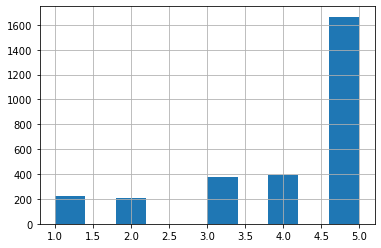

In [10]:
data['score'].hist()

In [11]:
data['score'].value_counts()

5.0    1666
4.0     395
3.0     380
1.0     225
2.0     210
Name: score, dtype: int64

In [12]:
data.sample(10)

score                                              Title  \
878     5.0                                        Clean rooms   
2433    4.0                                            AWESOME   
2861    5.0                 You Won't Go Wrong at the Bellagio   
1136    2.0  Overcharged for extra person through AMEX Fine...   
982     5.0    Great Location, Nice Room and Excellent Service   
1137    4.0               Amazing view, room and great service   
2749    5.0                            Excellent Casino Resort   
2101    2.0                                        Sister trip   
79      5.0                                Best Hotel in Vegas   
2666    5.0  Great hotel. Great staff. Terrible decision to...   

                                                content  
878   Love the rooms, it was ery comfortable, especi...  
2433  Need new beds and pillows!!!! ADRIANNA is the ...  
2861  We live in Vegas but from time to time do a "s...  
1136  Booked through AMEX Fine Hotels program for tw...  
982   Bellagio has nice rooms, buffet and restaurant...  
1137  At the end of a road trip with kids we wanted ...  
2749  Amazing place to stay & play !! The stay was v...  
2101  Great beds but we experienced some negative gu...  
79    Another great stay at Bellagio, beautiful, cle...  
2666  MLife made a terrible decision to downgrade pl...

- 고객의 리뷰를 “긍정” / “부정” 으로 분류하기 위하여 변수'score'를 이용하여 binary variable을 생성한다.
- 데이터를 살펴보니 1-3점 리뷰는 부정적인 내용, 4-5점 리뷰는 대체적으로 긍정적인 내용이 포함되어 있으므로 1-3점까지는 label 0으로 코딩, 4-5점까지는 label 1로 코딩한다.

In [13]:
def score_to_label(score):
    if score > 3:
        return 1
    else:
        return 0
    
data['label'] = data['score'].apply(lambda x: score_to_label(x))

In [14]:
data.head()

score                             Title  \
0    2.0                        Dirty Room   
1    5.0                  Great vacation!!   
2    4.0  Fantastic Experience at Bellagio   
3    4.0      Beautiful but $22 for water?   
4    5.0        A perfect Weekend getaway!   

                                             content  label  
0  Stayed at the Bellagio for the first time ever...      0  
1  Beautiful well kept room with a great view. Wo...      1  
2  We had a wonderful time at Bellagio. Everythin...      1  
3  I had a great stay at the Bellagio. The place ...      1  
4  The hotel is wheelchair friendly. The rooms we...      1

In [15]:
data['label'].value_counts()

1    2061
0     815
Name: label, dtype: int64

class imblance가 있는 것을 확인

In [16]:
#본문의 제목과 내용 합치기
data['review']=data['Title']+" "+data['content'] #형태소 분석을 위해 띄어쓰기를 해서 붙임

data=data.drop(['Title','content'], axis=1)
data.head()

score  label                                             review
0    2.0      0  Dirty Room Stayed at the Bellagio for the firs...
1    5.0      1  Great vacation!! Beautiful well kept room with...
2    4.0      1  Fantastic Experience at Bellagio We had a wond...
3    4.0      1  Beautiful but $22 for water? I had a great sta...
4    5.0      1  A perfect Weekend getaway! The hotel is wheelc...

# 3. 텍스트 데이터 전처리

## 3-0. 이모지(😂)와 이모티콘(:D) 텍스트로 변환하기
참고자료 : https://medium.com/geekculture/text-preprocessing-how-to-handle-emoji-emoticon-641bbfa6e9e7

In [17]:
!pip install emot

In [17]:
import re
import pickle
from emot.emo_unicode import UNICODE_EMOJI # For emojis
from emot.emo_unicode import EMOTICONS_EMO # For EMOTICONS

In [18]:
#Function for converting emojis into word
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))
    return text
#Example
text1 = "Hilarious 😂. The feeling of making a sale 😎, The feeling of actually fulfilling orders 😒"
convert_emojis(text1)

'Hilarious face_with_tears_of_joy. The feeling of making a sale smiling_face_with_sunglasses, The feeling of actually fulfilling orders unamused_face'

In [19]:
#Function for converting emoticons into word
def convert_emoticons(text):
    for emot in EMOTICONS_EMO:
        text = text.replace(emot, EMOTICONS_EMO[emot].replace(" ","_"))
    return text
#Example
text1 = "Hello :-) :-)"
convert_emoticons(text1)

'Hello Happy_face_smiley Happy_face_smiley'

In [20]:
data['review'][1586]

'Upgrade was very special... :-) I upgraded to a penthouse 2 bedroom suite and it was beautiful! My niece was able to join me this trip and we had a memorable time. The food was better than last year, and the weather was perfect! Thank you!'

In [21]:
convert_emoticons(data['review'][1586])

'Upgrade was very special... Happy_face_smiley I upgraded to a penthouse 2 bedroom suite and it was beautiful! My niece was able to join me this trip and we had a memorable time. The food was better than last year, and the weather was perfect! Thank you!'

In [22]:
#모든 리뷰에 대해 함수 적용

In [23]:
data['review']=data['review'].apply(lambda x: convert_emojis(x))

In [24]:
data['review']=data['review'].apply(lambda x: convert_emoticons(x))

## 3-1. 정규 표현식 사용

In [25]:
# 정규 표현식 함수 정의

import re

def apply_regular_expression(review):
    eng = re.compile('[^a-zA-Z]')  # a-z, A-Z가 아닌것은 공백으로 대체
    result = eng.sub(' ', review)  # 위에 설정한 "eng"규칙을 "review"에 적용(.sub)시킴
    return result

In [26]:
data['review'][0]

'Dirty Room Stayed at the Bellagio for the first time ever for a work trip. I had requested early check-in via front desk chat on Hotels.com and was not told I had to fill out anything in advance on the App to secure. They found me an accessible room, which was good until I entered the room. I found a used razor blade on the bathroom counter, the towels were used with stains on them, and there was hair throughout the bathroom and in between the bed sheets.'

In [27]:
apply_regular_expression(data['review'][0])

'Dirty Room Stayed at the Bellagio for the first time ever for a work trip  I had requested early check in via front desk chat on Hotels com and was not told I had to fill out anything in advance on the App to secure  They found me an accessible room  which was good until I entered the room  I found a used razor blade on the bathroom counter  the towels were used with stains on them  and there was hair throughout the bathroom and in between the bed sheets '

정규 표현식을 이용하여 특수 문자가 제거된 것을 확인하였음

## 3-2. 토큰화(Tokenization)

In [28]:
from nltk.tokenize import word_tokenize
from collections import Counter

In [29]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kmr14\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [30]:
tokenized_sentence = word_tokenize(data['review'][0])

print(tokenized_sentence)

['Dirty', 'Room', 'Stayed', 'at', 'the', 'Bellagio', 'for', 'the', 'first', 'time', 'ever', 'for', 'a', 'work', 'trip', '.', 'I', 'had', 'requested', 'early', 'check-in', 'via', 'front', 'desk', 'chat', 'on', 'Hotels.com', 'and', 'was', 'not', 'told', 'I', 'had', 'to', 'fill', 'out', 'anything', 'in', 'advance', 'on', 'the', 'App', 'to', 'secure', '.', 'They', 'found', 'me', 'an', 'accessible', 'room', ',', 'which', 'was', 'good', 'until', 'I', 'entered', 'the', 'room', '.', 'I', 'found', 'a', 'used', 'razor', 'blade', 'on', 'the', 'bathroom', 'counter', ',', 'the', 'towels', 'were', 'used', 'with', 'stains', 'on', 'them', ',', 'and', 'there', 'was', 'hair', 'throughout', 'the', 'bathroom', 'and', 'in', 'between', 'the', 'bed', 'sheets', '.']


In [31]:
# 말뭉치 생성
corpus = "".join(data['review'].tolist())
corpus

'Dirty Room Stayed at the Bellagio for the first time ever for a work trip. I had requested early check-in via front desk chat on Hotels.com and was not told I had to fill out anything in advance on the App to secure. They found me an accessible room, which was good until I entered the room. I found a used razor blade on the bathroom counter, the towels were used with stains on them, and there was hair throughout the bathroom and in between the bed sheets.Great vacation!! Beautiful well kept room with a great view. Wonderful food and great staff!! This is a beautiful hotel that has everything you need for a wonderful vacation. We did most of our gambling and most of our dining at the Bellagio.Fantastic Experience at Bellagio We had a wonderful time at Bellagio. Everything from the room (with spectacular view), food, pool, casino, and shopping were top notch! The only little thing was we had paid for early check in and still had to wait until nearly 3:00 for our room to be ready. They d

In [32]:
# 정규 표현식 적용
apply_regular_expression(corpus)

'Dirty Room Stayed at the Bellagio for the first time ever for a work trip  I had requested early check in via front desk chat on Hotels com and was not told I had to fill out anything in advance on the App to secure  They found me an accessible room  which was good until I entered the room  I found a used razor blade on the bathroom counter  the towels were used with stains on them  and there was hair throughout the bathroom and in between the bed sheets Great vacation   Beautiful well kept room with a great view  Wonderful food and great staff   This is a beautiful hotel that has everything you need for a wonderful vacation  We did most of our gambling and most of our dining at the Bellagio Fantastic Experience at Bellagio We had a wonderful time at Bellagio  Everything from the room  with spectacular view   food  pool  casino  and shopping were top notch  The only little thing was we had paid for early check in and still had to wait until nearly      for our room to be ready  They d

In [33]:
# 전체 말뭉치(corpus)에서 단어 추출
nouns = word_tokenize(apply_regular_expression(corpus).lower())
print(nouns)

['dirty', 'room', 'stayed', 'at', 'the', 'bellagio', 'for', 'the', 'first', 'time', 'ever', 'for', 'a', 'work', 'trip', 'i', 'had', 'requested', 'early', 'check', 'in', 'via', 'front', 'desk', 'chat', 'on', 'hotels', 'com', 'and', 'was', 'not', 'told', 'i', 'had', 'to', 'fill', 'out', 'anything', 'in', 'advance', 'on', 'the', 'app', 'to', 'secure', 'they', 'found', 'me', 'an', 'accessible', 'room', 'which', 'was', 'good', 'until', 'i', 'entered', 'the', 'room', 'i', 'found', 'a', 'used', 'razor', 'blade', 'on', 'the', 'bathroom', 'counter', 'the', 'towels', 'were', 'used', 'with', 'stains', 'on', 'them', 'and', 'there', 'was', 'hair', 'throughout', 'the', 'bathroom', 'and', 'in', 'between', 'the', 'bed', 'sheets', 'great', 'vacation', 'beautiful', 'well', 'kept', 'room', 'with', 'a', 'great', 'view', 'wonderful', 'food', 'and', 'great', 'staff', 'this', 'is', 'a', 'beautiful', 'hotel', 'that', 'has', 'everything', 'you', 'need', 'for', 'a', 'wonderful', 'vacation', 'we', 'did', 'most',

컴퓨터에서 대문자와 소문자를 다르게 읽기 때문에 **lower()**을 사용하여 모두 소문자 처리

In [34]:
# 빈도 탐색
counter = Counter(nouns)

In [35]:
counter.most_common(10)

[('the', 11985),
 ('and', 6696),
 ('to', 5123),
 ('was', 4568),
 ('a', 4154),
 ('in', 3066),
 ('i', 2765),
 ('we', 2631),
 ('room', 2522),
 ('is', 2358)]

실질적으로 의미가 없는 단어들이 상위 10개로 출력되었으므로 불용어 제거 처리가 필요해 보임

## - word cloud

In [36]:
tags = counter.most_common(500)

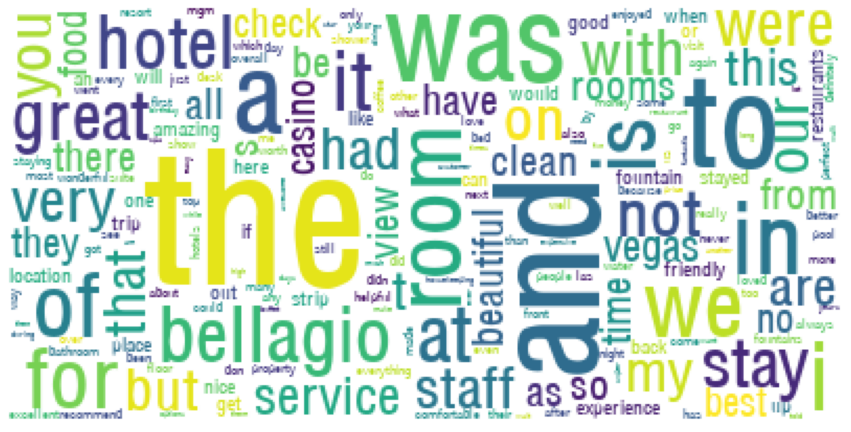

In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(font_path="C:/Windows/Fonts/HMFMMUEX.TTC",background_color="white", max_font_size=80)
cloud = wc.generate_from_frequencies(dict(tags))

plt.figure(figsize=(15, 10))
plt.axis('off')
plt.imshow(cloud)
plt.show()

## 3-3. 불용어 사전

In [36]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kmr14\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
from nltk.corpus import stopwords
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [38]:
#불용어를 추가해서 사용할 수 있음
#LasVagas_hotel_stopwords = ['lasvagas']
#for word in LasVagas_hotel_stopwords:
#    stopwords.append(word)

## 3-4. Word Count

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

def text_cleaning(text):
    eng = re.compile('[^a-zA-Z]')  # 정규 표현식 처리
    result = eng.sub(' ', text)
    nouns = word_tokenize(result.lower()) # 소문자로 토큰화
    nouns = [x for x in nouns if len(x) > 1]  # 한글자 키워드 제거(a,i, etc.)
    stop_words = set(stopwords.words("english"))
    nouns = [x for x in nouns if x not in stop_words]  # 불용어 제거
    return nouns

vect = CountVectorizer(tokenizer = lambda x: text_cleaning(x),max_features=5000) #빈도수가 높은 5000개까지만
bow_vect = vect.fit_transform(data['review'].tolist())
word_list = vect.get_feature_names()
count_list = bow_vect.toarray().sum(axis=0)

In [40]:
# 단어 리스트
word_list

['aaron',
 'ability',
 'able',
 'abrupt',
 'absolute',
 'absolutely',
 'absurd',
 'abuts',
 'abysmal',
 'ac',
 'accept',
 'acceptable',
 'acces',
 'access',
 'accessibility',
 'accessible',
 'accommodate',
 'accommodated',
 'accommodating',
 'accommodation',
 'accommodations',
 'accomodate',
 'accomodating',
 'accomodations',
 'according',
 'account',
 'accumulate',
 'acknowledge',
 'across',
 'act',
 'acted',
 'action',
 'activities',
 'activity',
 'acts',
 'actual',
 'actually',
 'ada',
 'add',
 'added',
 'adding',
 'addition',
 'additional',
 'address',
 'addressed',
 'addressing',
 'adds',
 'adequate',
 'adequately',
 'adjacent',
 'adjoining',
 'admit',
 'admitted',
 'adorable',
 'adrianna',
 'adult',
 'adults',
 'advance',
 'advanced',
 'advantage',
 'adventure',
 'advertise',
 'advertised',
 'advice',
 'advil',
 'advised',
 'advisor',
 'aesthetic',
 'aesthetically',
 'aesthetics',
 'afford',
 'affordable',
 'afternoon',
 'age',
 'aged',
 'agent',
 'agents',
 'ages',
 'aggravation

In [41]:
# 각 단어가 전체 리뷰중에 등장한 총 횟수
count_list

array([  1,   7, 100, ...,   1,   2,   1], dtype=int64)

In [42]:
# 각 단어의 리뷰별 등장 횟수
bow_vect.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [43]:
bow_vect.shape

(2876, 5000)

전체 데이터의 개수는 2876개, 단어수(feature)는 5000개이다

In [44]:
# "단어" - "총 등장 횟수" Matching

word_count_dict = dict(zip(word_list, count_list))
word_count_dict

{'aaron': 1,
 'ability': 7,
 'able': 100,
 'abrupt': 2,
 'absolute': 12,
 'absolutely': 75,
 'absurd': 2,
 'abuts': 2,
 'abysmal': 2,
 'ac': 27,
 'accept': 3,
 'acceptable': 3,
 'acces': 2,
 'access': 53,
 'accessibility': 2,
 'accessible': 10,
 'accommodate': 7,
 'accommodated': 6,
 'accommodating': 56,
 'accommodation': 5,
 'accommodations': 43,
 'accomodate': 2,
 'accomodating': 4,
 'accomodations': 3,
 'according': 5,
 'account': 6,
 'accumulate': 2,
 'acknowledge': 2,
 'across': 51,
 'act': 10,
 'acted': 6,
 'action': 9,
 'activities': 8,
 'activity': 2,
 'acts': 3,
 'actual': 9,
 'actually': 37,
 'ada': 2,
 'add': 15,
 'added': 21,
 'adding': 2,
 'addition': 8,
 'additional': 29,
 'address': 9,
 'addressed': 9,
 'addressing': 3,
 'adds': 3,
 'adequate': 9,
 'adequately': 2,
 'adjacent': 4,
 'adjoining': 10,
 'admit': 2,
 'admitted': 2,
 'adorable': 2,
 'adrianna': 2,
 'adult': 4,
 'adults': 14,
 'advance': 22,
 'advanced': 3,
 'advantage': 8,
 'adventure': 4,
 'advertise': 2,
 'a

## 3-5. TF-IDF 변환

In [45]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vectorizer = TfidfTransformer()
tf_idf_vect = tfidf_vectorizer.fit_transform(bow_vect)

In [46]:
print(tf_idf_vect.shape)

(2876, 5000)


변환 후 2876*5000 matrix 출력됨

In [47]:
# 첫 번째 리뷰에서의 단어 중요도(TF-IDF 값) -- 0이 아닌 것만 출력
print(tf_idf_vect[0])

  (0, 4919)	0.1342480406431612
  (0, 4656)	0.18838210681317014
  (0, 4574)	0.27859240844085836
  (0, 4375)	0.09878333346677731
  (0, 4296)	0.15287138733340122
  (0, 4255)	0.1327342019587604
  (0, 4219)	0.07909347440957268
  (0, 4189)	0.1680025844426033
  (0, 3836)	0.09753691847883707
  (0, 3794)	0.18338875986033235
  (0, 3402)	0.17416813333470016
  (0, 3295)	0.21154152672912951
  (0, 3106)	0.153194042950182
  (0, 2952)	0.1680025844426033
  (0, 1752)	0.11855307157250716
  (0, 1629)	0.16619472715237305
  (0, 1583)	0.09268011555357182
  (0, 1501)	0.10916051001597442
  (0, 1473)	0.28721728661991264
  (0, 1418)	0.10143894712764749
  (0, 1398)	0.23283827273042848
  (0, 1258)	0.1242667783531451
  (0, 1218)	0.22038047493228535
  (0, 1142)	0.14717492709256114
  (0, 1045)	0.13551521857719276
  (0, 1001)	0.10875174953234122
  (0, 827)	0.18838210681317014
  (0, 698)	0.23283827273042848
  (0, 609)	0.08891010950631136
  (0, 343)	0.055202907333867665
  (0, 322)	0.11342038329311907
  (0, 303)	0.240947

In [48]:
# 첫 번째 리뷰에서 모든 단어의 중요도 -- 0인 값까지 포함
print(tf_idf_vect[0].toarray().shape)
print(tf_idf_vect[0].toarray())

(1, 5000)
[[0. 0. 0. ... 0. 0. 0.]]


In [49]:
vect.vocabulary_

{'dirty': 1045,
 'room': 3106,
 'stayed': 3836,
 'bellagio': 343,
 'first': 1418,
 'time': 4219,
 'ever': 1258,
 'work': 4919,
 'trip': 4375,
 'requested': 2952,
 'early': 1142,
 'check': 609,
 'via': 4656,
 'front': 1501,
 'desk': 1001,
 'hotels': 1752,
 'com': 698,
 'told': 4255,
 'fill': 1398,
 'anything': 153,
 'advance': 57,
 'app': 162,
 'secure': 3295,
 'found': 1473,
 'accessible': 15,
 'good': 1583,
 'entered': 1218,
 'used': 4574,
 'bathroom': 303,
 'counter': 827,
 'towels': 4296,
 'stains': 3794,
 'hair': 1629,
 'throughout': 4189,
 'bed': 322,
 'sheets': 3402,
 'great': 1600,
 'vacation': 4590,
 'beautiful': 315,
 'well': 4818,
 'kept': 1915,
 'view': 4668,
 'wonderful': 4906,
 'food': 1453,
 'staff': 3787,
 'hotel': 1751,
 'everything': 1263,
 'need': 2304,
 'gambling': 1525,
 'dining': 1033,
 'fantastic': 1358,
 'experience': 1307,
 'spectacular': 3724,
 'pool': 2619,
 'casino': 547,
 'shopping': 3427,
 'top': 4269,
 'notch': 2354,
 'little': 2037,
 'thing': 4167,
 'paid

# 4. 감성분석 모델링

## training/ test set 나누기

In [50]:
from sklearn.model_selection import train_test_split

X = tf_idf_vect
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

In [51]:
X_train.shape, y_train.shape

((2013, 5000), (2013,))

In [52]:
X_test.shape, y_test.shape

((863, 5000), (863,))

## 4-1. Logistic Regression

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# fit in training set
lr = LogisticRegression(random_state = 0)
lr.fit(X_train, y_train)

# predict in test set
y_pred = lr.predict(X_test)

In [54]:
# classification result for test set

print('accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('precision: %.2f' % precision_score(y_test, y_pred))
print('recall: %.2f' % recall_score(y_test, y_pred))
print('F1: %.2f' % f1_score(y_test, y_pred))

accuracy: 0.87
precision: 0.87
recall: 0.96
F1: 0.91


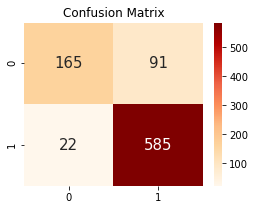

In [55]:
# confusion matrix

from sklearn.metrics import confusion_matrix

confu = confusion_matrix(y_true = y_test, y_pred = y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.show()

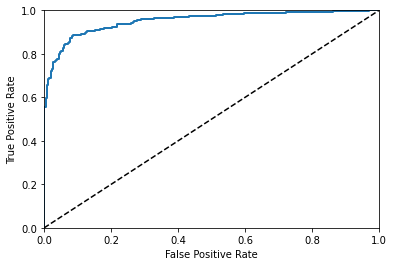

In [56]:
# ROC Curve 확인
from sklearn.metrics import roc_curve

y_pred_proba = lr.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

def plot_roc_curve(fpr,tpr):
    plt.plot(fpr,tpr,linewidth=2)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr,tpr)

In [57]:
# AUC Score 확인
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred)

0.8041437139621087

- 모델 평가결과를 살펴보면, train data의 label이 1로 치우쳐서 긍정(“1”)으로 예측하는 경향이 우세하게 나타나는 것을 확인.
- 따라서 긍정 리뷰를 잘 예측하지만, 부정 리뷰에 대한 예측 정확도가 낮음.
- 이는 샘플데이터의 클래스 불균형으로 인해 발생한 문제로 파악됨
- 따라서, 클래스 불균형 조정을 진행

In [107]:
data['label'].value_counts()

1    2061
0     815
Name: label, dtype: int64

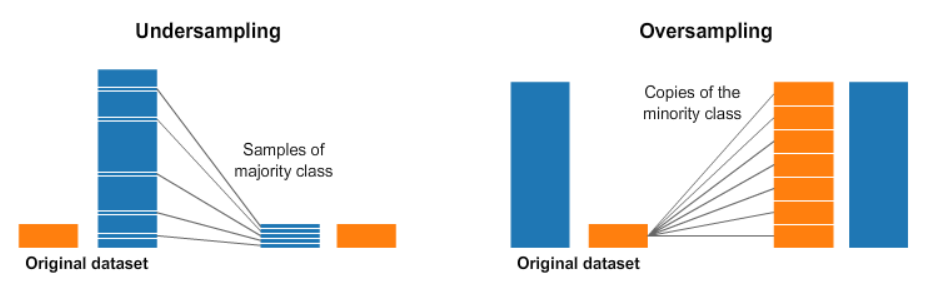

In [58]:
# imbalanced-learn 패키지
from imblearn.over_sampling import SMOTE

# 검증 데이터나 테스트 데이터가 아닌 학습데이터에서만 오버샘플링 사용할 것
smote = SMOTE(random_state=11)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [59]:
X_train_over.shape, y_train_over.shape

((2908, 5000), (2908,))

accuracy: 0.89
precision: 0.94
recall: 0.90
F1: 0.92
0.8872528830313016


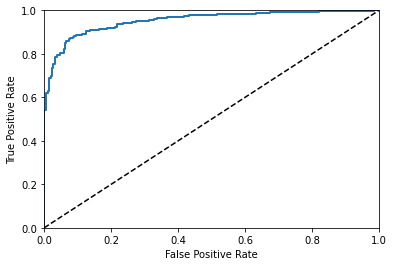

In [60]:
#오버샘플링
lr4 = LogisticRegression(random_state = 0)
lr4.fit(X_train_over, y_train_over)
y_pred = lr4.predict(X_test)

# classification result for test set
print('accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('precision: %.2f' % precision_score(y_test, y_pred))
print('recall: %.2f' % recall_score(y_test, y_pred))
print('F1: %.2f' % f1_score(y_test, y_pred))

# ROC Curve 확인
y_pred_proba = lr4.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plot_roc_curve(fpr,tpr)

# AUC Score 확인
print(roc_auc_score(y_test,y_pred))

auc score가 0.08이 상승된걸로 보아 성능이 향상되었음

## 4-2. SVM

In [114]:
#오버샘플링
from sklearn.svm import SVC

svm3=SVC(probability=True)
svm3.fit(X_train_over, y_train_over)
y_pred = svm3.predict(X_test)

# classification result for test set
print('accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('precision: %.2f' % precision_score(y_test, y_pred))
print('recall: %.2f' % recall_score(y_test, y_pred))
print('F1: %.2f' % f1_score(y_test, y_pred))

# AUC Score 확인
print(roc_auc_score(y_test,y_pred))

accuracy: 0.89
precision: 0.90
recall: 0.95
F1: 0.92
0.8475114549011532


## 4-3. Decision Tree

In [115]:
#오버샘플링
from sklearn.tree import DecisionTreeClassifier

tree3=DecisionTreeClassifier()
tree3.fit(X_train_over,y_train_over)
y_pred = tree3.predict(X_test)

# classification result for test set
print('accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('precision: %.2f' % precision_score(y_test, y_pred))
print('recall: %.2f' % recall_score(y_test, y_pred))
print('F1: %.2f' % f1_score(y_test, y_pred))

# AUC Score 확인
print(roc_auc_score(y_test,y_pred))

accuracy: 0.80
precision: 0.86
recall: 0.86
F1: 0.86
0.7589322487644152


## 4-4. Random Forest

In [116]:
#오버샘플링
from sklearn.ensemble import RandomForestClassifier

rf3=RandomForestClassifier()
rf3.fit(X_train_over,y_train_over)
y_pred = rf3.predict(X_test)

# classification result for test set
print('accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('precision: %.2f' % precision_score(y_test, y_pred))
print('recall: %.2f' % recall_score(y_test, y_pred))
print('F1: %.2f' % f1_score(y_test, y_pred))

# AUC Score 확인
print(roc_auc_score(y_test,y_pred))

accuracy: 0.86
precision: 0.88
recall: 0.94
F1: 0.91
0.8144016422981878


## 4-5. KNN

In [117]:
#오버샘플링
from sklearn.neighbors import KNeighborsClassifier

knn3=KNeighborsClassifier()
knn3.fit(X_train_over,y_train_over)
y_pred = knn3.predict(X_test)

# classification result for test set
print('accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('precision: %.2f' % precision_score(y_test, y_pred))
print('recall: %.2f' % recall_score(y_test, y_pred))
print('F1: %.2f' % f1_score(y_test, y_pred))

# AUC Score 확인
print(roc_auc_score(y_test,y_pred))

accuracy: 0.32
precision: 1.00
recall: 0.04
F1: 0.07
0.5189456342668863


## 4-6. LightGBM

In [118]:
#오버샘플링
from lightgbm import LGBMClassifier

model = LGBMClassifier() 
model.fit(X_train_over, y_train_over) 
y_pred = model.predict(X_test)

# classification result for test set
print('accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('precision: %.2f' % precision_score(y_test, y_pred))
print('recall: %.2f' % recall_score(y_test, y_pred))
print('F1: %.2f' % f1_score(y_test, y_pred))

# AUC Score
from sklearn.metrics import roc_auc_score
print("AUC Score:",roc_auc_score(y_test,y_pred))

accuracy: 0.87
precision: 0.89
recall: 0.93
F1: 0.91
AUC Score: 0.8278611511532126


## 4-7. xgboost

In [119]:
#오버샘플링
import xgboost as xgb
import matplotlib.pyplot as plt

model = xgb.XGBClassifier() 
model.fit(X_train_over, y_train_over) 
y_pred = model.predict(X_test)

# classification result for test set
print('accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('precision: %.2f' % precision_score(y_test, y_pred))
print('recall: %.2f' % recall_score(y_test, y_pred))
print('F1: %.2f' % f1_score(y_test, y_pred))

# AUC Score
from sklearn.metrics import roc_auc_score
print("AUC Score:",roc_auc_score(y_test,y_pred))

[21:40:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy: 0.86
precision: 0.88
recall: 0.92
F1: 0.90
AUC Score: 0.8120237850082372


## 4-8. Catboost

In [120]:
#오버샘플링
from catboost import CatBoostClassifier

model = CatBoostClassifier() 
model.fit(X_train_over, y_train_over) 
y_pred = model.predict(X_test)

# classification result for test set
print('accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('precision: %.2f' % precision_score(y_test, y_pred))
print('recall: %.2f' % recall_score(y_test, y_pred))
print('F1: %.2f' % f1_score(y_test, y_pred))

# AUC Score
from sklearn.metrics import roc_auc_score
print("AUC Score:",roc_auc_score(y_test,y_pred))

Learning rate set to 0.016251
0:	learn: 0.6845603	total: 629ms	remaining: 10m 27s
1:	learn: 0.6768668	total: 1.14s	remaining: 9m 30s
2:	learn: 0.6689278	total: 1.51s	remaining: 8m 21s
3:	learn: 0.6611044	total: 1.86s	remaining: 7m 44s
4:	learn: 0.6538117	total: 2.14s	remaining: 7m 6s
5:	learn: 0.6474407	total: 2.32s	remaining: 6m 23s
6:	learn: 0.6405112	total: 2.52s	remaining: 5m 58s
7:	learn: 0.6334561	total: 2.71s	remaining: 5m 36s
8:	learn: 0.6257383	total: 2.91s	remaining: 5m 20s
9:	learn: 0.6206983	total: 3.06s	remaining: 5m 3s
10:	learn: 0.6141454	total: 3.24s	remaining: 4m 51s
11:	learn: 0.6079491	total: 3.4s	remaining: 4m 39s
12:	learn: 0.6027354	total: 3.57s	remaining: 4m 31s
13:	learn: 0.5970424	total: 3.72s	remaining: 4m 22s
14:	learn: 0.5915433	total: 3.91s	remaining: 4m 16s
15:	learn: 0.5860338	total: 4.07s	remaining: 4m 10s
16:	learn: 0.5806389	total: 4.22s	remaining: 4m 3s
17:	learn: 0.5758787	total: 4.37s	remaining: 3m 58s
18:	learn: 0.5708781	total: 4.51s	remaining: 3m

159:	learn: 0.3038925	total: 33.9s	remaining: 2m 57s
160:	learn: 0.3031691	total: 34.1s	remaining: 2m 57s
161:	learn: 0.3023652	total: 34.3s	remaining: 2m 57s
162:	learn: 0.3015536	total: 34.5s	remaining: 2m 56s
163:	learn: 0.3008547	total: 34.6s	remaining: 2m 56s
164:	learn: 0.3000307	total: 34.8s	remaining: 2m 56s
165:	learn: 0.2992271	total: 35s	remaining: 2m 55s
166:	learn: 0.2981403	total: 35.2s	remaining: 2m 55s
167:	learn: 0.2972641	total: 35.3s	remaining: 2m 54s
168:	learn: 0.2967235	total: 35.5s	remaining: 2m 54s
169:	learn: 0.2960938	total: 35.7s	remaining: 2m 54s
170:	learn: 0.2953396	total: 35.8s	remaining: 2m 53s
171:	learn: 0.2946944	total: 36s	remaining: 2m 53s
172:	learn: 0.2940954	total: 36.1s	remaining: 2m 52s
173:	learn: 0.2935461	total: 36.2s	remaining: 2m 52s
174:	learn: 0.2928569	total: 36.4s	remaining: 2m 51s
175:	learn: 0.2922580	total: 36.5s	remaining: 2m 51s
176:	learn: 0.2915914	total: 36.7s	remaining: 2m 50s
177:	learn: 0.2910971	total: 36.8s	remaining: 2m 4

316:	learn: 0.2270430	total: 56.7s	remaining: 2m 2s
317:	learn: 0.2268126	total: 56.9s	remaining: 2m 1s
318:	learn: 0.2265545	total: 57s	remaining: 2m 1s
319:	learn: 0.2260518	total: 57.1s	remaining: 2m 1s
320:	learn: 0.2257550	total: 57.3s	remaining: 2m 1s
321:	learn: 0.2253432	total: 57.4s	remaining: 2m
322:	learn: 0.2251782	total: 57.6s	remaining: 2m
323:	learn: 0.2248507	total: 57.7s	remaining: 2m
324:	learn: 0.2244737	total: 57.9s	remaining: 2m
325:	learn: 0.2241429	total: 58s	remaining: 1m 59s
326:	learn: 0.2238503	total: 58.2s	remaining: 1m 59s
327:	learn: 0.2234922	total: 58.3s	remaining: 1m 59s
328:	learn: 0.2232607	total: 58.4s	remaining: 1m 59s
329:	learn: 0.2230102	total: 58.6s	remaining: 1m 58s
330:	learn: 0.2226173	total: 58.7s	remaining: 1m 58s
331:	learn: 0.2223348	total: 58.9s	remaining: 1m 58s
332:	learn: 0.2221242	total: 59s	remaining: 1m 58s
333:	learn: 0.2220195	total: 59.2s	remaining: 1m 57s
334:	learn: 0.2216815	total: 59.3s	remaining: 1m 57s
335:	learn: 0.221425

470:	learn: 0.1887490	total: 1m 24s	remaining: 1m 34s
471:	learn: 0.1885509	total: 1m 24s	remaining: 1m 34s
472:	learn: 0.1882601	total: 1m 25s	remaining: 1m 34s
473:	learn: 0.1880865	total: 1m 25s	remaining: 1m 34s
474:	learn: 0.1878515	total: 1m 25s	remaining: 1m 34s
475:	learn: 0.1877838	total: 1m 25s	remaining: 1m 34s
476:	learn: 0.1875648	total: 1m 25s	remaining: 1m 33s
477:	learn: 0.1872930	total: 1m 25s	remaining: 1m 33s
478:	learn: 0.1870891	total: 1m 25s	remaining: 1m 33s
479:	learn: 0.1868337	total: 1m 26s	remaining: 1m 33s
480:	learn: 0.1866789	total: 1m 26s	remaining: 1m 33s
481:	learn: 0.1864164	total: 1m 26s	remaining: 1m 32s
482:	learn: 0.1861649	total: 1m 26s	remaining: 1m 32s
483:	learn: 0.1859295	total: 1m 26s	remaining: 1m 32s
484:	learn: 0.1856971	total: 1m 26s	remaining: 1m 32s
485:	learn: 0.1854505	total: 1m 26s	remaining: 1m 31s
486:	learn: 0.1852234	total: 1m 27s	remaining: 1m 31s
487:	learn: 0.1850186	total: 1m 27s	remaining: 1m 31s
488:	learn: 0.1848426	total:

622:	learn: 0.1625111	total: 1m 53s	remaining: 1m 8s
623:	learn: 0.1622967	total: 1m 53s	remaining: 1m 8s
624:	learn: 0.1619622	total: 1m 53s	remaining: 1m 8s
625:	learn: 0.1619202	total: 1m 54s	remaining: 1m 8s
626:	learn: 0.1616618	total: 1m 54s	remaining: 1m 7s
627:	learn: 0.1615727	total: 1m 54s	remaining: 1m 7s
628:	learn: 0.1613331	total: 1m 54s	remaining: 1m 7s
629:	learn: 0.1612932	total: 1m 54s	remaining: 1m 7s
630:	learn: 0.1609838	total: 1m 54s	remaining: 1m 7s
631:	learn: 0.1606686	total: 1m 55s	remaining: 1m 7s
632:	learn: 0.1603840	total: 1m 55s	remaining: 1m 6s
633:	learn: 0.1600728	total: 1m 55s	remaining: 1m 6s
634:	learn: 0.1599258	total: 1m 55s	remaining: 1m 6s
635:	learn: 0.1596891	total: 1m 55s	remaining: 1m 6s
636:	learn: 0.1596511	total: 1m 55s	remaining: 1m 6s
637:	learn: 0.1595927	total: 1m 56s	remaining: 1m 5s
638:	learn: 0.1592574	total: 1m 56s	remaining: 1m 5s
639:	learn: 0.1590316	total: 1m 56s	remaining: 1m 5s
640:	learn: 0.1589096	total: 1m 56s	remaining:

779:	learn: 0.1374396	total: 2m 27s	remaining: 41.5s
780:	learn: 0.1372114	total: 2m 27s	remaining: 41.3s
781:	learn: 0.1369892	total: 2m 27s	remaining: 41.1s
782:	learn: 0.1369192	total: 2m 27s	remaining: 40.9s
783:	learn: 0.1368687	total: 2m 27s	remaining: 40.7s
784:	learn: 0.1366861	total: 2m 28s	remaining: 40.5s
785:	learn: 0.1365255	total: 2m 28s	remaining: 40.3s
786:	learn: 0.1363355	total: 2m 28s	remaining: 40.1s
787:	learn: 0.1361904	total: 2m 28s	remaining: 39.9s
788:	learn: 0.1359972	total: 2m 28s	remaining: 39.8s
789:	learn: 0.1359486	total: 2m 29s	remaining: 39.7s
790:	learn: 0.1356985	total: 2m 29s	remaining: 39.5s
791:	learn: 0.1356335	total: 2m 29s	remaining: 39.3s
792:	learn: 0.1354172	total: 2m 29s	remaining: 39.1s
793:	learn: 0.1352298	total: 2m 30s	remaining: 38.9s
794:	learn: 0.1352033	total: 2m 30s	remaining: 38.7s
795:	learn: 0.1351143	total: 2m 30s	remaining: 38.5s
796:	learn: 0.1349592	total: 2m 30s	remaining: 38.4s
797:	learn: 0.1346763	total: 2m 30s	remaining:

936:	learn: 0.1173732	total: 3m	remaining: 12.1s
937:	learn: 0.1173521	total: 3m	remaining: 11.9s
938:	learn: 0.1171957	total: 3m	remaining: 11.7s
939:	learn: 0.1170469	total: 3m	remaining: 11.5s
940:	learn: 0.1170093	total: 3m 1s	remaining: 11.3s
941:	learn: 0.1167839	total: 3m 1s	remaining: 11.2s
942:	learn: 0.1166604	total: 3m 1s	remaining: 11s
943:	learn: 0.1164779	total: 3m 1s	remaining: 10.8s
944:	learn: 0.1163474	total: 3m 1s	remaining: 10.6s
945:	learn: 0.1163108	total: 3m 1s	remaining: 10.4s
946:	learn: 0.1161840	total: 3m 1s	remaining: 10.2s
947:	learn: 0.1161465	total: 3m 1s	remaining: 9.98s
948:	learn: 0.1159901	total: 3m 2s	remaining: 9.79s
949:	learn: 0.1158632	total: 3m 2s	remaining: 9.59s
950:	learn: 0.1158093	total: 3m 2s	remaining: 9.4s
951:	learn: 0.1157734	total: 3m 2s	remaining: 9.21s
952:	learn: 0.1157527	total: 3m 2s	remaining: 9.01s
953:	learn: 0.1155913	total: 3m 2s	remaining: 8.82s
954:	learn: 0.1154156	total: 3m 3s	remaining: 8.63s
955:	learn: 0.1153244	total

## 4-9. LSTM(딥러닝)

**imbalanced data in LSTM**
- weight를 줘야함
- 참고자료 : https://stackoverflow.com/questions/69783897/compute-class-weight-function-issue-in-sklearn-library-when-used-in-keras-cl

In [68]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np
#import tensorflow as tf
#run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True) #메모리 부족

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(5000, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

class_weights = class_weight.compute_class_weight(class_weight="balanced",classes=np.unique(y_train),y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train.toarray(), y_train, epochs=15, callbacks=[es, mc], batch_size=16, validation_split=0.2, class_weight=class_weights)

Epoch 1/15
101/101 [==============================] - ETA: 0s - loss: 0.6981 - acc: 0.4503 
Epoch 1: val_acc improved from -inf to 0.26303, saving model to best_model.h5
101/101 [==============================] - 2054s 20s/step - loss: 0.6981 - acc: 0.4503 - val_loss: 0.7001 - val_acc: 0.2630
Epoch 2/15
101/101 [==============================] - ETA: 0s - loss: 0.6968 - acc: 0.5037 
Epoch 2: val_acc did not improve from 0.26303
101/101 [==============================] - 2207s 22s/step - loss: 0.6968 - acc: 0.5037 - val_loss: 0.7019 - val_acc: 0.2630
Epoch 3/15
101/101 [==============================] - ETA: 0s - loss: 0.6968 - acc: 0.3112 
Epoch 3: val_acc improved from 0.26303 to 0.73697, saving model to best_model.h5
101/101 [==============================] - 1924s 19s/step - loss: 0.6968 - acc: 0.3112 - val_loss: 0.6912 - val_acc: 0.7370
Epoch 4/15
101/101 [==============================] - ETA: 0s - loss: 0.6968 - acc: 0.4292 
Epoch 4: val_acc did not improve from 0.73697
101/101 [

In [69]:
from tensorflow.keras.models import load_model

loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test.toarray(), y_test)[1]))

27/27 [==============================] - 114s 4s/step - loss: 0.6915 - acc: 0.7034

 테스트 정확도: 0.7034


In [70]:
from tensorflow.keras.models import load_model
loaded_model = load_model('best_model.h5')

y_pred = loaded_model.predict(X_test.toarray())

# AUC Score
from sklearn.metrics import roc_auc_score
print("AUC Score:",roc_auc_score(y_test,y_pred))

AUC Score: 0.5


NOTE
- 데이터의 크기가 클수록 딥러닝의 성능은 더욱 발휘 되는데, 데이터의 개수가 충분하지 않아서 auc와 accuracy가 낮게 나온것으로 판단함

# NOTE
- 모델링 결과, 스케일링 안하고 오버샘플링만 진행한 **logistic regression** (auc 0.88)가 가장 성능이 좋았다
- 그 다음으로는 각각 **catboost**(auc 0.85), **svm**(auc 0.84) 순서대로 모델 성능이 좋았다 (오버샘플링만 한 기준으로)

# 5. GridsearchCV

## 5-1. Logistic Regression

In [136]:
#oversampling을 해야되기 때문에 pipeline 생성
from imblearn.pipeline import Pipeline, make_pipeline
imba_pipeline = Pipeline([('sampling',SMOTE(random_state=11)), ('classification',LogisticRegression(random_state = 0))])

from sklearn.model_selection import GridSearchCV
# 파라미터 후보
param_grid1 = [{'classification__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'classification__penalty': ['l1', 'l2']}]

# 그리드 서치 진행
grid_search1 = GridSearchCV(imba_pipeline, param_grid1, scoring = 'roc_auc', cv=5)        

grid_search1.fit(X_train, y_train)
grid_search1.score(X_test, y_test)

print('test accuracy : ', grid_search1.score(X_test, y_test))
print('최적의 parameters : ', grid_search1.best_params_)

test accuracy :  0.9523785008237231
최적의 parameters :  {'classification__C': 1, 'classification__penalty': 'l2'}


In [137]:
grid_search1.best_score_ #train data set에서 0.95까지 상승

0.9522660380658958

In [138]:
#AUC score
y_pred = grid_search1.predict(X_test)
print("AUC Score:",roc_auc_score(y_test,y_pred))

AUC Score: 0.8872528830313016


NOTE
- Train data set에서 best parameter를 적용하면 accuracy가 0.95까지 상승되는것을 확인하였다.
- gridsearchcv전에는 AUC Score: 0.8872528830313016로, **best parameter({'classification__C': 1, 'classification__penalty': 'l2'})**가 적용된 것을 확인했다!

NOTE
- 오버샘플링을 하고 나서 cv를 하면 오버피팅이 우려됨. 따라서, 파이프라인을 생성해서 오버샘플링과 cv를 함께 작업 
- https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html
- https://towardsdatascience.com/imbalanced-class-sizes-and-classification-models-a-cautionary-tale-part-2-cf371500d1b3
- gridsearchcv 자체가 cv를 함께 진행하기 때문에 cv 지정시, validation set이 정해진다. 따라서, 어떠한 튜닝도 사전에 하면 안되는 validation set을 위해서 파이프라인을 생성해서 작업하는것이 맞다.
- 이와 같은 이유로 gridsearchcv는 data set spilt을 한번만 하는 것이 맞다. (***일반 gridsearch에서만 train, val, test로 나눔***)

## 5-2. Catboost

In [61]:
#oversampling을 해야되기 때문에 pipeline 생성
from imblearn.pipeline import Pipeline, make_pipeline
imba_pipeline = Pipeline([('sampling',SMOTE(random_state=11)), ('classification',CatBoostClassifier())])

from sklearn.model_selection import GridSearchCV
# 파라미터 후보
param_grid2 = [{'classification__depth': [4,5,6,7,8,9,10],
              'classification__learning_rate': [0.01,0.02,0.03,0.04],
              'classification__iterations': [10,20,30,40,50,60,70,80,90,100]}]

# 그리드 서치 진행
grid_search2 = GridSearchCV(imba_pipeline, param_grid2, scoring = 'roc_auc', cv=5)        

grid_search2.fit(X_train, y_train)
grid_search2.score(X_test, y_test)

print('test accuracy : ', grid_search2.score(X_test, y_test))
print('최적의 parameters : ', grid_search2.best_params_)

0:	learn: 0.6895420	total: 235ms	remaining: 2.11s
1:	learn: 0.6860394	total: 275ms	remaining: 1.1s
2:	learn: 0.6828397	total: 318ms	remaining: 742ms
3:	learn: 0.6785136	total: 357ms	remaining: 536ms
4:	learn: 0.6746773	total: 403ms	remaining: 403ms
5:	learn: 0.6717090	total: 441ms	remaining: 294ms
6:	learn: 0.6682412	total: 497ms	remaining: 213ms
7:	learn: 0.6647852	total: 537ms	remaining: 134ms
8:	learn: 0.6609001	total: 577ms	remaining: 64.1ms
9:	learn: 0.6580590	total: 617ms	remaining: 0us
0:	learn: 0.6885098	total: 53.3ms	remaining: 480ms
1:	learn: 0.6849095	total: 105ms	remaining: 421ms
2:	learn: 0.6814611	total: 151ms	remaining: 353ms
3:	learn: 0.6775338	total: 198ms	remaining: 297ms
4:	learn: 0.6730881	total: 245ms	remaining: 245ms
5:	learn: 0.6685939	total: 299ms	remaining: 199ms
6:	learn: 0.6652394	total: 347ms	remaining: 149ms
7:	learn: 0.6612634	total: 387ms	remaining: 96.8ms
8:	learn: 0.6562739	total: 433ms	remaining: 48.1ms
9:	learn: 0.6529063	total: 484ms	remaining: 0us
0

5:	learn: 0.6048858	total: 259ms	remaining: 173ms
6:	learn: 0.5969547	total: 311ms	remaining: 133ms
7:	learn: 0.5858795	total: 355ms	remaining: 88.8ms
8:	learn: 0.5718790	total: 395ms	remaining: 43.9ms
9:	learn: 0.5621735	total: 435ms	remaining: 0us
0:	learn: 0.6745379	total: 45.9ms	remaining: 413ms
1:	learn: 0.6598711	total: 89.2ms	remaining: 357ms
2:	learn: 0.6461796	total: 130ms	remaining: 302ms
3:	learn: 0.6341490	total: 170ms	remaining: 254ms
4:	learn: 0.6183195	total: 209ms	remaining: 209ms
5:	learn: 0.6095801	total: 252ms	remaining: 168ms
6:	learn: 0.5946201	total: 309ms	remaining: 132ms
7:	learn: 0.5838216	total: 376ms	remaining: 94ms
8:	learn: 0.5746328	total: 432ms	remaining: 47.9ms
9:	learn: 0.5693065	total: 493ms	remaining: 0us
0:	learn: 0.6798519	total: 52.6ms	remaining: 473ms
1:	learn: 0.6627323	total: 95.9ms	remaining: 384ms
2:	learn: 0.6476996	total: 136ms	remaining: 317ms
3:	learn: 0.6321156	total: 176ms	remaining: 263ms
4:	learn: 0.6200699	total: 215ms	remaining: 215m

8:	learn: 0.6250726	total: 523ms	remaining: 640ms
9:	learn: 0.6192623	total: 575ms	remaining: 575ms
10:	learn: 0.6141431	total: 627ms	remaining: 513ms
11:	learn: 0.6077576	total: 692ms	remaining: 462ms
12:	learn: 0.6013283	total: 739ms	remaining: 398ms
13:	learn: 0.5962484	total: 780ms	remaining: 334ms
14:	learn: 0.5902206	total: 823ms	remaining: 274ms
15:	learn: 0.5844753	total: 866ms	remaining: 217ms
16:	learn: 0.5789402	total: 906ms	remaining: 160ms
17:	learn: 0.5738033	total: 956ms	remaining: 106ms
18:	learn: 0.5697868	total: 998ms	remaining: 52.5ms
19:	learn: 0.5655415	total: 1.04s	remaining: 0us
0:	learn: 0.6836859	total: 51.1ms	remaining: 971ms
1:	learn: 0.6759524	total: 96.2ms	remaining: 865ms
2:	learn: 0.6676451	total: 145ms	remaining: 822ms
3:	learn: 0.6609383	total: 191ms	remaining: 765ms
4:	learn: 0.6526631	total: 232ms	remaining: 697ms
5:	learn: 0.6472971	total: 282ms	remaining: 658ms
6:	learn: 0.6384806	total: 324ms	remaining: 602ms
7:	learn: 0.6317456	total: 365ms	remain

15:	learn: 0.5431041	total: 691ms	remaining: 173ms
16:	learn: 0.5373767	total: 742ms	remaining: 131ms
17:	learn: 0.5314881	total: 788ms	remaining: 87.5ms
18:	learn: 0.5261627	total: 842ms	remaining: 44.3ms
19:	learn: 0.5217051	total: 885ms	remaining: 0us
0:	learn: 0.6790227	total: 49.4ms	remaining: 938ms
1:	learn: 0.6673952	total: 88.8ms	remaining: 799ms
2:	learn: 0.6546368	total: 131ms	remaining: 744ms
3:	learn: 0.6402789	total: 175ms	remaining: 699ms
4:	learn: 0.6277229	total: 215ms	remaining: 644ms
5:	learn: 0.6178006	total: 257ms	remaining: 600ms
6:	learn: 0.6071784	total: 300ms	remaining: 557ms
7:	learn: 0.5951726	total: 340ms	remaining: 509ms
8:	learn: 0.5838430	total: 379ms	remaining: 463ms
9:	learn: 0.5753535	total: 418ms	remaining: 418ms
10:	learn: 0.5658128	total: 463ms	remaining: 378ms
11:	learn: 0.5583320	total: 508ms	remaining: 339ms
12:	learn: 0.5490253	total: 552ms	remaining: 297ms
13:	learn: 0.5417748	total: 591ms	remaining: 253ms
14:	learn: 0.5345357	total: 630ms	remai

29:	learn: 0.5904168	total: 1.44s	remaining: 0us
0:	learn: 0.6883778	total: 49.1ms	remaining: 1.42s
1:	learn: 0.6844119	total: 89.7ms	remaining: 1.25s
2:	learn: 0.6800810	total: 130ms	remaining: 1.17s
3:	learn: 0.6765093	total: 170ms	remaining: 1.11s
4:	learn: 0.6720459	total: 210ms	remaining: 1.05s
5:	learn: 0.6680265	total: 251ms	remaining: 1s
6:	learn: 0.6631761	total: 299ms	remaining: 981ms
7:	learn: 0.6594005	total: 339ms	remaining: 932ms
8:	learn: 0.6552700	total: 379ms	remaining: 885ms
9:	learn: 0.6524957	total: 420ms	remaining: 840ms
10:	learn: 0.6487314	total: 461ms	remaining: 795ms
11:	learn: 0.6454311	total: 511ms	remaining: 766ms
12:	learn: 0.6418496	total: 565ms	remaining: 739ms
13:	learn: 0.6384165	total: 635ms	remaining: 725ms
14:	learn: 0.6356678	total: 714ms	remaining: 714ms
15:	learn: 0.6321448	total: 763ms	remaining: 668ms
16:	learn: 0.6291712	total: 804ms	remaining: 615ms
17:	learn: 0.6266917	total: 845ms	remaining: 563ms
18:	learn: 0.6235057	total: 896ms	remaining:

14:	learn: 0.5938211	total: 691ms	remaining: 691ms
15:	learn: 0.5880575	total: 753ms	remaining: 659ms
16:	learn: 0.5837508	total: 806ms	remaining: 616ms
17:	learn: 0.5798747	total: 860ms	remaining: 573ms
18:	learn: 0.5746479	total: 900ms	remaining: 521ms
19:	learn: 0.5699998	total: 940ms	remaining: 470ms
20:	learn: 0.5651816	total: 979ms	remaining: 420ms
21:	learn: 0.5599824	total: 1.02s	remaining: 370ms
22:	learn: 0.5552013	total: 1.08s	remaining: 328ms
23:	learn: 0.5515617	total: 1.13s	remaining: 283ms
24:	learn: 0.5472162	total: 1.17s	remaining: 235ms
25:	learn: 0.5433083	total: 1.21s	remaining: 187ms
26:	learn: 0.5392500	total: 1.26s	remaining: 140ms
27:	learn: 0.5347353	total: 1.3s	remaining: 93.1ms
28:	learn: 0.5309339	total: 1.34s	remaining: 46.3ms
29:	learn: 0.5267593	total: 1.38s	remaining: 0us
0:	learn: 0.6864129	total: 47.3ms	remaining: 1.37s
1:	learn: 0.6775194	total: 91.8ms	remaining: 1.28s
2:	learn: 0.6688641	total: 132ms	remaining: 1.19s
3:	learn: 0.6602259	total: 172ms	

26:	learn: 0.4962251	total: 1.37s	remaining: 152ms
27:	learn: 0.4908455	total: 1.46s	remaining: 104ms
28:	learn: 0.4867536	total: 1.52s	remaining: 52.4ms
29:	learn: 0.4820064	total: 1.57s	remaining: 0us
0:	learn: 0.6831153	total: 88.5ms	remaining: 2.57s
1:	learn: 0.6700088	total: 157ms	remaining: 2.2s
2:	learn: 0.6582603	total: 232ms	remaining: 2.09s
3:	learn: 0.6458554	total: 292ms	remaining: 1.9s
4:	learn: 0.6347971	total: 348ms	remaining: 1.74s
5:	learn: 0.6263436	total: 393ms	remaining: 1.57s
6:	learn: 0.6180466	total: 438ms	remaining: 1.44s
7:	learn: 0.6079294	total: 483ms	remaining: 1.33s
8:	learn: 0.5982718	total: 535ms	remaining: 1.25s
9:	learn: 0.5888652	total: 579ms	remaining: 1.16s
10:	learn: 0.5787025	total: 620ms	remaining: 1.07s
11:	learn: 0.5712595	total: 660ms	remaining: 990ms
12:	learn: 0.5638142	total: 702ms	remaining: 918ms
13:	learn: 0.5567502	total: 752ms	remaining: 860ms
14:	learn: 0.5511193	total: 800ms	remaining: 800ms
15:	learn: 0.5442267	total: 852ms	remaining

10:	learn: 0.5566430	total: 486ms	remaining: 839ms
11:	learn: 0.5476634	total: 552ms	remaining: 829ms
12:	learn: 0.5382664	total: 596ms	remaining: 780ms
13:	learn: 0.5301673	total: 646ms	remaining: 738ms
14:	learn: 0.5234276	total: 690ms	remaining: 690ms
15:	learn: 0.5152196	total: 740ms	remaining: 647ms
16:	learn: 0.5086192	total: 780ms	remaining: 597ms
17:	learn: 0.5014429	total: 820ms	remaining: 547ms
18:	learn: 0.4965129	total: 860ms	remaining: 498ms
19:	learn: 0.4907646	total: 900ms	remaining: 450ms
20:	learn: 0.4860862	total: 951ms	remaining: 407ms
21:	learn: 0.4804047	total: 991ms	remaining: 360ms
22:	learn: 0.4747772	total: 1.03s	remaining: 314ms
23:	learn: 0.4688901	total: 1.07s	remaining: 268ms
24:	learn: 0.4642699	total: 1.11s	remaining: 223ms
25:	learn: 0.4583773	total: 1.16s	remaining: 179ms
26:	learn: 0.4538770	total: 1.2s	remaining: 134ms
27:	learn: 0.4495464	total: 1.24s	remaining: 88.8ms
28:	learn: 0.4454372	total: 1.28s	remaining: 44.3ms
29:	learn: 0.4407027	total: 1.

32:	learn: 0.5827929	total: 1.44s	remaining: 305ms
33:	learn: 0.5803652	total: 1.48s	remaining: 262ms
34:	learn: 0.5776890	total: 1.52s	remaining: 218ms
35:	learn: 0.5750045	total: 1.56s	remaining: 174ms
36:	learn: 0.5729651	total: 1.61s	remaining: 131ms
37:	learn: 0.5706709	total: 1.67s	remaining: 88.1ms
38:	learn: 0.5681258	total: 1.72s	remaining: 44.1ms
39:	learn: 0.5656088	total: 1.76s	remaining: 0us
0:	learn: 0.6897600	total: 65.8ms	remaining: 2.57s
1:	learn: 0.6852371	total: 118ms	remaining: 2.25s
2:	learn: 0.6807763	total: 165ms	remaining: 2.03s
3:	learn: 0.6762075	total: 214ms	remaining: 1.93s
4:	learn: 0.6719510	total: 259ms	remaining: 1.81s
5:	learn: 0.6685802	total: 307ms	remaining: 1.74s
6:	learn: 0.6652304	total: 351ms	remaining: 1.66s
7:	learn: 0.6608775	total: 391ms	remaining: 1.56s
8:	learn: 0.6566548	total: 431ms	remaining: 1.49s
9:	learn: 0.6519332	total: 473ms	remaining: 1.42s
10:	learn: 0.6473394	total: 520ms	remaining: 1.37s
11:	learn: 0.6440220	total: 560ms	remain

35:	learn: 0.5022745	total: 1.56s	remaining: 174ms
36:	learn: 0.4986438	total: 1.61s	remaining: 130ms
37:	learn: 0.4955212	total: 1.65s	remaining: 86.6ms
38:	learn: 0.4930549	total: 1.69s	remaining: 43.5ms
39:	learn: 0.4897945	total: 1.75s	remaining: 0us
0:	learn: 0.6836859	total: 46.4ms	remaining: 1.81s
1:	learn: 0.6759524	total: 86.6ms	remaining: 1.65s
2:	learn: 0.6676451	total: 126ms	remaining: 1.55s
3:	learn: 0.6609383	total: 166ms	remaining: 1.5s
4:	learn: 0.6526631	total: 206ms	remaining: 1.44s
5:	learn: 0.6472971	total: 255ms	remaining: 1.45s
6:	learn: 0.6384806	total: 309ms	remaining: 1.46s
7:	learn: 0.6317456	total: 349ms	remaining: 1.4s
8:	learn: 0.6245331	total: 389ms	remaining: 1.34s
9:	learn: 0.6209841	total: 429ms	remaining: 1.29s
10:	learn: 0.6146253	total: 474ms	remaining: 1.25s
11:	learn: 0.6096098	total: 527ms	remaining: 1.23s
12:	learn: 0.6041144	total: 568ms	remaining: 1.18s
13:	learn: 0.5989557	total: 608ms	remaining: 1.13s
14:	learn: 0.5938211	total: 648ms	remaini

39:	learn: 0.4518160	total: 1.75s	remaining: 0us
0:	learn: 0.6794334	total: 46.6ms	remaining: 1.82s
1:	learn: 0.6673388	total: 86.5ms	remaining: 1.64s
2:	learn: 0.6556889	total: 126ms	remaining: 1.55s
3:	learn: 0.6459338	total: 170ms	remaining: 1.53s
4:	learn: 0.6344397	total: 217ms	remaining: 1.52s
5:	learn: 0.6236279	total: 259ms	remaining: 1.47s
6:	learn: 0.6158595	total: 310ms	remaining: 1.46s
7:	learn: 0.6067984	total: 351ms	remaining: 1.4s
8:	learn: 0.5952324	total: 392ms	remaining: 1.35s
9:	learn: 0.5876121	total: 435ms	remaining: 1.3s
10:	learn: 0.5816155	total: 482ms	remaining: 1.27s
11:	learn: 0.5735102	total: 523ms	remaining: 1.22s
12:	learn: 0.5658472	total: 563ms	remaining: 1.17s
13:	learn: 0.5594939	total: 603ms	remaining: 1.12s
14:	learn: 0.5518547	total: 644ms	remaining: 1.07s
15:	learn: 0.5451960	total: 692ms	remaining: 1.04s
16:	learn: 0.5389424	total: 734ms	remaining: 993ms
17:	learn: 0.5333082	total: 774ms	remaining: 946ms
18:	learn: 0.5273803	total: 814ms	remaining

5:	learn: 0.6178006	total: 272ms	remaining: 1.54s
6:	learn: 0.6071784	total: 322ms	remaining: 1.52s
7:	learn: 0.5951726	total: 362ms	remaining: 1.45s
8:	learn: 0.5838430	total: 401ms	remaining: 1.38s
9:	learn: 0.5753535	total: 445ms	remaining: 1.34s
10:	learn: 0.5658128	total: 488ms	remaining: 1.28s
11:	learn: 0.5583320	total: 533ms	remaining: 1.24s
12:	learn: 0.5490253	total: 573ms	remaining: 1.19s
13:	learn: 0.5417748	total: 614ms	remaining: 1.14s
14:	learn: 0.5345357	total: 653ms	remaining: 1.09s
15:	learn: 0.5273905	total: 692ms	remaining: 1.04s
16:	learn: 0.5203411	total: 739ms	remaining: 1000ms
17:	learn: 0.5143957	total: 779ms	remaining: 952ms
18:	learn: 0.5091269	total: 818ms	remaining: 904ms
19:	learn: 0.5038594	total: 857ms	remaining: 857ms
20:	learn: 0.4981128	total: 899ms	remaining: 813ms
21:	learn: 0.4913479	total: 942ms	remaining: 771ms
22:	learn: 0.4852332	total: 981ms	remaining: 725ms
23:	learn: 0.4795137	total: 1.02s	remaining: 680ms
24:	learn: 0.4747609	total: 1.06s	r

10:	learn: 0.5563110	total: 484ms	remaining: 1.27s
11:	learn: 0.5484063	total: 534ms	remaining: 1.25s
12:	learn: 0.5389446	total: 578ms	remaining: 1.2s
13:	learn: 0.5294672	total: 618ms	remaining: 1.15s
14:	learn: 0.5226160	total: 662ms	remaining: 1.1s
15:	learn: 0.5150125	total: 707ms	remaining: 1.06s
16:	learn: 0.5079601	total: 750ms	remaining: 1.01s
17:	learn: 0.5031343	total: 790ms	remaining: 965ms
18:	learn: 0.4956330	total: 834ms	remaining: 922ms
19:	learn: 0.4892088	total: 874ms	remaining: 874ms
20:	learn: 0.4835341	total: 913ms	remaining: 826ms
21:	learn: 0.4779387	total: 962ms	remaining: 787ms
22:	learn: 0.4722643	total: 1s	remaining: 741ms
23:	learn: 0.4671806	total: 1.04s	remaining: 695ms
24:	learn: 0.4624776	total: 1.08s	remaining: 649ms
25:	learn: 0.4570187	total: 1.12s	remaining: 604ms
26:	learn: 0.4514381	total: 1.17s	remaining: 563ms
27:	learn: 0.4461333	total: 1.21s	remaining: 518ms
28:	learn: 0.4420284	total: 1.25s	remaining: 474ms
29:	learn: 0.4383695	total: 1.29s	re

33:	learn: 0.5803652	total: 1.46s	remaining: 686ms
34:	learn: 0.5776890	total: 1.51s	remaining: 646ms
35:	learn: 0.5750045	total: 1.55s	remaining: 604ms
36:	learn: 0.5729651	total: 1.6s	remaining: 562ms
37:	learn: 0.5706709	total: 1.64s	remaining: 518ms
38:	learn: 0.5681258	total: 1.69s	remaining: 477ms
39:	learn: 0.5656088	total: 1.74s	remaining: 434ms
40:	learn: 0.5632122	total: 1.78s	remaining: 392ms
41:	learn: 0.5611662	total: 1.83s	remaining: 348ms
42:	learn: 0.5587102	total: 1.88s	remaining: 306ms
43:	learn: 0.5568463	total: 1.92s	remaining: 262ms
44:	learn: 0.5543144	total: 1.96s	remaining: 218ms
45:	learn: 0.5529033	total: 2.02s	remaining: 175ms
46:	learn: 0.5507791	total: 2.08s	remaining: 133ms
47:	learn: 0.5492066	total: 2.13s	remaining: 88.6ms
48:	learn: 0.5471712	total: 2.17s	remaining: 44.3ms
49:	learn: 0.5455766	total: 2.21s	remaining: 0us
0:	learn: 0.6897600	total: 46.3ms	remaining: 2.27s
1:	learn: 0.6852371	total: 86.8ms	remaining: 2.08s
2:	learn: 0.6807763	total: 127ms

46:	learn: 0.4828953	total: 2.09s	remaining: 133ms
47:	learn: 0.4798739	total: 2.15s	remaining: 89.4ms
48:	learn: 0.4775054	total: 2.19s	remaining: 44.7ms
49:	learn: 0.4750926	total: 2.23s	remaining: 0us
0:	learn: 0.6839429	total: 49ms	remaining: 2.4s
1:	learn: 0.6769341	total: 88.9ms	remaining: 2.13s
2:	learn: 0.6703469	total: 129ms	remaining: 2.01s
3:	learn: 0.6633384	total: 172ms	remaining: 1.97s
4:	learn: 0.6550971	total: 215ms	remaining: 1.94s
5:	learn: 0.6469215	total: 262ms	remaining: 1.92s
6:	learn: 0.6409820	total: 310ms	remaining: 1.91s
7:	learn: 0.6337844	total: 350ms	remaining: 1.84s
8:	learn: 0.6250726	total: 390ms	remaining: 1.78s
9:	learn: 0.6192623	total: 430ms	remaining: 1.72s
10:	learn: 0.6141431	total: 469ms	remaining: 1.66s
11:	learn: 0.6077576	total: 518ms	remaining: 1.64s
12:	learn: 0.6013283	total: 559ms	remaining: 1.59s
13:	learn: 0.5962484	total: 599ms	remaining: 1.54s
14:	learn: 0.5902206	total: 647ms	remaining: 1.51s
15:	learn: 0.5844753	total: 701ms	remainin

10:	learn: 0.6122702	total: 474ms	remaining: 1.68s
11:	learn: 0.6057936	total: 514ms	remaining: 1.63s
12:	learn: 0.5992908	total: 555ms	remaining: 1.58s
13:	learn: 0.5925504	total: 598ms	remaining: 1.54s
14:	learn: 0.5874523	total: 652ms	remaining: 1.52s
15:	learn: 0.5822623	total: 695ms	remaining: 1.48s
16:	learn: 0.5765200	total: 737ms	remaining: 1.43s
17:	learn: 0.5714976	total: 777ms	remaining: 1.38s
18:	learn: 0.5673978	total: 821ms	remaining: 1.34s
19:	learn: 0.5636527	total: 866ms	remaining: 1.3s
20:	learn: 0.5591514	total: 911ms	remaining: 1.26s
21:	learn: 0.5539410	total: 951ms	remaining: 1.21s
22:	learn: 0.5483954	total: 991ms	remaining: 1.16s
23:	learn: 0.5441497	total: 1.03s	remaining: 1.12s
24:	learn: 0.5403060	total: 1.08s	remaining: 1.08s
25:	learn: 0.5362854	total: 1.12s	remaining: 1.04s
26:	learn: 0.5332140	total: 1.16s	remaining: 990ms
27:	learn: 0.5293871	total: 1.2s	remaining: 945ms
28:	learn: 0.5261715	total: 1.24s	remaining: 899ms
29:	learn: 0.5224595	total: 1.28s

25:	learn: 0.5013061	total: 1.15s	remaining: 1.06s
26:	learn: 0.4962251	total: 1.19s	remaining: 1.01s
27:	learn: 0.4908455	total: 1.23s	remaining: 963ms
28:	learn: 0.4867536	total: 1.27s	remaining: 917ms
29:	learn: 0.4820064	total: 1.31s	remaining: 872ms
30:	learn: 0.4787039	total: 1.35s	remaining: 831ms
31:	learn: 0.4740674	total: 1.4s	remaining: 785ms
32:	learn: 0.4686851	total: 1.44s	remaining: 739ms
33:	learn: 0.4654804	total: 1.48s	remaining: 695ms
34:	learn: 0.4618673	total: 1.52s	remaining: 650ms
35:	learn: 0.4583091	total: 1.56s	remaining: 609ms
36:	learn: 0.4549894	total: 1.61s	remaining: 566ms
37:	learn: 0.4516392	total: 1.66s	remaining: 524ms
38:	learn: 0.4482194	total: 1.7s	remaining: 479ms
39:	learn: 0.4448557	total: 1.75s	remaining: 438ms
40:	learn: 0.4412865	total: 1.79s	remaining: 393ms
41:	learn: 0.4377883	total: 1.83s	remaining: 349ms
42:	learn: 0.4342911	total: 1.87s	remaining: 305ms
43:	learn: 0.4311382	total: 1.91s	remaining: 261ms
44:	learn: 0.4284310	total: 1.96s

41:	learn: 0.4036109	total: 1.91s	remaining: 363ms
42:	learn: 0.4007826	total: 1.95s	remaining: 318ms
43:	learn: 0.3982306	total: 2s	remaining: 273ms
44:	learn: 0.3953735	total: 2.05s	remaining: 228ms
45:	learn: 0.3926332	total: 2.1s	remaining: 183ms
46:	learn: 0.3893361	total: 2.15s	remaining: 137ms
47:	learn: 0.3857663	total: 2.19s	remaining: 91.4ms
48:	learn: 0.3837181	total: 2.24s	remaining: 45.7ms
49:	learn: 0.3816593	total: 2.3s	remaining: 0us
0:	learn: 0.6749929	total: 55.6ms	remaining: 2.72s
1:	learn: 0.6592807	total: 100ms	remaining: 2.4s
2:	learn: 0.6444281	total: 141ms	remaining: 2.21s
3:	learn: 0.6330512	total: 182ms	remaining: 2.09s
4:	learn: 0.6184547	total: 226ms	remaining: 2.03s
5:	learn: 0.6048858	total: 275ms	remaining: 2.02s
6:	learn: 0.5969547	total: 316ms	remaining: 1.94s
7:	learn: 0.5858795	total: 356ms	remaining: 1.87s
8:	learn: 0.5718790	total: 399ms	remaining: 1.82s
9:	learn: 0.5621735	total: 444ms	remaining: 1.78s
10:	learn: 0.5551311	total: 496ms	remaining: 1

5:	learn: 0.6066224	total: 256ms	remaining: 1.88s
6:	learn: 0.5965440	total: 306ms	remaining: 1.88s
7:	learn: 0.5828254	total: 348ms	remaining: 1.82s
8:	learn: 0.5751589	total: 388ms	remaining: 1.76s
9:	learn: 0.5658359	total: 427ms	remaining: 1.71s
10:	learn: 0.5563110	total: 468ms	remaining: 1.66s
11:	learn: 0.5484063	total: 518ms	remaining: 1.64s
12:	learn: 0.5389446	total: 579ms	remaining: 1.65s
13:	learn: 0.5294672	total: 630ms	remaining: 1.62s
14:	learn: 0.5226160	total: 720ms	remaining: 1.68s
15:	learn: 0.5150125	total: 776ms	remaining: 1.65s
16:	learn: 0.5079601	total: 820ms	remaining: 1.59s
17:	learn: 0.5031343	total: 872ms	remaining: 1.55s
18:	learn: 0.4956330	total: 919ms	remaining: 1.5s
19:	learn: 0.4892088	total: 974ms	remaining: 1.46s
20:	learn: 0.4835341	total: 1.03s	remaining: 1.42s
21:	learn: 0.4779387	total: 1.07s	remaining: 1.36s
22:	learn: 0.4722643	total: 1.13s	remaining: 1.32s
23:	learn: 0.4671806	total: 1.22s	remaining: 1.32s
24:	learn: 0.4624776	total: 1.27s	rem

57:	learn: 0.5293163	total: 2.57s	remaining: 88.5ms
58:	learn: 0.5276644	total: 2.62s	remaining: 44.3ms
59:	learn: 0.5257430	total: 2.65s	remaining: 0us
0:	learn: 0.6883778	total: 46.4ms	remaining: 2.73s
1:	learn: 0.6844119	total: 86.4ms	remaining: 2.5s
2:	learn: 0.6800810	total: 126ms	remaining: 2.4s
3:	learn: 0.6765093	total: 166ms	remaining: 2.32s
4:	learn: 0.6720459	total: 206ms	remaining: 2.26s
5:	learn: 0.6680265	total: 250ms	remaining: 2.25s
6:	learn: 0.6631761	total: 297ms	remaining: 2.25s
7:	learn: 0.6594005	total: 337ms	remaining: 2.19s
8:	learn: 0.6552700	total: 377ms	remaining: 2.14s
9:	learn: 0.6524957	total: 420ms	remaining: 2.1s
10:	learn: 0.6487314	total: 467ms	remaining: 2.08s
11:	learn: 0.6454311	total: 517ms	remaining: 2.07s
12:	learn: 0.6418496	total: 565ms	remaining: 2.04s
13:	learn: 0.6384165	total: 609ms	remaining: 2s
14:	learn: 0.6356678	total: 659ms	remaining: 1.98s
15:	learn: 0.6321448	total: 707ms	remaining: 1.94s
16:	learn: 0.6291712	total: 747ms	remaining: 

39:	learn: 0.5666770	total: 1.75s	remaining: 875ms
40:	learn: 0.5643556	total: 1.79s	remaining: 830ms
41:	learn: 0.5619675	total: 1.84s	remaining: 791ms
42:	learn: 0.5596205	total: 1.9s	remaining: 751ms
43:	learn: 0.5572435	total: 1.95s	remaining: 709ms
44:	learn: 0.5550030	total: 1.99s	remaining: 664ms
45:	learn: 0.5529273	total: 2.05s	remaining: 623ms
46:	learn: 0.5505397	total: 2.13s	remaining: 589ms
47:	learn: 0.5485304	total: 2.18s	remaining: 546ms
48:	learn: 0.5464611	total: 2.23s	remaining: 500ms
49:	learn: 0.5445218	total: 2.28s	remaining: 457ms
50:	learn: 0.5420402	total: 2.33s	remaining: 411ms
51:	learn: 0.5403484	total: 2.38s	remaining: 366ms
52:	learn: 0.5389529	total: 2.42s	remaining: 320ms
53:	learn: 0.5364619	total: 2.46s	remaining: 274ms
54:	learn: 0.5346392	total: 2.5s	remaining: 227ms
55:	learn: 0.5329276	total: 2.55s	remaining: 182ms
56:	learn: 0.5308074	total: 2.6s	remaining: 137ms
57:	learn: 0.5287257	total: 2.65s	remaining: 91.3ms
58:	learn: 0.5265598	total: 2.69s

23:	learn: 0.5515617	total: 1.05s	remaining: 1.58s
24:	learn: 0.5472162	total: 1.1s	remaining: 1.55s
25:	learn: 0.5433083	total: 1.14s	remaining: 1.5s
26:	learn: 0.5392500	total: 1.19s	remaining: 1.45s
27:	learn: 0.5347353	total: 1.23s	remaining: 1.4s
28:	learn: 0.5309339	total: 1.28s	remaining: 1.37s
29:	learn: 0.5267593	total: 1.32s	remaining: 1.32s
30:	learn: 0.5233073	total: 1.36s	remaining: 1.27s
31:	learn: 0.5195090	total: 1.4s	remaining: 1.23s
32:	learn: 0.5150201	total: 1.44s	remaining: 1.18s
33:	learn: 0.5117821	total: 1.49s	remaining: 1.14s
34:	learn: 0.5085837	total: 1.53s	remaining: 1.09s
35:	learn: 0.5054665	total: 1.57s	remaining: 1.05s
36:	learn: 0.5021796	total: 1.61s	remaining: 1s
37:	learn: 0.4991040	total: 1.65s	remaining: 956ms
38:	learn: 0.4960619	total: 1.69s	remaining: 911ms
39:	learn: 0.4933060	total: 1.74s	remaining: 872ms
40:	learn: 0.4903214	total: 1.78s	remaining: 826ms
41:	learn: 0.4872747	total: 1.82s	remaining: 781ms
42:	learn: 0.4849528	total: 1.86s	rema

5:	learn: 0.6337235	total: 261ms	remaining: 2.35s
6:	learn: 0.6251589	total: 308ms	remaining: 2.33s
7:	learn: 0.6152128	total: 348ms	remaining: 2.26s
8:	learn: 0.6062357	total: 388ms	remaining: 2.2s
9:	learn: 0.5990599	total: 427ms	remaining: 2.14s
10:	learn: 0.5907276	total: 469ms	remaining: 2.09s
11:	learn: 0.5843840	total: 515ms	remaining: 2.06s
12:	learn: 0.5764499	total: 557ms	remaining: 2.01s
13:	learn: 0.5703651	total: 596ms	remaining: 1.96s
14:	learn: 0.5642074	total: 635ms	remaining: 1.91s
15:	learn: 0.5578638	total: 674ms	remaining: 1.85s
16:	learn: 0.5519532	total: 726ms	remaining: 1.83s
17:	learn: 0.5457429	total: 765ms	remaining: 1.78s
18:	learn: 0.5408969	total: 805ms	remaining: 1.74s
19:	learn: 0.5356837	total: 845ms	remaining: 1.69s
20:	learn: 0.5306291	total: 891ms	remaining: 1.65s
21:	learn: 0.5251446	total: 936ms	remaining: 1.62s
22:	learn: 0.5198275	total: 978ms	remaining: 1.57s
23:	learn: 0.5147569	total: 1.02s	remaining: 1.53s
24:	learn: 0.5097382	total: 1.06s	rem

47:	learn: 0.4204787	total: 2.07s	remaining: 518ms
48:	learn: 0.4174774	total: 2.12s	remaining: 475ms
49:	learn: 0.4146392	total: 2.16s	remaining: 431ms
50:	learn: 0.4122982	total: 2.2s	remaining: 388ms
51:	learn: 0.4099499	total: 2.24s	remaining: 344ms
52:	learn: 0.4072376	total: 2.29s	remaining: 302ms
53:	learn: 0.4042559	total: 2.33s	remaining: 259ms
54:	learn: 0.4014862	total: 2.38s	remaining: 216ms
55:	learn: 0.3989673	total: 2.42s	remaining: 173ms
56:	learn: 0.3968159	total: 2.46s	remaining: 129ms
57:	learn: 0.3943319	total: 2.5s	remaining: 86.1ms
58:	learn: 0.3923162	total: 2.54s	remaining: 43.1ms
59:	learn: 0.3897972	total: 2.58s	remaining: 0us
0:	learn: 0.6831153	total: 49.2ms	remaining: 2.9s
1:	learn: 0.6700088	total: 91.5ms	remaining: 2.65s
2:	learn: 0.6582603	total: 131ms	remaining: 2.48s
3:	learn: 0.6458554	total: 171ms	remaining: 2.39s
4:	learn: 0.6347971	total: 216ms	remaining: 2.37s
5:	learn: 0.6263436	total: 258ms	remaining: 2.32s
6:	learn: 0.6180466	total: 304ms	remai

29:	learn: 0.4500399	total: 1.3s	remaining: 1.3s
30:	learn: 0.4460891	total: 1.35s	remaining: 1.26s
31:	learn: 0.4424974	total: 1.39s	remaining: 1.22s
32:	learn: 0.4385950	total: 1.43s	remaining: 1.17s
33:	learn: 0.4345643	total: 1.47s	remaining: 1.13s
34:	learn: 0.4313212	total: 1.52s	remaining: 1.08s
35:	learn: 0.4274285	total: 1.56s	remaining: 1.04s
36:	learn: 0.4233919	total: 1.6s	remaining: 997ms
37:	learn: 0.4193121	total: 1.65s	remaining: 954ms
38:	learn: 0.4145805	total: 1.7s	remaining: 916ms
39:	learn: 0.4099819	total: 1.74s	remaining: 871ms
40:	learn: 0.4065860	total: 1.79s	remaining: 831ms
41:	learn: 0.4036109	total: 1.84s	remaining: 789ms
42:	learn: 0.4007826	total: 1.89s	remaining: 747ms
43:	learn: 0.3982306	total: 1.94s	remaining: 704ms
44:	learn: 0.3953735	total: 1.99s	remaining: 665ms
45:	learn: 0.3926332	total: 2.07s	remaining: 630ms
46:	learn: 0.3893361	total: 2.11s	remaining: 584ms
47:	learn: 0.3857663	total: 2.15s	remaining: 539ms
48:	learn: 0.3837181	total: 2.2s	re

14:	learn: 0.5234276	total: 663ms	remaining: 1.99s
15:	learn: 0.5152196	total: 711ms	remaining: 1.95s
16:	learn: 0.5086192	total: 755ms	remaining: 1.91s
17:	learn: 0.5014429	total: 794ms	remaining: 1.85s
18:	learn: 0.4965129	total: 834ms	remaining: 1.8s
19:	learn: 0.4907646	total: 874ms	remaining: 1.75s
20:	learn: 0.4860862	total: 927ms	remaining: 1.72s
21:	learn: 0.4804047	total: 977ms	remaining: 1.69s
22:	learn: 0.4747772	total: 1.02s	remaining: 1.63s
23:	learn: 0.4688901	total: 1.05s	remaining: 1.58s
24:	learn: 0.4642699	total: 1.1s	remaining: 1.53s
25:	learn: 0.4583773	total: 1.14s	remaining: 1.49s
26:	learn: 0.4538770	total: 1.18s	remaining: 1.45s
27:	learn: 0.4495464	total: 1.22s	remaining: 1.4s
28:	learn: 0.4454372	total: 1.26s	remaining: 1.35s
29:	learn: 0.4407027	total: 1.31s	remaining: 1.31s
30:	learn: 0.4367861	total: 1.36s	remaining: 1.27s
31:	learn: 0.4323185	total: 1.4s	remaining: 1.22s
32:	learn: 0.4284951	total: 1.45s	remaining: 1.18s
33:	learn: 0.4243657	total: 1.49s	r

58:	learn: 0.5359155	total: 2.52s	remaining: 471ms
59:	learn: 0.5336988	total: 2.57s	remaining: 429ms
60:	learn: 0.5317386	total: 2.62s	remaining: 386ms
61:	learn: 0.5300032	total: 2.66s	remaining: 343ms
62:	learn: 0.5279501	total: 2.7s	remaining: 300ms
63:	learn: 0.5261838	total: 2.75s	remaining: 257ms
64:	learn: 0.5241977	total: 2.79s	remaining: 214ms
65:	learn: 0.5223103	total: 2.82s	remaining: 171ms
66:	learn: 0.5205185	total: 2.86s	remaining: 128ms
67:	learn: 0.5191550	total: 2.9s	remaining: 85.4ms
68:	learn: 0.5174106	total: 2.96s	remaining: 42.8ms
69:	learn: 0.5161262	total: 2.99s	remaining: 0us
0:	learn: 0.6885098	total: 47ms	remaining: 3.25s
1:	learn: 0.6849095	total: 87.4ms	remaining: 2.97s
2:	learn: 0.6814611	total: 127ms	remaining: 2.85s
3:	learn: 0.6775338	total: 167ms	remaining: 2.76s
4:	learn: 0.6730881	total: 207ms	remaining: 2.69s
5:	learn: 0.6685939	total: 249ms	remaining: 2.66s
6:	learn: 0.6652394	total: 298ms	remaining: 2.68s
7:	learn: 0.6612634	total: 338ms	remaini

13:	learn: 0.6360802	total: 628ms	remaining: 2.51s
14:	learn: 0.6323383	total: 680ms	remaining: 2.49s
15:	learn: 0.6285587	total: 720ms	remaining: 2.43s
16:	learn: 0.6256225	total: 761ms	remaining: 2.37s
17:	learn: 0.6224877	total: 800ms	remaining: 2.31s
18:	learn: 0.6195346	total: 843ms	remaining: 2.26s
19:	learn: 0.6158627	total: 891ms	remaining: 2.23s
20:	learn: 0.6131784	total: 931ms	remaining: 2.17s
21:	learn: 0.6098881	total: 972ms	remaining: 2.12s
22:	learn: 0.6070567	total: 1.01s	remaining: 2.07s
23:	learn: 0.6038170	total: 1.06s	remaining: 2.03s
24:	learn: 0.6008280	total: 1.11s	remaining: 1.99s
25:	learn: 0.5983264	total: 1.15s	remaining: 1.94s
26:	learn: 0.5953095	total: 1.19s	remaining: 1.9s
27:	learn: 0.5924651	total: 1.23s	remaining: 1.85s
28:	learn: 0.5897352	total: 1.27s	remaining: 1.8s
29:	learn: 0.5868572	total: 1.32s	remaining: 1.76s
30:	learn: 0.5841491	total: 1.36s	remaining: 1.71s
31:	learn: 0.5816029	total: 1.41s	remaining: 1.68s
32:	learn: 0.5791352	total: 1.45s

37:	learn: 0.5088779	total: 1.72s	remaining: 1.45s
38:	learn: 0.5057834	total: 1.77s	remaining: 1.41s
39:	learn: 0.5026290	total: 1.81s	remaining: 1.36s
40:	learn: 0.4998837	total: 1.85s	remaining: 1.31s
41:	learn: 0.4967297	total: 1.91s	remaining: 1.27s
42:	learn: 0.4940654	total: 1.95s	remaining: 1.23s
43:	learn: 0.4910954	total: 2s	remaining: 1.18s
44:	learn: 0.4890153	total: 2.04s	remaining: 1.13s
45:	learn: 0.4857002	total: 2.09s	remaining: 1.09s
46:	learn: 0.4828953	total: 2.14s	remaining: 1.04s
47:	learn: 0.4798739	total: 2.18s	remaining: 999ms
48:	learn: 0.4775054	total: 2.22s	remaining: 952ms
49:	learn: 0.4750926	total: 2.27s	remaining: 909ms
50:	learn: 0.4723935	total: 2.31s	remaining: 862ms
51:	learn: 0.4701565	total: 2.35s	remaining: 815ms
52:	learn: 0.4665502	total: 2.39s	remaining: 768ms
53:	learn: 0.4645342	total: 2.43s	remaining: 721ms
54:	learn: 0.4618578	total: 2.48s	remaining: 677ms
55:	learn: 0.4593702	total: 2.53s	remaining: 632ms
56:	learn: 0.4572154	total: 2.57s	

62:	learn: 0.4364268	total: 3.64s	remaining: 404ms
63:	learn: 0.4340588	total: 3.68s	remaining: 345ms
64:	learn: 0.4315461	total: 3.72s	remaining: 286ms
65:	learn: 0.4297272	total: 3.78s	remaining: 229ms
66:	learn: 0.4277579	total: 3.84s	remaining: 172ms
67:	learn: 0.4256021	total: 3.9s	remaining: 115ms
68:	learn: 0.4240431	total: 3.94s	remaining: 57.2ms
69:	learn: 0.4220591	total: 3.99s	remaining: 0us
0:	learn: 0.6864129	total: 65.1ms	remaining: 4.49s
1:	learn: 0.6775194	total: 120ms	remaining: 4.07s
2:	learn: 0.6688641	total: 176ms	remaining: 3.93s
3:	learn: 0.6602259	total: 227ms	remaining: 3.74s
4:	learn: 0.6523600	total: 284ms	remaining: 3.69s
5:	learn: 0.6462474	total: 337ms	remaining: 3.59s
6:	learn: 0.6383732	total: 394ms	remaining: 3.55s
7:	learn: 0.6309570	total: 449ms	remaining: 3.48s
8:	learn: 0.6236936	total: 498ms	remaining: 3.38s
9:	learn: 0.6166936	total: 554ms	remaining: 3.32s
10:	learn: 0.6089181	total: 603ms	remaining: 3.23s
11:	learn: 0.6033047	total: 662ms	remainin

14:	learn: 0.5642074	total: 648ms	remaining: 2.37s
15:	learn: 0.5578638	total: 694ms	remaining: 2.34s
16:	learn: 0.5519532	total: 736ms	remaining: 2.29s
17:	learn: 0.5457429	total: 776ms	remaining: 2.24s
18:	learn: 0.5408969	total: 815ms	remaining: 2.19s
19:	learn: 0.5356837	total: 857ms	remaining: 2.14s
20:	learn: 0.5306291	total: 901ms	remaining: 2.1s
21:	learn: 0.5251446	total: 942ms	remaining: 2.06s
22:	learn: 0.5198275	total: 986ms	remaining: 2.01s
23:	learn: 0.5147569	total: 1.02s	remaining: 1.96s
24:	learn: 0.5097382	total: 1.08s	remaining: 1.94s
25:	learn: 0.5053492	total: 1.13s	remaining: 1.91s
26:	learn: 0.5006943	total: 1.17s	remaining: 1.86s
27:	learn: 0.4958372	total: 1.22s	remaining: 1.82s
28:	learn: 0.4913483	total: 1.26s	remaining: 1.78s
29:	learn: 0.4874281	total: 1.31s	remaining: 1.75s
30:	learn: 0.4844380	total: 1.35s	remaining: 1.7s
31:	learn: 0.4811580	total: 1.4s	remaining: 1.66s
32:	learn: 0.4774605	total: 1.44s	remaining: 1.61s
33:	learn: 0.4736795	total: 1.49s	

37:	learn: 0.4516392	total: 1.68s	remaining: 1.42s
38:	learn: 0.4482194	total: 1.73s	remaining: 1.38s
39:	learn: 0.4448557	total: 1.77s	remaining: 1.33s
40:	learn: 0.4412865	total: 1.81s	remaining: 1.28s
41:	learn: 0.4377883	total: 1.86s	remaining: 1.24s
42:	learn: 0.4342911	total: 1.9s	remaining: 1.19s
43:	learn: 0.4311382	total: 1.94s	remaining: 1.15s
44:	learn: 0.4284310	total: 1.98s	remaining: 1.1s
45:	learn: 0.4257365	total: 2.03s	remaining: 1.06s
46:	learn: 0.4230485	total: 2.08s	remaining: 1.02s
47:	learn: 0.4204787	total: 2.12s	remaining: 974ms
48:	learn: 0.4174774	total: 2.17s	remaining: 929ms
49:	learn: 0.4146392	total: 2.21s	remaining: 883ms
50:	learn: 0.4122982	total: 2.26s	remaining: 841ms
51:	learn: 0.4099499	total: 2.3s	remaining: 795ms
52:	learn: 0.4072376	total: 2.34s	remaining: 749ms
53:	learn: 0.4042559	total: 2.38s	remaining: 705ms
54:	learn: 0.4014862	total: 2.42s	remaining: 660ms
55:	learn: 0.3989673	total: 2.47s	remaining: 617ms
56:	learn: 0.3968159	total: 2.51s	

60:	learn: 0.3847827	total: 2.74s	remaining: 404ms
61:	learn: 0.3822656	total: 2.79s	remaining: 360ms
62:	learn: 0.3794899	total: 2.83s	remaining: 315ms
63:	learn: 0.3770328	total: 2.88s	remaining: 270ms
64:	learn: 0.3752487	total: 2.91s	remaining: 224ms
65:	learn: 0.3734860	total: 2.96s	remaining: 180ms
66:	learn: 0.3714057	total: 3s	remaining: 134ms
67:	learn: 0.3691531	total: 3.04s	remaining: 89.5ms
68:	learn: 0.3677651	total: 3.08s	remaining: 44.7ms
69:	learn: 0.3663470	total: 3.13s	remaining: 0us
0:	learn: 0.6790227	total: 46.8ms	remaining: 3.23s
1:	learn: 0.6673952	total: 86ms	remaining: 2.92s
2:	learn: 0.6546368	total: 125ms	remaining: 2.8s
3:	learn: 0.6402789	total: 165ms	remaining: 2.71s
4:	learn: 0.6277229	total: 212ms	remaining: 2.76s
5:	learn: 0.6178006	total: 256ms	remaining: 2.73s
6:	learn: 0.6071784	total: 316ms	remaining: 2.84s
7:	learn: 0.5951726	total: 356ms	remaining: 2.76s
8:	learn: 0.5838430	total: 397ms	remaining: 2.69s
9:	learn: 0.5753535	total: 436ms	remaining: 

15:	learn: 0.5242484	total: 674ms	remaining: 2.27s
16:	learn: 0.5168020	total: 725ms	remaining: 2.26s
17:	learn: 0.5106314	total: 766ms	remaining: 2.21s
18:	learn: 0.5026834	total: 805ms	remaining: 2.16s
19:	learn: 0.4962344	total: 847ms	remaining: 2.12s
20:	learn: 0.4907176	total: 888ms	remaining: 2.07s
21:	learn: 0.4849082	total: 939ms	remaining: 2.05s
22:	learn: 0.4800073	total: 999ms	remaining: 2.04s
23:	learn: 0.4750412	total: 1.04s	remaining: 1.99s
24:	learn: 0.4696363	total: 1.08s	remaining: 1.94s
25:	learn: 0.4638864	total: 1.13s	remaining: 1.92s
26:	learn: 0.4590103	total: 1.17s	remaining: 1.87s
27:	learn: 0.4546419	total: 1.21s	remaining: 1.82s
28:	learn: 0.4496788	total: 1.25s	remaining: 1.77s
29:	learn: 0.4447532	total: 1.3s	remaining: 1.73s
30:	learn: 0.4414676	total: 1.34s	remaining: 1.69s
31:	learn: 0.4373788	total: 1.38s	remaining: 1.64s
32:	learn: 0.4326280	total: 1.43s	remaining: 1.6s
33:	learn: 0.4296989	total: 1.47s	remaining: 1.56s
34:	learn: 0.4255216	total: 1.53s

40:	learn: 0.3968585	total: 1.84s	remaining: 1.3s
41:	learn: 0.3930792	total: 1.89s	remaining: 1.26s
42:	learn: 0.3902912	total: 1.93s	remaining: 1.21s
43:	learn: 0.3875044	total: 1.97s	remaining: 1.17s
44:	learn: 0.3844565	total: 2.01s	remaining: 1.12s
45:	learn: 0.3812510	total: 2.06s	remaining: 1.07s
46:	learn: 0.3787793	total: 2.1s	remaining: 1.03s
47:	learn: 0.3762713	total: 2.14s	remaining: 982ms
48:	learn: 0.3731018	total: 2.18s	remaining: 935ms
49:	learn: 0.3703648	total: 2.22s	remaining: 889ms
50:	learn: 0.3674636	total: 2.26s	remaining: 843ms
51:	learn: 0.3653733	total: 2.31s	remaining: 800ms
52:	learn: 0.3631502	total: 2.35s	remaining: 755ms
53:	learn: 0.3612399	total: 2.39s	remaining: 709ms
54:	learn: 0.3590761	total: 2.44s	remaining: 665ms
55:	learn: 0.3571726	total: 2.48s	remaining: 621ms
56:	learn: 0.3539572	total: 2.53s	remaining: 577ms
57:	learn: 0.3515364	total: 2.57s	remaining: 531ms
58:	learn: 0.3498449	total: 2.61s	remaining: 487ms
59:	learn: 0.3472875	total: 2.65s

52:	learn: 0.5383561	total: 2.5s	remaining: 1.28s
53:	learn: 0.5366029	total: 2.54s	remaining: 1.23s
54:	learn: 0.5350270	total: 2.58s	remaining: 1.18s
55:	learn: 0.5329049	total: 2.63s	remaining: 1.13s
56:	learn: 0.5311724	total: 2.67s	remaining: 1.07s
57:	learn: 0.5293163	total: 2.72s	remaining: 1.03s
58:	learn: 0.5276644	total: 2.76s	remaining: 981ms
59:	learn: 0.5257430	total: 2.8s	remaining: 932ms
60:	learn: 0.5236616	total: 2.84s	remaining: 884ms
61:	learn: 0.5214910	total: 2.88s	remaining: 836ms
62:	learn: 0.5197098	total: 2.92s	remaining: 789ms
63:	learn: 0.5181345	total: 2.96s	remaining: 741ms
64:	learn: 0.5163423	total: 3s	remaining: 693ms
65:	learn: 0.5146704	total: 3.04s	remaining: 646ms
66:	learn: 0.5131660	total: 3.08s	remaining: 599ms
67:	learn: 0.5113561	total: 3.13s	remaining: 553ms
68:	learn: 0.5101085	total: 3.17s	remaining: 506ms
69:	learn: 0.5082463	total: 3.21s	remaining: 459ms
70:	learn: 0.5064961	total: 3.25s	remaining: 412ms
71:	learn: 0.5050385	total: 3.29s	re

57:	learn: 0.5246975	total: 2.85s	remaining: 1.08s
58:	learn: 0.5226610	total: 2.89s	remaining: 1.03s
59:	learn: 0.5208012	total: 2.93s	remaining: 978ms
60:	learn: 0.5190005	total: 2.97s	remaining: 926ms
61:	learn: 0.5169570	total: 3.02s	remaining: 876ms
62:	learn: 0.5151491	total: 3.06s	remaining: 826ms
63:	learn: 0.5135027	total: 3.1s	remaining: 775ms
64:	learn: 0.5116864	total: 3.14s	remaining: 725ms
65:	learn: 0.5098887	total: 3.19s	remaining: 677ms
66:	learn: 0.5078482	total: 3.24s	remaining: 629ms
67:	learn: 0.5059584	total: 3.31s	remaining: 583ms
68:	learn: 0.5043724	total: 3.35s	remaining: 533ms
69:	learn: 0.5029932	total: 3.39s	remaining: 484ms
70:	learn: 0.5013916	total: 3.43s	remaining: 435ms
71:	learn: 0.4999090	total: 3.48s	remaining: 386ms
72:	learn: 0.4987117	total: 3.52s	remaining: 338ms
73:	learn: 0.4967382	total: 3.56s	remaining: 289ms
74:	learn: 0.4952257	total: 3.6s	remaining: 240ms
75:	learn: 0.4933980	total: 3.65s	remaining: 192ms
76:	learn: 0.4918850	total: 3.69s

61:	learn: 0.4469318	total: 2.72s	remaining: 790ms
62:	learn: 0.4452166	total: 2.78s	remaining: 751ms
63:	learn: 0.4427711	total: 2.83s	remaining: 707ms
64:	learn: 0.4406741	total: 2.87s	remaining: 663ms
65:	learn: 0.4385638	total: 2.92s	remaining: 619ms
66:	learn: 0.4369023	total: 2.97s	remaining: 577ms
67:	learn: 0.4352412	total: 3.01s	remaining: 532ms
68:	learn: 0.4335641	total: 3.06s	remaining: 487ms
69:	learn: 0.4321245	total: 3.09s	remaining: 442ms
70:	learn: 0.4306359	total: 3.14s	remaining: 398ms
71:	learn: 0.4289449	total: 3.18s	remaining: 353ms
72:	learn: 0.4272258	total: 3.22s	remaining: 309ms
73:	learn: 0.4251707	total: 3.26s	remaining: 264ms
74:	learn: 0.4233773	total: 3.3s	remaining: 220ms
75:	learn: 0.4215984	total: 3.34s	remaining: 176ms
76:	learn: 0.4200932	total: 3.39s	remaining: 132ms
77:	learn: 0.4185304	total: 3.43s	remaining: 87.8ms
78:	learn: 0.4166452	total: 3.46s	remaining: 43.9ms
79:	learn: 0.4147373	total: 3.52s	remaining: 0us
0:	learn: 0.6839429	total: 46.8m

65:	learn: 0.4297272	total: 2.93s	remaining: 622ms
66:	learn: 0.4277579	total: 2.98s	remaining: 578ms
67:	learn: 0.4256021	total: 3.02s	remaining: 532ms
68:	learn: 0.4240431	total: 3.06s	remaining: 487ms
69:	learn: 0.4220591	total: 3.1s	remaining: 442ms
70:	learn: 0.4200873	total: 3.14s	remaining: 398ms
71:	learn: 0.4179756	total: 3.19s	remaining: 354ms
72:	learn: 0.4164031	total: 3.23s	remaining: 310ms
73:	learn: 0.4145687	total: 3.27s	remaining: 265ms
74:	learn: 0.4128977	total: 3.31s	remaining: 221ms
75:	learn: 0.4113151	total: 3.36s	remaining: 177ms
76:	learn: 0.4093905	total: 3.4s	remaining: 133ms
77:	learn: 0.4078301	total: 3.45s	remaining: 88.4ms
78:	learn: 0.4059250	total: 3.49s	remaining: 44.1ms
79:	learn: 0.4045711	total: 3.53s	remaining: 0us
0:	learn: 0.6864129	total: 46.9ms	remaining: 3.71s
1:	learn: 0.6775194	total: 86.9ms	remaining: 3.39s
2:	learn: 0.6688641	total: 127ms	remaining: 3.26s
3:	learn: 0.6602259	total: 167ms	remaining: 3.18s
4:	learn: 0.6523600	total: 210ms	re

67:	learn: 0.4237228	total: 3.13s	remaining: 553ms
68:	learn: 0.4222146	total: 3.17s	remaining: 506ms
69:	learn: 0.4203573	total: 3.21s	remaining: 459ms
70:	learn: 0.4182485	total: 3.25s	remaining: 412ms
71:	learn: 0.4164491	total: 3.3s	remaining: 367ms
72:	learn: 0.4149310	total: 3.35s	remaining: 321ms
73:	learn: 0.4131499	total: 3.39s	remaining: 275ms
74:	learn: 0.4111406	total: 3.43s	remaining: 229ms
75:	learn: 0.4095272	total: 3.47s	remaining: 183ms
76:	learn: 0.4074605	total: 3.52s	remaining: 137ms
77:	learn: 0.4060568	total: 3.56s	remaining: 91.4ms
78:	learn: 0.4045378	total: 3.61s	remaining: 45.7ms
79:	learn: 0.4024902	total: 3.65s	remaining: 0us
0:	learn: 0.6824820	total: 46.1ms	remaining: 3.65s
1:	learn: 0.6735822	total: 90.7ms	remaining: 3.54s
2:	learn: 0.6636378	total: 130ms	remaining: 3.35s
3:	learn: 0.6518309	total: 170ms	remaining: 3.22s
4:	learn: 0.6417153	total: 209ms	remaining: 3.14s
5:	learn: 0.6337235	total: 248ms	remaining: 3.06s
6:	learn: 0.6251589	total: 295ms	rem

73:	learn: 0.3608126	total: 3.35s	remaining: 271ms
74:	learn: 0.3588341	total: 3.39s	remaining: 226ms
75:	learn: 0.3572934	total: 3.43s	remaining: 180ms
76:	learn: 0.3550279	total: 3.47s	remaining: 135ms
77:	learn: 0.3534621	total: 3.51s	remaining: 90ms
78:	learn: 0.3519360	total: 3.56s	remaining: 45ms
79:	learn: 0.3502379	total: 3.6s	remaining: 0us
0:	learn: 0.6790761	total: 48.3ms	remaining: 3.82s
1:	learn: 0.6677736	total: 95.7ms	remaining: 3.73s
2:	learn: 0.6571271	total: 145ms	remaining: 3.71s
3:	learn: 0.6475490	total: 184ms	remaining: 3.5s
4:	learn: 0.6358935	total: 224ms	remaining: 3.36s
5:	learn: 0.6285297	total: 268ms	remaining: 3.3s
6:	learn: 0.6164957	total: 319ms	remaining: 3.32s
7:	learn: 0.6075078	total: 360ms	remaining: 3.24s
8:	learn: 0.5999592	total: 400ms	remaining: 3.15s
9:	learn: 0.5953557	total: 440ms	remaining: 3.08s
10:	learn: 0.5863118	total: 482ms	remaining: 3.02s
11:	learn: 0.5798780	total: 528ms	remaining: 2.99s
12:	learn: 0.5714807	total: 568ms	remaining: 2

77:	learn: 0.3532006	total: 3.79s	remaining: 97.2ms
78:	learn: 0.3516507	total: 3.84s	remaining: 48.6ms
79:	learn: 0.3498865	total: 3.89s	remaining: 0us
0:	learn: 0.6795941	total: 59.1ms	remaining: 4.67s
1:	learn: 0.6665715	total: 122ms	remaining: 4.74s
2:	learn: 0.6555646	total: 172ms	remaining: 4.41s
3:	learn: 0.6465662	total: 218ms	remaining: 4.14s
4:	learn: 0.6352600	total: 264ms	remaining: 3.96s
5:	learn: 0.6252093	total: 316ms	remaining: 3.89s
6:	learn: 0.6169035	total: 361ms	remaining: 3.76s
7:	learn: 0.6049274	total: 414ms	remaining: 3.73s
8:	learn: 0.5964586	total: 465ms	remaining: 3.67s
9:	learn: 0.5886246	total: 522ms	remaining: 3.65s
10:	learn: 0.5802593	total: 569ms	remaining: 3.57s
11:	learn: 0.5723687	total: 615ms	remaining: 3.48s
12:	learn: 0.5642485	total: 660ms	remaining: 3.4s
13:	learn: 0.5560386	total: 718ms	remaining: 3.38s
14:	learn: 0.5497767	total: 760ms	remaining: 3.29s
15:	learn: 0.5431041	total: 804ms	remaining: 3.21s
16:	learn: 0.5373767	total: 846ms	remaini

0:	learn: 0.6749929	total: 54.7ms	remaining: 4.32s
1:	learn: 0.6592807	total: 99.4ms	remaining: 3.88s
2:	learn: 0.6444281	total: 140ms	remaining: 3.59s
3:	learn: 0.6330512	total: 180ms	remaining: 3.43s
4:	learn: 0.6184547	total: 221ms	remaining: 3.31s
5:	learn: 0.6048858	total: 266ms	remaining: 3.28s
6:	learn: 0.5969547	total: 316ms	remaining: 3.29s
7:	learn: 0.5858795	total: 356ms	remaining: 3.21s
8:	learn: 0.5718790	total: 406ms	remaining: 3.2s
9:	learn: 0.5621735	total: 446ms	remaining: 3.12s
10:	learn: 0.5551311	total: 498ms	remaining: 3.13s
11:	learn: 0.5457536	total: 552ms	remaining: 3.13s
12:	learn: 0.5367065	total: 593ms	remaining: 3.06s
13:	learn: 0.5295828	total: 642ms	remaining: 3.02s
14:	learn: 0.5209473	total: 682ms	remaining: 2.95s
15:	learn: 0.5134183	total: 737ms	remaining: 2.95s
16:	learn: 0.5060700	total: 778ms	remaining: 2.88s
17:	learn: 0.4988244	total: 818ms	remaining: 2.82s
18:	learn: 0.4926164	total: 858ms	remaining: 2.75s
19:	learn: 0.4859500	total: 898ms	remain

5:	learn: 0.6089234	total: 271ms	remaining: 3.35s
6:	learn: 0.5999410	total: 318ms	remaining: 3.31s
7:	learn: 0.5894895	total: 358ms	remaining: 3.22s
8:	learn: 0.5780201	total: 398ms	remaining: 3.14s
9:	learn: 0.5688252	total: 438ms	remaining: 3.06s
10:	learn: 0.5566430	total: 478ms	remaining: 3s
11:	learn: 0.5476634	total: 525ms	remaining: 2.97s
12:	learn: 0.5382664	total: 566ms	remaining: 2.92s
13:	learn: 0.5301673	total: 606ms	remaining: 2.86s
14:	learn: 0.5234276	total: 646ms	remaining: 2.8s
15:	learn: 0.5152196	total: 686ms	remaining: 2.74s
16:	learn: 0.5086192	total: 736ms	remaining: 2.73s
17:	learn: 0.5014429	total: 777ms	remaining: 2.67s
18:	learn: 0.4965129	total: 817ms	remaining: 2.62s
19:	learn: 0.4907646	total: 856ms	remaining: 2.57s
20:	learn: 0.4860862	total: 897ms	remaining: 2.52s
21:	learn: 0.4804047	total: 945ms	remaining: 2.49s
22:	learn: 0.4747772	total: 988ms	remaining: 2.45s
23:	learn: 0.4688901	total: 1.03s	remaining: 2.4s
24:	learn: 0.4642699	total: 1.07s	remaini

10:	learn: 0.6544778	total: 491ms	remaining: 3.52s
11:	learn: 0.6520341	total: 538ms	remaining: 3.49s
12:	learn: 0.6482581	total: 578ms	remaining: 3.42s
13:	learn: 0.6456068	total: 624ms	remaining: 3.39s
14:	learn: 0.6422478	total: 673ms	remaining: 3.37s
15:	learn: 0.6391065	total: 713ms	remaining: 3.3s
16:	learn: 0.6362310	total: 753ms	remaining: 3.23s
17:	learn: 0.6329620	total: 792ms	remaining: 3.17s
18:	learn: 0.6298949	total: 832ms	remaining: 3.11s
19:	learn: 0.6268558	total: 885ms	remaining: 3.1s
20:	learn: 0.6237419	total: 925ms	remaining: 3.04s
21:	learn: 0.6204692	total: 965ms	remaining: 2.98s
22:	learn: 0.6179841	total: 1.01s	remaining: 2.93s
23:	learn: 0.6151970	total: 1.07s	remaining: 2.94s
24:	learn: 0.6123903	total: 1.12s	remaining: 2.91s
25:	learn: 0.6094775	total: 1.17s	remaining: 2.88s
26:	learn: 0.6067298	total: 1.22s	remaining: 2.85s
27:	learn: 0.6038387	total: 1.27s	remaining: 2.81s
28:	learn: 0.6010694	total: 1.33s	remaining: 2.79s
29:	learn: 0.5982996	total: 1.37s

85:	learn: 0.4847036	total: 3.73s	remaining: 174ms
86:	learn: 0.4834252	total: 3.78s	remaining: 130ms
87:	learn: 0.4822892	total: 3.82s	remaining: 86.9ms
88:	learn: 0.4807069	total: 3.87s	remaining: 43.5ms
89:	learn: 0.4790862	total: 3.91s	remaining: 0us
0:	learn: 0.6883778	total: 54ms	remaining: 4.81s
1:	learn: 0.6844119	total: 99ms	remaining: 4.36s
2:	learn: 0.6800810	total: 143ms	remaining: 4.15s
3:	learn: 0.6765093	total: 183ms	remaining: 3.94s
4:	learn: 0.6720459	total: 223ms	remaining: 3.79s
5:	learn: 0.6680265	total: 262ms	remaining: 3.67s
6:	learn: 0.6631761	total: 312ms	remaining: 3.7s
7:	learn: 0.6594005	total: 358ms	remaining: 3.66s
8:	learn: 0.6552700	total: 399ms	remaining: 3.59s
9:	learn: 0.6524957	total: 439ms	remaining: 3.51s
10:	learn: 0.6487314	total: 481ms	remaining: 3.46s
11:	learn: 0.6454311	total: 529ms	remaining: 3.44s
12:	learn: 0.6418496	total: 575ms	remaining: 3.4s
13:	learn: 0.6384165	total: 617ms	remaining: 3.35s
14:	learn: 0.6356678	total: 659ms	remaining: 

68:	learn: 0.5043724	total: 3.06s	remaining: 931ms
69:	learn: 0.5029932	total: 3.1s	remaining: 886ms
70:	learn: 0.5013916	total: 3.14s	remaining: 840ms
71:	learn: 0.4999090	total: 3.18s	remaining: 795ms
72:	learn: 0.4987117	total: 3.22s	remaining: 750ms
73:	learn: 0.4967382	total: 3.27s	remaining: 707ms
74:	learn: 0.4952257	total: 3.32s	remaining: 663ms
75:	learn: 0.4933980	total: 3.36s	remaining: 618ms
76:	learn: 0.4918850	total: 3.4s	remaining: 574ms
77:	learn: 0.4902134	total: 3.44s	remaining: 529ms
78:	learn: 0.4887151	total: 3.48s	remaining: 485ms
79:	learn: 0.4871423	total: 3.53s	remaining: 441ms
80:	learn: 0.4853442	total: 3.57s	remaining: 396ms
81:	learn: 0.4840345	total: 3.61s	remaining: 352ms
82:	learn: 0.4824752	total: 3.65s	remaining: 308ms
83:	learn: 0.4808068	total: 3.7s	remaining: 265ms
84:	learn: 0.4792361	total: 3.74s	remaining: 220ms
85:	learn: 0.4776343	total: 3.78s	remaining: 176ms
86:	learn: 0.4766508	total: 3.82s	remaining: 132ms
87:	learn: 0.4755202	total: 3.87s	

53:	learn: 0.4645342	total: 2.36s	remaining: 1.57s
54:	learn: 0.4618578	total: 2.4s	remaining: 1.53s
55:	learn: 0.4593702	total: 2.44s	remaining: 1.48s
56:	learn: 0.4572154	total: 2.48s	remaining: 1.44s
57:	learn: 0.4554692	total: 2.52s	remaining: 1.39s
58:	learn: 0.4535528	total: 2.56s	remaining: 1.35s
59:	learn: 0.4514371	total: 2.6s	remaining: 1.3s
60:	learn: 0.4490903	total: 2.65s	remaining: 1.26s
61:	learn: 0.4469318	total: 2.69s	remaining: 1.21s
62:	learn: 0.4452166	total: 2.73s	remaining: 1.17s
63:	learn: 0.4427711	total: 2.78s	remaining: 1.13s
64:	learn: 0.4406741	total: 2.82s	remaining: 1.08s
65:	learn: 0.4385638	total: 2.86s	remaining: 1.04s
66:	learn: 0.4369023	total: 2.9s	remaining: 995ms
67:	learn: 0.4352412	total: 2.94s	remaining: 950ms
68:	learn: 0.4335641	total: 2.99s	remaining: 909ms
69:	learn: 0.4321245	total: 3.02s	remaining: 864ms
70:	learn: 0.4306359	total: 3.06s	remaining: 820ms
71:	learn: 0.4289449	total: 3.1s	remaining: 776ms
72:	learn: 0.4272258	total: 3.14s	re

37:	learn: 0.4991040	total: 1.71s	remaining: 2.34s
38:	learn: 0.4960619	total: 1.76s	remaining: 2.3s
39:	learn: 0.4933060	total: 1.8s	remaining: 2.25s
40:	learn: 0.4903214	total: 1.84s	remaining: 2.2s
41:	learn: 0.4872747	total: 1.88s	remaining: 2.15s
42:	learn: 0.4849528	total: 1.92s	remaining: 2.1s
43:	learn: 0.4824442	total: 1.97s	remaining: 2.06s
44:	learn: 0.4795890	total: 2.01s	remaining: 2.01s
45:	learn: 0.4769466	total: 2.05s	remaining: 1.96s
46:	learn: 0.4738385	total: 2.09s	remaining: 1.91s
47:	learn: 0.4717399	total: 2.13s	remaining: 1.86s
48:	learn: 0.4693415	total: 2.18s	remaining: 1.82s
49:	learn: 0.4671613	total: 2.22s	remaining: 1.78s
50:	learn: 0.4644255	total: 2.26s	remaining: 1.73s
51:	learn: 0.4617375	total: 2.3s	remaining: 1.68s
52:	learn: 0.4590158	total: 2.35s	remaining: 1.64s
53:	learn: 0.4561916	total: 2.39s	remaining: 1.59s
54:	learn: 0.4537181	total: 2.44s	remaining: 1.55s
55:	learn: 0.4515005	total: 2.48s	remaining: 1.5s
56:	learn: 0.4491483	total: 2.52s	rem

20:	learn: 0.5591514	total: 921ms	remaining: 3.02s
21:	learn: 0.5539410	total: 963ms	remaining: 2.98s
22:	learn: 0.5483954	total: 1s	remaining: 2.92s
23:	learn: 0.5441497	total: 1.05s	remaining: 2.88s
24:	learn: 0.5403060	total: 1.11s	remaining: 2.88s
25:	learn: 0.5362854	total: 1.15s	remaining: 2.84s
26:	learn: 0.5332140	total: 1.2s	remaining: 2.8s
27:	learn: 0.5293871	total: 1.24s	remaining: 2.74s
28:	learn: 0.5261715	total: 1.29s	remaining: 2.71s
29:	learn: 0.5224595	total: 1.33s	remaining: 2.65s
30:	learn: 0.5186365	total: 1.37s	remaining: 2.6s
31:	learn: 0.5152911	total: 1.41s	remaining: 2.55s
32:	learn: 0.5118990	total: 1.46s	remaining: 2.52s
33:	learn: 0.5085605	total: 1.51s	remaining: 2.48s
34:	learn: 0.5055012	total: 1.55s	remaining: 2.44s
35:	learn: 0.5024838	total: 1.59s	remaining: 2.39s
36:	learn: 0.4989820	total: 1.65s	remaining: 2.36s
37:	learn: 0.4960185	total: 1.7s	remaining: 2.33s
38:	learn: 0.4937529	total: 1.75s	remaining: 2.28s
39:	learn: 0.4907316	total: 1.78s	rema

6:	learn: 0.6158595	total: 306ms	remaining: 3.63s
7:	learn: 0.6067984	total: 347ms	remaining: 3.55s
8:	learn: 0.5952324	total: 386ms	remaining: 3.48s
9:	learn: 0.5876121	total: 426ms	remaining: 3.41s
10:	learn: 0.5816155	total: 472ms	remaining: 3.39s
11:	learn: 0.5735102	total: 519ms	remaining: 3.37s
12:	learn: 0.5658472	total: 563ms	remaining: 3.33s
13:	learn: 0.5594939	total: 603ms	remaining: 3.27s
14:	learn: 0.5518547	total: 643ms	remaining: 3.21s
15:	learn: 0.5451960	total: 689ms	remaining: 3.19s
16:	learn: 0.5389424	total: 732ms	remaining: 3.14s
17:	learn: 0.5333082	total: 772ms	remaining: 3.09s
18:	learn: 0.5273803	total: 812ms	remaining: 3.04s
19:	learn: 0.5216596	total: 854ms	remaining: 2.99s
20:	learn: 0.5157203	total: 897ms	remaining: 2.95s
21:	learn: 0.5098370	total: 947ms	remaining: 2.93s
22:	learn: 0.5043109	total: 990ms	remaining: 2.88s
23:	learn: 0.5000303	total: 1.03s	remaining: 2.83s
24:	learn: 0.4944023	total: 1.07s	remaining: 2.8s
25:	learn: 0.4899203	total: 1.14s	re

78:	learn: 0.3518383	total: 3.49s	remaining: 486ms
79:	learn: 0.3505115	total: 3.54s	remaining: 442ms
80:	learn: 0.3485488	total: 3.58s	remaining: 398ms
81:	learn: 0.3469965	total: 3.62s	remaining: 353ms
82:	learn: 0.3458339	total: 3.66s	remaining: 309ms
83:	learn: 0.3445860	total: 3.7s	remaining: 264ms
84:	learn: 0.3431083	total: 3.75s	remaining: 221ms
85:	learn: 0.3414795	total: 3.79s	remaining: 176ms
86:	learn: 0.3399073	total: 3.83s	remaining: 132ms
87:	learn: 0.3389063	total: 3.87s	remaining: 88ms
88:	learn: 0.3368813	total: 3.91s	remaining: 44ms
89:	learn: 0.3355158	total: 3.96s	remaining: 0us
0:	learn: 0.6831153	total: 48.5ms	remaining: 4.31s
1:	learn: 0.6700088	total: 88.8ms	remaining: 3.91s
2:	learn: 0.6582603	total: 128ms	remaining: 3.71s
3:	learn: 0.6458554	total: 168ms	remaining: 3.62s
4:	learn: 0.6347971	total: 209ms	remaining: 3.55s
5:	learn: 0.6263436	total: 248ms	remaining: 3.47s
6:	learn: 0.6180466	total: 298ms	remaining: 3.53s
7:	learn: 0.6079294	total: 339ms	remainin

63:	learn: 0.3770328	total: 2.9s	remaining: 1.18s
64:	learn: 0.3752487	total: 2.94s	remaining: 1.13s
65:	learn: 0.3734860	total: 2.98s	remaining: 1.08s
66:	learn: 0.3714057	total: 3.02s	remaining: 1.04s
67:	learn: 0.3691531	total: 3.06s	remaining: 991ms
68:	learn: 0.3677651	total: 3.11s	remaining: 947ms
69:	learn: 0.3663470	total: 3.15s	remaining: 901ms
70:	learn: 0.3642679	total: 3.19s	remaining: 854ms
71:	learn: 0.3625066	total: 3.23s	remaining: 808ms
72:	learn: 0.3601414	total: 3.27s	remaining: 762ms
73:	learn: 0.3585620	total: 3.32s	remaining: 718ms
74:	learn: 0.3566676	total: 3.37s	remaining: 673ms
75:	learn: 0.3549900	total: 3.41s	remaining: 628ms
76:	learn: 0.3530177	total: 3.45s	remaining: 582ms
77:	learn: 0.3514346	total: 3.49s	remaining: 536ms
78:	learn: 0.3498551	total: 3.54s	remaining: 493ms
79:	learn: 0.3483463	total: 3.59s	remaining: 449ms
80:	learn: 0.3469274	total: 3.63s	remaining: 403ms
81:	learn: 0.3456044	total: 3.67s	remaining: 358ms
82:	learn: 0.3443354	total: 3.72

47:	learn: 0.3772171	total: 2.11s	remaining: 1.85s
48:	learn: 0.3740626	total: 2.16s	remaining: 1.81s
49:	learn: 0.3712990	total: 2.2s	remaining: 1.76s
50:	learn: 0.3692178	total: 2.25s	remaining: 1.72s
51:	learn: 0.3669016	total: 2.28s	remaining: 1.67s
52:	learn: 0.3638261	total: 2.33s	remaining: 1.62s
53:	learn: 0.3615356	total: 2.38s	remaining: 1.59s
54:	learn: 0.3598194	total: 2.42s	remaining: 1.54s
55:	learn: 0.3569812	total: 2.47s	remaining: 1.5s
56:	learn: 0.3547759	total: 2.51s	remaining: 1.45s
57:	learn: 0.3525759	total: 2.56s	remaining: 1.41s
58:	learn: 0.3504003	total: 2.6s	remaining: 1.37s
59:	learn: 0.3485585	total: 2.64s	remaining: 1.32s
60:	learn: 0.3465341	total: 2.68s	remaining: 1.27s
61:	learn: 0.3437238	total: 2.72s	remaining: 1.23s
62:	learn: 0.3415902	total: 2.78s	remaining: 1.19s
63:	learn: 0.3392298	total: 2.82s	remaining: 1.15s
64:	learn: 0.3372494	total: 2.87s	remaining: 1.1s
65:	learn: 0.3355122	total: 2.91s	remaining: 1.06s
66:	learn: 0.3339185	total: 2.96s	r

29:	learn: 0.4407027	total: 1.29s	remaining: 2.59s
30:	learn: 0.4367861	total: 1.34s	remaining: 2.56s
31:	learn: 0.4323185	total: 1.39s	remaining: 2.51s
32:	learn: 0.4284951	total: 1.42s	remaining: 2.46s
33:	learn: 0.4243657	total: 1.46s	remaining: 2.41s
34:	learn: 0.4205530	total: 1.5s	remaining: 2.37s
35:	learn: 0.4171552	total: 1.56s	remaining: 2.34s
36:	learn: 0.4135208	total: 1.6s	remaining: 2.3s
37:	learn: 0.4100755	total: 1.66s	remaining: 2.27s
38:	learn: 0.4063636	total: 1.7s	remaining: 2.22s
39:	learn: 0.4029167	total: 1.75s	remaining: 2.19s
40:	learn: 0.4004226	total: 1.8s	remaining: 2.15s
41:	learn: 0.3966041	total: 1.84s	remaining: 2.1s
42:	learn: 0.3946643	total: 1.88s	remaining: 2.06s
43:	learn: 0.3923364	total: 1.94s	remaining: 2.02s
44:	learn: 0.3888728	total: 1.99s	remaining: 1.99s
45:	learn: 0.3856068	total: 2.02s	remaining: 1.94s
46:	learn: 0.3825014	total: 2.06s	remaining: 1.89s
47:	learn: 0.3794103	total: 2.11s	remaining: 1.85s
48:	learn: 0.3773384	total: 2.15s	rem

12:	learn: 0.6482581	total: 641ms	remaining: 4.29s
13:	learn: 0.6456068	total: 692ms	remaining: 4.25s
14:	learn: 0.6422478	total: 732ms	remaining: 4.15s
15:	learn: 0.6391065	total: 771ms	remaining: 4.05s
16:	learn: 0.6362310	total: 811ms	remaining: 3.96s
17:	learn: 0.6329620	total: 854ms	remaining: 3.89s
18:	learn: 0.6298949	total: 900ms	remaining: 3.84s
19:	learn: 0.6268558	total: 941ms	remaining: 3.76s
20:	learn: 0.6237419	total: 981ms	remaining: 3.69s
21:	learn: 0.6204692	total: 1.02s	remaining: 3.61s
22:	learn: 0.6179841	total: 1.06s	remaining: 3.54s
23:	learn: 0.6151970	total: 1.1s	remaining: 3.5s
24:	learn: 0.6123903	total: 1.15s	remaining: 3.44s
25:	learn: 0.6094775	total: 1.19s	remaining: 3.37s
26:	learn: 0.6067298	total: 1.22s	remaining: 3.31s
27:	learn: 0.6038387	total: 1.27s	remaining: 3.26s
28:	learn: 0.6010694	total: 1.31s	remaining: 3.22s
29:	learn: 0.5982996	total: 1.35s	remaining: 3.16s
30:	learn: 0.5960908	total: 1.4s	remaining: 3.11s
31:	learn: 0.5934633	total: 1.44s	

76:	learn: 0.4974308	total: 3.5s	remaining: 1.05s
77:	learn: 0.4960720	total: 3.55s	remaining: 1s
78:	learn: 0.4944837	total: 3.59s	remaining: 954ms
79:	learn: 0.4929680	total: 3.63s	remaining: 907ms
80:	learn: 0.4915902	total: 3.68s	remaining: 863ms
81:	learn: 0.4901319	total: 3.72s	remaining: 817ms
82:	learn: 0.4886992	total: 3.76s	remaining: 770ms
83:	learn: 0.4873777	total: 3.81s	remaining: 725ms
84:	learn: 0.4860717	total: 3.86s	remaining: 681ms
85:	learn: 0.4847036	total: 3.9s	remaining: 635ms
86:	learn: 0.4834252	total: 3.94s	remaining: 588ms
87:	learn: 0.4822892	total: 3.98s	remaining: 543ms
88:	learn: 0.4807069	total: 4.02s	remaining: 497ms
89:	learn: 0.4790862	total: 4.08s	remaining: 453ms
90:	learn: 0.4774485	total: 4.12s	remaining: 408ms
91:	learn: 0.4759507	total: 4.17s	remaining: 362ms
92:	learn: 0.4746094	total: 4.21s	remaining: 317ms
93:	learn: 0.4733909	total: 4.25s	remaining: 272ms
94:	learn: 0.4720620	total: 4.29s	remaining: 226ms
95:	learn: 0.4705357	total: 4.33s	re

40:	learn: 0.5598217	total: 1.83s	remaining: 2.63s
41:	learn: 0.5570841	total: 1.88s	remaining: 2.59s
42:	learn: 0.5553940	total: 1.92s	remaining: 2.54s
43:	learn: 0.5535040	total: 1.96s	remaining: 2.49s
44:	learn: 0.5513727	total: 2s	remaining: 2.44s
45:	learn: 0.5493253	total: 2.04s	remaining: 2.39s
46:	learn: 0.5471389	total: 2.08s	remaining: 2.35s
47:	learn: 0.5448549	total: 2.13s	remaining: 2.3s
48:	learn: 0.5427116	total: 2.17s	remaining: 2.25s
49:	learn: 0.5407786	total: 2.21s	remaining: 2.21s
50:	learn: 0.5389215	total: 2.25s	remaining: 2.16s
51:	learn: 0.5367134	total: 2.3s	remaining: 2.12s
52:	learn: 0.5346325	total: 2.34s	remaining: 2.07s
53:	learn: 0.5326080	total: 2.38s	remaining: 2.02s
54:	learn: 0.5307161	total: 2.42s	remaining: 1.98s
55:	learn: 0.5288137	total: 2.46s	remaining: 1.93s
56:	learn: 0.5266839	total: 2.5s	remaining: 1.89s
57:	learn: 0.5246975	total: 2.55s	remaining: 1.84s
58:	learn: 0.5226610	total: 2.59s	remaining: 1.8s
59:	learn: 0.5208012	total: 2.63s	rema

6:	learn: 0.6456641	total: 298ms	remaining: 3.96s
7:	learn: 0.6383807	total: 340ms	remaining: 3.91s
8:	learn: 0.6319032	total: 379ms	remaining: 3.83s
9:	learn: 0.6264414	total: 419ms	remaining: 3.77s
10:	learn: 0.6201148	total: 458ms	remaining: 3.7s
11:	learn: 0.6153818	total: 498ms	remaining: 3.65s
12:	learn: 0.6090950	total: 546ms	remaining: 3.65s
13:	learn: 0.6051314	total: 594ms	remaining: 3.65s
14:	learn: 0.5996192	total: 639ms	remaining: 3.62s
15:	learn: 0.5936219	total: 683ms	remaining: 3.58s
16:	learn: 0.5889086	total: 732ms	remaining: 3.58s
17:	learn: 0.5839163	total: 775ms	remaining: 3.53s
18:	learn: 0.5793654	total: 815ms	remaining: 3.48s
19:	learn: 0.5747909	total: 855ms	remaining: 3.42s
20:	learn: 0.5706186	total: 894ms	remaining: 3.36s
21:	learn: 0.5662146	total: 944ms	remaining: 3.35s
22:	learn: 0.5624381	total: 984ms	remaining: 3.29s
23:	learn: 0.5577588	total: 1.02s	remaining: 3.24s
24:	learn: 0.5536516	total: 1.06s	remaining: 3.19s
25:	learn: 0.5498625	total: 1.11s	re

69:	learn: 0.4207910	total: 3.06s	remaining: 1.31s
70:	learn: 0.4190409	total: 3.1s	remaining: 1.27s
71:	learn: 0.4174880	total: 3.15s	remaining: 1.22s
72:	learn: 0.4160959	total: 3.19s	remaining: 1.18s
73:	learn: 0.4140381	total: 3.23s	remaining: 1.14s
74:	learn: 0.4121811	total: 3.27s	remaining: 1.09s
75:	learn: 0.4103864	total: 3.31s	remaining: 1.05s
76:	learn: 0.4082446	total: 3.36s	remaining: 1s
77:	learn: 0.4067361	total: 3.4s	remaining: 959ms
78:	learn: 0.4047908	total: 3.45s	remaining: 917ms
79:	learn: 0.4029393	total: 3.5s	remaining: 874ms
80:	learn: 0.4014555	total: 3.54s	remaining: 831ms
81:	learn: 0.3996788	total: 3.58s	remaining: 786ms
82:	learn: 0.3980332	total: 3.65s	remaining: 747ms
83:	learn: 0.3963604	total: 3.69s	remaining: 703ms
84:	learn: 0.3950114	total: 3.74s	remaining: 660ms
85:	learn: 0.3934575	total: 3.78s	remaining: 615ms
86:	learn: 0.3921153	total: 3.83s	remaining: 573ms
87:	learn: 0.3905553	total: 3.87s	remaining: 528ms
88:	learn: 0.3890553	total: 3.91s	rem

31:	learn: 0.5128119	total: 1.45s	remaining: 3.08s
32:	learn: 0.5099104	total: 1.5s	remaining: 3.04s
33:	learn: 0.5063810	total: 1.54s	remaining: 2.99s
34:	learn: 0.5032595	total: 1.58s	remaining: 2.94s
35:	learn: 0.5003641	total: 1.62s	remaining: 2.89s
36:	learn: 0.4966019	total: 1.67s	remaining: 2.85s
37:	learn: 0.4938067	total: 1.72s	remaining: 2.8s
38:	learn: 0.4899015	total: 1.75s	remaining: 2.75s
39:	learn: 0.4868106	total: 1.79s	remaining: 2.69s
40:	learn: 0.4845836	total: 1.84s	remaining: 2.64s
41:	learn: 0.4820060	total: 1.89s	remaining: 2.6s
42:	learn: 0.4798215	total: 1.93s	remaining: 2.56s
43:	learn: 0.4772147	total: 1.97s	remaining: 2.51s
44:	learn: 0.4745880	total: 2.01s	remaining: 2.46s
45:	learn: 0.4723361	total: 2.06s	remaining: 2.42s
46:	learn: 0.4693498	total: 2.1s	remaining: 2.37s
47:	learn: 0.4669055	total: 2.14s	remaining: 2.32s
48:	learn: 0.4644169	total: 2.18s	remaining: 2.27s
49:	learn: 0.4617021	total: 2.22s	remaining: 2.22s
50:	learn: 0.4596387	total: 2.27s	r

93:	learn: 0.3816827	total: 4.13s	remaining: 264ms
94:	learn: 0.3796093	total: 4.18s	remaining: 220ms
95:	learn: 0.3782046	total: 4.23s	remaining: 176ms
96:	learn: 0.3769744	total: 4.27s	remaining: 132ms
97:	learn: 0.3755538	total: 4.31s	remaining: 88ms
98:	learn: 0.3743610	total: 4.36s	remaining: 44.1ms
99:	learn: 0.3729525	total: 4.4s	remaining: 0us
0:	learn: 0.6824820	total: 46.2ms	remaining: 4.57s
1:	learn: 0.6735822	total: 85.5ms	remaining: 4.19s
2:	learn: 0.6636378	total: 125ms	remaining: 4.05s
3:	learn: 0.6518309	total: 165ms	remaining: 3.95s
4:	learn: 0.6417153	total: 206ms	remaining: 3.91s
5:	learn: 0.6337235	total: 245ms	remaining: 3.85s
6:	learn: 0.6251589	total: 294ms	remaining: 3.9s
7:	learn: 0.6152128	total: 333ms	remaining: 3.83s
8:	learn: 0.6062357	total: 373ms	remaining: 3.77s
9:	learn: 0.5990599	total: 417ms	remaining: 3.75s
10:	learn: 0.5907276	total: 468ms	remaining: 3.79s
11:	learn: 0.5843840	total: 512ms	remaining: 3.75s
12:	learn: 0.5764499	total: 552ms	remaining

58:	learn: 0.3903083	total: 2.57s	remaining: 1.79s
59:	learn: 0.3877239	total: 2.62s	remaining: 1.75s
60:	learn: 0.3857658	total: 2.66s	remaining: 1.7s
61:	learn: 0.3828643	total: 2.7s	remaining: 1.66s
62:	learn: 0.3807067	total: 2.74s	remaining: 1.61s
63:	learn: 0.3783808	total: 2.78s	remaining: 1.56s
64:	learn: 0.3762989	total: 2.83s	remaining: 1.52s
65:	learn: 0.3744633	total: 2.87s	remaining: 1.48s
66:	learn: 0.3726486	total: 2.91s	remaining: 1.43s
67:	learn: 0.3710618	total: 2.95s	remaining: 1.39s
68:	learn: 0.3694819	total: 3s	remaining: 1.35s
69:	learn: 0.3678791	total: 3.04s	remaining: 1.3s
70:	learn: 0.3658714	total: 3.08s	remaining: 1.26s
71:	learn: 0.3642787	total: 3.12s	remaining: 1.21s
72:	learn: 0.3628742	total: 3.16s	remaining: 1.17s
73:	learn: 0.3608126	total: 3.2s	remaining: 1.12s
74:	learn: 0.3588341	total: 3.25s	remaining: 1.08s
75:	learn: 0.3572934	total: 3.31s	remaining: 1.04s
76:	learn: 0.3550279	total: 3.36s	remaining: 1s
77:	learn: 0.3534621	total: 3.4s	remainin

23:	learn: 0.5022449	total: 1.11s	remaining: 3.52s
24:	learn: 0.4977399	total: 1.16s	remaining: 3.49s
25:	learn: 0.4926719	total: 1.22s	remaining: 3.46s
26:	learn: 0.4885131	total: 1.25s	remaining: 3.39s
27:	learn: 0.4845049	total: 1.29s	remaining: 3.33s
28:	learn: 0.4794329	total: 1.34s	remaining: 3.29s
29:	learn: 0.4755018	total: 1.38s	remaining: 3.23s
30:	learn: 0.4708160	total: 1.43s	remaining: 3.17s
31:	learn: 0.4669285	total: 1.47s	remaining: 3.12s
32:	learn: 0.4634857	total: 1.51s	remaining: 3.06s
33:	learn: 0.4592003	total: 1.56s	remaining: 3.03s
34:	learn: 0.4557832	total: 1.6s	remaining: 2.97s
35:	learn: 0.4525631	total: 1.64s	remaining: 2.91s
36:	learn: 0.4487473	total: 1.68s	remaining: 2.86s
37:	learn: 0.4457325	total: 1.72s	remaining: 2.8s
38:	learn: 0.4424959	total: 1.77s	remaining: 2.77s
39:	learn: 0.4389577	total: 1.82s	remaining: 2.73s
40:	learn: 0.4363505	total: 1.86s	remaining: 2.67s
41:	learn: 0.4332875	total: 1.9s	remaining: 2.62s
42:	learn: 0.4314115	total: 1.95s	

88:	learn: 0.3365299	total: 3.89s	remaining: 481ms
89:	learn: 0.3351043	total: 3.96s	remaining: 440ms
90:	learn: 0.3334946	total: 4.01s	remaining: 397ms
91:	learn: 0.3319425	total: 4.06s	remaining: 353ms
92:	learn: 0.3305021	total: 4.12s	remaining: 310ms
93:	learn: 0.3293687	total: 4.16s	remaining: 266ms
94:	learn: 0.3278018	total: 4.21s	remaining: 221ms
95:	learn: 0.3266789	total: 4.25s	remaining: 177ms
96:	learn: 0.3255694	total: 4.3s	remaining: 133ms
97:	learn: 0.3240879	total: 4.36s	remaining: 89ms
98:	learn: 0.3231161	total: 4.4s	remaining: 44.5ms
99:	learn: 0.3215789	total: 4.44s	remaining: 0us
0:	learn: 0.6790227	total: 45.6ms	remaining: 4.51s
1:	learn: 0.6673952	total: 84.6ms	remaining: 4.14s
2:	learn: 0.6546368	total: 124ms	remaining: 4s
3:	learn: 0.6402789	total: 163ms	remaining: 3.91s
4:	learn: 0.6277229	total: 202ms	remaining: 3.84s
5:	learn: 0.6178006	total: 241ms	remaining: 3.78s
6:	learn: 0.6071784	total: 293ms	remaining: 3.9s
7:	learn: 0.5951726	total: 333ms	remaining: 

52:	learn: 0.3638261	total: 2.37s	remaining: 2.1s
53:	learn: 0.3615356	total: 2.42s	remaining: 2.06s
54:	learn: 0.3598194	total: 2.46s	remaining: 2.01s
55:	learn: 0.3569812	total: 2.49s	remaining: 1.96s
56:	learn: 0.3547759	total: 2.54s	remaining: 1.92s
57:	learn: 0.3525759	total: 2.58s	remaining: 1.87s
58:	learn: 0.3504003	total: 2.62s	remaining: 1.82s
59:	learn: 0.3485585	total: 2.66s	remaining: 1.77s
60:	learn: 0.3465341	total: 2.7s	remaining: 1.73s
61:	learn: 0.3437238	total: 2.75s	remaining: 1.69s
62:	learn: 0.3415902	total: 2.8s	remaining: 1.64s
63:	learn: 0.3392298	total: 2.84s	remaining: 1.59s
64:	learn: 0.3372494	total: 2.88s	remaining: 1.55s
65:	learn: 0.3355122	total: 2.93s	remaining: 1.51s
66:	learn: 0.3339185	total: 2.97s	remaining: 1.46s
67:	learn: 0.3323128	total: 3.01s	remaining: 1.42s
68:	learn: 0.3307683	total: 3.05s	remaining: 1.37s
69:	learn: 0.3289984	total: 3.09s	remaining: 1.32s
70:	learn: 0.3271923	total: 3.14s	remaining: 1.28s
71:	learn: 0.3258740	total: 3.18s	

16:	learn: 0.5086192	total: 744ms	remaining: 3.63s
17:	learn: 0.5014429	total: 784ms	remaining: 3.57s
18:	learn: 0.4965129	total: 824ms	remaining: 3.51s
19:	learn: 0.4907646	total: 868ms	remaining: 3.47s
20:	learn: 0.4860862	total: 920ms	remaining: 3.46s
21:	learn: 0.4804047	total: 976ms	remaining: 3.46s
22:	learn: 0.4747772	total: 1.01s	remaining: 3.4s
23:	learn: 0.4688901	total: 1.06s	remaining: 3.35s
24:	learn: 0.4642699	total: 1.11s	remaining: 3.33s
25:	learn: 0.4583773	total: 1.15s	remaining: 3.27s
26:	learn: 0.4538770	total: 1.19s	remaining: 3.22s
27:	learn: 0.4495464	total: 1.23s	remaining: 3.17s
28:	learn: 0.4454372	total: 1.28s	remaining: 3.15s
29:	learn: 0.4407027	total: 1.33s	remaining: 3.11s
30:	learn: 0.4367861	total: 1.37s	remaining: 3.06s
31:	learn: 0.4323185	total: 1.41s	remaining: 3s
32:	learn: 0.4284951	total: 1.45s	remaining: 2.95s
33:	learn: 0.4243657	total: 1.5s	remaining: 2.91s
34:	learn: 0.4205530	total: 1.55s	remaining: 2.87s
35:	learn: 0.4171552	total: 1.58s	re

82:	learn: 0.3089723	total: 3.68s	remaining: 754ms
83:	learn: 0.3075815	total: 3.74s	remaining: 712ms
84:	learn: 0.3065864	total: 3.79s	remaining: 668ms
85:	learn: 0.3054241	total: 3.83s	remaining: 623ms
86:	learn: 0.3040993	total: 3.87s	remaining: 578ms
87:	learn: 0.3029145	total: 3.92s	remaining: 535ms
88:	learn: 0.3017596	total: 3.96s	remaining: 489ms
89:	learn: 0.3004037	total: 4s	remaining: 445ms
90:	learn: 0.2993043	total: 4.04s	remaining: 400ms
91:	learn: 0.2976741	total: 4.09s	remaining: 355ms
92:	learn: 0.2964201	total: 4.13s	remaining: 311ms
93:	learn: 0.2953018	total: 4.17s	remaining: 266ms
94:	learn: 0.2937127	total: 4.21s	remaining: 222ms
95:	learn: 0.2927318	total: 4.25s	remaining: 177ms
96:	learn: 0.2912523	total: 4.29s	remaining: 133ms
97:	learn: 0.2897477	total: 4.34s	remaining: 88.6ms
98:	learn: 0.2889755	total: 4.38s	remaining: 44.3ms
99:	learn: 0.2873641	total: 4.42s	remaining: 0us
0:	learn: 0.6890644	total: 73.6ms	remaining: 662ms
1:	learn: 0.6849683	total: 139ms	r

6:	learn: 0.6143539	total: 479ms	remaining: 205ms
7:	learn: 0.6033035	total: 553ms	remaining: 138ms
8:	learn: 0.5930117	total: 615ms	remaining: 68.4ms
9:	learn: 0.5832440	total: 679ms	remaining: 0us
0:	learn: 0.6771517	total: 86.4ms	remaining: 778ms
1:	learn: 0.6619868	total: 152ms	remaining: 606ms
2:	learn: 0.6460513	total: 213ms	remaining: 497ms
3:	learn: 0.6317470	total: 274ms	remaining: 411ms
4:	learn: 0.6191875	total: 345ms	remaining: 345ms
5:	learn: 0.6084111	total: 405ms	remaining: 270ms
6:	learn: 0.5990976	total: 466ms	remaining: 200ms
7:	learn: 0.5890183	total: 538ms	remaining: 134ms
8:	learn: 0.5778590	total: 599ms	remaining: 66.5ms
9:	learn: 0.5679440	total: 659ms	remaining: 0us
0:	learn: 0.6750330	total: 76.1ms	remaining: 685ms
1:	learn: 0.6545299	total: 146ms	remaining: 583ms
2:	learn: 0.6398337	total: 211ms	remaining: 492ms
3:	learn: 0.6259636	total: 279ms	remaining: 418ms
4:	learn: 0.6104969	total: 352ms	remaining: 352ms
5:	learn: 0.5929419	total: 415ms	remaining: 276ms


12:	learn: 0.6032684	total: 878ms	remaining: 473ms
13:	learn: 0.5978360	total: 953ms	remaining: 409ms
14:	learn: 0.5918869	total: 1.02s	remaining: 339ms
15:	learn: 0.5865122	total: 1.08s	remaining: 269ms
16:	learn: 0.5808487	total: 1.15s	remaining: 203ms
17:	learn: 0.5742293	total: 1.21s	remaining: 135ms
18:	learn: 0.5681991	total: 1.28s	remaining: 67.3ms
19:	learn: 0.5629485	total: 1.35s	remaining: 0us
0:	learn: 0.6839644	total: 91.3ms	remaining: 1.73s
1:	learn: 0.6754488	total: 158ms	remaining: 1.42s
2:	learn: 0.6674101	total: 220ms	remaining: 1.24s
3:	learn: 0.6596031	total: 282ms	remaining: 1.13s
4:	learn: 0.6507466	total: 355ms	remaining: 1.06s
5:	learn: 0.6415483	total: 417ms	remaining: 974ms
6:	learn: 0.6336900	total: 480ms	remaining: 892ms
7:	learn: 0.6264863	total: 553ms	remaining: 829ms
8:	learn: 0.6201793	total: 616ms	remaining: 753ms
9:	learn: 0.6127727	total: 678ms	remaining: 678ms
10:	learn: 0.6058232	total: 759ms	remaining: 621ms
11:	learn: 0.5996188	total: 822ms	remaini

15:	learn: 0.5345463	total: 1.14s	remaining: 286ms
16:	learn: 0.5259527	total: 1.21s	remaining: 213ms
17:	learn: 0.5186639	total: 1.27s	remaining: 141ms
18:	learn: 0.5122931	total: 1.33s	remaining: 70.1ms
19:	learn: 0.5063315	total: 1.41s	remaining: 0us
0:	learn: 0.6790207	total: 73.4ms	remaining: 1.39s
1:	learn: 0.6661183	total: 136ms	remaining: 1.22s
2:	learn: 0.6539082	total: 199ms	remaining: 1.13s
3:	learn: 0.6425985	total: 261ms	remaining: 1.04s
4:	learn: 0.6326611	total: 334ms	remaining: 1s
5:	learn: 0.6220607	total: 397ms	remaining: 926ms
6:	learn: 0.6143539	total: 459ms	remaining: 853ms
7:	learn: 0.6033035	total: 532ms	remaining: 797ms
8:	learn: 0.5930117	total: 597ms	remaining: 730ms
9:	learn: 0.5832440	total: 662ms	remaining: 662ms
10:	learn: 0.5731425	total: 740ms	remaining: 605ms
11:	learn: 0.5658861	total: 814ms	remaining: 543ms
12:	learn: 0.5580884	total: 880ms	remaining: 474ms
13:	learn: 0.5515612	total: 952ms	remaining: 408ms
14:	learn: 0.5439201	total: 1.01s	remaining:

9:	learn: 0.6488270	total: 678ms	remaining: 1.35s
10:	learn: 0.6448655	total: 752ms	remaining: 1.3s
11:	learn: 0.6410030	total: 814ms	remaining: 1.22s
12:	learn: 0.6368916	total: 876ms	remaining: 1.15s
13:	learn: 0.6329373	total: 948ms	remaining: 1.08s
14:	learn: 0.6288974	total: 1.01s	remaining: 1.01s
15:	learn: 0.6248698	total: 1.08s	remaining: 942ms
16:	learn: 0.6218026	total: 1.15s	remaining: 879ms
17:	learn: 0.6178237	total: 1.21s	remaining: 808ms
18:	learn: 0.6140226	total: 1.27s	remaining: 738ms
19:	learn: 0.6105222	total: 1.35s	remaining: 676ms
20:	learn: 0.6075581	total: 1.41s	remaining: 606ms
21:	learn: 0.6038590	total: 1.48s	remaining: 539ms
22:	learn: 0.6013582	total: 1.56s	remaining: 476ms
23:	learn: 0.5979262	total: 1.63s	remaining: 408ms
24:	learn: 0.5950896	total: 1.7s	remaining: 341ms
25:	learn: 0.5922520	total: 1.77s	remaining: 273ms
26:	learn: 0.5887977	total: 1.83s	remaining: 204ms
27:	learn: 0.5857296	total: 1.9s	remaining: 135ms
28:	learn: 0.5820904	total: 1.97s	r

22:	learn: 0.5410205	total: 1.6s	remaining: 488ms
23:	learn: 0.5362916	total: 1.67s	remaining: 417ms
24:	learn: 0.5332086	total: 1.73s	remaining: 346ms
25:	learn: 0.5293013	total: 1.81s	remaining: 278ms
26:	learn: 0.5249580	total: 1.87s	remaining: 208ms
27:	learn: 0.5209161	total: 1.93s	remaining: 138ms
28:	learn: 0.5167127	total: 2s	remaining: 69.1ms
29:	learn: 0.5131121	total: 2.06s	remaining: 0us
0:	learn: 0.6824027	total: 70.5ms	remaining: 2.04s
1:	learn: 0.6721788	total: 150ms	remaining: 2.1s
2:	learn: 0.6623954	total: 212ms	remaining: 1.9s
3:	learn: 0.6525525	total: 274ms	remaining: 1.78s
4:	learn: 0.6443750	total: 353ms	remaining: 1.76s
5:	learn: 0.6370629	total: 415ms	remaining: 1.66s
6:	learn: 0.6293871	total: 482ms	remaining: 1.58s
7:	learn: 0.6224968	total: 551ms	remaining: 1.51s
8:	learn: 0.6143645	total: 612ms	remaining: 1.43s
9:	learn: 0.6062201	total: 676ms	remaining: 1.35s
10:	learn: 0.5981588	total: 748ms	remaining: 1.29s
11:	learn: 0.5919312	total: 809ms	remaining: 1.

6:	learn: 0.6047680	total: 481ms	remaining: 1.58s
7:	learn: 0.5965236	total: 551ms	remaining: 1.52s
8:	learn: 0.5855841	total: 683ms	remaining: 1.59s
9:	learn: 0.5748069	total: 769ms	remaining: 1.54s
10:	learn: 0.5643656	total: 839ms	remaining: 1.45s
11:	learn: 0.5577695	total: 911ms	remaining: 1.37s
12:	learn: 0.5498974	total: 985ms	remaining: 1.29s
13:	learn: 0.5414488	total: 1.13s	remaining: 1.29s
14:	learn: 0.5335031	total: 1.3s	remaining: 1.3s
15:	learn: 0.5268977	total: 1.38s	remaining: 1.21s
16:	learn: 0.5201976	total: 1.46s	remaining: 1.12s
17:	learn: 0.5143747	total: 1.53s	remaining: 1.02s
18:	learn: 0.5097928	total: 1.6s	remaining: 924ms
19:	learn: 0.5046527	total: 1.67s	remaining: 833ms
20:	learn: 0.4987494	total: 1.75s	remaining: 750ms
21:	learn: 0.4934825	total: 1.83s	remaining: 666ms
22:	learn: 0.4873954	total: 1.91s	remaining: 581ms
23:	learn: 0.4829191	total: 1.98s	remaining: 495ms
24:	learn: 0.4784448	total: 2.06s	remaining: 413ms
25:	learn: 0.4732653	total: 2.14s	rema

22:	learn: 0.4511946	total: 1.59s	remaining: 483ms
23:	learn: 0.4462835	total: 1.65s	remaining: 413ms
24:	learn: 0.4415039	total: 1.71s	remaining: 343ms
25:	learn: 0.4359695	total: 1.79s	remaining: 275ms
26:	learn: 0.4305535	total: 1.85s	remaining: 206ms
27:	learn: 0.4257119	total: 1.91s	remaining: 137ms
28:	learn: 0.4200586	total: 1.98s	remaining: 68.4ms
29:	learn: 0.4156445	total: 2.04s	remaining: 0us
0:	learn: 0.6796069	total: 82.2ms	remaining: 2.38s
1:	learn: 0.6616340	total: 146ms	remaining: 2.04s
2:	learn: 0.6440013	total: 211ms	remaining: 1.9s
3:	learn: 0.6282300	total: 273ms	remaining: 1.77s
4:	learn: 0.6135956	total: 348ms	remaining: 1.74s
5:	learn: 0.5991259	total: 410ms	remaining: 1.64s
6:	learn: 0.5889705	total: 473ms	remaining: 1.55s
7:	learn: 0.5748443	total: 545ms	remaining: 1.5s
8:	learn: 0.5654985	total: 610ms	remaining: 1.42s
9:	learn: 0.5544288	total: 680ms	remaining: 1.36s
10:	learn: 0.5436678	total: 751ms	remaining: 1.3s
11:	learn: 0.5342170	total: 813ms	remaining:

16:	learn: 0.6176026	total: 1.18s	remaining: 1.6s
17:	learn: 0.6142334	total: 1.25s	remaining: 1.52s
18:	learn: 0.6109228	total: 1.31s	remaining: 1.44s
19:	learn: 0.6078334	total: 1.38s	remaining: 1.38s
20:	learn: 0.6041111	total: 1.44s	remaining: 1.3s
21:	learn: 0.6009850	total: 1.5s	remaining: 1.23s
22:	learn: 0.5971207	total: 1.57s	remaining: 1.16s
23:	learn: 0.5935125	total: 1.64s	remaining: 1.09s
24:	learn: 0.5904681	total: 1.7s	remaining: 1.02s
25:	learn: 0.5871483	total: 1.77s	remaining: 955ms
26:	learn: 0.5841373	total: 1.84s	remaining: 886ms
27:	learn: 0.5812401	total: 1.9s	remaining: 816ms
28:	learn: 0.5781904	total: 1.98s	remaining: 750ms
29:	learn: 0.5750408	total: 2.04s	remaining: 679ms
30:	learn: 0.5717845	total: 2.1s	remaining: 610ms
31:	learn: 0.5689650	total: 2.18s	remaining: 546ms
32:	learn: 0.5659959	total: 2.25s	remaining: 478ms
33:	learn: 0.5633567	total: 2.31s	remaining: 409ms
34:	learn: 0.5605283	total: 2.38s	remaining: 341ms
35:	learn: 0.5579141	total: 2.45s	rem

18:	learn: 0.5592369	total: 1.33s	remaining: 1.47s
19:	learn: 0.5550609	total: 1.4s	remaining: 1.4s
20:	learn: 0.5502352	total: 1.47s	remaining: 1.33s
21:	learn: 0.5446322	total: 1.53s	remaining: 1.25s
22:	learn: 0.5410205	total: 1.6s	remaining: 1.18s
23:	learn: 0.5362916	total: 1.66s	remaining: 1.11s
24:	learn: 0.5332086	total: 1.73s	remaining: 1.03s
25:	learn: 0.5293013	total: 1.8s	remaining: 970ms
26:	learn: 0.5249580	total: 1.86s	remaining: 897ms
27:	learn: 0.5209161	total: 1.93s	remaining: 827ms
28:	learn: 0.5167127	total: 2s	remaining: 759ms
29:	learn: 0.5131121	total: 2.06s	remaining: 688ms
30:	learn: 0.5092783	total: 2.13s	remaining: 617ms
31:	learn: 0.5052130	total: 2.2s	remaining: 551ms
32:	learn: 0.5019758	total: 2.27s	remaining: 481ms
33:	learn: 0.4979274	total: 2.33s	remaining: 412ms
34:	learn: 0.4940676	total: 2.4s	remaining: 344ms
35:	learn: 0.4904167	total: 2.47s	remaining: 274ms
36:	learn: 0.4865575	total: 2.54s	remaining: 206ms
37:	learn: 0.4820435	total: 2.61s	remain

22:	learn: 0.5007143	total: 1.55s	remaining: 1.14s
23:	learn: 0.4957395	total: 1.61s	remaining: 1.08s
24:	learn: 0.4902002	total: 1.68s	remaining: 1.01s
25:	learn: 0.4850410	total: 1.76s	remaining: 951ms
26:	learn: 0.4800605	total: 1.89s	remaining: 908ms
27:	learn: 0.4756132	total: 1.95s	remaining: 837ms
28:	learn: 0.4707165	total: 2.01s	remaining: 764ms
29:	learn: 0.4653046	total: 2.08s	remaining: 693ms
30:	learn: 0.4609603	total: 2.15s	remaining: 624ms
31:	learn: 0.4573996	total: 2.21s	remaining: 553ms
32:	learn: 0.4526383	total: 2.27s	remaining: 482ms
33:	learn: 0.4482418	total: 2.35s	remaining: 414ms
34:	learn: 0.4441183	total: 2.41s	remaining: 344ms
35:	learn: 0.4405168	total: 2.47s	remaining: 274ms
36:	learn: 0.4368168	total: 2.54s	remaining: 206ms
37:	learn: 0.4327645	total: 2.6s	remaining: 137ms
38:	learn: 0.4295326	total: 2.67s	remaining: 68.4ms
39:	learn: 0.4257081	total: 2.74s	remaining: 0us
0:	learn: 0.6794644	total: 70.9ms	remaining: 2.76s
1:	learn: 0.6637334	total: 133ms	

25:	learn: 0.4828227	total: 1.78s	remaining: 961ms
26:	learn: 0.4774974	total: 1.85s	remaining: 891ms
27:	learn: 0.4715735	total: 1.92s	remaining: 822ms
28:	learn: 0.4669960	total: 1.99s	remaining: 755ms
29:	learn: 0.4624847	total: 2.05s	remaining: 684ms
30:	learn: 0.4583082	total: 2.12s	remaining: 614ms
31:	learn: 0.4532714	total: 2.19s	remaining: 548ms
32:	learn: 0.4499577	total: 2.26s	remaining: 480ms
33:	learn: 0.4448937	total: 2.33s	remaining: 410ms
34:	learn: 0.4414993	total: 2.4s	remaining: 343ms
35:	learn: 0.4377004	total: 2.46s	remaining: 274ms
36:	learn: 0.4343120	total: 2.53s	remaining: 205ms
37:	learn: 0.4304772	total: 2.6s	remaining: 137ms
38:	learn: 0.4261728	total: 2.66s	remaining: 68.2ms
39:	learn: 0.4221668	total: 2.72s	remaining: 0us
0:	learn: 0.6771517	total: 69.1ms	remaining: 2.69s
1:	learn: 0.6619868	total: 131ms	remaining: 2.49s
2:	learn: 0.6460513	total: 191ms	remaining: 2.36s
3:	learn: 0.6317470	total: 264ms	remaining: 2.38s
4:	learn: 0.6191875	total: 338ms	rema

27:	learn: 0.4232424	total: 1.9s	remaining: 814ms
28:	learn: 0.4179867	total: 1.98s	remaining: 749ms
29:	learn: 0.4134383	total: 2.04s	remaining: 679ms
30:	learn: 0.4089374	total: 2.1s	remaining: 610ms
31:	learn: 0.4047359	total: 2.17s	remaining: 543ms
32:	learn: 0.4014709	total: 2.23s	remaining: 474ms
33:	learn: 0.3978262	total: 2.3s	remaining: 406ms
34:	learn: 0.3934803	total: 2.37s	remaining: 339ms
35:	learn: 0.3890285	total: 2.44s	remaining: 271ms
36:	learn: 0.3857412	total: 2.5s	remaining: 203ms
37:	learn: 0.3828698	total: 2.57s	remaining: 135ms
38:	learn: 0.3794925	total: 2.64s	remaining: 67.8ms
39:	learn: 0.3747049	total: 2.72s	remaining: 0us
0:	learn: 0.6744616	total: 71.9ms	remaining: 2.8s
1:	learn: 0.6576569	total: 139ms	remaining: 2.63s
2:	learn: 0.6421554	total: 212ms	remaining: 2.61s
3:	learn: 0.6280468	total: 277ms	remaining: 2.49s
4:	learn: 0.6158042	total: 353ms	remaining: 2.47s
5:	learn: 0.6028777	total: 415ms	remaining: 2.35s
6:	learn: 0.5935297	total: 477ms	remaining

10:	learn: 0.6416172	total: 749ms	remaining: 2.65s
11:	learn: 0.6379355	total: 810ms	remaining: 2.57s
12:	learn: 0.6333515	total: 873ms	remaining: 2.48s
13:	learn: 0.6292574	total: 945ms	remaining: 2.43s
14:	learn: 0.6250329	total: 1.01s	remaining: 2.35s
15:	learn: 0.6213325	total: 1.07s	remaining: 2.27s
16:	learn: 0.6176026	total: 1.14s	remaining: 2.21s
17:	learn: 0.6142334	total: 1.2s	remaining: 2.14s
18:	learn: 0.6109228	total: 1.27s	remaining: 2.07s
19:	learn: 0.6078334	total: 1.34s	remaining: 2.01s
20:	learn: 0.6041111	total: 1.41s	remaining: 1.94s
21:	learn: 0.6009850	total: 1.51s	remaining: 1.92s
22:	learn: 0.5971207	total: 1.59s	remaining: 1.87s
23:	learn: 0.5935125	total: 1.65s	remaining: 1.79s
24:	learn: 0.5904681	total: 1.71s	remaining: 1.71s
25:	learn: 0.5871483	total: 1.79s	remaining: 1.65s
26:	learn: 0.5841373	total: 1.87s	remaining: 1.59s
27:	learn: 0.5812401	total: 1.95s	remaining: 1.53s
28:	learn: 0.5781904	total: 2.01s	remaining: 1.46s
29:	learn: 0.5750408	total: 2.08

22:	learn: 0.5475920	total: 1.58s	remaining: 1.85s
23:	learn: 0.5434311	total: 1.64s	remaining: 1.77s
24:	learn: 0.5386900	total: 1.7s	remaining: 1.7s
25:	learn: 0.5345376	total: 1.77s	remaining: 1.64s
26:	learn: 0.5292683	total: 1.84s	remaining: 1.57s
27:	learn: 0.5256831	total: 1.9s	remaining: 1.49s
28:	learn: 0.5213259	total: 1.97s	remaining: 1.43s
29:	learn: 0.5176904	total: 2.03s	remaining: 1.35s
30:	learn: 0.5141292	total: 2.09s	remaining: 1.28s
31:	learn: 0.5112475	total: 2.17s	remaining: 1.22s
32:	learn: 0.5070337	total: 2.23s	remaining: 1.15s
33:	learn: 0.5031431	total: 2.29s	remaining: 1.08s
34:	learn: 0.4999424	total: 2.36s	remaining: 1.01s
35:	learn: 0.4969992	total: 2.42s	remaining: 941ms
36:	learn: 0.4936268	total: 2.48s	remaining: 871ms
37:	learn: 0.4904771	total: 2.55s	remaining: 806ms
38:	learn: 0.4874715	total: 2.61s	remaining: 737ms
39:	learn: 0.4837821	total: 2.67s	remaining: 668ms
40:	learn: 0.4805484	total: 2.75s	remaining: 605ms
41:	learn: 0.4782072	total: 2.82s	

35:	learn: 0.4844090	total: 2.6s	remaining: 1.01s
36:	learn: 0.4810737	total: 2.68s	remaining: 942ms
37:	learn: 0.4782851	total: 2.74s	remaining: 866ms
38:	learn: 0.4748719	total: 2.8s	remaining: 791ms
39:	learn: 0.4714175	total: 2.88s	remaining: 721ms
40:	learn: 0.4678773	total: 2.96s	remaining: 649ms
41:	learn: 0.4640238	total: 3.02s	remaining: 576ms
42:	learn: 0.4608450	total: 3.09s	remaining: 503ms
43:	learn: 0.4582951	total: 3.15s	remaining: 430ms
44:	learn: 0.4560608	total: 3.22s	remaining: 357ms
45:	learn: 0.4531215	total: 3.29s	remaining: 286ms
46:	learn: 0.4499777	total: 3.35s	remaining: 214ms
47:	learn: 0.4473401	total: 3.42s	remaining: 142ms
48:	learn: 0.4444928	total: 3.49s	remaining: 71.2ms
49:	learn: 0.4422905	total: 3.55s	remaining: 0us
0:	learn: 0.6836571	total: 78.4ms	remaining: 3.84s
1:	learn: 0.6748520	total: 146ms	remaining: 3.5s
2:	learn: 0.6663052	total: 213ms	remaining: 3.34s
3:	learn: 0.6583327	total: 275ms	remaining: 3.17s
4:	learn: 0.6511616	total: 352ms	remai

48:	learn: 0.3926730	total: 3.57s	remaining: 72.9ms
49:	learn: 0.3908040	total: 3.63s	remaining: 0us
0:	learn: 0.6771696	total: 70.1ms	remaining: 3.44s
1:	learn: 0.6652075	total: 132ms	remaining: 3.16s
2:	learn: 0.6509441	total: 193ms	remaining: 3.03s
3:	learn: 0.6383463	total: 261ms	remaining: 3.01s
4:	learn: 0.6269053	total: 347ms	remaining: 3.13s
5:	learn: 0.6166835	total: 414ms	remaining: 3.03s
6:	learn: 0.6047680	total: 482ms	remaining: 2.96s
7:	learn: 0.5965236	total: 551ms	remaining: 2.89s
8:	learn: 0.5855841	total: 613ms	remaining: 2.79s
9:	learn: 0.5748069	total: 675ms	remaining: 2.7s
10:	learn: 0.5643656	total: 754ms	remaining: 2.67s
11:	learn: 0.5577695	total: 817ms	remaining: 2.59s
12:	learn: 0.5498974	total: 883ms	remaining: 2.51s
13:	learn: 0.5414488	total: 954ms	remaining: 2.45s
14:	learn: 0.5335031	total: 1.02s	remaining: 2.37s
15:	learn: 0.5268977	total: 1.08s	remaining: 2.29s
16:	learn: 0.5201976	total: 1.15s	remaining: 2.24s
17:	learn: 0.5143747	total: 1.22s	remainin

11:	learn: 0.5490508	total: 898ms	remaining: 2.85s
12:	learn: 0.5389088	total: 970ms	remaining: 2.76s
13:	learn: 0.5307440	total: 1.03s	remaining: 2.66s
14:	learn: 0.5217744	total: 1.1s	remaining: 2.57s
15:	learn: 0.5134634	total: 1.17s	remaining: 2.49s
16:	learn: 0.5065612	total: 1.24s	remaining: 2.41s
17:	learn: 0.4972845	total: 1.31s	remaining: 2.33s
18:	learn: 0.4901311	total: 1.38s	remaining: 2.26s
19:	learn: 0.4832945	total: 1.45s	remaining: 2.17s
20:	learn: 0.4768584	total: 1.51s	remaining: 2.09s
21:	learn: 0.4710898	total: 1.58s	remaining: 2.01s
22:	learn: 0.4641089	total: 1.65s	remaining: 1.93s
23:	learn: 0.4588073	total: 1.71s	remaining: 1.85s
24:	learn: 0.4527862	total: 1.78s	remaining: 1.78s
25:	learn: 0.4478080	total: 1.84s	remaining: 1.7s
26:	learn: 0.4423998	total: 1.9s	remaining: 1.62s
27:	learn: 0.4379524	total: 1.97s	remaining: 1.55s
28:	learn: 0.4336637	total: 2.04s	remaining: 1.47s
29:	learn: 0.4290631	total: 2.1s	remaining: 1.4s
30:	learn: 0.4252304	total: 2.18s	re

25:	learn: 0.4346396	total: 1.77s	remaining: 1.64s
26:	learn: 0.4288311	total: 1.83s	remaining: 1.56s
27:	learn: 0.4232424	total: 1.9s	remaining: 1.49s
28:	learn: 0.4179867	total: 1.97s	remaining: 1.42s
29:	learn: 0.4134383	total: 2.04s	remaining: 1.36s
30:	learn: 0.4089374	total: 2.1s	remaining: 1.29s
31:	learn: 0.4047359	total: 2.17s	remaining: 1.22s
32:	learn: 0.4014709	total: 2.24s	remaining: 1.15s
33:	learn: 0.3978262	total: 2.34s	remaining: 1.1s
34:	learn: 0.3934803	total: 2.41s	remaining: 1.03s
35:	learn: 0.3890285	total: 2.47s	remaining: 961ms
36:	learn: 0.3857412	total: 2.54s	remaining: 893ms
37:	learn: 0.3828698	total: 2.62s	remaining: 827ms
38:	learn: 0.3794925	total: 2.68s	remaining: 756ms
39:	learn: 0.3747049	total: 2.74s	remaining: 686ms
40:	learn: 0.3717977	total: 2.81s	remaining: 618ms
41:	learn: 0.3682371	total: 2.88s	remaining: 548ms
42:	learn: 0.3647388	total: 2.95s	remaining: 480ms
43:	learn: 0.3620272	total: 3.03s	remaining: 413ms
44:	learn: 0.3599974	total: 3.09s	

29:	learn: 0.5795860	total: 2.04s	remaining: 2.04s
30:	learn: 0.5769002	total: 2.11s	remaining: 1.97s
31:	learn: 0.5738546	total: 2.17s	remaining: 1.9s
32:	learn: 0.5716467	total: 2.24s	remaining: 1.83s
33:	learn: 0.5684162	total: 2.3s	remaining: 1.76s
34:	learn: 0.5656034	total: 2.36s	remaining: 1.69s
35:	learn: 0.5626245	total: 2.44s	remaining: 1.62s
36:	learn: 0.5599158	total: 2.52s	remaining: 1.57s
37:	learn: 0.5565784	total: 2.59s	remaining: 1.5s
38:	learn: 0.5543915	total: 2.66s	remaining: 1.43s
39:	learn: 0.5518522	total: 2.73s	remaining: 1.36s
40:	learn: 0.5495451	total: 2.79s	remaining: 1.29s
41:	learn: 0.5468003	total: 2.86s	remaining: 1.23s
42:	learn: 0.5441866	total: 2.93s	remaining: 1.16s
43:	learn: 0.5416858	total: 2.99s	remaining: 1.09s
44:	learn: 0.5397413	total: 3.06s	remaining: 1.02s
45:	learn: 0.5376371	total: 3.13s	remaining: 952ms
46:	learn: 0.5351260	total: 3.2s	remaining: 886ms
47:	learn: 0.5326819	total: 3.28s	remaining: 819ms
48:	learn: 0.5304820	total: 3.34s	r

12:	learn: 0.6383776	total: 881ms	remaining: 3.18s
13:	learn: 0.6343998	total: 957ms	remaining: 3.14s
14:	learn: 0.6305797	total: 1.03s	remaining: 3.09s
15:	learn: 0.6279297	total: 1.1s	remaining: 3.03s
16:	learn: 0.6241849	total: 1.17s	remaining: 2.95s
17:	learn: 0.6208430	total: 1.23s	remaining: 2.87s
18:	learn: 0.6169826	total: 1.29s	remaining: 2.78s
19:	learn: 0.6130384	total: 1.37s	remaining: 2.74s
20:	learn: 0.6102012	total: 1.45s	remaining: 2.68s
21:	learn: 0.6065922	total: 1.51s	remaining: 2.61s
22:	learn: 0.6035665	total: 1.58s	remaining: 2.54s
23:	learn: 0.6002598	total: 1.64s	remaining: 2.46s
24:	learn: 0.5976860	total: 1.7s	remaining: 2.38s
25:	learn: 0.5946878	total: 1.78s	remaining: 2.33s
26:	learn: 0.5913005	total: 1.85s	remaining: 2.26s
27:	learn: 0.5878954	total: 1.92s	remaining: 2.19s
28:	learn: 0.5857220	total: 1.99s	remaining: 2.12s
29:	learn: 0.5827597	total: 2.05s	remaining: 2.05s
30:	learn: 0.5801760	total: 2.11s	remaining: 1.97s
31:	learn: 0.5772475	total: 2.18s

55:	learn: 0.4308798	total: 3.94s	remaining: 281ms
56:	learn: 0.4287156	total: 4s	remaining: 211ms
57:	learn: 0.4269392	total: 4.06s	remaining: 140ms
58:	learn: 0.4243757	total: 4.14s	remaining: 70.1ms
59:	learn: 0.4217630	total: 4.2s	remaining: 0us
0:	learn: 0.6824027	total: 69.5ms	remaining: 4.1s
1:	learn: 0.6721788	total: 136ms	remaining: 3.95s
2:	learn: 0.6623954	total: 212ms	remaining: 4.02s
3:	learn: 0.6525525	total: 282ms	remaining: 3.94s
4:	learn: 0.6443750	total: 352ms	remaining: 3.88s
5:	learn: 0.6370629	total: 424ms	remaining: 3.81s
6:	learn: 0.6293871	total: 485ms	remaining: 3.67s
7:	learn: 0.6224968	total: 560ms	remaining: 3.64s
8:	learn: 0.6143645	total: 625ms	remaining: 3.54s
9:	learn: 0.6062201	total: 687ms	remaining: 3.43s
10:	learn: 0.5981588	total: 759ms	remaining: 3.38s
11:	learn: 0.5919312	total: 821ms	remaining: 3.29s
12:	learn: 0.5845665	total: 883ms	remaining: 3.19s
13:	learn: 0.5779381	total: 973ms	remaining: 3.2s
14:	learn: 0.5705039	total: 1.04s	remaining: 3.

40:	learn: 0.4710531	total: 2.85s	remaining: 1.32s
41:	learn: 0.4678111	total: 2.91s	remaining: 1.25s
42:	learn: 0.4650607	total: 2.97s	remaining: 1.17s
43:	learn: 0.4617662	total: 3.04s	remaining: 1.11s
44:	learn: 0.4585746	total: 3.1s	remaining: 1.03s
45:	learn: 0.4564068	total: 3.17s	remaining: 965ms
46:	learn: 0.4534398	total: 3.25s	remaining: 899ms
47:	learn: 0.4505144	total: 3.32s	remaining: 830ms
48:	learn: 0.4475427	total: 3.38s	remaining: 760ms
49:	learn: 0.4445230	total: 3.47s	remaining: 695ms
50:	learn: 0.4422667	total: 3.54s	remaining: 624ms
51:	learn: 0.4398318	total: 3.6s	remaining: 553ms
52:	learn: 0.4367269	total: 3.67s	remaining: 485ms
53:	learn: 0.4336205	total: 3.73s	remaining: 415ms
54:	learn: 0.4312626	total: 3.8s	remaining: 345ms
55:	learn: 0.4291958	total: 3.87s	remaining: 276ms
56:	learn: 0.4263257	total: 3.93s	remaining: 207ms
57:	learn: 0.4240793	total: 4s	remaining: 138ms
58:	learn: 0.4220294	total: 4.07s	remaining: 68.9ms
59:	learn: 0.4190351	total: 4.14s	re

24:	learn: 0.4784448	total: 1.73s	remaining: 2.42s
25:	learn: 0.4732653	total: 1.79s	remaining: 2.34s
26:	learn: 0.4682901	total: 1.85s	remaining: 2.26s
27:	learn: 0.4636623	total: 1.91s	remaining: 2.19s
28:	learn: 0.4593616	total: 1.99s	remaining: 2.13s
29:	learn: 0.4549279	total: 2.05s	remaining: 2.05s
30:	learn: 0.4502272	total: 2.11s	remaining: 1.98s
31:	learn: 0.4461182	total: 2.18s	remaining: 1.91s
32:	learn: 0.4415915	total: 2.26s	remaining: 1.85s
33:	learn: 0.4387311	total: 2.33s	remaining: 1.78s
34:	learn: 0.4342638	total: 2.39s	remaining: 1.71s
35:	learn: 0.4307415	total: 2.46s	remaining: 1.64s
36:	learn: 0.4279767	total: 2.52s	remaining: 1.56s
37:	learn: 0.4252113	total: 2.59s	remaining: 1.5s
38:	learn: 0.4217077	total: 2.65s	remaining: 1.43s
39:	learn: 0.4182247	total: 2.72s	remaining: 1.36s
40:	learn: 0.4147219	total: 2.79s	remaining: 1.29s
41:	learn: 0.4113776	total: 2.85s	remaining: 1.22s
42:	learn: 0.4071796	total: 2.91s	remaining: 1.15s
43:	learn: 0.4047452	total: 2.98

6:	learn: 0.5990976	total: 471ms	remaining: 3.57s
7:	learn: 0.5890183	total: 540ms	remaining: 3.51s
8:	learn: 0.5778590	total: 615ms	remaining: 3.48s
9:	learn: 0.5679440	total: 734ms	remaining: 3.67s
10:	learn: 0.5587558	total: 853ms	remaining: 3.8s
11:	learn: 0.5490508	total: 934ms	remaining: 3.73s
12:	learn: 0.5389088	total: 1.03s	remaining: 3.71s
13:	learn: 0.5307440	total: 1.09s	remaining: 3.6s
14:	learn: 0.5217744	total: 1.16s	remaining: 3.47s
15:	learn: 0.5134634	total: 1.23s	remaining: 3.38s
16:	learn: 0.5065612	total: 1.3s	remaining: 3.28s
17:	learn: 0.4972845	total: 1.36s	remaining: 3.17s
18:	learn: 0.4901311	total: 1.43s	remaining: 3.08s
19:	learn: 0.4832945	total: 1.49s	remaining: 2.98s
20:	learn: 0.4768584	total: 1.55s	remaining: 2.87s
21:	learn: 0.4710898	total: 1.62s	remaining: 2.8s
22:	learn: 0.4641089	total: 1.68s	remaining: 2.7s
23:	learn: 0.4588073	total: 1.74s	remaining: 2.62s
24:	learn: 0.4527862	total: 1.82s	remaining: 2.54s
25:	learn: 0.4478080	total: 1.88s	remain

48:	learn: 0.3513498	total: 3.35s	remaining: 753ms
49:	learn: 0.3491786	total: 3.43s	remaining: 687ms
50:	learn: 0.3464072	total: 3.49s	remaining: 617ms
51:	learn: 0.3444082	total: 3.56s	remaining: 547ms
52:	learn: 0.3419456	total: 3.63s	remaining: 479ms
53:	learn: 0.3393154	total: 3.69s	remaining: 410ms
54:	learn: 0.3371400	total: 3.75s	remaining: 341ms
55:	learn: 0.3348654	total: 3.83s	remaining: 273ms
56:	learn: 0.3324304	total: 3.89s	remaining: 205ms
57:	learn: 0.3288124	total: 3.96s	remaining: 137ms
58:	learn: 0.3264520	total: 4.03s	remaining: 68.3ms
59:	learn: 0.3247591	total: 4.1s	remaining: 0us
0:	learn: 0.6796069	total: 81.5ms	remaining: 4.81s
1:	learn: 0.6616340	total: 144ms	remaining: 4.17s
2:	learn: 0.6440013	total: 206ms	remaining: 3.91s
3:	learn: 0.6282300	total: 268ms	remaining: 3.76s
4:	learn: 0.6135956	total: 341ms	remaining: 3.75s
5:	learn: 0.5991259	total: 411ms	remaining: 3.7s
6:	learn: 0.5889705	total: 478ms	remaining: 3.62s
7:	learn: 0.5748443	total: 549ms	remaini

31:	learn: 0.5809561	total: 2.19s	remaining: 2.6s
32:	learn: 0.5777905	total: 2.25s	remaining: 2.52s
33:	learn: 0.5749426	total: 2.32s	remaining: 2.46s
34:	learn: 0.5718159	total: 2.4s	remaining: 2.4s
35:	learn: 0.5686614	total: 2.46s	remaining: 2.33s
36:	learn: 0.5661547	total: 2.52s	remaining: 2.25s
37:	learn: 0.5639884	total: 2.59s	remaining: 2.18s
38:	learn: 0.5616525	total: 2.66s	remaining: 2.12s
39:	learn: 0.5588584	total: 2.75s	remaining: 2.06s
40:	learn: 0.5562254	total: 2.83s	remaining: 2s
41:	learn: 0.5543245	total: 2.92s	remaining: 1.95s
42:	learn: 0.5518840	total: 3.01s	remaining: 1.89s
43:	learn: 0.5497528	total: 3.1s	remaining: 1.83s
44:	learn: 0.5478867	total: 3.21s	remaining: 1.78s
45:	learn: 0.5455221	total: 3.3s	remaining: 1.72s
46:	learn: 0.5431936	total: 3.46s	remaining: 1.69s
47:	learn: 0.5408702	total: 3.54s	remaining: 1.62s
48:	learn: 0.5386636	total: 3.62s	remaining: 1.55s
49:	learn: 0.5364663	total: 3.72s	remaining: 1.49s
50:	learn: 0.5340829	total: 3.79s	remai

54:	learn: 0.5135495	total: 3.8s	remaining: 1.04s
55:	learn: 0.5112763	total: 3.88s	remaining: 970ms
56:	learn: 0.5094484	total: 3.95s	remaining: 901ms
57:	learn: 0.5072027	total: 4.01s	remaining: 830ms
58:	learn: 0.5052011	total: 4.08s	remaining: 761ms
59:	learn: 0.5034026	total: 4.15s	remaining: 691ms
60:	learn: 0.5012534	total: 4.21s	remaining: 621ms
61:	learn: 0.4995384	total: 4.28s	remaining: 552ms
62:	learn: 0.4975538	total: 4.34s	remaining: 483ms
63:	learn: 0.4960356	total: 4.4s	remaining: 413ms
64:	learn: 0.4943755	total: 4.48s	remaining: 344ms
65:	learn: 0.4928563	total: 4.54s	remaining: 275ms
66:	learn: 0.4908506	total: 4.6s	remaining: 206ms
67:	learn: 0.4893453	total: 4.67s	remaining: 137ms
68:	learn: 0.4873515	total: 4.74s	remaining: 68.6ms
69:	learn: 0.4858697	total: 4.81s	remaining: 0us
0:	learn: 0.6897000	total: 74.8ms	remaining: 5.16s
1:	learn: 0.6849223	total: 142ms	remaining: 4.82s
2:	learn: 0.6799424	total: 204ms	remaining: 4.56s
3:	learn: 0.6752998	total: 266ms	rema

6:	learn: 0.6410792	total: 630ms	remaining: 5.67s
7:	learn: 0.6348449	total: 735ms	remaining: 5.7s
8:	learn: 0.6280187	total: 836ms	remaining: 5.66s
9:	learn: 0.6209237	total: 913ms	remaining: 5.48s
10:	learn: 0.6152642	total: 988ms	remaining: 5.3s
11:	learn: 0.6091199	total: 1.06s	remaining: 5.12s
12:	learn: 0.6032684	total: 1.13s	remaining: 4.94s
13:	learn: 0.5978360	total: 1.2s	remaining: 4.82s
14:	learn: 0.5918869	total: 1.27s	remaining: 4.65s
15:	learn: 0.5865122	total: 1.33s	remaining: 4.5s
16:	learn: 0.5808487	total: 1.41s	remaining: 4.39s
17:	learn: 0.5742293	total: 1.47s	remaining: 4.25s
18:	learn: 0.5681991	total: 1.53s	remaining: 4.11s
19:	learn: 0.5629485	total: 1.6s	remaining: 4.01s
20:	learn: 0.5576741	total: 1.66s	remaining: 3.88s
21:	learn: 0.5531729	total: 1.73s	remaining: 3.77s
22:	learn: 0.5475920	total: 1.81s	remaining: 3.69s
23:	learn: 0.5434311	total: 1.88s	remaining: 3.6s
24:	learn: 0.5386900	total: 1.94s	remaining: 3.5s
25:	learn: 0.5345376	total: 2.02s	remainin

28:	learn: 0.5053982	total: 2.06s	remaining: 2.9s
29:	learn: 0.5014250	total: 2.12s	remaining: 2.82s
30:	learn: 0.4974932	total: 2.19s	remaining: 2.75s
31:	learn: 0.4936576	total: 2.26s	remaining: 2.68s
32:	learn: 0.4896406	total: 2.33s	remaining: 2.61s
33:	learn: 0.4872259	total: 2.39s	remaining: 2.53s
34:	learn: 0.4833592	total: 2.46s	remaining: 2.46s
35:	learn: 0.4803449	total: 2.52s	remaining: 2.38s
36:	learn: 0.4770944	total: 2.58s	remaining: 2.3s
37:	learn: 0.4743363	total: 2.67s	remaining: 2.25s
38:	learn: 0.4714729	total: 2.73s	remaining: 2.17s
39:	learn: 0.4690534	total: 2.81s	remaining: 2.1s
40:	learn: 0.4655610	total: 2.88s	remaining: 2.04s
41:	learn: 0.4626896	total: 2.95s	remaining: 1.97s
42:	learn: 0.4592884	total: 3.05s	remaining: 1.92s
43:	learn: 0.4569744	total: 3.12s	remaining: 1.84s
44:	learn: 0.4537538	total: 3.19s	remaining: 1.77s
45:	learn: 0.4506062	total: 3.25s	remaining: 1.7s
46:	learn: 0.4481258	total: 3.33s	remaining: 1.63s
47:	learn: 0.4454469	total: 3.39s	r

51:	learn: 0.4398318	total: 3.67s	remaining: 1.27s
52:	learn: 0.4367269	total: 3.74s	remaining: 1.2s
53:	learn: 0.4336205	total: 3.8s	remaining: 1.13s
54:	learn: 0.4312626	total: 3.87s	remaining: 1.06s
55:	learn: 0.4291958	total: 3.93s	remaining: 984ms
56:	learn: 0.4263257	total: 4s	remaining: 914ms
57:	learn: 0.4240793	total: 4.08s	remaining: 844ms
58:	learn: 0.4220294	total: 4.15s	remaining: 773ms
59:	learn: 0.4190351	total: 4.22s	remaining: 703ms
60:	learn: 0.4168609	total: 4.29s	remaining: 633ms
61:	learn: 0.4146317	total: 4.36s	remaining: 562ms
62:	learn: 0.4123798	total: 4.42s	remaining: 491ms
63:	learn: 0.4109915	total: 4.49s	remaining: 421ms
64:	learn: 0.4091488	total: 4.56s	remaining: 350ms
65:	learn: 0.4070660	total: 4.62s	remaining: 280ms
66:	learn: 0.4052165	total: 4.69s	remaining: 210ms
67:	learn: 0.4032367	total: 4.75s	remaining: 140ms
68:	learn: 0.4018199	total: 4.82s	remaining: 69.8ms
69:	learn: 0.3999920	total: 4.9s	remaining: 0us
0:	learn: 0.6810701	total: 96.9ms	rema

4:	learn: 0.6269053	total: 336ms	remaining: 4.37s
5:	learn: 0.6166835	total: 401ms	remaining: 4.28s
6:	learn: 0.6047680	total: 462ms	remaining: 4.16s
7:	learn: 0.5965236	total: 539ms	remaining: 4.18s
8:	learn: 0.5855841	total: 605ms	remaining: 4.1s
9:	learn: 0.5748069	total: 683ms	remaining: 4.1s
10:	learn: 0.5643656	total: 771ms	remaining: 4.13s
11:	learn: 0.5577695	total: 835ms	remaining: 4.04s
12:	learn: 0.5498974	total: 905ms	remaining: 3.97s
13:	learn: 0.5414488	total: 974ms	remaining: 3.9s
14:	learn: 0.5335031	total: 1.04s	remaining: 3.8s
15:	learn: 0.5268977	total: 1.1s	remaining: 3.71s
16:	learn: 0.5201976	total: 1.17s	remaining: 3.65s
17:	learn: 0.5143747	total: 1.23s	remaining: 3.56s
18:	learn: 0.5097928	total: 1.3s	remaining: 3.49s
19:	learn: 0.5046527	total: 1.37s	remaining: 3.43s
20:	learn: 0.4987494	total: 1.43s	remaining: 3.35s
21:	learn: 0.4934825	total: 1.5s	remaining: 3.26s
22:	learn: 0.4873954	total: 1.57s	remaining: 3.21s
23:	learn: 0.4829191	total: 1.64s	remaining:

27:	learn: 0.4715735	total: 1.92s	remaining: 2.88s
28:	learn: 0.4669960	total: 1.99s	remaining: 2.81s
29:	learn: 0.4624847	total: 2.06s	remaining: 2.74s
30:	learn: 0.4583082	total: 2.12s	remaining: 2.67s
31:	learn: 0.4532714	total: 2.19s	remaining: 2.6s
32:	learn: 0.4499577	total: 2.25s	remaining: 2.52s
33:	learn: 0.4448937	total: 2.32s	remaining: 2.45s
34:	learn: 0.4414993	total: 2.39s	remaining: 2.39s
35:	learn: 0.4377004	total: 2.45s	remaining: 2.31s
36:	learn: 0.4343120	total: 2.52s	remaining: 2.25s
37:	learn: 0.4304772	total: 2.59s	remaining: 2.18s
38:	learn: 0.4261728	total: 2.65s	remaining: 2.11s
39:	learn: 0.4221668	total: 2.71s	remaining: 2.04s
40:	learn: 0.4187505	total: 2.79s	remaining: 1.97s
41:	learn: 0.4153837	total: 2.86s	remaining: 1.9s
42:	learn: 0.4124410	total: 2.92s	remaining: 1.83s
43:	learn: 0.4090603	total: 3s	remaining: 1.78s
44:	learn: 0.4059668	total: 3.07s	remaining: 1.7s
45:	learn: 0.4026141	total: 3.13s	remaining: 1.63s
46:	learn: 0.3985697	total: 3.2s	rema

50:	learn: 0.3488457	total: 3.58s	remaining: 1.33s
51:	learn: 0.3452893	total: 3.66s	remaining: 1.27s
52:	learn: 0.3422674	total: 3.72s	remaining: 1.19s
53:	learn: 0.3396292	total: 3.8s	remaining: 1.13s
54:	learn: 0.3380566	total: 3.87s	remaining: 1.06s
55:	learn: 0.3356522	total: 3.94s	remaining: 984ms
56:	learn: 0.3335915	total: 4s	remaining: 912ms
57:	learn: 0.3313928	total: 4.07s	remaining: 842ms
58:	learn: 0.3284907	total: 4.13s	remaining: 770ms
59:	learn: 0.3260133	total: 4.19s	remaining: 699ms
60:	learn: 0.3243303	total: 4.26s	remaining: 629ms
61:	learn: 0.3222668	total: 4.35s	remaining: 561ms
62:	learn: 0.3202415	total: 4.45s	remaining: 494ms
63:	learn: 0.3181259	total: 4.52s	remaining: 424ms
64:	learn: 0.3160053	total: 4.59s	remaining: 353ms
65:	learn: 0.3138399	total: 4.66s	remaining: 282ms
66:	learn: 0.3121757	total: 4.73s	remaining: 212ms
67:	learn: 0.3107915	total: 4.79s	remaining: 141ms
68:	learn: 0.3082727	total: 4.85s	remaining: 70.3ms
69:	learn: 0.3062546	total: 4.93s	

4:	learn: 0.6158042	total: 356ms	remaining: 4.63s
5:	learn: 0.6028777	total: 419ms	remaining: 4.47s
6:	learn: 0.5935297	total: 481ms	remaining: 4.33s
7:	learn: 0.5814413	total: 558ms	remaining: 4.32s
8:	learn: 0.5706571	total: 621ms	remaining: 4.21s
9:	learn: 0.5586662	total: 684ms	remaining: 4.1s
10:	learn: 0.5471634	total: 761ms	remaining: 4.08s
11:	learn: 0.5383938	total: 824ms	remaining: 3.98s
12:	learn: 0.5286792	total: 885ms	remaining: 3.88s
13:	learn: 0.5207935	total: 962ms	remaining: 3.85s
14:	learn: 0.5133443	total: 1.02s	remaining: 3.75s
15:	learn: 0.5063197	total: 1.09s	remaining: 3.69s
16:	learn: 0.4976863	total: 1.17s	remaining: 3.65s
17:	learn: 0.4916417	total: 1.23s	remaining: 3.57s
18:	learn: 0.4840443	total: 1.3s	remaining: 3.49s
19:	learn: 0.4766745	total: 1.37s	remaining: 3.42s
20:	learn: 0.4702186	total: 1.43s	remaining: 3.34s
21:	learn: 0.4632379	total: 1.49s	remaining: 3.26s
22:	learn: 0.4579819	total: 1.57s	remaining: 3.21s
23:	learn: 0.4529734	total: 1.63s	remai

19:	learn: 0.6105222	total: 1.41s	remaining: 4.23s
20:	learn: 0.6075581	total: 1.48s	remaining: 4.14s
21:	learn: 0.6038590	total: 1.54s	remaining: 4.05s
22:	learn: 0.6013582	total: 1.63s	remaining: 4.05s
23:	learn: 0.5979262	total: 1.71s	remaining: 3.98s
24:	learn: 0.5950896	total: 1.87s	remaining: 4.11s
25:	learn: 0.5922520	total: 1.94s	remaining: 4.04s
26:	learn: 0.5887977	total: 2.02s	remaining: 3.97s
27:	learn: 0.5857296	total: 2.1s	remaining: 3.89s
28:	learn: 0.5820904	total: 2.18s	remaining: 3.83s
29:	learn: 0.5795860	total: 2.25s	remaining: 3.75s
30:	learn: 0.5769002	total: 2.33s	remaining: 3.69s
31:	learn: 0.5738546	total: 2.48s	remaining: 3.72s
32:	learn: 0.5716467	total: 2.63s	remaining: 3.75s
33:	learn: 0.5684162	total: 2.71s	remaining: 3.67s
34:	learn: 0.5656034	total: 2.79s	remaining: 3.59s
35:	learn: 0.5626245	total: 2.86s	remaining: 3.5s
36:	learn: 0.5599158	total: 2.93s	remaining: 3.4s
37:	learn: 0.5565784	total: 3.01s	remaining: 3.33s
38:	learn: 0.5543915	total: 3.09s	

21:	learn: 0.6053679	total: 1.55s	remaining: 4.09s
22:	learn: 0.6019360	total: 1.62s	remaining: 4.03s
23:	learn: 0.5989001	total: 1.69s	remaining: 3.94s
24:	learn: 0.5958082	total: 1.75s	remaining: 3.85s
25:	learn: 0.5930253	total: 1.83s	remaining: 3.8s
26:	learn: 0.5894678	total: 1.89s	remaining: 3.71s
27:	learn: 0.5863198	total: 1.95s	remaining: 3.63s
28:	learn: 0.5831987	total: 2.04s	remaining: 3.58s
29:	learn: 0.5805462	total: 2.1s	remaining: 3.5s
30:	learn: 0.5774445	total: 2.17s	remaining: 3.43s
31:	learn: 0.5743952	total: 2.24s	remaining: 3.35s
32:	learn: 0.5715276	total: 2.3s	remaining: 3.28s
33:	learn: 0.5684397	total: 2.36s	remaining: 3.2s
34:	learn: 0.5659736	total: 2.43s	remaining: 3.13s
35:	learn: 0.5630419	total: 2.5s	remaining: 3.05s
36:	learn: 0.5605542	total: 2.56s	remaining: 2.98s
37:	learn: 0.5581974	total: 2.63s	remaining: 2.91s
38:	learn: 0.5557311	total: 2.69s	remaining: 2.83s
39:	learn: 0.5530117	total: 2.76s	remaining: 2.76s
40:	learn: 0.5501529	total: 2.85s	rem

25:	learn: 0.5345376	total: 1.77s	remaining: 3.67s
26:	learn: 0.5292683	total: 1.83s	remaining: 3.6s
27:	learn: 0.5256831	total: 1.92s	remaining: 3.56s
28:	learn: 0.5213259	total: 1.99s	remaining: 3.51s
29:	learn: 0.5176904	total: 2.06s	remaining: 3.44s
30:	learn: 0.5141292	total: 2.14s	remaining: 3.39s
31:	learn: 0.5112475	total: 2.21s	remaining: 3.32s
32:	learn: 0.5070337	total: 2.28s	remaining: 3.24s
33:	learn: 0.5031431	total: 2.34s	remaining: 3.16s
34:	learn: 0.4999424	total: 2.41s	remaining: 3.1s
35:	learn: 0.4969992	total: 2.48s	remaining: 3.02s
36:	learn: 0.4936268	total: 2.54s	remaining: 2.95s
37:	learn: 0.4904771	total: 2.61s	remaining: 2.88s
38:	learn: 0.4874715	total: 2.67s	remaining: 2.81s
39:	learn: 0.4837821	total: 2.74s	remaining: 2.74s
40:	learn: 0.4805484	total: 2.81s	remaining: 2.67s
41:	learn: 0.4782072	total: 2.87s	remaining: 2.6s
42:	learn: 0.4750997	total: 2.94s	remaining: 2.53s
43:	learn: 0.4720540	total: 3.01s	remaining: 2.46s
44:	learn: 0.4693041	total: 3.07s	

27:	learn: 0.5097359	total: 1.99s	remaining: 3.69s
28:	learn: 0.5053982	total: 2.06s	remaining: 3.62s
29:	learn: 0.5014250	total: 2.12s	remaining: 3.53s
30:	learn: 0.4974932	total: 2.19s	remaining: 3.47s
31:	learn: 0.4936576	total: 2.25s	remaining: 3.38s
32:	learn: 0.4896406	total: 2.32s	remaining: 3.3s
33:	learn: 0.4872259	total: 2.4s	remaining: 3.24s
34:	learn: 0.4833592	total: 2.47s	remaining: 3.17s
35:	learn: 0.4803449	total: 2.53s	remaining: 3.09s
36:	learn: 0.4770944	total: 2.6s	remaining: 3.02s
37:	learn: 0.4743363	total: 2.67s	remaining: 2.95s
38:	learn: 0.4714729	total: 2.73s	remaining: 2.87s
39:	learn: 0.4690534	total: 2.81s	remaining: 2.81s
40:	learn: 0.4655610	total: 2.88s	remaining: 2.74s
41:	learn: 0.4626896	total: 2.94s	remaining: 2.66s
42:	learn: 0.4592884	total: 3.01s	remaining: 2.59s
43:	learn: 0.4569744	total: 3.08s	remaining: 2.52s
44:	learn: 0.4537538	total: 3.14s	remaining: 2.44s
45:	learn: 0.4506062	total: 3.23s	remaining: 2.38s
46:	learn: 0.4481258	total: 3.29s	

31:	learn: 0.5052510	total: 2.21s	remaining: 3.31s
32:	learn: 0.5017463	total: 2.27s	remaining: 3.23s
33:	learn: 0.4970987	total: 2.34s	remaining: 3.17s
34:	learn: 0.4933848	total: 2.41s	remaining: 3.1s
35:	learn: 0.4899506	total: 2.48s	remaining: 3.03s
36:	learn: 0.4869410	total: 2.54s	remaining: 2.95s
37:	learn: 0.4828774	total: 2.61s	remaining: 2.88s
38:	learn: 0.4784789	total: 2.67s	remaining: 2.81s
39:	learn: 0.4745546	total: 2.73s	remaining: 2.73s
40:	learn: 0.4710531	total: 2.81s	remaining: 2.67s
41:	learn: 0.4678111	total: 2.87s	remaining: 2.6s
42:	learn: 0.4650607	total: 2.94s	remaining: 2.53s
43:	learn: 0.4617662	total: 3.01s	remaining: 2.46s
44:	learn: 0.4585746	total: 3.07s	remaining: 2.39s
45:	learn: 0.4564068	total: 3.14s	remaining: 2.32s
46:	learn: 0.4534398	total: 3.21s	remaining: 2.25s
47:	learn: 0.4505144	total: 3.27s	remaining: 2.18s
48:	learn: 0.4475427	total: 3.34s	remaining: 2.11s
49:	learn: 0.4445230	total: 3.42s	remaining: 2.05s
50:	learn: 0.4422667	total: 3.48s

33:	learn: 0.4404304	total: 2.34s	remaining: 3.16s
34:	learn: 0.4362453	total: 2.41s	remaining: 3.1s
35:	learn: 0.4324235	total: 2.49s	remaining: 3.04s
36:	learn: 0.4291455	total: 2.56s	remaining: 2.98s
37:	learn: 0.4242648	total: 2.66s	remaining: 2.94s
38:	learn: 0.4213752	total: 2.73s	remaining: 2.87s
39:	learn: 0.4188796	total: 2.8s	remaining: 2.8s
40:	learn: 0.4162775	total: 2.87s	remaining: 2.73s
41:	learn: 0.4127564	total: 2.93s	remaining: 2.65s
42:	learn: 0.4094583	total: 2.99s	remaining: 2.58s
43:	learn: 0.4063259	total: 3.06s	remaining: 2.51s
44:	learn: 0.4039326	total: 3.13s	remaining: 2.43s
45:	learn: 0.4010161	total: 3.19s	remaining: 2.36s
46:	learn: 0.3982370	total: 3.26s	remaining: 2.29s
47:	learn: 0.3953650	total: 3.32s	remaining: 2.22s
48:	learn: 0.3926730	total: 3.39s	remaining: 2.14s
49:	learn: 0.3908040	total: 3.46s	remaining: 2.08s
50:	learn: 0.3882962	total: 3.52s	remaining: 2s
51:	learn: 0.3857719	total: 3.58s	remaining: 1.93s
52:	learn: 0.3817240	total: 3.66s	rem

36:	learn: 0.4259052	total: 2.71s	remaining: 3.15s
37:	learn: 0.4230282	total: 2.8s	remaining: 3.09s
38:	learn: 0.4196670	total: 2.87s	remaining: 3.01s
39:	learn: 0.4156612	total: 2.94s	remaining: 2.94s
40:	learn: 0.4123348	total: 3.01s	remaining: 2.86s
41:	learn: 0.4083223	total: 3.07s	remaining: 2.78s
42:	learn: 0.4049224	total: 3.15s	remaining: 2.71s
43:	learn: 0.4021819	total: 3.23s	remaining: 2.64s
44:	learn: 0.3999217	total: 3.3s	remaining: 2.56s
45:	learn: 0.3967824	total: 3.38s	remaining: 2.5s
46:	learn: 0.3941847	total: 3.45s	remaining: 2.42s
47:	learn: 0.3913097	total: 3.52s	remaining: 2.35s
48:	learn: 0.3888518	total: 3.59s	remaining: 2.27s
49:	learn: 0.3862832	total: 3.67s	remaining: 2.2s
50:	learn: 0.3828798	total: 3.74s	remaining: 2.13s
51:	learn: 0.3803435	total: 3.81s	remaining: 2.05s
52:	learn: 0.3773170	total: 3.89s	remaining: 1.98s
53:	learn: 0.3751388	total: 3.96s	remaining: 1.91s
54:	learn: 0.3725477	total: 4.03s	remaining: 1.83s
55:	learn: 0.3701800	total: 4.11s	r

39:	learn: 0.3889114	total: 3.58s	remaining: 3.58s
40:	learn: 0.3856458	total: 3.66s	remaining: 3.48s
41:	learn: 0.3823710	total: 3.73s	remaining: 3.37s
42:	learn: 0.3786644	total: 3.8s	remaining: 3.27s
43:	learn: 0.3752718	total: 3.88s	remaining: 3.17s
44:	learn: 0.3723411	total: 3.94s	remaining: 3.07s
45:	learn: 0.3697343	total: 4.01s	remaining: 2.97s
46:	learn: 0.3666863	total: 4.09s	remaining: 2.87s
47:	learn: 0.3640244	total: 4.16s	remaining: 2.77s
48:	learn: 0.3617186	total: 4.24s	remaining: 2.68s
49:	learn: 0.3593232	total: 4.31s	remaining: 2.59s
50:	learn: 0.3566728	total: 4.39s	remaining: 2.5s
51:	learn: 0.3542833	total: 4.46s	remaining: 2.4s
52:	learn: 0.3517933	total: 4.54s	remaining: 2.31s
53:	learn: 0.3491856	total: 4.61s	remaining: 2.22s
54:	learn: 0.3466629	total: 4.68s	remaining: 2.13s
55:	learn: 0.3447027	total: 4.76s	remaining: 2.04s
56:	learn: 0.3421166	total: 4.83s	remaining: 1.95s
57:	learn: 0.3402240	total: 4.91s	remaining: 1.86s
58:	learn: 0.3378487	total: 4.99s	

42:	learn: 0.3686083	total: 3.34s	remaining: 2.88s
43:	learn: 0.3655288	total: 3.42s	remaining: 2.8s
44:	learn: 0.3625689	total: 3.5s	remaining: 2.72s
45:	learn: 0.3590223	total: 3.57s	remaining: 2.64s
46:	learn: 0.3561879	total: 3.64s	remaining: 2.56s
47:	learn: 0.3534838	total: 3.71s	remaining: 2.47s
48:	learn: 0.3513498	total: 3.8s	remaining: 2.4s
49:	learn: 0.3491786	total: 3.87s	remaining: 2.32s
50:	learn: 0.3464072	total: 3.95s	remaining: 2.24s
51:	learn: 0.3444082	total: 4.04s	remaining: 2.17s
52:	learn: 0.3419456	total: 4.11s	remaining: 2.09s
53:	learn: 0.3393154	total: 4.18s	remaining: 2.01s
54:	learn: 0.3371400	total: 4.28s	remaining: 1.94s
55:	learn: 0.3348654	total: 4.36s	remaining: 1.87s
56:	learn: 0.3324304	total: 4.43s	remaining: 1.79s
57:	learn: 0.3288124	total: 4.5s	remaining: 1.71s
58:	learn: 0.3264520	total: 4.58s	remaining: 1.63s
59:	learn: 0.3247591	total: 4.66s	remaining: 1.55s
60:	learn: 0.3226285	total: 4.73s	remaining: 1.47s
61:	learn: 0.3211028	total: 4.8s	rem

45:	learn: 0.3638633	total: 3.34s	remaining: 2.47s
46:	learn: 0.3605163	total: 3.42s	remaining: 2.4s
47:	learn: 0.3576680	total: 3.49s	remaining: 2.32s
48:	learn: 0.3547155	total: 3.55s	remaining: 2.25s
49:	learn: 0.3520112	total: 3.63s	remaining: 2.18s
50:	learn: 0.3492950	total: 3.7s	remaining: 2.1s
51:	learn: 0.3466344	total: 3.77s	remaining: 2.03s
52:	learn: 0.3440681	total: 3.84s	remaining: 1.96s
53:	learn: 0.3413947	total: 3.91s	remaining: 1.88s
54:	learn: 0.3389593	total: 3.98s	remaining: 1.81s
55:	learn: 0.3373230	total: 4.05s	remaining: 1.74s
56:	learn: 0.3353154	total: 4.12s	remaining: 1.66s
57:	learn: 0.3330564	total: 4.19s	remaining: 1.59s
58:	learn: 0.3311423	total: 4.26s	remaining: 1.52s
59:	learn: 0.3289200	total: 4.34s	remaining: 1.45s
60:	learn: 0.3268299	total: 4.42s	remaining: 1.38s
61:	learn: 0.3249898	total: 4.49s	remaining: 1.3s
62:	learn: 0.3229180	total: 4.55s	remaining: 1.23s
63:	learn: 0.3214684	total: 4.62s	remaining: 1.16s
64:	learn: 0.3196011	total: 4.7s	re

38:	learn: 0.5543915	total: 3.25s	remaining: 4.26s
39:	learn: 0.5518522	total: 3.35s	remaining: 4.18s
40:	learn: 0.5495451	total: 3.42s	remaining: 4.08s
41:	learn: 0.5468003	total: 3.5s	remaining: 4s
42:	learn: 0.5441866	total: 3.58s	remaining: 3.91s
43:	learn: 0.5416858	total: 3.66s	remaining: 3.83s
44:	learn: 0.5397413	total: 3.77s	remaining: 3.77s
45:	learn: 0.5376371	total: 3.86s	remaining: 3.69s
46:	learn: 0.5351260	total: 3.94s	remaining: 3.6s
47:	learn: 0.5326819	total: 4.02s	remaining: 3.52s
48:	learn: 0.5304820	total: 4.09s	remaining: 3.43s
49:	learn: 0.5280349	total: 4.17s	remaining: 3.33s
50:	learn: 0.5256584	total: 4.24s	remaining: 3.24s
51:	learn: 0.5235405	total: 4.33s	remaining: 3.16s
52:	learn: 0.5212585	total: 4.41s	remaining: 3.08s
53:	learn: 0.5191718	total: 4.51s	remaining: 3s
54:	learn: 0.5178114	total: 4.58s	remaining: 2.92s
55:	learn: 0.5155243	total: 4.66s	remaining: 2.83s
56:	learn: 0.5134560	total: 4.75s	remaining: 2.75s
57:	learn: 0.5115582	total: 4.83s	remai

20:	learn: 0.6084951	total: 1.47s	remaining: 4.83s
21:	learn: 0.6053679	total: 1.54s	remaining: 4.77s
22:	learn: 0.6019360	total: 1.6s	remaining: 4.68s
23:	learn: 0.5989001	total: 1.67s	remaining: 4.6s
24:	learn: 0.5958082	total: 1.75s	remaining: 4.54s
25:	learn: 0.5930253	total: 1.81s	remaining: 4.45s
26:	learn: 0.5894678	total: 1.87s	remaining: 4.36s
27:	learn: 0.5863198	total: 1.94s	remaining: 4.3s
28:	learn: 0.5831987	total: 2.02s	remaining: 4.25s
29:	learn: 0.5805462	total: 2.09s	remaining: 4.17s
30:	learn: 0.5774445	total: 2.16s	remaining: 4.11s
31:	learn: 0.5743952	total: 2.22s	remaining: 4.03s
32:	learn: 0.5715276	total: 2.29s	remaining: 3.95s
33:	learn: 0.5684397	total: 2.36s	remaining: 3.88s
34:	learn: 0.5659736	total: 2.43s	remaining: 3.81s
35:	learn: 0.5630419	total: 2.51s	remaining: 3.77s
36:	learn: 0.5605542	total: 2.61s	remaining: 3.74s
37:	learn: 0.5581974	total: 2.71s	remaining: 3.71s
38:	learn: 0.5557311	total: 2.79s	remaining: 3.65s
39:	learn: 0.5530117	total: 2.86s	

3:	learn: 0.6611055	total: 299ms	remaining: 6.42s
4:	learn: 0.6542639	total: 403ms	remaining: 6.84s
5:	learn: 0.6471738	total: 507ms	remaining: 7.1s
6:	learn: 0.6410792	total: 628ms	remaining: 7.44s
7:	learn: 0.6348449	total: 731ms	remaining: 7.5s
8:	learn: 0.6280187	total: 839ms	remaining: 7.55s
9:	learn: 0.6209237	total: 920ms	remaining: 7.36s
10:	learn: 0.6152642	total: 1.02s	remaining: 7.3s
11:	learn: 0.6091199	total: 1.08s	remaining: 7.05s
12:	learn: 0.6032684	total: 1.18s	remaining: 7.01s
13:	learn: 0.5978360	total: 1.25s	remaining: 6.8s
14:	learn: 0.5918869	total: 1.32s	remaining: 6.59s
15:	learn: 0.5865122	total: 1.39s	remaining: 6.42s
16:	learn: 0.5808487	total: 1.48s	remaining: 6.34s
17:	learn: 0.5742293	total: 1.55s	remaining: 6.2s
18:	learn: 0.5681991	total: 1.66s	remaining: 6.21s
19:	learn: 0.5629485	total: 1.73s	remaining: 6.04s
20:	learn: 0.5576741	total: 1.8s	remaining: 5.93s
21:	learn: 0.5531729	total: 1.88s	remaining: 5.81s
22:	learn: 0.5475920	total: 1.99s	remaining:

77:	learn: 0.3852506	total: 5.36s	remaining: 825ms
78:	learn: 0.3838302	total: 5.44s	remaining: 758ms
79:	learn: 0.3822502	total: 5.51s	remaining: 689ms
80:	learn: 0.3801783	total: 5.6s	remaining: 622ms
81:	learn: 0.3786169	total: 5.67s	remaining: 553ms
82:	learn: 0.3765674	total: 5.73s	remaining: 483ms
83:	learn: 0.3752503	total: 5.79s	remaining: 414ms
84:	learn: 0.3737907	total: 5.86s	remaining: 345ms
85:	learn: 0.3722235	total: 5.93s	remaining: 276ms
86:	learn: 0.3707375	total: 5.99s	remaining: 207ms
87:	learn: 0.3692470	total: 6.07s	remaining: 138ms
88:	learn: 0.3678170	total: 6.13s	remaining: 68.9ms
89:	learn: 0.3660940	total: 6.19s	remaining: 0us
0:	learn: 0.6824027	total: 71.6ms	remaining: 6.37s
1:	learn: 0.6721788	total: 137ms	remaining: 6.04s
2:	learn: 0.6623954	total: 206ms	remaining: 5.99s
3:	learn: 0.6525525	total: 269ms	remaining: 5.78s
4:	learn: 0.6443750	total: 342ms	remaining: 5.81s
5:	learn: 0.6370629	total: 407ms	remaining: 5.7s
6:	learn: 0.6293871	total: 472ms	remain

61:	learn: 0.4130549	total: 4.27s	remaining: 1.93s
62:	learn: 0.4108860	total: 4.35s	remaining: 1.86s
63:	learn: 0.4087446	total: 4.42s	remaining: 1.79s
64:	learn: 0.4065722	total: 4.49s	remaining: 1.73s
65:	learn: 0.4041479	total: 4.55s	remaining: 1.65s
66:	learn: 0.4017258	total: 4.61s	remaining: 1.58s
67:	learn: 0.3999912	total: 4.68s	remaining: 1.51s
68:	learn: 0.3983438	total: 4.75s	remaining: 1.44s
69:	learn: 0.3956284	total: 4.81s	remaining: 1.37s
70:	learn: 0.3934600	total: 4.88s	remaining: 1.3s
71:	learn: 0.3914745	total: 4.95s	remaining: 1.24s
72:	learn: 0.3900262	total: 5.02s	remaining: 1.17s
73:	learn: 0.3879530	total: 5.09s	remaining: 1.1s
74:	learn: 0.3858864	total: 5.16s	remaining: 1.03s
75:	learn: 0.3842804	total: 5.23s	remaining: 963ms
76:	learn: 0.3829948	total: 5.3s	remaining: 895ms
77:	learn: 0.3814997	total: 5.36s	remaining: 825ms
78:	learn: 0.3801057	total: 5.42s	remaining: 755ms
79:	learn: 0.3781661	total: 5.55s	remaining: 694ms
80:	learn: 0.3764928	total: 5.64s	

43:	learn: 0.4129754	total: 3.02s	remaining: 3.16s
44:	learn: 0.4101714	total: 3.09s	remaining: 3.09s
45:	learn: 0.4070579	total: 3.15s	remaining: 3.02s
46:	learn: 0.4041811	total: 3.22s	remaining: 2.95s
47:	learn: 0.4012258	total: 3.28s	remaining: 2.87s
48:	learn: 0.3989383	total: 3.34s	remaining: 2.8s
49:	learn: 0.3965116	total: 3.43s	remaining: 2.74s
50:	learn: 0.3934121	total: 3.49s	remaining: 2.67s
51:	learn: 0.3912858	total: 3.55s	remaining: 2.59s
52:	learn: 0.3887352	total: 3.62s	remaining: 2.53s
53:	learn: 0.3864731	total: 3.68s	remaining: 2.45s
54:	learn: 0.3837992	total: 3.74s	remaining: 2.38s
55:	learn: 0.3820845	total: 3.81s	remaining: 2.31s
56:	learn: 0.3796529	total: 3.87s	remaining: 2.24s
57:	learn: 0.3779475	total: 3.94s	remaining: 2.17s
58:	learn: 0.3758937	total: 4.01s	remaining: 2.11s
59:	learn: 0.3733360	total: 4.07s	remaining: 2.04s
60:	learn: 0.3707934	total: 4.13s	remaining: 1.97s
61:	learn: 0.3683808	total: 4.21s	remaining: 1.9s
62:	learn: 0.3657280	total: 4.27s

27:	learn: 0.4636623	total: 1.94s	remaining: 4.3s
28:	learn: 0.4593616	total: 2.02s	remaining: 4.25s
29:	learn: 0.4549279	total: 2.08s	remaining: 4.17s
30:	learn: 0.4502272	total: 2.14s	remaining: 4.08s
31:	learn: 0.4461182	total: 2.22s	remaining: 4.02s
32:	learn: 0.4415915	total: 2.28s	remaining: 3.94s
33:	learn: 0.4387311	total: 2.34s	remaining: 3.85s
34:	learn: 0.4342638	total: 2.42s	remaining: 3.79s
35:	learn: 0.4307415	total: 2.48s	remaining: 3.71s
36:	learn: 0.4279767	total: 2.54s	remaining: 3.64s
37:	learn: 0.4252113	total: 2.63s	remaining: 3.6s
38:	learn: 0.4217077	total: 2.71s	remaining: 3.54s
39:	learn: 0.4182247	total: 2.78s	remaining: 3.47s
40:	learn: 0.4147219	total: 2.84s	remaining: 3.4s
41:	learn: 0.4113776	total: 2.9s	remaining: 3.32s
42:	learn: 0.4071796	total: 2.96s	remaining: 3.24s
43:	learn: 0.4047452	total: 3.04s	remaining: 3.17s
44:	learn: 0.4012741	total: 3.1s	remaining: 3.1s
45:	learn: 0.3982779	total: 3.16s	remaining: 3.02s
46:	learn: 0.3955942	total: 3.23s	rem

9:	learn: 0.5832440	total: 753ms	remaining: 6.03s
10:	learn: 0.5731425	total: 827ms	remaining: 5.94s
11:	learn: 0.5658861	total: 893ms	remaining: 5.8s
12:	learn: 0.5580884	total: 958ms	remaining: 5.67s
13:	learn: 0.5515612	total: 1.04s	remaining: 5.63s
14:	learn: 0.5439201	total: 1.11s	remaining: 5.53s
15:	learn: 0.5376837	total: 1.17s	remaining: 5.43s
16:	learn: 0.5309947	total: 1.26s	remaining: 5.4s
17:	learn: 0.5255848	total: 1.33s	remaining: 5.31s
18:	learn: 0.5195682	total: 1.4s	remaining: 5.22s
19:	learn: 0.5137443	total: 1.47s	remaining: 5.15s
20:	learn: 0.5086361	total: 1.53s	remaining: 5.04s
21:	learn: 0.5021073	total: 1.6s	remaining: 4.96s
22:	learn: 0.4971029	total: 1.67s	remaining: 4.88s
23:	learn: 0.4919250	total: 1.74s	remaining: 4.78s
24:	learn: 0.4870858	total: 1.8s	remaining: 4.68s
25:	learn: 0.4828227	total: 1.89s	remaining: 4.64s
26:	learn: 0.4774974	total: 1.95s	remaining: 4.55s
27:	learn: 0.4715735	total: 2.01s	remaining: 4.46s
28:	learn: 0.4669960	total: 2.09s	rem

81:	learn: 0.2956440	total: 5.64s	remaining: 550ms
82:	learn: 0.2941269	total: 5.7s	remaining: 481ms
83:	learn: 0.2927863	total: 5.76s	remaining: 412ms
84:	learn: 0.2915023	total: 5.83s	remaining: 343ms
85:	learn: 0.2902885	total: 5.9s	remaining: 274ms
86:	learn: 0.2889345	total: 5.97s	remaining: 206ms
87:	learn: 0.2875289	total: 6.05s	remaining: 137ms
88:	learn: 0.2867157	total: 6.11s	remaining: 68.7ms
89:	learn: 0.2853499	total: 6.18s	remaining: 0us
0:	learn: 0.6750330	total: 72.8ms	remaining: 6.48s
1:	learn: 0.6545299	total: 135ms	remaining: 5.96s
2:	learn: 0.6398337	total: 198ms	remaining: 5.74s
3:	learn: 0.6259636	total: 276ms	remaining: 5.94s
4:	learn: 0.6104969	total: 345ms	remaining: 5.87s
5:	learn: 0.5929419	total: 412ms	remaining: 5.76s
6:	learn: 0.5809824	total: 481ms	remaining: 5.7s
7:	learn: 0.5704208	total: 557ms	remaining: 5.71s
8:	learn: 0.5598626	total: 628ms	remaining: 5.65s
9:	learn: 0.5482120	total: 689ms	remaining: 5.51s
10:	learn: 0.5385550	total: 762ms	remaining:

64:	learn: 0.3156997	total: 4.44s	remaining: 1.71s
65:	learn: 0.3141507	total: 4.51s	remaining: 1.64s
66:	learn: 0.3117611	total: 4.58s	remaining: 1.57s
67:	learn: 0.3101184	total: 4.64s	remaining: 1.5s
68:	learn: 0.3086176	total: 4.71s	remaining: 1.43s
69:	learn: 0.3072121	total: 4.77s	remaining: 1.36s
70:	learn: 0.3055654	total: 4.84s	remaining: 1.29s
71:	learn: 0.3038144	total: 4.9s	remaining: 1.23s
72:	learn: 0.3020406	total: 4.97s	remaining: 1.16s
73:	learn: 0.3002875	total: 5.04s	remaining: 1.09s
74:	learn: 0.2985652	total: 5.1s	remaining: 1.02s
75:	learn: 0.2971383	total: 5.16s	remaining: 951ms
76:	learn: 0.2958679	total: 5.24s	remaining: 884ms
77:	learn: 0.2939352	total: 5.31s	remaining: 816ms
78:	learn: 0.2926365	total: 5.37s	remaining: 747ms
79:	learn: 0.2913118	total: 5.44s	remaining: 680ms
80:	learn: 0.2900165	total: 5.5s	remaining: 611ms
81:	learn: 0.2886712	total: 5.57s	remaining: 543ms
82:	learn: 0.2871335	total: 5.64s	remaining: 475ms
83:	learn: 0.2858086	total: 5.7s	re

46:	learn: 0.3605163	total: 3.3s	remaining: 3.02s
47:	learn: 0.3576680	total: 3.36s	remaining: 2.94s
48:	learn: 0.3547155	total: 3.42s	remaining: 2.86s
49:	learn: 0.3520112	total: 3.5s	remaining: 2.8s
50:	learn: 0.3492950	total: 3.56s	remaining: 2.72s
51:	learn: 0.3466344	total: 3.62s	remaining: 2.65s
52:	learn: 0.3440681	total: 3.7s	remaining: 2.58s
53:	learn: 0.3413947	total: 3.77s	remaining: 2.51s
54:	learn: 0.3389593	total: 3.83s	remaining: 2.44s
55:	learn: 0.3373230	total: 3.9s	remaining: 2.37s
56:	learn: 0.3353154	total: 3.96s	remaining: 2.29s
57:	learn: 0.3330564	total: 4.02s	remaining: 2.22s
58:	learn: 0.3311423	total: 4.1s	remaining: 2.15s
59:	learn: 0.3289200	total: 4.16s	remaining: 2.08s
60:	learn: 0.3268299	total: 4.22s	remaining: 2.01s
61:	learn: 0.3249898	total: 4.3s	remaining: 1.94s
62:	learn: 0.3229180	total: 4.36s	remaining: 1.87s
63:	learn: 0.3214684	total: 4.42s	remaining: 1.8s
64:	learn: 0.3196011	total: 4.5s	remaining: 1.73s
65:	learn: 0.3181219	total: 4.56s	remain

19:	learn: 0.6105222	total: 1.38s	remaining: 5.51s
20:	learn: 0.6075581	total: 1.44s	remaining: 5.43s
21:	learn: 0.6038590	total: 1.51s	remaining: 5.36s
22:	learn: 0.6013582	total: 1.59s	remaining: 5.32s
23:	learn: 0.5979262	total: 1.66s	remaining: 5.25s
24:	learn: 0.5950896	total: 1.72s	remaining: 5.17s
25:	learn: 0.5922520	total: 1.79s	remaining: 5.1s
26:	learn: 0.5887977	total: 1.85s	remaining: 5.01s
27:	learn: 0.5857296	total: 1.91s	remaining: 4.92s
28:	learn: 0.5820904	total: 1.99s	remaining: 4.87s
29:	learn: 0.5795860	total: 2.05s	remaining: 4.78s
30:	learn: 0.5769002	total: 2.11s	remaining: 4.7s
31:	learn: 0.5738546	total: 2.19s	remaining: 4.66s
32:	learn: 0.5716467	total: 2.25s	remaining: 4.58s
33:	learn: 0.5684162	total: 2.32s	remaining: 4.5s
34:	learn: 0.5656034	total: 2.39s	remaining: 4.44s
35:	learn: 0.5626245	total: 2.45s	remaining: 4.36s
36:	learn: 0.5599158	total: 2.52s	remaining: 4.28s
37:	learn: 0.5565784	total: 2.59s	remaining: 4.22s
38:	learn: 0.5543915	total: 2.65s	

82:	learn: 0.4656224	total: 5.71s	remaining: 1.17s
83:	learn: 0.4640595	total: 5.78s	remaining: 1.1s
84:	learn: 0.4624514	total: 5.84s	remaining: 1.03s
85:	learn: 0.4610483	total: 5.92s	remaining: 963ms
86:	learn: 0.4594860	total: 5.98s	remaining: 893ms
87:	learn: 0.4578870	total: 6.04s	remaining: 824ms
88:	learn: 0.4565420	total: 6.12s	remaining: 756ms
89:	learn: 0.4549605	total: 6.18s	remaining: 687ms
90:	learn: 0.4533048	total: 6.24s	remaining: 617ms
91:	learn: 0.4520898	total: 6.32s	remaining: 549ms
92:	learn: 0.4506792	total: 6.38s	remaining: 480ms
93:	learn: 0.4494968	total: 6.44s	remaining: 411ms
94:	learn: 0.4482888	total: 6.52s	remaining: 343ms
95:	learn: 0.4467644	total: 6.59s	remaining: 275ms
96:	learn: 0.4449186	total: 6.66s	remaining: 206ms
97:	learn: 0.4437649	total: 6.73s	remaining: 137ms
98:	learn: 0.4427067	total: 6.79s	remaining: 68.6ms
99:	learn: 0.4414085	total: 6.85s	remaining: 0us
0:	learn: 0.6897000	total: 73.7ms	remaining: 7.3s
1:	learn: 0.6849223	total: 136ms	r

45:	learn: 0.5398504	total: 3.22s	remaining: 3.78s
46:	learn: 0.5375457	total: 3.29s	remaining: 3.71s
47:	learn: 0.5349206	total: 3.36s	remaining: 3.64s
48:	learn: 0.5324415	total: 3.42s	remaining: 3.56s
49:	learn: 0.5303094	total: 3.49s	remaining: 3.49s
50:	learn: 0.5280659	total: 3.56s	remaining: 3.42s
51:	learn: 0.5258882	total: 3.62s	remaining: 3.34s
52:	learn: 0.5233696	total: 3.7s	remaining: 3.28s
53:	learn: 0.5213190	total: 3.76s	remaining: 3.21s
54:	learn: 0.5194719	total: 3.83s	remaining: 3.13s
55:	learn: 0.5173436	total: 3.9s	remaining: 3.06s
56:	learn: 0.5148325	total: 3.96s	remaining: 2.99s
57:	learn: 0.5131204	total: 4.02s	remaining: 2.91s
58:	learn: 0.5111209	total: 4.1s	remaining: 2.85s
59:	learn: 0.5088428	total: 4.16s	remaining: 2.77s
60:	learn: 0.5071288	total: 4.22s	remaining: 2.7s
61:	learn: 0.5052206	total: 4.3s	remaining: 2.63s
62:	learn: 0.5030696	total: 4.37s	remaining: 2.56s
63:	learn: 0.5017283	total: 4.43s	remaining: 2.49s
64:	learn: 0.4996757	total: 4.51s	re

9:	learn: 0.6127727	total: 690ms	remaining: 6.21s
10:	learn: 0.6058232	total: 765ms	remaining: 6.19s
11:	learn: 0.5996188	total: 828ms	remaining: 6.07s
12:	learn: 0.5936052	total: 892ms	remaining: 5.97s
13:	learn: 0.5872651	total: 970ms	remaining: 5.96s
14:	learn: 0.5818322	total: 1.03s	remaining: 5.85s
15:	learn: 0.5749470	total: 1.1s	remaining: 5.77s
16:	learn: 0.5701019	total: 1.17s	remaining: 5.72s
17:	learn: 0.5649314	total: 1.23s	remaining: 5.63s
18:	learn: 0.5592369	total: 1.3s	remaining: 5.53s
19:	learn: 0.5550609	total: 1.38s	remaining: 5.51s
20:	learn: 0.5502352	total: 1.45s	remaining: 5.44s
21:	learn: 0.5446322	total: 1.51s	remaining: 5.37s
22:	learn: 0.5410205	total: 1.59s	remaining: 5.34s
23:	learn: 0.5362916	total: 1.66s	remaining: 5.25s
24:	learn: 0.5332086	total: 1.72s	remaining: 5.16s
25:	learn: 0.5293013	total: 1.79s	remaining: 5.1s
26:	learn: 0.5249580	total: 1.85s	remaining: 5.01s
27:	learn: 0.5209161	total: 1.92s	remaining: 4.95s
28:	learn: 0.5167127	total: 2s	rema

72:	learn: 0.3899681	total: 4.97s	remaining: 1.84s
73:	learn: 0.3879943	total: 5.04s	remaining: 1.77s
74:	learn: 0.3862789	total: 5.11s	remaining: 1.7s
75:	learn: 0.3840683	total: 5.17s	remaining: 1.63s
76:	learn: 0.3824648	total: 5.26s	remaining: 1.57s
77:	learn: 0.3807628	total: 5.33s	remaining: 1.5s
78:	learn: 0.3792261	total: 5.42s	remaining: 1.44s
79:	learn: 0.3778329	total: 5.49s	remaining: 1.37s
80:	learn: 0.3763480	total: 5.55s	remaining: 1.3s
81:	learn: 0.3749132	total: 5.62s	remaining: 1.23s
82:	learn: 0.3731029	total: 5.69s	remaining: 1.17s
83:	learn: 0.3713980	total: 5.75s	remaining: 1.09s
84:	learn: 0.3696259	total: 5.81s	remaining: 1.02s
85:	learn: 0.3678894	total: 5.9s	remaining: 960ms
86:	learn: 0.3663279	total: 5.96s	remaining: 891ms
87:	learn: 0.3645867	total: 6.03s	remaining: 822ms
88:	learn: 0.3626996	total: 6.1s	remaining: 754ms
89:	learn: 0.3609882	total: 6.16s	remaining: 685ms
90:	learn: 0.3592375	total: 6.23s	remaining: 616ms
91:	learn: 0.3579902	total: 6.31s	re

36:	learn: 0.4869410	total: 2.56s	remaining: 4.35s
37:	learn: 0.4828774	total: 2.63s	remaining: 4.29s
38:	learn: 0.4784789	total: 2.69s	remaining: 4.21s
39:	learn: 0.4745546	total: 2.76s	remaining: 4.13s
40:	learn: 0.4710531	total: 2.83s	remaining: 4.08s
41:	learn: 0.4678111	total: 2.89s	remaining: 4s
42:	learn: 0.4650607	total: 2.96s	remaining: 3.92s
43:	learn: 0.4617662	total: 3.03s	remaining: 3.85s
44:	learn: 0.4585746	total: 3.09s	remaining: 3.78s
45:	learn: 0.4564068	total: 3.16s	remaining: 3.71s
46:	learn: 0.4534398	total: 3.25s	remaining: 3.67s
47:	learn: 0.4505144	total: 3.31s	remaining: 3.59s
48:	learn: 0.4475427	total: 3.39s	remaining: 3.53s
49:	learn: 0.4445230	total: 3.45s	remaining: 3.45s
50:	learn: 0.4422667	total: 3.51s	remaining: 3.37s
51:	learn: 0.4398318	total: 3.58s	remaining: 3.3s
52:	learn: 0.4367269	total: 3.65s	remaining: 3.24s
53:	learn: 0.4336205	total: 3.72s	remaining: 3.17s
54:	learn: 0.4312626	total: 3.79s	remaining: 3.1s
55:	learn: 0.4291958	total: 3.87s	re

99:	learn: 0.3068947	total: 6.86s	remaining: 0us
0:	learn: 0.6794644	total: 70.3ms	remaining: 6.96s
1:	learn: 0.6637334	total: 141ms	remaining: 6.9s
2:	learn: 0.6522209	total: 202ms	remaining: 6.55s
3:	learn: 0.6412840	total: 265ms	remaining: 6.37s
4:	learn: 0.6288880	total: 337ms	remaining: 6.41s
5:	learn: 0.6144650	total: 399ms	remaining: 6.25s
6:	learn: 0.6043133	total: 465ms	remaining: 6.17s
7:	learn: 0.5951319	total: 539ms	remaining: 6.2s
8:	learn: 0.5862965	total: 600ms	remaining: 6.07s
9:	learn: 0.5759396	total: 663ms	remaining: 5.96s
10:	learn: 0.5677702	total: 745ms	remaining: 6.02s
11:	learn: 0.5598361	total: 810ms	remaining: 5.94s
12:	learn: 0.5523989	total: 873ms	remaining: 5.84s
13:	learn: 0.5464366	total: 946ms	remaining: 5.81s
14:	learn: 0.5389781	total: 1.01s	remaining: 5.71s
15:	learn: 0.5319372	total: 1.08s	remaining: 5.7s
16:	learn: 0.5260980	total: 1.15s	remaining: 5.63s
17:	learn: 0.5202232	total: 1.22s	remaining: 5.54s
18:	learn: 0.5132720	total: 1.28s	remaining: 

63:	learn: 0.3518533	total: 4.49s	remaining: 2.52s
64:	learn: 0.3502088	total: 4.55s	remaining: 2.45s
65:	learn: 0.3486955	total: 4.61s	remaining: 2.38s
66:	learn: 0.3461318	total: 4.69s	remaining: 2.31s
67:	learn: 0.3445370	total: 4.75s	remaining: 2.24s
68:	learn: 0.3429128	total: 4.82s	remaining: 2.17s
69:	learn: 0.3417403	total: 4.9s	remaining: 2.1s
70:	learn: 0.3400157	total: 4.96s	remaining: 2.03s
71:	learn: 0.3383884	total: 5.03s	remaining: 1.96s
72:	learn: 0.3367452	total: 5.11s	remaining: 1.89s
73:	learn: 0.3345508	total: 5.17s	remaining: 1.82s
74:	learn: 0.3326079	total: 5.24s	remaining: 1.75s
75:	learn: 0.3308636	total: 5.31s	remaining: 1.68s
76:	learn: 0.3293854	total: 5.38s	remaining: 1.61s
77:	learn: 0.3272296	total: 5.44s	remaining: 1.53s
78:	learn: 0.3258277	total: 5.52s	remaining: 1.47s
79:	learn: 0.3242625	total: 5.58s	remaining: 1.4s
80:	learn: 0.3227928	total: 5.64s	remaining: 1.32s
81:	learn: 0.3213680	total: 5.72s	remaining: 1.25s
82:	learn: 0.3198341	total: 5.78s	

25:	learn: 0.4828227	total: 1.83s	remaining: 5.22s
26:	learn: 0.4774974	total: 1.9s	remaining: 5.13s
27:	learn: 0.4715735	total: 1.96s	remaining: 5.04s
28:	learn: 0.4669960	total: 2.03s	remaining: 4.98s
29:	learn: 0.4624847	total: 2.1s	remaining: 4.89s
30:	learn: 0.4583082	total: 2.16s	remaining: 4.8s
31:	learn: 0.4532714	total: 2.24s	remaining: 4.75s
32:	learn: 0.4499577	total: 2.3s	remaining: 4.67s
33:	learn: 0.4448937	total: 2.36s	remaining: 4.58s
34:	learn: 0.4414993	total: 2.43s	remaining: 4.52s
35:	learn: 0.4377004	total: 2.5s	remaining: 4.44s
36:	learn: 0.4343120	total: 2.56s	remaining: 4.36s
37:	learn: 0.4304772	total: 2.63s	remaining: 4.3s
38:	learn: 0.4261728	total: 2.7s	remaining: 4.22s
39:	learn: 0.4221668	total: 2.76s	remaining: 4.14s
40:	learn: 0.4187505	total: 2.83s	remaining: 4.08s
41:	learn: 0.4153837	total: 2.9s	remaining: 4s
42:	learn: 0.4124410	total: 2.96s	remaining: 3.92s
43:	learn: 0.4090603	total: 3.03s	remaining: 3.86s
44:	learn: 0.4059668	total: 3.1s	remaining

87:	learn: 0.2875289	total: 6.25s	remaining: 852ms
88:	learn: 0.2867157	total: 6.32s	remaining: 781ms
89:	learn: 0.2853499	total: 6.38s	remaining: 709ms
90:	learn: 0.2838965	total: 6.44s	remaining: 637ms
91:	learn: 0.2828173	total: 6.51s	remaining: 566ms
92:	learn: 0.2815840	total: 6.57s	remaining: 495ms
93:	learn: 0.2797436	total: 6.64s	remaining: 424ms
94:	learn: 0.2786582	total: 6.71s	remaining: 353ms
95:	learn: 0.2774888	total: 6.77s	remaining: 282ms
96:	learn: 0.2764159	total: 6.83s	remaining: 211ms
97:	learn: 0.2751448	total: 6.9s	remaining: 141ms
98:	learn: 0.2738361	total: 6.96s	remaining: 70.3ms
99:	learn: 0.2727881	total: 7.03s	remaining: 0us
0:	learn: 0.6750330	total: 77.9ms	remaining: 7.71s
1:	learn: 0.6545299	total: 142ms	remaining: 6.96s
2:	learn: 0.6398337	total: 203ms	remaining: 6.57s
3:	learn: 0.6259636	total: 266ms	remaining: 6.38s
4:	learn: 0.6104969	total: 339ms	remaining: 6.44s
5:	learn: 0.5929419	total: 400ms	remaining: 6.27s
6:	learn: 0.5809824	total: 464ms	remai

50:	learn: 0.3464072	total: 3.54s	remaining: 3.4s
51:	learn: 0.3444082	total: 3.62s	remaining: 3.35s
52:	learn: 0.3419456	total: 3.69s	remaining: 3.27s
53:	learn: 0.3393154	total: 3.75s	remaining: 3.2s
54:	learn: 0.3371400	total: 3.83s	remaining: 3.13s
55:	learn: 0.3348654	total: 3.9s	remaining: 3.06s
56:	learn: 0.3324304	total: 3.96s	remaining: 2.99s
57:	learn: 0.3288124	total: 4.04s	remaining: 2.92s
58:	learn: 0.3264520	total: 4.12s	remaining: 2.86s
59:	learn: 0.3247591	total: 4.2s	remaining: 2.8s
60:	learn: 0.3226285	total: 4.28s	remaining: 2.74s
61:	learn: 0.3211028	total: 4.36s	remaining: 2.67s
62:	learn: 0.3192159	total: 4.43s	remaining: 2.6s
63:	learn: 0.3174654	total: 4.5s	remaining: 2.53s
64:	learn: 0.3156997	total: 4.56s	remaining: 2.45s
65:	learn: 0.3141507	total: 4.62s	remaining: 2.38s
66:	learn: 0.3117611	total: 4.69s	remaining: 2.31s
67:	learn: 0.3101184	total: 4.75s	remaining: 2.24s
68:	learn: 0.3086176	total: 4.82s	remaining: 2.16s
69:	learn: 0.3072121	total: 4.89s	rema

12:	learn: 0.5286792	total: 879ms	remaining: 5.88s
13:	learn: 0.5207935	total: 954ms	remaining: 5.86s
14:	learn: 0.5133443	total: 1.02s	remaining: 5.76s
15:	learn: 0.5063197	total: 1.08s	remaining: 5.66s
16:	learn: 0.4976863	total: 1.16s	remaining: 5.64s
17:	learn: 0.4916417	total: 1.22s	remaining: 5.55s
18:	learn: 0.4840443	total: 1.28s	remaining: 5.46s
19:	learn: 0.4766745	total: 1.36s	remaining: 5.45s
20:	learn: 0.4702186	total: 1.43s	remaining: 5.37s
21:	learn: 0.4632379	total: 1.5s	remaining: 5.33s
22:	learn: 0.4579819	total: 1.57s	remaining: 5.26s
23:	learn: 0.4529734	total: 1.64s	remaining: 5.19s
24:	learn: 0.4486029	total: 1.72s	remaining: 5.16s
25:	learn: 0.4439463	total: 1.79s	remaining: 5.1s
26:	learn: 0.4385372	total: 1.86s	remaining: 5.03s
27:	learn: 0.4337934	total: 1.92s	remaining: 4.94s
28:	learn: 0.4293430	total: 2s	remaining: 4.89s
29:	learn: 0.4244936	total: 2.07s	remaining: 4.82s
30:	learn: 0.4208394	total: 2.13s	remaining: 4.75s
31:	learn: 0.4151050	total: 2.21s	re

6:	learn: 0.6239154	total: 775ms	remaining: 332ms
7:	learn: 0.6158556	total: 884ms	remaining: 221ms
8:	learn: 0.6086147	total: 988ms	remaining: 110ms
9:	learn: 0.6028663	total: 1.12s	remaining: 0us
0:	learn: 0.6837421	total: 112ms	remaining: 1.01s
1:	learn: 0.6732901	total: 213ms	remaining: 853ms
2:	learn: 0.6633240	total: 330ms	remaining: 770ms
3:	learn: 0.6545378	total: 448ms	remaining: 671ms
4:	learn: 0.6450488	total: 549ms	remaining: 549ms
5:	learn: 0.6367445	total: 664ms	remaining: 443ms
6:	learn: 0.6276359	total: 766ms	remaining: 328ms
7:	learn: 0.6188941	total: 882ms	remaining: 220ms
8:	learn: 0.6089161	total: 992ms	remaining: 110ms
9:	learn: 0.6002104	total: 1.1s	remaining: 0us
0:	learn: 0.6834693	total: 112ms	remaining: 1.01s
1:	learn: 0.6723561	total: 214ms	remaining: 855ms
2:	learn: 0.6623481	total: 346ms	remaining: 807ms
3:	learn: 0.6526596	total: 468ms	remaining: 701ms
4:	learn: 0.6454929	total: 597ms	remaining: 597ms
5:	learn: 0.6392492	total: 710ms	remaining: 474ms
6:	le

2:	learn: 0.6760733	total: 336ms	remaining: 1.91s
3:	learn: 0.6709861	total: 449ms	remaining: 1.8s
4:	learn: 0.6655632	total: 554ms	remaining: 1.66s
5:	learn: 0.6610878	total: 664ms	remaining: 1.55s
6:	learn: 0.6567222	total: 784ms	remaining: 1.46s
7:	learn: 0.6514938	total: 890ms	remaining: 1.33s
8:	learn: 0.6471956	total: 991ms	remaining: 1.21s
9:	learn: 0.6437622	total: 1.1s	remaining: 1.1s
10:	learn: 0.6401653	total: 1.2s	remaining: 985ms
11:	learn: 0.6359180	total: 1.32s	remaining: 878ms
12:	learn: 0.6313313	total: 1.42s	remaining: 764ms
13:	learn: 0.6272408	total: 1.53s	remaining: 658ms
14:	learn: 0.6235011	total: 1.65s	remaining: 550ms
15:	learn: 0.6199124	total: 1.77s	remaining: 442ms
16:	learn: 0.6158605	total: 1.88s	remaining: 331ms
17:	learn: 0.6110916	total: 2s	remaining: 222ms
18:	learn: 0.6072222	total: 2.1s	remaining: 111ms
19:	learn: 0.6035794	total: 2.21s	remaining: 0us
0:	learn: 0.6884114	total: 114ms	remaining: 2.16s
1:	learn: 0.6830536	total: 215ms	remaining: 1.93s


6:	learn: 0.6087918	total: 788ms	remaining: 1.46s
7:	learn: 0.6002447	total: 897ms	remaining: 1.34s
8:	learn: 0.5887563	total: 997ms	remaining: 1.22s
9:	learn: 0.5785526	total: 1.11s	remaining: 1.11s
10:	learn: 0.5696966	total: 1.21s	remaining: 991ms
11:	learn: 0.5624540	total: 1.32s	remaining: 880ms
12:	learn: 0.5545071	total: 1.42s	remaining: 767ms
13:	learn: 0.5461960	total: 1.53s	remaining: 657ms
14:	learn: 0.5387857	total: 1.64s	remaining: 545ms
15:	learn: 0.5320234	total: 1.75s	remaining: 438ms
16:	learn: 0.5237718	total: 1.85s	remaining: 327ms
17:	learn: 0.5172267	total: 1.96s	remaining: 218ms
18:	learn: 0.5099381	total: 2.06s	remaining: 108ms
19:	learn: 0.5029243	total: 2.17s	remaining: 0us
0:	learn: 0.6791808	total: 111ms	remaining: 2.12s
1:	learn: 0.6655209	total: 216ms	remaining: 1.95s
2:	learn: 0.6494867	total: 345ms	remaining: 1.95s
3:	learn: 0.6358479	total: 451ms	remaining: 1.8s
4:	learn: 0.6217925	total: 566ms	remaining: 1.7s
5:	learn: 0.6110925	total: 676ms	remaining: 

10:	learn: 0.5272324	total: 1.26s	remaining: 1.03s
11:	learn: 0.5137686	total: 1.37s	remaining: 912ms
12:	learn: 0.5062772	total: 1.47s	remaining: 791ms
13:	learn: 0.4971536	total: 1.58s	remaining: 678ms
14:	learn: 0.4874591	total: 1.68s	remaining: 561ms
15:	learn: 0.4791467	total: 1.8s	remaining: 449ms
16:	learn: 0.4709688	total: 1.9s	remaining: 335ms
17:	learn: 0.4646230	total: 2.01s	remaining: 224ms
18:	learn: 0.4568848	total: 2.12s	remaining: 111ms
19:	learn: 0.4482793	total: 2.23s	remaining: 0us
0:	learn: 0.6740867	total: 115ms	remaining: 2.18s
1:	learn: 0.6528777	total: 217ms	remaining: 1.95s
2:	learn: 0.6341135	total: 328ms	remaining: 1.86s
3:	learn: 0.6170617	total: 438ms	remaining: 1.75s
4:	learn: 0.6048214	total: 562ms	remaining: 1.69s
5:	learn: 0.5938786	total: 688ms	remaining: 1.61s
6:	learn: 0.5773350	total: 824ms	remaining: 1.53s
7:	learn: 0.5664326	total: 940ms	remaining: 1.41s
8:	learn: 0.5525880	total: 1.06s	remaining: 1.29s
9:	learn: 0.5415190	total: 1.16s	remaining: 

14:	learn: 0.6253980	total: 1.69s	remaining: 1.69s
15:	learn: 0.6213873	total: 1.81s	remaining: 1.58s
16:	learn: 0.6171221	total: 1.91s	remaining: 1.46s
17:	learn: 0.6135917	total: 2.03s	remaining: 1.35s
18:	learn: 0.6103466	total: 2.15s	remaining: 1.24s
19:	learn: 0.6062683	total: 2.28s	remaining: 1.14s
20:	learn: 0.6025351	total: 2.41s	remaining: 1.03s
21:	learn: 0.5994704	total: 2.52s	remaining: 915ms
22:	learn: 0.5953803	total: 2.62s	remaining: 797ms
23:	learn: 0.5917089	total: 2.73s	remaining: 683ms
24:	learn: 0.5883959	total: 2.83s	remaining: 567ms
25:	learn: 0.5853476	total: 2.95s	remaining: 454ms
26:	learn: 0.5818137	total: 3.06s	remaining: 340ms
27:	learn: 0.5778212	total: 3.17s	remaining: 227ms
28:	learn: 0.5745213	total: 3.27s	remaining: 113ms
29:	learn: 0.5714201	total: 3.39s	remaining: 0us
0:	learn: 0.6845630	total: 110ms	remaining: 3.2s
1:	learn: 0.6750676	total: 210ms	remaining: 2.94s
2:	learn: 0.6676440	total: 313ms	remaining: 2.82s
3:	learn: 0.6592647	total: 426ms	rema

28:	learn: 0.5010639	total: 3.27s	remaining: 113ms
29:	learn: 0.4964326	total: 3.39s	remaining: 0us
0:	learn: 0.6803568	total: 117ms	remaining: 3.4s
1:	learn: 0.6664374	total: 263ms	remaining: 3.68s
2:	learn: 0.6554167	total: 384ms	remaining: 3.45s
3:	learn: 0.6429672	total: 490ms	remaining: 3.18s
4:	learn: 0.6303787	total: 589ms	remaining: 2.95s
5:	learn: 0.6183778	total: 702ms	remaining: 2.81s
6:	learn: 0.6087918	total: 803ms	remaining: 2.64s
7:	learn: 0.6002447	total: 915ms	remaining: 2.52s
8:	learn: 0.5887563	total: 1.03s	remaining: 2.4s
9:	learn: 0.5785526	total: 1.16s	remaining: 2.31s
10:	learn: 0.5696966	total: 1.27s	remaining: 2.19s
11:	learn: 0.5624540	total: 1.37s	remaining: 2.06s
12:	learn: 0.5545071	total: 1.49s	remaining: 1.95s
13:	learn: 0.5461960	total: 1.6s	remaining: 1.83s
14:	learn: 0.5387857	total: 1.7s	remaining: 1.7s
15:	learn: 0.5320234	total: 1.81s	remaining: 1.59s
16:	learn: 0.5237718	total: 1.91s	remaining: 1.46s
17:	learn: 0.5172267	total: 2.03s	remaining: 1.3

12:	learn: 0.5214403	total: 1.47s	remaining: 1.92s
13:	learn: 0.5119075	total: 1.58s	remaining: 1.81s
14:	learn: 0.5034240	total: 1.68s	remaining: 1.68s
15:	learn: 0.4959868	total: 1.79s	remaining: 1.56s
16:	learn: 0.4868294	total: 1.9s	remaining: 1.45s
17:	learn: 0.4795745	total: 2.02s	remaining: 1.34s
18:	learn: 0.4717061	total: 2.12s	remaining: 1.23s
19:	learn: 0.4634876	total: 2.23s	remaining: 1.11s
20:	learn: 0.4560196	total: 2.34s	remaining: 1s
21:	learn: 0.4493888	total: 2.45s	remaining: 890ms
22:	learn: 0.4436784	total: 2.56s	remaining: 778ms
23:	learn: 0.4381569	total: 2.67s	remaining: 666ms
24:	learn: 0.4325508	total: 2.78s	remaining: 555ms
25:	learn: 0.4256652	total: 2.88s	remaining: 443ms
26:	learn: 0.4200414	total: 2.98s	remaining: 331ms
27:	learn: 0.4149786	total: 3.09s	remaining: 221ms
28:	learn: 0.4100859	total: 3.19s	remaining: 110ms
29:	learn: 0.4051271	total: 3.31s	remaining: 0us
0:	learn: 0.6746614	total: 112ms	remaining: 3.24s
1:	learn: 0.6569238	total: 225ms	remai

26:	learn: 0.5853927	total: 3.02s	remaining: 1.45s
27:	learn: 0.5823134	total: 3.13s	remaining: 1.34s
28:	learn: 0.5794373	total: 3.23s	remaining: 1.22s
29:	learn: 0.5767227	total: 3.35s	remaining: 1.11s
30:	learn: 0.5738525	total: 3.46s	remaining: 1s
31:	learn: 0.5711509	total: 3.56s	remaining: 890ms
32:	learn: 0.5685474	total: 3.66s	remaining: 776ms
33:	learn: 0.5656703	total: 3.77s	remaining: 665ms
34:	learn: 0.5625992	total: 3.87s	remaining: 553ms
35:	learn: 0.5600053	total: 4s	remaining: 444ms
36:	learn: 0.5569538	total: 4.1s	remaining: 332ms
37:	learn: 0.5544487	total: 4.21s	remaining: 221ms
38:	learn: 0.5514280	total: 4.31s	remaining: 111ms
39:	learn: 0.5487964	total: 4.42s	remaining: 0us
0:	learn: 0.6884289	total: 113ms	remaining: 4.41s
1:	learn: 0.6836284	total: 217ms	remaining: 4.12s
2:	learn: 0.6775808	total: 351ms	remaining: 4.33s
3:	learn: 0.6724911	total: 463ms	remaining: 4.17s
4:	learn: 0.6669613	total: 580ms	remaining: 4.06s
5:	learn: 0.6625298	total: 688ms	remaining: 3

30:	learn: 0.5686388	total: 3.52s	remaining: 1.02s
31:	learn: 0.5660138	total: 3.63s	remaining: 908ms
32:	learn: 0.5629620	total: 3.73s	remaining: 792ms
33:	learn: 0.5603039	total: 3.85s	remaining: 679ms
34:	learn: 0.5571563	total: 4.05s	remaining: 579ms
35:	learn: 0.5542433	total: 4.17s	remaining: 464ms
36:	learn: 0.5510642	total: 4.29s	remaining: 348ms
37:	learn: 0.5480091	total: 4.4s	remaining: 232ms
38:	learn: 0.5447074	total: 4.5s	remaining: 115ms
39:	learn: 0.5416245	total: 4.63s	remaining: 0us
0:	learn: 0.6845630	total: 130ms	remaining: 5.08s
1:	learn: 0.6750676	total: 239ms	remaining: 4.54s
2:	learn: 0.6676440	total: 348ms	remaining: 4.29s
3:	learn: 0.6592647	total: 453ms	remaining: 4.08s
4:	learn: 0.6503056	total: 559ms	remaining: 3.91s
5:	learn: 0.6415524	total: 678ms	remaining: 3.84s
6:	learn: 0.6344702	total: 784ms	remaining: 3.69s
7:	learn: 0.6267033	total: 898ms	remaining: 3.59s
8:	learn: 0.6179861	total: 1s	remaining: 3.46s
9:	learn: 0.6101087	total: 1.11s	remaining: 3.3

34:	learn: 0.4663358	total: 3.92s	remaining: 560ms
35:	learn: 0.4626620	total: 4.03s	remaining: 447ms
36:	learn: 0.4591615	total: 4.13s	remaining: 335ms
37:	learn: 0.4557615	total: 4.26s	remaining: 224ms
38:	learn: 0.4527650	total: 4.37s	remaining: 112ms
39:	learn: 0.4492544	total: 4.48s	remaining: 0us
0:	learn: 0.6834693	total: 118ms	remaining: 4.61s
1:	learn: 0.6723561	total: 220ms	remaining: 4.17s
2:	learn: 0.6623481	total: 330ms	remaining: 4.07s
3:	learn: 0.6526596	total: 455ms	remaining: 4.09s
4:	learn: 0.6454929	total: 583ms	remaining: 4.08s
5:	learn: 0.6392492	total: 688ms	remaining: 3.9s
6:	learn: 0.6317866	total: 791ms	remaining: 3.73s
7:	learn: 0.6245663	total: 906ms	remaining: 3.62s
8:	learn: 0.6166795	total: 1.01s	remaining: 3.5s
9:	learn: 0.6085632	total: 1.13s	remaining: 3.39s
10:	learn: 0.6015299	total: 1.23s	remaining: 3.25s
11:	learn: 0.5951107	total: 1.35s	remaining: 3.14s
12:	learn: 0.5887708	total: 1.45s	remaining: 3.01s
13:	learn: 0.5814697	total: 1.58s	remaining: 

38:	learn: 0.4019113	total: 4.36s	remaining: 112ms
39:	learn: 0.3983282	total: 4.46s	remaining: 0us
0:	learn: 0.6791385	total: 148ms	remaining: 5.77s
1:	learn: 0.6638562	total: 262ms	remaining: 4.97s
2:	learn: 0.6495009	total: 378ms	remaining: 4.66s
3:	learn: 0.6371454	total: 553ms	remaining: 4.97s
4:	learn: 0.6239794	total: 684ms	remaining: 4.79s
5:	learn: 0.6126218	total: 794ms	remaining: 4.5s
6:	learn: 0.6017110	total: 902ms	remaining: 4.25s
7:	learn: 0.5901677	total: 1.01s	remaining: 4.04s
8:	learn: 0.5769294	total: 1.12s	remaining: 3.85s
9:	learn: 0.5658502	total: 1.28s	remaining: 3.83s
10:	learn: 0.5567079	total: 1.41s	remaining: 3.72s
11:	learn: 0.5470244	total: 1.52s	remaining: 3.54s
12:	learn: 0.5406020	total: 1.62s	remaining: 3.37s
13:	learn: 0.5322080	total: 1.73s	remaining: 3.22s
14:	learn: 0.5240312	total: 1.86s	remaining: 3.1s
15:	learn: 0.5154869	total: 1.97s	remaining: 2.95s
16:	learn: 0.5082392	total: 2.08s	remaining: 2.82s
17:	learn: 0.5023337	total: 2.2s	remaining: 2

3:	learn: 0.6131500	total: 434ms	remaining: 3.91s
4:	learn: 0.5960436	total: 543ms	remaining: 3.8s
5:	learn: 0.5829575	total: 656ms	remaining: 3.72s
6:	learn: 0.5716742	total: 802ms	remaining: 3.78s
7:	learn: 0.5589776	total: 932ms	remaining: 3.73s
8:	learn: 0.5479718	total: 1.04s	remaining: 3.6s
9:	learn: 0.5378451	total: 1.15s	remaining: 3.45s
10:	learn: 0.5286125	total: 1.27s	remaining: 3.35s
11:	learn: 0.5187935	total: 1.38s	remaining: 3.22s
12:	learn: 0.5084873	total: 1.49s	remaining: 3.09s
13:	learn: 0.4992180	total: 1.6s	remaining: 2.97s
14:	learn: 0.4915077	total: 1.72s	remaining: 2.87s
15:	learn: 0.4829800	total: 1.84s	remaining: 2.75s
16:	learn: 0.4738010	total: 1.94s	remaining: 2.62s
17:	learn: 0.4643736	total: 2.05s	remaining: 2.51s
18:	learn: 0.4577773	total: 2.17s	remaining: 2.4s
19:	learn: 0.4527065	total: 2.27s	remaining: 2.27s
20:	learn: 0.4463706	total: 2.38s	remaining: 2.15s
21:	learn: 0.4405846	total: 2.49s	remaining: 2.03s
22:	learn: 0.4349957	total: 2.6s	remaining

46:	learn: 0.5314360	total: 5.22s	remaining: 333ms
47:	learn: 0.5290574	total: 5.33s	remaining: 222ms
48:	learn: 0.5266086	total: 5.44s	remaining: 111ms
49:	learn: 0.5240633	total: 5.54s	remaining: 0us
0:	learn: 0.6884289	total: 113ms	remaining: 5.54s
1:	learn: 0.6836284	total: 215ms	remaining: 5.17s
2:	learn: 0.6775808	total: 322ms	remaining: 5.05s
3:	learn: 0.6724911	total: 432ms	remaining: 4.96s
4:	learn: 0.6669613	total: 537ms	remaining: 4.83s
5:	learn: 0.6625298	total: 653ms	remaining: 4.79s
6:	learn: 0.6584720	total: 792ms	remaining: 4.87s
7:	learn: 0.6546374	total: 905ms	remaining: 4.75s
8:	learn: 0.6504815	total: 1.02s	remaining: 4.64s
9:	learn: 0.6467287	total: 1.12s	remaining: 4.5s
10:	learn: 0.6430481	total: 1.23s	remaining: 4.35s
11:	learn: 0.6388847	total: 1.34s	remaining: 4.24s
12:	learn: 0.6354462	total: 1.45s	remaining: 4.14s
13:	learn: 0.6309241	total: 1.56s	remaining: 4.02s
14:	learn: 0.6267964	total: 1.67s	remaining: 3.9s
15:	learn: 0.6218114	total: 1.78s	remaining: 

10:	learn: 0.6423464	total: 1.22s	remaining: 4.31s
11:	learn: 0.6375954	total: 1.32s	remaining: 4.2s
12:	learn: 0.6341026	total: 1.43s	remaining: 4.06s
13:	learn: 0.6294462	total: 1.54s	remaining: 3.96s
14:	learn: 0.6253980	total: 1.65s	remaining: 3.84s
15:	learn: 0.6213873	total: 1.76s	remaining: 3.75s
16:	learn: 0.6171221	total: 1.88s	remaining: 3.65s
17:	learn: 0.6135917	total: 2s	remaining: 3.55s
18:	learn: 0.6103466	total: 2.11s	remaining: 3.45s
19:	learn: 0.6062683	total: 2.22s	remaining: 3.33s
20:	learn: 0.6025351	total: 2.33s	remaining: 3.21s
21:	learn: 0.5994704	total: 2.44s	remaining: 3.1s
22:	learn: 0.5953803	total: 2.54s	remaining: 2.99s
23:	learn: 0.5917089	total: 2.65s	remaining: 2.87s
24:	learn: 0.5883959	total: 2.75s	remaining: 2.75s
25:	learn: 0.5853476	total: 2.88s	remaining: 2.66s
26:	learn: 0.5818137	total: 3s	remaining: 2.55s
27:	learn: 0.5778212	total: 3.1s	remaining: 2.44s
28:	learn: 0.5745213	total: 3.21s	remaining: 2.32s
29:	learn: 0.5714201	total: 3.32s	remain

22:	learn: 0.5250070	total: 2.59s	remaining: 3.04s
23:	learn: 0.5195048	total: 2.71s	remaining: 2.93s
24:	learn: 0.5142373	total: 2.81s	remaining: 2.81s
25:	learn: 0.5111652	total: 2.93s	remaining: 2.7s
26:	learn: 0.5061081	total: 3.04s	remaining: 2.59s
27:	learn: 0.5008590	total: 3.15s	remaining: 2.47s
28:	learn: 0.4967632	total: 3.25s	remaining: 2.35s
29:	learn: 0.4932881	total: 3.36s	remaining: 2.24s
30:	learn: 0.4887810	total: 3.47s	remaining: 2.12s
31:	learn: 0.4848444	total: 3.58s	remaining: 2.01s
32:	learn: 0.4813174	total: 3.71s	remaining: 1.91s
33:	learn: 0.4767968	total: 3.81s	remaining: 1.79s
34:	learn: 0.4731203	total: 3.92s	remaining: 1.68s
35:	learn: 0.4689603	total: 4.04s	remaining: 1.57s
36:	learn: 0.4648796	total: 4.14s	remaining: 1.45s
37:	learn: 0.4612122	total: 4.25s	remaining: 1.34s
38:	learn: 0.4576962	total: 4.35s	remaining: 1.23s
39:	learn: 0.4541269	total: 4.47s	remaining: 1.12s
40:	learn: 0.4508461	total: 4.57s	remaining: 1s
41:	learn: 0.4479873	total: 4.68s	r

36:	learn: 0.4165938	total: 4.11s	remaining: 1.44s
37:	learn: 0.4130036	total: 4.22s	remaining: 1.33s
38:	learn: 0.4096741	total: 4.33s	remaining: 1.22s
39:	learn: 0.4060742	total: 4.43s	remaining: 1.11s
40:	learn: 0.4033616	total: 4.54s	remaining: 996ms
41:	learn: 0.4001767	total: 4.65s	remaining: 886ms
42:	learn: 0.3971183	total: 4.75s	remaining: 774ms
43:	learn: 0.3947354	total: 4.87s	remaining: 664ms
44:	learn: 0.3913502	total: 4.98s	remaining: 553ms
45:	learn: 0.3883749	total: 5.09s	remaining: 442ms
46:	learn: 0.3855748	total: 5.19s	remaining: 331ms
47:	learn: 0.3825458	total: 5.3s	remaining: 221ms
48:	learn: 0.3794891	total: 5.4s	remaining: 110ms
49:	learn: 0.3768311	total: 5.51s	remaining: 0us
0:	learn: 0.6791808	total: 123ms	remaining: 6.03s
1:	learn: 0.6655209	total: 228ms	remaining: 5.47s
2:	learn: 0.6494867	total: 334ms	remaining: 5.24s
3:	learn: 0.6358479	total: 446ms	remaining: 5.13s
4:	learn: 0.6217925	total: 549ms	remaining: 4.94s
5:	learn: 0.6110925	total: 662ms	remaini

0:	learn: 0.6787358	total: 112ms	remaining: 5.49s
1:	learn: 0.6624525	total: 214ms	remaining: 5.14s
2:	learn: 0.6480862	total: 329ms	remaining: 5.15s
3:	learn: 0.6344385	total: 448ms	remaining: 5.15s
4:	learn: 0.6245170	total: 560ms	remaining: 5.04s
5:	learn: 0.6154451	total: 667ms	remaining: 4.89s
6:	learn: 0.6059255	total: 775ms	remaining: 4.76s
7:	learn: 0.5960003	total: 886ms	remaining: 4.65s
8:	learn: 0.5837315	total: 990ms	remaining: 4.51s
9:	learn: 0.5731802	total: 1.11s	remaining: 4.45s
10:	learn: 0.5627981	total: 1.22s	remaining: 4.33s
11:	learn: 0.5538783	total: 1.33s	remaining: 4.21s
12:	learn: 0.5467157	total: 1.43s	remaining: 4.08s
13:	learn: 0.5379728	total: 1.55s	remaining: 3.98s
14:	learn: 0.5299536	total: 1.65s	remaining: 3.86s
15:	learn: 0.5230635	total: 1.76s	remaining: 3.75s
16:	learn: 0.5150109	total: 1.88s	remaining: 3.64s
17:	learn: 0.5086934	total: 2s	remaining: 3.55s
18:	learn: 0.5014927	total: 2.1s	remaining: 3.44s
19:	learn: 0.4963954	total: 2.21s	remaining: 

14:	learn: 0.4915077	total: 1.67s	remaining: 3.89s
15:	learn: 0.4829800	total: 1.79s	remaining: 3.81s
16:	learn: 0.4738010	total: 1.9s	remaining: 3.69s
17:	learn: 0.4643736	total: 2.01s	remaining: 3.57s
18:	learn: 0.4577773	total: 2.11s	remaining: 3.44s
19:	learn: 0.4527065	total: 2.22s	remaining: 3.33s
20:	learn: 0.4463706	total: 2.33s	remaining: 3.21s
21:	learn: 0.4405846	total: 2.44s	remaining: 3.1s
22:	learn: 0.4349957	total: 2.55s	remaining: 2.99s
23:	learn: 0.4286376	total: 2.65s	remaining: 2.88s
24:	learn: 0.4212887	total: 2.76s	remaining: 2.76s
25:	learn: 0.4169618	total: 2.87s	remaining: 2.65s
26:	learn: 0.4115748	total: 2.97s	remaining: 2.53s
27:	learn: 0.4057408	total: 3.08s	remaining: 2.42s
28:	learn: 0.4013747	total: 3.19s	remaining: 2.31s
29:	learn: 0.3976593	total: 3.31s	remaining: 2.2s
30:	learn: 0.3935536	total: 3.41s	remaining: 2.09s
31:	learn: 0.3881355	total: 3.54s	remaining: 1.99s
32:	learn: 0.3842473	total: 3.66s	remaining: 1.88s
33:	learn: 0.3796699	total: 3.81s	

27:	learn: 0.5823134	total: 3.21s	remaining: 3.67s
28:	learn: 0.5794373	total: 3.33s	remaining: 3.56s
29:	learn: 0.5767227	total: 3.44s	remaining: 3.44s
30:	learn: 0.5738525	total: 3.54s	remaining: 3.31s
31:	learn: 0.5711509	total: 3.64s	remaining: 3.19s
32:	learn: 0.5685474	total: 3.76s	remaining: 3.08s
33:	learn: 0.5656703	total: 3.88s	remaining: 2.96s
34:	learn: 0.5625992	total: 3.98s	remaining: 2.84s
35:	learn: 0.5600053	total: 4.09s	remaining: 2.72s
36:	learn: 0.5569538	total: 4.21s	remaining: 2.62s
37:	learn: 0.5544487	total: 4.32s	remaining: 2.5s
38:	learn: 0.5514280	total: 4.42s	remaining: 2.38s
39:	learn: 0.5487964	total: 4.52s	remaining: 2.26s
40:	learn: 0.5461881	total: 4.64s	remaining: 2.15s
41:	learn: 0.5436293	total: 4.74s	remaining: 2.03s
42:	learn: 0.5406153	total: 4.85s	remaining: 1.92s
43:	learn: 0.5382199	total: 4.95s	remaining: 1.8s
44:	learn: 0.5361032	total: 5.06s	remaining: 1.69s
45:	learn: 0.5340122	total: 5.16s	remaining: 1.57s
46:	learn: 0.5314360	total: 5.28s

10:	learn: 0.6382634	total: 1.22s	remaining: 5.42s
11:	learn: 0.6332998	total: 1.33s	remaining: 5.34s
12:	learn: 0.6299023	total: 1.45s	remaining: 5.22s
13:	learn: 0.6256607	total: 1.55s	remaining: 5.09s
14:	learn: 0.6215942	total: 1.67s	remaining: 5s
15:	learn: 0.6176628	total: 1.77s	remaining: 4.88s
16:	learn: 0.6136523	total: 1.88s	remaining: 4.76s
17:	learn: 0.6097219	total: 2s	remaining: 4.66s
18:	learn: 0.6057030	total: 2.11s	remaining: 4.55s
19:	learn: 0.6016527	total: 2.22s	remaining: 4.43s
20:	learn: 0.5964667	total: 2.32s	remaining: 4.32s
21:	learn: 0.5928846	total: 2.44s	remaining: 4.21s
22:	learn: 0.5888146	total: 2.54s	remaining: 4.08s
23:	learn: 0.5864927	total: 2.65s	remaining: 3.98s
24:	learn: 0.5834414	total: 2.76s	remaining: 3.86s
25:	learn: 0.5798877	total: 2.87s	remaining: 3.75s
26:	learn: 0.5769258	total: 2.97s	remaining: 3.63s
27:	learn: 0.5733835	total: 3.09s	remaining: 3.53s
28:	learn: 0.5700820	total: 3.19s	remaining: 3.41s
29:	learn: 0.5666476	total: 3.31s	rem

53:	learn: 0.4201403	total: 5.97s	remaining: 664ms
54:	learn: 0.4173645	total: 6.08s	remaining: 553ms
55:	learn: 0.4141525	total: 6.19s	remaining: 442ms
56:	learn: 0.4123606	total: 6.29s	remaining: 331ms
57:	learn: 0.4105920	total: 6.4s	remaining: 221ms
58:	learn: 0.4083767	total: 6.5s	remaining: 110ms
59:	learn: 0.4058343	total: 6.61s	remaining: 0us
0:	learn: 0.6837713	total: 115ms	remaining: 6.81s
1:	learn: 0.6735698	total: 234ms	remaining: 6.78s
2:	learn: 0.6624875	total: 339ms	remaining: 6.45s
3:	learn: 0.6519352	total: 452ms	remaining: 6.33s
4:	learn: 0.6412409	total: 562ms	remaining: 6.18s
5:	learn: 0.6333607	total: 667ms	remaining: 6s
6:	learn: 0.6266521	total: 772ms	remaining: 5.84s
7:	learn: 0.6199848	total: 896ms	remaining: 5.82s
8:	learn: 0.6127773	total: 1.01s	remaining: 5.7s
9:	learn: 0.6065495	total: 1.11s	remaining: 5.56s
10:	learn: 0.5994676	total: 1.22s	remaining: 5.42s
11:	learn: 0.5925801	total: 1.33s	remaining: 5.34s
12:	learn: 0.5870392	total: 1.44s	remaining: 5.19

36:	learn: 0.4591615	total: 4.16s	remaining: 2.59s
37:	learn: 0.4557615	total: 4.28s	remaining: 2.48s
38:	learn: 0.4527650	total: 4.38s	remaining: 2.36s
39:	learn: 0.4492544	total: 4.5s	remaining: 2.25s
40:	learn: 0.4460407	total: 4.6s	remaining: 2.13s
41:	learn: 0.4427634	total: 4.71s	remaining: 2.02s
42:	learn: 0.4395855	total: 4.81s	remaining: 1.9s
43:	learn: 0.4368180	total: 4.92s	remaining: 1.79s
44:	learn: 0.4337892	total: 5.04s	remaining: 1.68s
45:	learn: 0.4310543	total: 5.16s	remaining: 1.57s
46:	learn: 0.4282480	total: 5.27s	remaining: 1.46s
47:	learn: 0.4249142	total: 5.38s	remaining: 1.34s
48:	learn: 0.4218053	total: 5.48s	remaining: 1.23s
49:	learn: 0.4198098	total: 5.6s	remaining: 1.12s
50:	learn: 0.4172003	total: 5.71s	remaining: 1.01s
51:	learn: 0.4147835	total: 5.83s	remaining: 897ms
52:	learn: 0.4124552	total: 5.94s	remaining: 784ms
53:	learn: 0.4100412	total: 6.04s	remaining: 672ms
54:	learn: 0.4078446	total: 6.15s	remaining: 559ms
55:	learn: 0.4050116	total: 6.26s	r

21:	learn: 0.4825081	total: 2.52s	remaining: 4.36s
22:	learn: 0.4775476	total: 2.63s	remaining: 4.23s
23:	learn: 0.4711142	total: 2.74s	remaining: 4.11s
24:	learn: 0.4655584	total: 2.85s	remaining: 3.99s
25:	learn: 0.4603248	total: 2.96s	remaining: 3.86s
26:	learn: 0.4553058	total: 3.06s	remaining: 3.74s
27:	learn: 0.4504915	total: 3.17s	remaining: 3.63s
28:	learn: 0.4444668	total: 3.28s	remaining: 3.51s
29:	learn: 0.4385971	total: 3.39s	remaining: 3.39s
30:	learn: 0.4342209	total: 3.5s	remaining: 3.27s
31:	learn: 0.4303221	total: 3.61s	remaining: 3.16s
32:	learn: 0.4261329	total: 3.72s	remaining: 3.04s
33:	learn: 0.4227646	total: 3.83s	remaining: 2.93s
34:	learn: 0.4193991	total: 3.93s	remaining: 2.81s
35:	learn: 0.4155189	total: 4.04s	remaining: 2.69s
36:	learn: 0.4114660	total: 4.15s	remaining: 2.58s
37:	learn: 0.4081800	total: 4.27s	remaining: 2.47s
38:	learn: 0.4055219	total: 4.39s	remaining: 2.36s
39:	learn: 0.4017748	total: 4.5s	remaining: 2.25s
40:	learn: 0.3989040	total: 4.61s

4:	learn: 0.6245170	total: 547ms	remaining: 6.01s
5:	learn: 0.6154451	total: 674ms	remaining: 6.07s
6:	learn: 0.6059255	total: 807ms	remaining: 6.11s
7:	learn: 0.5960003	total: 936ms	remaining: 6.08s
8:	learn: 0.5837315	total: 1.08s	remaining: 6.13s
9:	learn: 0.5731802	total: 1.18s	remaining: 5.92s
10:	learn: 0.5627981	total: 1.29s	remaining: 5.74s
11:	learn: 0.5538783	total: 1.4s	remaining: 5.61s
12:	learn: 0.5467157	total: 1.5s	remaining: 5.44s
13:	learn: 0.5379728	total: 1.64s	remaining: 5.38s
14:	learn: 0.5299536	total: 1.76s	remaining: 5.27s
15:	learn: 0.5230635	total: 1.87s	remaining: 5.15s
16:	learn: 0.5150109	total: 1.98s	remaining: 5.01s
17:	learn: 0.5086934	total: 2.1s	remaining: 4.91s
18:	learn: 0.5014927	total: 2.22s	remaining: 4.78s
19:	learn: 0.4963954	total: 2.33s	remaining: 4.65s
20:	learn: 0.4900404	total: 2.43s	remaining: 4.51s
21:	learn: 0.4856908	total: 2.54s	remaining: 4.4s
22:	learn: 0.4799170	total: 2.66s	remaining: 4.27s
23:	learn: 0.4736266	total: 2.77s	remaini

46:	learn: 0.3420224	total: 5.31s	remaining: 1.47s
47:	learn: 0.3391419	total: 5.42s	remaining: 1.35s
48:	learn: 0.3368682	total: 5.52s	remaining: 1.24s
49:	learn: 0.3338465	total: 5.63s	remaining: 1.13s
50:	learn: 0.3317422	total: 5.74s	remaining: 1.01s
51:	learn: 0.3283300	total: 5.85s	remaining: 900ms
52:	learn: 0.3259118	total: 5.96s	remaining: 787ms
53:	learn: 0.3232567	total: 6.08s	remaining: 675ms
54:	learn: 0.3209856	total: 6.2s	remaining: 563ms
55:	learn: 0.3190742	total: 6.3s	remaining: 450ms
56:	learn: 0.3166189	total: 6.41s	remaining: 337ms
57:	learn: 0.3144009	total: 6.52s	remaining: 225ms
58:	learn: 0.3117320	total: 6.62s	remaining: 112ms
59:	learn: 0.3097166	total: 6.74s	remaining: 0us
0:	learn: 0.6703928	total: 112ms	remaining: 6.58s
1:	learn: 0.6488381	total: 217ms	remaining: 6.28s
2:	learn: 0.6298887	total: 317ms	remaining: 6.03s
3:	learn: 0.6131500	total: 430ms	remaining: 6.02s
4:	learn: 0.5960436	total: 534ms	remaining: 5.88s
5:	learn: 0.5829575	total: 653ms	remaini

28:	learn: 0.4055070	total: 3.44s	remaining: 3.67s
29:	learn: 0.4007174	total: 3.54s	remaining: 3.54s
30:	learn: 0.3957823	total: 3.66s	remaining: 3.42s
31:	learn: 0.3910690	total: 3.77s	remaining: 3.3s
32:	learn: 0.3866675	total: 3.87s	remaining: 3.17s
33:	learn: 0.3830721	total: 3.99s	remaining: 3.05s
34:	learn: 0.3790367	total: 4.09s	remaining: 2.92s
35:	learn: 0.3757632	total: 4.2s	remaining: 2.8s
36:	learn: 0.3720123	total: 4.31s	remaining: 2.68s
37:	learn: 0.3685089	total: 4.42s	remaining: 2.56s
38:	learn: 0.3645048	total: 4.53s	remaining: 2.44s
39:	learn: 0.3608851	total: 4.64s	remaining: 2.32s
40:	learn: 0.3580170	total: 4.75s	remaining: 2.2s
41:	learn: 0.3550782	total: 4.86s	remaining: 2.08s
42:	learn: 0.3515183	total: 4.98s	remaining: 1.97s
43:	learn: 0.3486684	total: 5.09s	remaining: 1.85s
44:	learn: 0.3459966	total: 5.19s	remaining: 1.73s
45:	learn: 0.3434849	total: 5.31s	remaining: 1.61s
46:	learn: 0.3412192	total: 5.41s	remaining: 1.5s
47:	learn: 0.3381659	total: 5.52s	re

60:	learn: 0.4939956	total: 6.93s	remaining: 1.02s
61:	learn: 0.4916155	total: 7.04s	remaining: 909ms
62:	learn: 0.4898220	total: 7.16s	remaining: 796ms
63:	learn: 0.4876456	total: 7.27s	remaining: 682ms
64:	learn: 0.4855594	total: 7.38s	remaining: 567ms
65:	learn: 0.4838940	total: 7.49s	remaining: 454ms
66:	learn: 0.4820437	total: 7.59s	remaining: 340ms
67:	learn: 0.4794798	total: 7.7s	remaining: 227ms
68:	learn: 0.4777359	total: 7.81s	remaining: 113ms
69:	learn: 0.4756555	total: 7.92s	remaining: 0us
0:	learn: 0.6873036	total: 168ms	remaining: 11.6s
1:	learn: 0.6814881	total: 275ms	remaining: 9.36s
2:	learn: 0.6760733	total: 375ms	remaining: 8.38s
3:	learn: 0.6709861	total: 488ms	remaining: 8.05s
4:	learn: 0.6655632	total: 614ms	remaining: 7.98s
5:	learn: 0.6610878	total: 724ms	remaining: 7.72s
6:	learn: 0.6567222	total: 828ms	remaining: 7.45s
7:	learn: 0.6514938	total: 954ms	remaining: 7.39s
8:	learn: 0.6471956	total: 1.07s	remaining: 7.25s
9:	learn: 0.6437622	total: 1.19s	remaining:

12:	learn: 0.6341026	total: 1.48s	remaining: 6.48s
13:	learn: 0.6294462	total: 1.59s	remaining: 6.38s
14:	learn: 0.6253980	total: 1.71s	remaining: 6.28s
15:	learn: 0.6213873	total: 1.82s	remaining: 6.15s
16:	learn: 0.6171221	total: 1.93s	remaining: 6.01s
17:	learn: 0.6135917	total: 2.04s	remaining: 5.9s
18:	learn: 0.6103466	total: 2.15s	remaining: 5.78s
19:	learn: 0.6062683	total: 2.26s	remaining: 5.66s
20:	learn: 0.6025351	total: 2.37s	remaining: 5.53s
21:	learn: 0.5994704	total: 2.48s	remaining: 5.41s
22:	learn: 0.5953803	total: 2.58s	remaining: 5.28s
23:	learn: 0.5917089	total: 2.71s	remaining: 5.2s
24:	learn: 0.5883959	total: 2.83s	remaining: 5.1s
25:	learn: 0.5853476	total: 2.94s	remaining: 4.97s
26:	learn: 0.5818137	total: 3.04s	remaining: 4.85s
27:	learn: 0.5778212	total: 3.17s	remaining: 4.76s
28:	learn: 0.5745213	total: 3.29s	remaining: 4.64s
29:	learn: 0.5714201	total: 3.4s	remaining: 4.53s
30:	learn: 0.5686388	total: 3.5s	remaining: 4.41s
31:	learn: 0.5660138	total: 3.62s	re

34:	learn: 0.4736767	total: 4.24s	remaining: 4.24s
35:	learn: 0.4701591	total: 4.36s	remaining: 4.12s
36:	learn: 0.4661795	total: 4.47s	remaining: 3.99s
37:	learn: 0.4628759	total: 4.58s	remaining: 3.85s
38:	learn: 0.4602652	total: 4.68s	remaining: 3.72s
39:	learn: 0.4569322	total: 4.79s	remaining: 3.59s
40:	learn: 0.4543192	total: 4.91s	remaining: 3.47s
41:	learn: 0.4506192	total: 5.02s	remaining: 3.35s
42:	learn: 0.4468300	total: 5.12s	remaining: 3.22s
43:	learn: 0.4445522	total: 5.23s	remaining: 3.09s
44:	learn: 0.4414478	total: 5.33s	remaining: 2.96s
45:	learn: 0.4381960	total: 5.47s	remaining: 2.85s
46:	learn: 0.4359034	total: 5.59s	remaining: 2.74s
47:	learn: 0.4332549	total: 5.7s	remaining: 2.61s
48:	learn: 0.4310679	total: 5.81s	remaining: 2.49s
49:	learn: 0.4282845	total: 5.92s	remaining: 2.37s
50:	learn: 0.4257112	total: 6.03s	remaining: 2.25s
51:	learn: 0.4225946	total: 6.14s	remaining: 2.13s
52:	learn: 0.4199445	total: 6.24s	remaining: 2s
53:	learn: 0.4172330	total: 6.36s	r

57:	learn: 0.4002032	total: 6.48s	remaining: 1.34s
58:	learn: 0.3978942	total: 6.59s	remaining: 1.23s
59:	learn: 0.3957231	total: 6.72s	remaining: 1.12s
60:	learn: 0.3936664	total: 6.83s	remaining: 1.01s
61:	learn: 0.3921300	total: 6.95s	remaining: 897ms
62:	learn: 0.3902608	total: 7.06s	remaining: 785ms
63:	learn: 0.3883984	total: 7.17s	remaining: 672ms
64:	learn: 0.3862731	total: 7.28s	remaining: 560ms
65:	learn: 0.3843671	total: 7.39s	remaining: 448ms
66:	learn: 0.3824491	total: 7.5s	remaining: 336ms
67:	learn: 0.3801316	total: 7.6s	remaining: 224ms
68:	learn: 0.3781923	total: 7.72s	remaining: 112ms
69:	learn: 0.3762350	total: 7.83s	remaining: 0us
0:	learn: 0.6834693	total: 113ms	remaining: 7.8s
1:	learn: 0.6723561	total: 220ms	remaining: 7.48s
2:	learn: 0.6623481	total: 327ms	remaining: 7.31s
3:	learn: 0.6526596	total: 435ms	remaining: 7.18s
4:	learn: 0.6454929	total: 543ms	remaining: 7.05s
5:	learn: 0.6392492	total: 664ms	remaining: 7.08s
6:	learn: 0.6317866	total: 776ms	remaining

10:	learn: 0.5643616	total: 1.25s	remaining: 6.69s
11:	learn: 0.5555168	total: 1.36s	remaining: 6.58s
12:	learn: 0.5485088	total: 1.47s	remaining: 6.43s
13:	learn: 0.5408569	total: 1.58s	remaining: 6.31s
14:	learn: 0.5328604	total: 1.71s	remaining: 6.26s
15:	learn: 0.5246178	total: 1.82s	remaining: 6.13s
16:	learn: 0.5179629	total: 1.93s	remaining: 6s
17:	learn: 0.5100180	total: 2.05s	remaining: 5.92s
18:	learn: 0.5039717	total: 2.16s	remaining: 5.8s
19:	learn: 0.4967846	total: 2.27s	remaining: 5.67s
20:	learn: 0.4888199	total: 2.37s	remaining: 5.54s
21:	learn: 0.4825081	total: 2.48s	remaining: 5.42s
22:	learn: 0.4775476	total: 2.61s	remaining: 5.33s
23:	learn: 0.4711142	total: 2.73s	remaining: 5.22s
24:	learn: 0.4655584	total: 2.85s	remaining: 5.12s
25:	learn: 0.4603248	total: 2.95s	remaining: 4.99s
26:	learn: 0.4553058	total: 3.06s	remaining: 4.87s
27:	learn: 0.4504915	total: 3.17s	remaining: 4.75s
28:	learn: 0.4444668	total: 3.27s	remaining: 4.62s
29:	learn: 0.4385971	total: 3.38s	r

32:	learn: 0.4215498	total: 3.7s	remaining: 4.15s
33:	learn: 0.4176626	total: 3.81s	remaining: 4.04s
34:	learn: 0.4132666	total: 3.91s	remaining: 3.91s
35:	learn: 0.4089623	total: 4.03s	remaining: 3.8s
36:	learn: 0.4052911	total: 4.14s	remaining: 3.69s
37:	learn: 0.4017056	total: 4.25s	remaining: 3.58s
38:	learn: 0.3982052	total: 4.35s	remaining: 3.46s
39:	learn: 0.3947978	total: 4.47s	remaining: 3.35s
40:	learn: 0.3909849	total: 4.59s	remaining: 3.25s
41:	learn: 0.3878761	total: 4.71s	remaining: 3.14s
42:	learn: 0.3849423	total: 4.83s	remaining: 3.03s
43:	learn: 0.3820809	total: 4.94s	remaining: 2.92s
44:	learn: 0.3793126	total: 5.05s	remaining: 2.81s
45:	learn: 0.3762063	total: 5.17s	remaining: 2.7s
46:	learn: 0.3740945	total: 5.28s	remaining: 2.58s
47:	learn: 0.3710459	total: 5.39s	remaining: 2.47s
48:	learn: 0.3682086	total: 5.51s	remaining: 2.36s
49:	learn: 0.3656817	total: 5.62s	remaining: 2.25s
50:	learn: 0.3630296	total: 5.73s	remaining: 2.13s
51:	learn: 0.3608469	total: 5.83s	

54:	learn: 0.3227716	total: 6.07s	remaining: 1.66s
55:	learn: 0.3188388	total: 6.19s	remaining: 1.55s
56:	learn: 0.3167787	total: 6.3s	remaining: 1.44s
57:	learn: 0.3149178	total: 6.42s	remaining: 1.33s
58:	learn: 0.3126060	total: 6.53s	remaining: 1.22s
59:	learn: 0.3104080	total: 6.65s	remaining: 1.11s
60:	learn: 0.3086368	total: 6.75s	remaining: 995ms
61:	learn: 0.3064833	total: 6.86s	remaining: 885ms
62:	learn: 0.3040982	total: 6.96s	remaining: 773ms
63:	learn: 0.3023941	total: 7.07s	remaining: 663ms
64:	learn: 0.3009655	total: 7.17s	remaining: 551ms
65:	learn: 0.2987621	total: 7.28s	remaining: 441ms
66:	learn: 0.2972691	total: 7.38s	remaining: 330ms
67:	learn: 0.2948605	total: 7.49s	remaining: 220ms
68:	learn: 0.2925325	total: 7.59s	remaining: 110ms
69:	learn: 0.2913120	total: 7.7s	remaining: 0us
0:	learn: 0.6746614	total: 129ms	remaining: 8.94s
1:	learn: 0.6569238	total: 255ms	remaining: 8.68s
2:	learn: 0.6363693	total: 380ms	remaining: 8.48s
3:	learn: 0.6191951	total: 491ms	remai

6:	learn: 0.5777115	total: 828ms	remaining: 7.45s
7:	learn: 0.5640427	total: 950ms	remaining: 7.36s
8:	learn: 0.5485978	total: 1.06s	remaining: 7.19s
9:	learn: 0.5370482	total: 1.17s	remaining: 7.03s
10:	learn: 0.5272324	total: 1.29s	remaining: 6.92s
11:	learn: 0.5137686	total: 1.4s	remaining: 6.77s
12:	learn: 0.5062772	total: 1.5s	remaining: 6.6s
13:	learn: 0.4971536	total: 1.63s	remaining: 6.52s
14:	learn: 0.4874591	total: 1.77s	remaining: 6.49s
15:	learn: 0.4791467	total: 1.88s	remaining: 6.35s
16:	learn: 0.4709688	total: 1.99s	remaining: 6.21s
17:	learn: 0.4646230	total: 2.11s	remaining: 6.09s
18:	learn: 0.4568848	total: 2.21s	remaining: 5.94s
19:	learn: 0.4482793	total: 2.33s	remaining: 5.83s
20:	learn: 0.4395830	total: 2.45s	remaining: 5.71s
21:	learn: 0.4342506	total: 2.56s	remaining: 5.58s
22:	learn: 0.4271364	total: 2.7s	remaining: 5.51s
23:	learn: 0.4221728	total: 2.83s	remaining: 5.42s
24:	learn: 0.4164438	total: 2.96s	remaining: 5.33s
25:	learn: 0.4106740	total: 3.08s	remai

28:	learn: 0.5794373	total: 3.59s	remaining: 6.31s
29:	learn: 0.5767227	total: 3.69s	remaining: 6.16s
30:	learn: 0.5738525	total: 3.8s	remaining: 6s
31:	learn: 0.5711509	total: 3.91s	remaining: 5.86s
32:	learn: 0.5685474	total: 4.01s	remaining: 5.72s
33:	learn: 0.5656703	total: 4.12s	remaining: 5.58s
34:	learn: 0.5625992	total: 4.22s	remaining: 5.43s
35:	learn: 0.5600053	total: 4.33s	remaining: 5.3s
36:	learn: 0.5569538	total: 4.43s	remaining: 5.15s
37:	learn: 0.5544487	total: 4.55s	remaining: 5.03s
38:	learn: 0.5514280	total: 4.66s	remaining: 4.9s
39:	learn: 0.5487964	total: 4.78s	remaining: 4.78s
40:	learn: 0.5461881	total: 4.88s	remaining: 4.64s
41:	learn: 0.5436293	total: 5.01s	remaining: 4.53s
42:	learn: 0.5406153	total: 5.12s	remaining: 4.4s
43:	learn: 0.5382199	total: 5.22s	remaining: 4.27s
44:	learn: 0.5361032	total: 5.33s	remaining: 4.14s
45:	learn: 0.5340122	total: 5.44s	remaining: 4.02s
46:	learn: 0.5314360	total: 5.54s	remaining: 3.89s
47:	learn: 0.5290574	total: 5.65s	rema

30:	learn: 0.5675606	total: 3.51s	remaining: 5.55s
31:	learn: 0.5647758	total: 3.63s	remaining: 5.44s
32:	learn: 0.5617130	total: 3.73s	remaining: 5.31s
33:	learn: 0.5585972	total: 3.84s	remaining: 5.2s
34:	learn: 0.5558743	total: 3.95s	remaining: 5.08s
35:	learn: 0.5527314	total: 4.06s	remaining: 4.96s
36:	learn: 0.5495215	total: 4.17s	remaining: 4.85s
37:	learn: 0.5469008	total: 4.29s	remaining: 4.74s
38:	learn: 0.5443240	total: 4.39s	remaining: 4.62s
39:	learn: 0.5415977	total: 4.5s	remaining: 4.5s
40:	learn: 0.5384931	total: 4.61s	remaining: 4.38s
41:	learn: 0.5352865	total: 4.72s	remaining: 4.27s
42:	learn: 0.5326334	total: 4.83s	remaining: 4.16s
43:	learn: 0.5297968	total: 4.95s	remaining: 4.05s
44:	learn: 0.5276345	total: 5.07s	remaining: 3.94s
45:	learn: 0.5253502	total: 5.17s	remaining: 3.82s
46:	learn: 0.5228436	total: 5.28s	remaining: 3.7s
47:	learn: 0.5203547	total: 5.39s	remaining: 3.6s
48:	learn: 0.5185615	total: 5.5s	remaining: 3.48s
49:	learn: 0.5160900	total: 5.62s	rem

32:	learn: 0.5629620	total: 3.73s	remaining: 5.31s
33:	learn: 0.5603039	total: 3.84s	remaining: 5.19s
34:	learn: 0.5571563	total: 3.94s	remaining: 5.07s
35:	learn: 0.5542433	total: 4.06s	remaining: 4.96s
36:	learn: 0.5510642	total: 4.17s	remaining: 4.85s
37:	learn: 0.5480091	total: 4.3s	remaining: 4.75s
38:	learn: 0.5447074	total: 4.41s	remaining: 4.64s
39:	learn: 0.5416245	total: 4.52s	remaining: 4.52s
40:	learn: 0.5390716	total: 4.62s	remaining: 4.4s
41:	learn: 0.5358379	total: 4.73s	remaining: 4.28s
42:	learn: 0.5335080	total: 4.84s	remaining: 4.16s
43:	learn: 0.5305510	total: 4.95s	remaining: 4.05s
44:	learn: 0.5280765	total: 5.05s	remaining: 3.93s
45:	learn: 0.5260329	total: 5.17s	remaining: 3.82s
46:	learn: 0.5235115	total: 5.28s	remaining: 3.71s
47:	learn: 0.5210819	total: 5.4s	remaining: 3.6s
48:	learn: 0.5192072	total: 5.52s	remaining: 3.49s
49:	learn: 0.5171868	total: 5.63s	remaining: 3.38s
50:	learn: 0.5148858	total: 5.73s	remaining: 3.26s
51:	learn: 0.5124211	total: 5.84s	r

34:	learn: 0.4736767	total: 4.04s	remaining: 5.2s
35:	learn: 0.4701591	total: 4.16s	remaining: 5.08s
36:	learn: 0.4661795	total: 4.27s	remaining: 4.96s
37:	learn: 0.4628759	total: 4.38s	remaining: 4.84s
38:	learn: 0.4602652	total: 4.5s	remaining: 4.73s
39:	learn: 0.4569322	total: 4.62s	remaining: 4.62s
40:	learn: 0.4543192	total: 4.72s	remaining: 4.49s
41:	learn: 0.4506192	total: 4.84s	remaining: 4.38s
42:	learn: 0.4468300	total: 4.98s	remaining: 4.28s
43:	learn: 0.4445522	total: 5.08s	remaining: 4.16s
44:	learn: 0.4414478	total: 5.2s	remaining: 4.04s
45:	learn: 0.4381960	total: 5.31s	remaining: 3.92s
46:	learn: 0.4359034	total: 5.43s	remaining: 3.81s
47:	learn: 0.4332549	total: 5.54s	remaining: 3.69s
48:	learn: 0.4310679	total: 5.64s	remaining: 3.57s
49:	learn: 0.4282845	total: 5.76s	remaining: 3.45s
50:	learn: 0.4257112	total: 5.86s	remaining: 3.33s
51:	learn: 0.4225946	total: 5.97s	remaining: 3.22s
52:	learn: 0.4199445	total: 6.09s	remaining: 3.1s
53:	learn: 0.4172330	total: 6.21s	r

36:	learn: 0.4591615	total: 4.52s	remaining: 5.25s
37:	learn: 0.4557615	total: 4.67s	remaining: 5.16s
38:	learn: 0.4527650	total: 4.83s	remaining: 5.08s
39:	learn: 0.4492544	total: 4.96s	remaining: 4.96s
40:	learn: 0.4460407	total: 5.09s	remaining: 4.84s
41:	learn: 0.4427634	total: 5.22s	remaining: 4.72s
42:	learn: 0.4395855	total: 5.36s	remaining: 4.61s
43:	learn: 0.4368180	total: 5.49s	remaining: 4.49s
44:	learn: 0.4337892	total: 5.63s	remaining: 4.38s
45:	learn: 0.4310543	total: 5.75s	remaining: 4.25s
46:	learn: 0.4282480	total: 5.88s	remaining: 4.13s
47:	learn: 0.4249142	total: 6.01s	remaining: 4.01s
48:	learn: 0.4218053	total: 6.15s	remaining: 3.89s
49:	learn: 0.4198098	total: 6.27s	remaining: 3.76s
50:	learn: 0.4172003	total: 6.41s	remaining: 3.65s
51:	learn: 0.4147835	total: 6.54s	remaining: 3.52s
52:	learn: 0.4124552	total: 6.67s	remaining: 3.4s
53:	learn: 0.4100412	total: 6.79s	remaining: 3.27s
54:	learn: 0.4078446	total: 6.94s	remaining: 3.15s
55:	learn: 0.4050116	total: 7.06

38:	learn: 0.4096741	total: 4.83s	remaining: 5.08s
39:	learn: 0.4060742	total: 4.97s	remaining: 4.97s
40:	learn: 0.4033616	total: 5.13s	remaining: 4.88s
41:	learn: 0.4001767	total: 5.28s	remaining: 4.78s
42:	learn: 0.3971183	total: 5.43s	remaining: 4.67s
43:	learn: 0.3947354	total: 5.56s	remaining: 4.55s
44:	learn: 0.3913502	total: 5.74s	remaining: 4.46s
45:	learn: 0.3883749	total: 5.87s	remaining: 4.34s
46:	learn: 0.3855748	total: 6.01s	remaining: 4.22s
47:	learn: 0.3825458	total: 6.15s	remaining: 4.1s
48:	learn: 0.3794891	total: 6.3s	remaining: 3.99s
49:	learn: 0.3768311	total: 6.43s	remaining: 3.86s
50:	learn: 0.3736483	total: 6.59s	remaining: 3.75s
51:	learn: 0.3709047	total: 6.72s	remaining: 3.62s
52:	learn: 0.3683318	total: 6.85s	remaining: 3.49s
53:	learn: 0.3657802	total: 6.98s	remaining: 3.36s
54:	learn: 0.3628213	total: 7.12s	remaining: 3.24s
55:	learn: 0.3597474	total: 7.27s	remaining: 3.11s
56:	learn: 0.3577469	total: 7.39s	remaining: 2.98s
57:	learn: 0.3559678	total: 7.51s

41:	learn: 0.3914653	total: 5.31s	remaining: 4.81s
42:	learn: 0.3886898	total: 5.43s	remaining: 4.67s
43:	learn: 0.3857681	total: 5.53s	remaining: 4.52s
44:	learn: 0.3835205	total: 5.64s	remaining: 4.39s
45:	learn: 0.3804996	total: 5.75s	remaining: 4.25s
46:	learn: 0.3769617	total: 5.87s	remaining: 4.12s
47:	learn: 0.3739288	total: 5.99s	remaining: 3.99s
48:	learn: 0.3712731	total: 6.1s	remaining: 3.86s
49:	learn: 0.3693367	total: 6.2s	remaining: 3.72s
50:	learn: 0.3662911	total: 6.31s	remaining: 3.59s
51:	learn: 0.3637999	total: 6.42s	remaining: 3.46s
52:	learn: 0.3611862	total: 6.54s	remaining: 3.33s
53:	learn: 0.3589397	total: 6.65s	remaining: 3.2s
54:	learn: 0.3567505	total: 6.77s	remaining: 3.08s
55:	learn: 0.3543521	total: 6.87s	remaining: 2.95s
56:	learn: 0.3520691	total: 7s	remaining: 2.83s
57:	learn: 0.3496119	total: 7.13s	remaining: 2.7s
58:	learn: 0.3472226	total: 7.23s	remaining: 2.57s
59:	learn: 0.3447417	total: 7.33s	remaining: 2.44s
60:	learn: 0.3425821	total: 7.46s	rema

44:	learn: 0.3851581	total: 5.08s	remaining: 3.95s
45:	learn: 0.3822908	total: 5.19s	remaining: 3.84s
46:	learn: 0.3794354	total: 5.3s	remaining: 3.72s
47:	learn: 0.3763913	total: 5.41s	remaining: 3.61s
48:	learn: 0.3743789	total: 5.52s	remaining: 3.49s
49:	learn: 0.3715704	total: 5.63s	remaining: 3.38s
50:	learn: 0.3683725	total: 5.76s	remaining: 3.27s
51:	learn: 0.3657211	total: 5.86s	remaining: 3.16s
52:	learn: 0.3628055	total: 5.96s	remaining: 3.04s
53:	learn: 0.3605325	total: 6.08s	remaining: 2.93s
54:	learn: 0.3579347	total: 6.18s	remaining: 2.81s
55:	learn: 0.3555103	total: 6.32s	remaining: 2.71s
56:	learn: 0.3532533	total: 6.43s	remaining: 2.6s
57:	learn: 0.3512626	total: 6.54s	remaining: 2.48s
58:	learn: 0.3479563	total: 6.65s	remaining: 2.37s
59:	learn: 0.3453240	total: 6.76s	remaining: 2.25s
60:	learn: 0.3431185	total: 6.87s	remaining: 2.14s
61:	learn: 0.3402813	total: 6.98s	remaining: 2.03s
62:	learn: 0.3380720	total: 7.09s	remaining: 1.91s
63:	learn: 0.3360333	total: 7.2s	

46:	learn: 0.3420224	total: 5.28s	remaining: 3.71s
47:	learn: 0.3391419	total: 5.4s	remaining: 3.6s
48:	learn: 0.3368682	total: 5.52s	remaining: 3.49s
49:	learn: 0.3338465	total: 5.63s	remaining: 3.38s
50:	learn: 0.3317422	total: 5.73s	remaining: 3.26s
51:	learn: 0.3283300	total: 5.84s	remaining: 3.15s
52:	learn: 0.3259118	total: 5.95s	remaining: 3.03s
53:	learn: 0.3232567	total: 6.06s	remaining: 2.92s
54:	learn: 0.3209856	total: 6.18s	remaining: 2.81s
55:	learn: 0.3190742	total: 6.28s	remaining: 2.69s
56:	learn: 0.3166189	total: 6.38s	remaining: 2.58s
57:	learn: 0.3144009	total: 6.49s	remaining: 2.46s
58:	learn: 0.3117320	total: 6.59s	remaining: 2.35s
59:	learn: 0.3097166	total: 6.72s	remaining: 2.24s
60:	learn: 0.3072370	total: 6.83s	remaining: 2.13s
61:	learn: 0.3055912	total: 6.94s	remaining: 2.02s
62:	learn: 0.3038894	total: 7.06s	remaining: 1.9s
63:	learn: 0.3017909	total: 7.17s	remaining: 1.79s
64:	learn: 0.3001665	total: 7.27s	remaining: 1.68s
65:	learn: 0.2984880	total: 7.38s	

48:	learn: 0.3296970	total: 5.59s	remaining: 3.54s
49:	learn: 0.3272256	total: 5.7s	remaining: 3.42s
50:	learn: 0.3248191	total: 5.82s	remaining: 3.31s
51:	learn: 0.3227723	total: 5.93s	remaining: 3.19s
52:	learn: 0.3208662	total: 6.03s	remaining: 3.07s
53:	learn: 0.3176058	total: 6.15s	remaining: 2.96s
54:	learn: 0.3154139	total: 6.27s	remaining: 2.85s
55:	learn: 0.3130845	total: 6.39s	remaining: 2.74s
56:	learn: 0.3114700	total: 6.5s	remaining: 2.62s
57:	learn: 0.3097449	total: 6.61s	remaining: 2.5s
58:	learn: 0.3072857	total: 6.72s	remaining: 2.39s
59:	learn: 0.3050361	total: 6.83s	remaining: 2.27s
60:	learn: 0.3030811	total: 6.93s	remaining: 2.16s
61:	learn: 0.3014031	total: 7.04s	remaining: 2.04s
62:	learn: 0.2994569	total: 7.16s	remaining: 1.93s
63:	learn: 0.2974169	total: 7.26s	remaining: 1.81s
64:	learn: 0.2956091	total: 7.36s	remaining: 1.7s
65:	learn: 0.2940165	total: 7.49s	remaining: 1.59s
66:	learn: 0.2923784	total: 7.6s	remaining: 1.48s
67:	learn: 0.2904892	total: 7.71s	re

50:	learn: 0.5213916	total: 5.78s	remaining: 4.42s
51:	learn: 0.5190203	total: 5.89s	remaining: 4.3s
52:	learn: 0.5169256	total: 5.99s	remaining: 4.18s
53:	learn: 0.5143004	total: 6.1s	remaining: 4.07s
54:	learn: 0.5113558	total: 6.21s	remaining: 3.95s
55:	learn: 0.5086658	total: 6.32s	remaining: 3.84s
56:	learn: 0.5065534	total: 6.45s	remaining: 3.73s
57:	learn: 0.5047348	total: 6.56s	remaining: 3.62s
58:	learn: 0.5024215	total: 6.69s	remaining: 3.52s
59:	learn: 0.5002766	total: 6.81s	remaining: 3.4s
60:	learn: 0.4983352	total: 6.93s	remaining: 3.29s
61:	learn: 0.4965241	total: 7.03s	remaining: 3.18s
62:	learn: 0.4941367	total: 7.13s	remaining: 3.06s
63:	learn: 0.4922603	total: 7.25s	remaining: 2.94s
64:	learn: 0.4903234	total: 7.35s	remaining: 2.83s
65:	learn: 0.4883492	total: 7.46s	remaining: 2.71s
66:	learn: 0.4863052	total: 7.56s	remaining: 2.6s
67:	learn: 0.4839845	total: 7.68s	remaining: 2.48s
68:	learn: 0.4822279	total: 7.78s	remaining: 2.37s
69:	learn: 0.4806127	total: 7.89s	r

33:	learn: 0.5585972	total: 3.97s	remaining: 6.53s
34:	learn: 0.5558743	total: 4.07s	remaining: 6.39s
35:	learn: 0.5527314	total: 4.18s	remaining: 6.27s
36:	learn: 0.5495215	total: 4.29s	remaining: 6.14s
37:	learn: 0.5469008	total: 4.4s	remaining: 6.02s
38:	learn: 0.5443240	total: 4.52s	remaining: 5.91s
39:	learn: 0.5415977	total: 4.64s	remaining: 5.8s
40:	learn: 0.5384931	total: 4.75s	remaining: 5.68s
41:	learn: 0.5352865	total: 4.87s	remaining: 5.57s
42:	learn: 0.5326334	total: 4.98s	remaining: 5.44s
43:	learn: 0.5297968	total: 5.1s	remaining: 5.33s
44:	learn: 0.5276345	total: 5.21s	remaining: 5.21s
45:	learn: 0.5253502	total: 5.32s	remaining: 5.09s
46:	learn: 0.5228436	total: 5.44s	remaining: 4.97s
47:	learn: 0.5203547	total: 5.55s	remaining: 4.86s
48:	learn: 0.5185615	total: 5.66s	remaining: 4.73s
49:	learn: 0.5160900	total: 5.77s	remaining: 4.62s
50:	learn: 0.5134615	total: 5.88s	remaining: 4.5s
51:	learn: 0.5107593	total: 5.99s	remaining: 4.38s
52:	learn: 0.5081221	total: 6.09s	r

16:	learn: 0.6171221	total: 2.16s	remaining: 9.27s
17:	learn: 0.6135917	total: 2.27s	remaining: 9.07s
18:	learn: 0.6103466	total: 2.39s	remaining: 8.93s
19:	learn: 0.6062683	total: 2.51s	remaining: 8.79s
20:	learn: 0.6025351	total: 2.64s	remaining: 8.67s
21:	learn: 0.5994704	total: 2.76s	remaining: 8.54s
22:	learn: 0.5953803	total: 2.9s	remaining: 8.46s
23:	learn: 0.5917089	total: 3.03s	remaining: 8.33s
24:	learn: 0.5883959	total: 3.17s	remaining: 8.24s
25:	learn: 0.5853476	total: 3.29s	remaining: 8.09s
26:	learn: 0.5818137	total: 3.42s	remaining: 7.98s
27:	learn: 0.5778212	total: 3.55s	remaining: 7.87s
28:	learn: 0.5745213	total: 3.68s	remaining: 7.74s
29:	learn: 0.5714201	total: 3.82s	remaining: 7.64s
30:	learn: 0.5686388	total: 3.97s	remaining: 7.55s
31:	learn: 0.5660138	total: 4.09s	remaining: 7.42s
32:	learn: 0.5629620	total: 4.21s	remaining: 7.28s
33:	learn: 0.5603039	total: 4.33s	remaining: 7.13s
34:	learn: 0.5571563	total: 4.45s	remaining: 7s
35:	learn: 0.5542433	total: 4.56s	r

88:	learn: 0.3510643	total: 10s	remaining: 113ms
89:	learn: 0.3492562	total: 10.1s	remaining: 0us
0:	learn: 0.6837713	total: 125ms	remaining: 11.1s
1:	learn: 0.6735698	total: 235ms	remaining: 10.3s
2:	learn: 0.6624875	total: 357ms	remaining: 10.3s
3:	learn: 0.6519352	total: 485ms	remaining: 10.4s
4:	learn: 0.6412409	total: 595ms	remaining: 10.1s
5:	learn: 0.6333607	total: 703ms	remaining: 9.84s
6:	learn: 0.6266521	total: 806ms	remaining: 9.56s
7:	learn: 0.6199848	total: 921ms	remaining: 9.44s
8:	learn: 0.6127773	total: 1.02s	remaining: 9.23s
9:	learn: 0.6065495	total: 1.14s	remaining: 9.1s
10:	learn: 0.5994676	total: 1.24s	remaining: 8.92s
11:	learn: 0.5925801	total: 1.35s	remaining: 8.81s
12:	learn: 0.5870392	total: 1.46s	remaining: 8.63s
13:	learn: 0.5799246	total: 1.59s	remaining: 8.64s
14:	learn: 0.5736030	total: 1.72s	remaining: 8.6s
15:	learn: 0.5662831	total: 1.83s	remaining: 8.45s
16:	learn: 0.5600440	total: 1.93s	remaining: 8.29s
17:	learn: 0.5546488	total: 2.04s	remaining: 8.

70:	learn: 0.3762705	total: 8.06s	remaining: 2.16s
71:	learn: 0.3747905	total: 8.18s	remaining: 2.04s
72:	learn: 0.3727542	total: 8.28s	remaining: 1.93s
73:	learn: 0.3706274	total: 8.39s	remaining: 1.81s
74:	learn: 0.3687862	total: 8.51s	remaining: 1.7s
75:	learn: 0.3671069	total: 8.63s	remaining: 1.59s
76:	learn: 0.3655799	total: 8.74s	remaining: 1.48s
77:	learn: 0.3644293	total: 8.85s	remaining: 1.36s
78:	learn: 0.3626258	total: 8.96s	remaining: 1.25s
79:	learn: 0.3611256	total: 9.09s	remaining: 1.14s
80:	learn: 0.3592453	total: 9.19s	remaining: 1.02s
81:	learn: 0.3572864	total: 9.3s	remaining: 907ms
82:	learn: 0.3558171	total: 9.4s	remaining: 793ms
83:	learn: 0.3539407	total: 9.51s	remaining: 680ms
84:	learn: 0.3521478	total: 9.62s	remaining: 566ms
85:	learn: 0.3509024	total: 9.73s	remaining: 453ms
86:	learn: 0.3497213	total: 9.83s	remaining: 339ms
87:	learn: 0.3485798	total: 9.94s	remaining: 226ms
88:	learn: 0.3469992	total: 10.1s	remaining: 113ms
89:	learn: 0.3456840	total: 10.2s	

52:	learn: 0.4192432	total: 5.99s	remaining: 4.18s
53:	learn: 0.4167811	total: 6.17s	remaining: 4.11s
54:	learn: 0.4137284	total: 6.29s	remaining: 4s
55:	learn: 0.4110565	total: 6.41s	remaining: 3.89s
56:	learn: 0.4087340	total: 6.52s	remaining: 3.77s
57:	learn: 0.4064285	total: 6.63s	remaining: 3.65s
58:	learn: 0.4037643	total: 6.73s	remaining: 3.54s
59:	learn: 0.4010776	total: 6.84s	remaining: 3.42s
60:	learn: 0.3990362	total: 6.95s	remaining: 3.3s
61:	learn: 0.3965035	total: 7.06s	remaining: 3.19s
62:	learn: 0.3947297	total: 7.16s	remaining: 3.07s
63:	learn: 0.3927896	total: 7.29s	remaining: 2.96s
64:	learn: 0.3900584	total: 7.41s	remaining: 2.85s
65:	learn: 0.3872264	total: 7.52s	remaining: 2.73s
66:	learn: 0.3850660	total: 7.63s	remaining: 2.62s
67:	learn: 0.3835154	total: 7.74s	remaining: 2.5s
68:	learn: 0.3814020	total: 7.84s	remaining: 2.39s
69:	learn: 0.3797874	total: 7.95s	remaining: 2.27s
70:	learn: 0.3783926	total: 8.05s	remaining: 2.15s
71:	learn: 0.3764157	total: 8.17s	re

35:	learn: 0.4155189	total: 4.08s	remaining: 6.12s
36:	learn: 0.4114660	total: 4.2s	remaining: 6.01s
37:	learn: 0.4081800	total: 4.31s	remaining: 5.9s
38:	learn: 0.4055219	total: 4.41s	remaining: 5.77s
39:	learn: 0.4017748	total: 4.52s	remaining: 5.65s
40:	learn: 0.3989040	total: 4.63s	remaining: 5.53s
41:	learn: 0.3960634	total: 4.74s	remaining: 5.42s
42:	learn: 0.3929435	total: 4.84s	remaining: 5.29s
43:	learn: 0.3895823	total: 4.95s	remaining: 5.18s
44:	learn: 0.3867654	total: 5.06s	remaining: 5.06s
45:	learn: 0.3842776	total: 5.17s	remaining: 4.94s
46:	learn: 0.3817645	total: 5.28s	remaining: 4.83s
47:	learn: 0.3787526	total: 5.39s	remaining: 4.71s
48:	learn: 0.3764352	total: 5.49s	remaining: 4.59s
49:	learn: 0.3734399	total: 5.6s	remaining: 4.48s
50:	learn: 0.3706620	total: 5.72s	remaining: 4.37s
51:	learn: 0.3674060	total: 5.83s	remaining: 4.26s
52:	learn: 0.3652218	total: 5.94s	remaining: 4.15s
53:	learn: 0.3623032	total: 6.05s	remaining: 4.03s
54:	learn: 0.3595095	total: 6.15s	

18:	learn: 0.4949715	total: 2.25s	remaining: 8.39s
19:	learn: 0.4869256	total: 2.36s	remaining: 8.26s
20:	learn: 0.4783810	total: 2.48s	remaining: 8.13s
21:	learn: 0.4720377	total: 2.58s	remaining: 7.98s
22:	learn: 0.4650133	total: 2.68s	remaining: 7.82s
23:	learn: 0.4611046	total: 2.8s	remaining: 7.7s
24:	learn: 0.4565194	total: 2.9s	remaining: 7.55s
25:	learn: 0.4510863	total: 3.01s	remaining: 7.42s
26:	learn: 0.4471358	total: 3.12s	remaining: 7.29s
27:	learn: 0.4431305	total: 3.24s	remaining: 7.17s
28:	learn: 0.4385175	total: 3.34s	remaining: 7.03s
29:	learn: 0.4346329	total: 3.45s	remaining: 6.91s
30:	learn: 0.4300704	total: 3.55s	remaining: 6.76s
31:	learn: 0.4260677	total: 3.67s	remaining: 6.65s
32:	learn: 0.4215498	total: 3.77s	remaining: 6.51s
33:	learn: 0.4176626	total: 3.88s	remaining: 6.4s
34:	learn: 0.4132666	total: 4s	remaining: 6.29s
35:	learn: 0.4089623	total: 4.11s	remaining: 6.17s
36:	learn: 0.4052911	total: 4.23s	remaining: 6.05s
37:	learn: 0.4017056	total: 4.35s	rema

0:	learn: 0.6762066	total: 113ms	remaining: 10.1s
1:	learn: 0.6580769	total: 215ms	remaining: 9.47s
2:	learn: 0.6438976	total: 316ms	remaining: 9.16s
3:	learn: 0.6276834	total: 452ms	remaining: 9.72s
4:	learn: 0.6121767	total: 558ms	remaining: 9.48s
5:	learn: 0.5988162	total: 667ms	remaining: 9.34s
6:	learn: 0.5873497	total: 771ms	remaining: 9.14s
7:	learn: 0.5768547	total: 889ms	remaining: 9.11s
8:	learn: 0.5655803	total: 988ms	remaining: 8.89s
9:	learn: 0.5535743	total: 1.1s	remaining: 8.8s
10:	learn: 0.5422997	total: 1.2s	remaining: 8.61s
11:	learn: 0.5307420	total: 1.32s	remaining: 8.58s
12:	learn: 0.5214403	total: 1.42s	remaining: 8.43s
13:	learn: 0.5119075	total: 1.53s	remaining: 8.3s
14:	learn: 0.5034240	total: 1.64s	remaining: 8.18s
15:	learn: 0.4959868	total: 1.74s	remaining: 8.06s
16:	learn: 0.4868294	total: 1.85s	remaining: 7.96s
17:	learn: 0.4795745	total: 1.97s	remaining: 7.88s
18:	learn: 0.4717061	total: 2.07s	remaining: 7.74s
19:	learn: 0.4634876	total: 2.18s	remaining: 

72:	learn: 0.2852719	total: 8.22s	remaining: 1.92s
73:	learn: 0.2829401	total: 8.35s	remaining: 1.8s
74:	learn: 0.2814018	total: 8.45s	remaining: 1.69s
75:	learn: 0.2790539	total: 8.58s	remaining: 1.58s
76:	learn: 0.2773451	total: 8.71s	remaining: 1.47s
77:	learn: 0.2758850	total: 8.83s	remaining: 1.36s
78:	learn: 0.2746162	total: 8.94s	remaining: 1.24s
79:	learn: 0.2732479	total: 9.05s	remaining: 1.13s
80:	learn: 0.2722038	total: 9.15s	remaining: 1.02s
81:	learn: 0.2708972	total: 9.26s	remaining: 903ms
82:	learn: 0.2688691	total: 9.36s	remaining: 789ms
83:	learn: 0.2675414	total: 9.47s	remaining: 677ms
84:	learn: 0.2662940	total: 9.57s	remaining: 563ms
85:	learn: 0.2646326	total: 9.69s	remaining: 451ms
86:	learn: 0.2632729	total: 9.81s	remaining: 338ms
87:	learn: 0.2617251	total: 9.92s	remaining: 226ms
88:	learn: 0.2604237	total: 10s	remaining: 113ms
89:	learn: 0.2590004	total: 10.1s	remaining: 0us
0:	learn: 0.6703928	total: 118ms	remaining: 10.5s
1:	learn: 0.6488381	total: 256ms	rema

54:	learn: 0.3154139	total: 6.19s	remaining: 3.94s
55:	learn: 0.3130845	total: 6.3s	remaining: 3.83s
56:	learn: 0.3114700	total: 6.4s	remaining: 3.71s
57:	learn: 0.3097449	total: 6.52s	remaining: 3.6s
58:	learn: 0.3072857	total: 6.62s	remaining: 3.48s
59:	learn: 0.3050361	total: 6.73s	remaining: 3.37s
60:	learn: 0.3030811	total: 6.83s	remaining: 3.25s
61:	learn: 0.3014031	total: 6.98s	remaining: 3.15s
62:	learn: 0.2994569	total: 7.1s	remaining: 3.04s
63:	learn: 0.2974169	total: 7.21s	remaining: 2.93s
64:	learn: 0.2956091	total: 7.33s	remaining: 2.82s
65:	learn: 0.2940165	total: 7.44s	remaining: 2.7s
66:	learn: 0.2923784	total: 7.54s	remaining: 2.59s
67:	learn: 0.2904892	total: 7.65s	remaining: 2.48s
68:	learn: 0.2891225	total: 7.77s	remaining: 2.36s
69:	learn: 0.2876534	total: 7.88s	remaining: 2.25s
70:	learn: 0.2854985	total: 7.98s	remaining: 2.13s
71:	learn: 0.2843082	total: 8.09s	remaining: 2.02s
72:	learn: 0.2829768	total: 8.19s	remaining: 1.91s
73:	learn: 0.2814424	total: 8.31s	re

36:	learn: 0.5569538	total: 4.12s	remaining: 7.01s
37:	learn: 0.5544487	total: 4.23s	remaining: 6.91s
38:	learn: 0.5514280	total: 4.33s	remaining: 6.78s
39:	learn: 0.5487964	total: 4.45s	remaining: 6.67s
40:	learn: 0.5461881	total: 4.55s	remaining: 6.54s
41:	learn: 0.5436293	total: 4.66s	remaining: 6.43s
42:	learn: 0.5406153	total: 4.76s	remaining: 6.31s
43:	learn: 0.5382199	total: 4.87s	remaining: 6.2s
44:	learn: 0.5361032	total: 4.97s	remaining: 6.08s
45:	learn: 0.5340122	total: 5.09s	remaining: 5.97s
46:	learn: 0.5314360	total: 5.21s	remaining: 5.87s
47:	learn: 0.5290574	total: 5.31s	remaining: 5.75s
48:	learn: 0.5266086	total: 5.42s	remaining: 5.64s
49:	learn: 0.5240633	total: 5.55s	remaining: 5.55s
50:	learn: 0.5213916	total: 5.67s	remaining: 5.45s
51:	learn: 0.5190203	total: 5.78s	remaining: 5.34s
52:	learn: 0.5169256	total: 5.89s	remaining: 5.22s
53:	learn: 0.5143004	total: 6s	remaining: 5.11s
54:	learn: 0.5113558	total: 6.1s	remaining: 4.99s
55:	learn: 0.5086658	total: 6.22s	re

99:	learn: 0.4256265	total: 11.4s	remaining: 0us
0:	learn: 0.6873036	total: 117ms	remaining: 11.6s
1:	learn: 0.6814881	total: 222ms	remaining: 10.9s
2:	learn: 0.6760733	total: 330ms	remaining: 10.7s
3:	learn: 0.6709861	total: 440ms	remaining: 10.6s
4:	learn: 0.6655632	total: 550ms	remaining: 10.5s
5:	learn: 0.6610878	total: 658ms	remaining: 10.3s
6:	learn: 0.6567222	total: 759ms	remaining: 10.1s
7:	learn: 0.6514938	total: 872ms	remaining: 10s
8:	learn: 0.6471956	total: 976ms	remaining: 9.86s
9:	learn: 0.6437622	total: 1.09s	remaining: 9.83s
10:	learn: 0.6401653	total: 1.22s	remaining: 9.87s
11:	learn: 0.6359180	total: 1.33s	remaining: 9.77s
12:	learn: 0.6313313	total: 1.44s	remaining: 9.64s
13:	learn: 0.6272408	total: 1.56s	remaining: 9.6s
14:	learn: 0.6235011	total: 1.67s	remaining: 9.49s
15:	learn: 0.6199124	total: 1.78s	remaining: 9.35s
16:	learn: 0.6158605	total: 1.89s	remaining: 9.21s
17:	learn: 0.6110916	total: 2s	remaining: 9.11s
18:	learn: 0.6072222	total: 2.12s	remaining: 9.02

62:	learn: 0.4831123	total: 7.07s	remaining: 4.15s
63:	learn: 0.4808304	total: 7.18s	remaining: 4.04s
64:	learn: 0.4788289	total: 7.3s	remaining: 3.93s
65:	learn: 0.4769883	total: 7.4s	remaining: 3.81s
66:	learn: 0.4749405	total: 7.5s	remaining: 3.7s
67:	learn: 0.4733029	total: 7.62s	remaining: 3.58s
68:	learn: 0.4714540	total: 7.74s	remaining: 3.48s
69:	learn: 0.4696057	total: 7.84s	remaining: 3.36s
70:	learn: 0.4679231	total: 7.95s	remaining: 3.25s
71:	learn: 0.4659053	total: 8.06s	remaining: 3.13s
72:	learn: 0.4639051	total: 8.16s	remaining: 3.02s
73:	learn: 0.4622507	total: 8.27s	remaining: 2.91s
74:	learn: 0.4603147	total: 8.41s	remaining: 2.8s
75:	learn: 0.4580158	total: 8.51s	remaining: 2.69s
76:	learn: 0.4561368	total: 8.61s	remaining: 2.57s
77:	learn: 0.4546209	total: 8.73s	remaining: 2.46s
78:	learn: 0.4527013	total: 8.86s	remaining: 2.35s
79:	learn: 0.4513290	total: 8.96s	remaining: 2.24s
80:	learn: 0.4498502	total: 9.06s	remaining: 2.13s
81:	learn: 0.4482868	total: 9.18s	re

24:	learn: 0.5225261	total: 2.77s	remaining: 8.31s
25:	learn: 0.5167921	total: 2.88s	remaining: 8.2s
26:	learn: 0.5110904	total: 2.98s	remaining: 8.06s
27:	learn: 0.5069141	total: 3.1s	remaining: 7.96s
28:	learn: 0.5033236	total: 3.2s	remaining: 7.84s
29:	learn: 0.4995310	total: 3.31s	remaining: 7.73s
30:	learn: 0.4948935	total: 3.47s	remaining: 7.71s
31:	learn: 0.4911490	total: 3.57s	remaining: 7.58s
32:	learn: 0.4875188	total: 3.67s	remaining: 7.45s
33:	learn: 0.4834709	total: 3.78s	remaining: 7.34s
34:	learn: 0.4791378	total: 3.9s	remaining: 7.24s
35:	learn: 0.4752836	total: 4s	remaining: 7.11s
36:	learn: 0.4719546	total: 4.11s	remaining: 7s
37:	learn: 0.4684303	total: 4.22s	remaining: 6.88s
38:	learn: 0.4649083	total: 4.32s	remaining: 6.76s
39:	learn: 0.4615519	total: 4.43s	remaining: 6.65s
40:	learn: 0.4578815	total: 4.54s	remaining: 6.53s
41:	learn: 0.4547929	total: 4.65s	remaining: 6.42s
42:	learn: 0.4514365	total: 4.77s	remaining: 6.32s
43:	learn: 0.4489468	total: 4.88s	remaini

86:	learn: 0.3493678	total: 10.4s	remaining: 1.56s
87:	learn: 0.3476116	total: 10.5s	remaining: 1.44s
88:	learn: 0.3460846	total: 10.7s	remaining: 1.32s
89:	learn: 0.3441861	total: 10.8s	remaining: 1.2s
90:	learn: 0.3427368	total: 10.9s	remaining: 1.07s
91:	learn: 0.3411267	total: 11s	remaining: 955ms
92:	learn: 0.3393705	total: 11.1s	remaining: 835ms
93:	learn: 0.3381446	total: 11.2s	remaining: 716ms
94:	learn: 0.3365011	total: 11.3s	remaining: 596ms
95:	learn: 0.3351837	total: 11.4s	remaining: 476ms
96:	learn: 0.3336161	total: 11.5s	remaining: 357ms
97:	learn: 0.3322537	total: 11.6s	remaining: 238ms
98:	learn: 0.3309909	total: 11.7s	remaining: 119ms
99:	learn: 0.3300430	total: 11.9s	remaining: 0us
0:	learn: 0.6815610	total: 118ms	remaining: 11.7s
1:	learn: 0.6702207	total: 238ms	remaining: 11.6s
2:	learn: 0.6598570	total: 338ms	remaining: 10.9s
3:	learn: 0.6503146	total: 455ms	remaining: 10.9s
4:	learn: 0.6402931	total: 556ms	remaining: 10.6s
5:	learn: 0.6318693	total: 672ms	remainin

48:	learn: 0.4218053	total: 5.55s	remaining: 5.78s
49:	learn: 0.4198098	total: 5.66s	remaining: 5.66s
50:	learn: 0.4172003	total: 5.76s	remaining: 5.53s
51:	learn: 0.4147835	total: 5.87s	remaining: 5.42s
52:	learn: 0.4124552	total: 5.98s	remaining: 5.3s
53:	learn: 0.4100412	total: 6.09s	remaining: 5.19s
54:	learn: 0.4078446	total: 6.2s	remaining: 5.07s
55:	learn: 0.4050116	total: 6.31s	remaining: 4.96s
56:	learn: 0.4024747	total: 6.42s	remaining: 4.84s
57:	learn: 0.4002032	total: 6.53s	remaining: 4.73s
58:	learn: 0.3978942	total: 6.63s	remaining: 4.61s
59:	learn: 0.3957231	total: 6.75s	remaining: 4.5s
60:	learn: 0.3936664	total: 6.86s	remaining: 4.38s
61:	learn: 0.3921300	total: 6.97s	remaining: 4.27s
62:	learn: 0.3902608	total: 7.07s	remaining: 4.15s
63:	learn: 0.3883984	total: 7.19s	remaining: 4.05s
64:	learn: 0.3862731	total: 7.31s	remaining: 3.94s
65:	learn: 0.3843671	total: 7.44s	remaining: 3.83s
66:	learn: 0.3824491	total: 7.55s	remaining: 3.72s
67:	learn: 0.3801316	total: 7.66s	

10:	learn: 0.5696966	total: 1.22s	remaining: 9.85s
11:	learn: 0.5624540	total: 1.32s	remaining: 9.71s
12:	learn: 0.5545071	total: 1.43s	remaining: 9.55s
13:	learn: 0.5461960	total: 1.53s	remaining: 9.43s
14:	learn: 0.5387857	total: 1.64s	remaining: 9.28s
15:	learn: 0.5320234	total: 1.75s	remaining: 9.22s
16:	learn: 0.5237718	total: 1.86s	remaining: 9.09s
17:	learn: 0.5172267	total: 1.97s	remaining: 8.98s
18:	learn: 0.5099381	total: 2.07s	remaining: 8.83s
19:	learn: 0.5029243	total: 2.19s	remaining: 8.77s
20:	learn: 0.4962430	total: 2.29s	remaining: 8.62s
21:	learn: 0.4897243	total: 2.41s	remaining: 8.53s
22:	learn: 0.4829534	total: 2.5s	remaining: 8.39s
23:	learn: 0.4776213	total: 2.63s	remaining: 8.32s
24:	learn: 0.4721848	total: 2.74s	remaining: 8.22s
25:	learn: 0.4654462	total: 2.85s	remaining: 8.13s
26:	learn: 0.4592444	total: 2.96s	remaining: 8s
27:	learn: 0.4546561	total: 3.07s	remaining: 7.9s
28:	learn: 0.4501518	total: 3.18s	remaining: 7.78s
29:	learn: 0.4465256	total: 3.3s	rem

73:	learn: 0.3178785	total: 8.54s	remaining: 3s
74:	learn: 0.3160680	total: 8.65s	remaining: 2.88s
75:	learn: 0.3136766	total: 8.75s	remaining: 2.76s
76:	learn: 0.3117737	total: 8.87s	remaining: 2.65s
77:	learn: 0.3103191	total: 8.99s	remaining: 2.53s
78:	learn: 0.3089001	total: 9.11s	remaining: 2.42s
79:	learn: 0.3072327	total: 9.22s	remaining: 2.3s
80:	learn: 0.3061010	total: 9.32s	remaining: 2.19s
81:	learn: 0.3046405	total: 9.44s	remaining: 2.07s
82:	learn: 0.3025045	total: 9.55s	remaining: 1.96s
83:	learn: 0.3011577	total: 9.65s	remaining: 1.84s
84:	learn: 0.2993332	total: 9.76s	remaining: 1.72s
85:	learn: 0.2976738	total: 9.86s	remaining: 1.6s
86:	learn: 0.2960225	total: 9.97s	remaining: 1.49s
87:	learn: 0.2944577	total: 10.1s	remaining: 1.37s
88:	learn: 0.2931473	total: 10.2s	remaining: 1.26s
89:	learn: 0.2917624	total: 10.3s	remaining: 1.15s
90:	learn: 0.2905012	total: 10.4s	remaining: 1.03s
91:	learn: 0.2891593	total: 10.5s	remaining: 916ms
92:	learn: 0.2873346	total: 10.6s	re

36:	learn: 0.4052911	total: 4.2s	remaining: 7.15s
37:	learn: 0.4017056	total: 4.31s	remaining: 7.03s
38:	learn: 0.3982052	total: 4.42s	remaining: 6.91s
39:	learn: 0.3947978	total: 4.53s	remaining: 6.79s
40:	learn: 0.3909849	total: 4.63s	remaining: 6.66s
41:	learn: 0.3878761	total: 4.74s	remaining: 6.55s
42:	learn: 0.3849423	total: 4.87s	remaining: 6.45s
43:	learn: 0.3820809	total: 4.98s	remaining: 6.33s
44:	learn: 0.3793126	total: 5.08s	remaining: 6.21s
45:	learn: 0.3762063	total: 5.2s	remaining: 6.1s
46:	learn: 0.3740945	total: 5.3s	remaining: 5.98s
47:	learn: 0.3710459	total: 5.42s	remaining: 5.87s
48:	learn: 0.3682086	total: 5.52s	remaining: 5.75s
49:	learn: 0.3656817	total: 5.63s	remaining: 5.63s
50:	learn: 0.3630296	total: 5.74s	remaining: 5.51s
51:	learn: 0.3608469	total: 5.86s	remaining: 5.41s
52:	learn: 0.3589190	total: 5.97s	remaining: 5.29s
53:	learn: 0.3556942	total: 6.08s	remaining: 5.17s
54:	learn: 0.3532975	total: 6.21s	remaining: 5.08s
55:	learn: 0.3509407	total: 6.32s	r

98:	learn: 0.2788537	total: 11.2s	remaining: 113ms
99:	learn: 0.2778582	total: 11.3s	remaining: 0us
0:	learn: 0.6762066	total: 124ms	remaining: 12.2s
1:	learn: 0.6580769	total: 238ms	remaining: 11.7s
2:	learn: 0.6438976	total: 345ms	remaining: 11.1s
3:	learn: 0.6276834	total: 455ms	remaining: 10.9s
4:	learn: 0.6121767	total: 561ms	remaining: 10.7s
5:	learn: 0.5988162	total: 720ms	remaining: 11.3s
6:	learn: 0.5873497	total: 906ms	remaining: 12s
7:	learn: 0.5768547	total: 1.03s	remaining: 11.9s
8:	learn: 0.5655803	total: 1.14s	remaining: 11.5s
9:	learn: 0.5535743	total: 1.26s	remaining: 11.3s
10:	learn: 0.5422997	total: 1.37s	remaining: 11.1s
11:	learn: 0.5307420	total: 1.47s	remaining: 10.8s
12:	learn: 0.5214403	total: 1.57s	remaining: 10.5s
13:	learn: 0.5119075	total: 1.68s	remaining: 10.3s
14:	learn: 0.5034240	total: 1.79s	remaining: 10.1s
15:	learn: 0.4959868	total: 1.9s	remaining: 9.99s
16:	learn: 0.4868294	total: 2.01s	remaining: 9.79s
17:	learn: 0.4795745	total: 2.12s	remaining: 9

60:	learn: 0.3072370	total: 7.39s	remaining: 4.73s
61:	learn: 0.3055912	total: 7.51s	remaining: 4.61s
62:	learn: 0.3038894	total: 7.64s	remaining: 4.49s
63:	learn: 0.3017909	total: 7.75s	remaining: 4.36s
64:	learn: 0.3001665	total: 7.87s	remaining: 4.24s
65:	learn: 0.2984880	total: 8s	remaining: 4.12s
66:	learn: 0.2972374	total: 8.13s	remaining: 4s
67:	learn: 0.2953104	total: 8.27s	remaining: 3.89s
68:	learn: 0.2928959	total: 8.41s	remaining: 3.78s
69:	learn: 0.2911908	total: 8.54s	remaining: 3.66s
70:	learn: 0.2888739	total: 8.64s	remaining: 3.53s
71:	learn: 0.2873072	total: 8.76s	remaining: 3.4s
72:	learn: 0.2852719	total: 8.88s	remaining: 3.28s
73:	learn: 0.2829401	total: 9s	remaining: 3.16s
74:	learn: 0.2814018	total: 9.15s	remaining: 3.05s
75:	learn: 0.2790539	total: 9.28s	remaining: 2.93s
76:	learn: 0.2773451	total: 9.41s	remaining: 2.81s
77:	learn: 0.2758850	total: 9.52s	remaining: 2.69s
78:	learn: 0.2746162	total: 9.62s	remaining: 2.56s
79:	learn: 0.2732479	total: 9.73s	remaini

22:	learn: 0.4271364	total: 2.62s	remaining: 8.76s
23:	learn: 0.4221728	total: 2.73s	remaining: 8.66s
24:	learn: 0.4164438	total: 2.85s	remaining: 8.54s
25:	learn: 0.4106740	total: 2.96s	remaining: 8.42s
26:	learn: 0.4069549	total: 3.06s	remaining: 8.27s
27:	learn: 0.4029328	total: 3.17s	remaining: 8.16s
28:	learn: 0.3984984	total: 3.29s	remaining: 8.06s
29:	learn: 0.3944489	total: 3.42s	remaining: 7.99s
30:	learn: 0.3900506	total: 3.55s	remaining: 7.91s
31:	learn: 0.3863664	total: 3.67s	remaining: 7.8s
32:	learn: 0.3821570	total: 3.78s	remaining: 7.68s
33:	learn: 0.3787297	total: 3.91s	remaining: 7.59s
34:	learn: 0.3739194	total: 4.03s	remaining: 7.48s
35:	learn: 0.3695180	total: 4.14s	remaining: 7.36s
36:	learn: 0.3660270	total: 4.26s	remaining: 7.25s
37:	learn: 0.3628819	total: 4.36s	remaining: 7.12s
38:	learn: 0.3597563	total: 4.47s	remaining: 6.99s
39:	learn: 0.3564279	total: 4.58s	remaining: 6.87s
40:	learn: 0.3530575	total: 4.68s	remaining: 6.74s
41:	learn: 0.3495899	total: 4.79

84:	learn: 0.2663963	total: 9.61s	remaining: 1.7s
85:	learn: 0.2636485	total: 9.73s	remaining: 1.58s
86:	learn: 0.2621914	total: 9.85s	remaining: 1.47s
87:	learn: 0.2612373	total: 9.96s	remaining: 1.36s
88:	learn: 0.2599096	total: 10.1s	remaining: 1.25s
89:	learn: 0.2589374	total: 10.2s	remaining: 1.13s
90:	learn: 0.2578433	total: 10.3s	remaining: 1.02s
91:	learn: 0.2565042	total: 10.4s	remaining: 904ms
92:	learn: 0.2551409	total: 10.5s	remaining: 791ms
93:	learn: 0.2539423	total: 10.6s	remaining: 678ms
94:	learn: 0.2524831	total: 10.7s	remaining: 564ms
95:	learn: 0.2511078	total: 10.8s	remaining: 452ms
96:	learn: 0.2496799	total: 11s	remaining: 339ms
97:	learn: 0.2477906	total: 11.1s	remaining: 226ms
98:	learn: 0.2466384	total: 11.2s	remaining: 113ms
99:	learn: 0.2459071	total: 11.3s	remaining: 0us
0:	learn: 0.6882442	total: 203ms	remaining: 1.83s
1:	learn: 0.6829442	total: 376ms	remaining: 1.5s
2:	learn: 0.6777293	total: 576ms	remaining: 1.34s
3:	learn: 0.6726983	total: 767ms	remaini

9:	learn: 0.5635090	total: 2.03s	remaining: 0us
0:	learn: 0.6739229	total: 194ms	remaining: 1.74s
1:	learn: 0.6539753	total: 369ms	remaining: 1.48s
2:	learn: 0.6356209	total: 560ms	remaining: 1.31s
3:	learn: 0.6162662	total: 751ms	remaining: 1.13s
4:	learn: 0.6000323	total: 946ms	remaining: 946ms
5:	learn: 0.5857546	total: 1.14s	remaining: 758ms
6:	learn: 0.5726120	total: 1.32s	remaining: 566ms
7:	learn: 0.5610624	total: 1.51s	remaining: 377ms
8:	learn: 0.5489054	total: 1.69s	remaining: 188ms
9:	learn: 0.5369507	total: 1.89s	remaining: 0us
0:	learn: 0.6740649	total: 207ms	remaining: 1.86s
1:	learn: 0.6555429	total: 382ms	remaining: 1.53s
2:	learn: 0.6400662	total: 606ms	remaining: 1.41s
3:	learn: 0.6236962	total: 806ms	remaining: 1.21s
4:	learn: 0.6078633	total: 1s	remaining: 1s
5:	learn: 0.5952406	total: 1.2s	remaining: 798ms
6:	learn: 0.5785244	total: 1.39s	remaining: 595ms
7:	learn: 0.5637504	total: 1.58s	remaining: 396ms
8:	learn: 0.5479756	total: 1.77s	remaining: 197ms
9:	learn: 0

13:	learn: 0.5759382	total: 2.7s	remaining: 1.16s
14:	learn: 0.5688787	total: 2.87s	remaining: 958ms
15:	learn: 0.5642244	total: 3.06s	remaining: 766ms
16:	learn: 0.5572507	total: 3.24s	remaining: 571ms
17:	learn: 0.5509474	total: 3.43s	remaining: 381ms
18:	learn: 0.5446352	total: 3.6s	remaining: 190ms
19:	learn: 0.5387186	total: 3.81s	remaining: 0us
0:	learn: 0.6834759	total: 223ms	remaining: 4.24s
1:	learn: 0.6735375	total: 412ms	remaining: 3.7s
2:	learn: 0.6641367	total: 599ms	remaining: 3.39s
3:	learn: 0.6543091	total: 795ms	remaining: 3.18s
4:	learn: 0.6460446	total: 971ms	remaining: 2.91s
5:	learn: 0.6387749	total: 1.23s	remaining: 2.88s
6:	learn: 0.6285815	total: 1.5s	remaining: 2.78s
7:	learn: 0.6193905	total: 1.73s	remaining: 2.59s
8:	learn: 0.6091540	total: 1.94s	remaining: 2.37s
9:	learn: 0.6035010	total: 2.13s	remaining: 2.13s
10:	learn: 0.5961451	total: 2.33s	remaining: 1.9s
11:	learn: 0.5891971	total: 2.54s	remaining: 1.7s
12:	learn: 0.5813873	total: 2.73s	remaining: 1.47

17:	learn: 0.4900498	total: 3.65s	remaining: 405ms
18:	learn: 0.4855224	total: 3.85s	remaining: 202ms
19:	learn: 0.4785738	total: 4.06s	remaining: 0us
0:	learn: 0.6765568	total: 206ms	remaining: 3.92s
1:	learn: 0.6622857	total: 385ms	remaining: 3.47s
2:	learn: 0.6484075	total: 577ms	remaining: 3.27s
3:	learn: 0.6345220	total: 765ms	remaining: 3.06s
4:	learn: 0.6183739	total: 977ms	remaining: 2.93s
5:	learn: 0.6066134	total: 1.15s	remaining: 2.69s
6:	learn: 0.5933387	total: 1.34s	remaining: 2.5s
7:	learn: 0.5834448	total: 1.52s	remaining: 2.29s
8:	learn: 0.5738163	total: 1.73s	remaining: 2.11s
9:	learn: 0.5635090	total: 1.91s	remaining: 1.91s
10:	learn: 0.5548719	total: 2.1s	remaining: 1.72s
11:	learn: 0.5459992	total: 2.3s	remaining: 1.54s
12:	learn: 0.5390880	total: 2.49s	remaining: 1.34s
13:	learn: 0.5291493	total: 2.68s	remaining: 1.15s
14:	learn: 0.5203771	total: 2.88s	remaining: 959ms
15:	learn: 0.5124588	total: 3.07s	remaining: 767ms
16:	learn: 0.5042975	total: 3.26s	remaining: 5

11:	learn: 0.6370858	total: 2.36s	remaining: 3.54s
12:	learn: 0.6324181	total: 2.55s	remaining: 3.33s
13:	learn: 0.6273150	total: 2.74s	remaining: 3.13s
14:	learn: 0.6233454	total: 2.94s	remaining: 2.94s
15:	learn: 0.6190455	total: 3.13s	remaining: 2.74s
16:	learn: 0.6145642	total: 3.34s	remaining: 2.55s
17:	learn: 0.6091410	total: 3.52s	remaining: 2.34s
18:	learn: 0.6050074	total: 3.71s	remaining: 2.15s
19:	learn: 0.6006553	total: 3.89s	remaining: 1.94s
20:	learn: 0.5967050	total: 4.09s	remaining: 1.75s
21:	learn: 0.5936285	total: 4.26s	remaining: 1.55s
22:	learn: 0.5899135	total: 4.45s	remaining: 1.35s
23:	learn: 0.5856782	total: 4.64s	remaining: 1.16s
24:	learn: 0.5817414	total: 4.84s	remaining: 968ms
25:	learn: 0.5775148	total: 5.04s	remaining: 776ms
26:	learn: 0.5744145	total: 5.3s	remaining: 590ms
27:	learn: 0.5702325	total: 5.5s	remaining: 393ms
28:	learn: 0.5668135	total: 5.69s	remaining: 196ms
29:	learn: 0.5637830	total: 5.88s	remaining: 0us
0:	learn: 0.6873644	total: 199ms	re

24:	learn: 0.5064820	total: 5.03s	remaining: 1.01s
25:	learn: 0.5003685	total: 5.22s	remaining: 804ms
26:	learn: 0.4959821	total: 5.41s	remaining: 601ms
27:	learn: 0.4916804	total: 5.6s	remaining: 400ms
28:	learn: 0.4866566	total: 5.79s	remaining: 200ms
29:	learn: 0.4826545	total: 5.98s	remaining: 0us
0:	learn: 0.6816814	total: 205ms	remaining: 5.95s
1:	learn: 0.6712313	total: 394ms	remaining: 5.51s
2:	learn: 0.6600823	total: 583ms	remaining: 5.25s
3:	learn: 0.6487039	total: 779ms	remaining: 5.07s
4:	learn: 0.6391901	total: 965ms	remaining: 4.83s
5:	learn: 0.6308694	total: 1.16s	remaining: 4.64s
6:	learn: 0.6207198	total: 1.37s	remaining: 4.5s
7:	learn: 0.6107032	total: 1.56s	remaining: 4.29s
8:	learn: 0.6024760	total: 1.76s	remaining: 4.11s
9:	learn: 0.5951993	total: 1.97s	remaining: 3.94s
10:	learn: 0.5873912	total: 2.15s	remaining: 3.71s
11:	learn: 0.5796001	total: 2.34s	remaining: 3.51s
12:	learn: 0.5727356	total: 2.53s	remaining: 3.31s
13:	learn: 0.5650498	total: 2.72s	remaining: 

7:	learn: 0.5798786	total: 1.57s	remaining: 4.33s
8:	learn: 0.5689895	total: 1.76s	remaining: 4.11s
9:	learn: 0.5584278	total: 1.95s	remaining: 3.89s
10:	learn: 0.5502889	total: 2.14s	remaining: 3.7s
11:	learn: 0.5405966	total: 2.33s	remaining: 3.49s
12:	learn: 0.5321632	total: 2.54s	remaining: 3.32s
13:	learn: 0.5230667	total: 2.73s	remaining: 3.12s
14:	learn: 0.5145484	total: 2.93s	remaining: 2.93s
15:	learn: 0.5069075	total: 3.13s	remaining: 2.74s
16:	learn: 0.4995968	total: 3.34s	remaining: 2.56s
17:	learn: 0.4931214	total: 3.63s	remaining: 2.42s
18:	learn: 0.4873792	total: 3.82s	remaining: 2.21s
19:	learn: 0.4792168	total: 4.01s	remaining: 2.01s
20:	learn: 0.4734895	total: 4.26s	remaining: 1.83s
21:	learn: 0.4680352	total: 4.47s	remaining: 1.63s
22:	learn: 0.4617459	total: 4.68s	remaining: 1.42s
23:	learn: 0.4568358	total: 4.87s	remaining: 1.22s
24:	learn: 0.4507879	total: 5.06s	remaining: 1.01s
25:	learn: 0.4453876	total: 5.25s	remaining: 808ms
26:	learn: 0.4406766	total: 5.44s	r

20:	learn: 0.4326753	total: 4.16s	remaining: 1.78s
21:	learn: 0.4257449	total: 4.35s	remaining: 1.58s
22:	learn: 0.4203808	total: 4.54s	remaining: 1.38s
23:	learn: 0.4149829	total: 4.73s	remaining: 1.18s
24:	learn: 0.4090780	total: 4.92s	remaining: 985ms
25:	learn: 0.4036571	total: 5.12s	remaining: 787ms
26:	learn: 0.3990952	total: 5.3s	remaining: 589ms
27:	learn: 0.3948922	total: 5.5s	remaining: 393ms
28:	learn: 0.3894029	total: 5.7s	remaining: 196ms
29:	learn: 0.3859945	total: 5.88s	remaining: 0us
0:	learn: 0.6719549	total: 213ms	remaining: 6.17s
1:	learn: 0.6494938	total: 406ms	remaining: 5.68s
2:	learn: 0.6334595	total: 593ms	remaining: 5.34s
3:	learn: 0.6161778	total: 789ms	remaining: 5.13s
4:	learn: 0.5953354	total: 985ms	remaining: 4.92s
5:	learn: 0.5776615	total: 1.17s	remaining: 4.69s
6:	learn: 0.5641960	total: 1.36s	remaining: 4.48s
7:	learn: 0.5497103	total: 1.56s	remaining: 4.29s
8:	learn: 0.5359682	total: 1.75s	remaining: 4.08s
9:	learn: 0.5270237	total: 1.94s	remaining: 3

13:	learn: 0.6226432	total: 2.71s	remaining: 5.04s
14:	learn: 0.6183510	total: 2.92s	remaining: 4.86s
15:	learn: 0.6144310	total: 3.1s	remaining: 4.66s
16:	learn: 0.6104978	total: 3.3s	remaining: 4.46s
17:	learn: 0.6063440	total: 3.49s	remaining: 4.27s
18:	learn: 0.6023970	total: 3.68s	remaining: 4.07s
19:	learn: 0.5986545	total: 3.87s	remaining: 3.87s
20:	learn: 0.5948049	total: 4.06s	remaining: 3.67s
21:	learn: 0.5918436	total: 4.25s	remaining: 3.48s
22:	learn: 0.5880523	total: 4.44s	remaining: 3.28s
23:	learn: 0.5846024	total: 4.64s	remaining: 3.1s
24:	learn: 0.5808041	total: 4.83s	remaining: 2.9s
25:	learn: 0.5770367	total: 5.04s	remaining: 2.71s
26:	learn: 0.5739581	total: 5.23s	remaining: 2.52s
27:	learn: 0.5705799	total: 5.43s	remaining: 2.33s
28:	learn: 0.5666634	total: 5.63s	remaining: 2.14s
29:	learn: 0.5638347	total: 5.82s	remaining: 1.94s
30:	learn: 0.5614748	total: 6.05s	remaining: 1.76s
31:	learn: 0.5576890	total: 6.22s	remaining: 1.55s
32:	learn: 0.5546326	total: 6.42s	r

15:	learn: 0.5604482	total: 3.24s	remaining: 4.86s
16:	learn: 0.5525986	total: 3.43s	remaining: 4.65s
17:	learn: 0.5453093	total: 3.63s	remaining: 4.43s
18:	learn: 0.5392616	total: 3.81s	remaining: 4.21s
19:	learn: 0.5326418	total: 4.01s	remaining: 4.01s
20:	learn: 0.5274936	total: 4.2s	remaining: 3.8s
21:	learn: 0.5223127	total: 4.4s	remaining: 3.6s
22:	learn: 0.5171836	total: 4.59s	remaining: 3.4s
23:	learn: 0.5117273	total: 4.8s	remaining: 3.2s
24:	learn: 0.5064820	total: 4.99s	remaining: 2.99s
25:	learn: 0.5003685	total: 5.21s	remaining: 2.8s
26:	learn: 0.4959821	total: 5.5s	remaining: 2.65s
27:	learn: 0.4916804	total: 5.73s	remaining: 2.46s
28:	learn: 0.4866566	total: 5.99s	remaining: 2.27s
29:	learn: 0.4826545	total: 6.22s	remaining: 2.08s
30:	learn: 0.4778896	total: 6.46s	remaining: 1.87s
31:	learn: 0.4737390	total: 6.67s	remaining: 1.67s
32:	learn: 0.4688823	total: 6.89s	remaining: 1.46s
33:	learn: 0.4654136	total: 7.1s	remaining: 1.25s
34:	learn: 0.4616798	total: 7.31s	remaini

18:	learn: 0.4949697	total: 3.71s	remaining: 4.1s
19:	learn: 0.4879668	total: 3.89s	remaining: 3.89s
20:	learn: 0.4809376	total: 4.09s	remaining: 3.7s
21:	learn: 0.4754191	total: 4.28s	remaining: 3.5s
22:	learn: 0.4700255	total: 4.46s	remaining: 3.3s
23:	learn: 0.4627856	total: 4.65s	remaining: 3.1s
24:	learn: 0.4567188	total: 4.83s	remaining: 2.9s
25:	learn: 0.4510648	total: 5.05s	remaining: 2.72s
26:	learn: 0.4457000	total: 5.25s	remaining: 2.53s
27:	learn: 0.4405871	total: 5.45s	remaining: 2.33s
28:	learn: 0.4354236	total: 5.63s	remaining: 2.14s
29:	learn: 0.4301952	total: 5.83s	remaining: 1.94s
30:	learn: 0.4255861	total: 6.01s	remaining: 1.75s
31:	learn: 0.4218730	total: 6.21s	remaining: 1.55s
32:	learn: 0.4175317	total: 6.4s	remaining: 1.36s
33:	learn: 0.4138616	total: 6.59s	remaining: 1.16s
34:	learn: 0.4089664	total: 6.78s	remaining: 968ms
35:	learn: 0.4046261	total: 6.96s	remaining: 774ms
36:	learn: 0.4008385	total: 7.14s	remaining: 579ms
37:	learn: 0.3963340	total: 7.33s	rema

21:	learn: 0.4708873	total: 4.35s	remaining: 3.56s
22:	learn: 0.4648453	total: 4.54s	remaining: 3.35s
23:	learn: 0.4580408	total: 4.74s	remaining: 3.16s
24:	learn: 0.4531523	total: 4.95s	remaining: 2.97s
25:	learn: 0.4468035	total: 5.14s	remaining: 2.77s
26:	learn: 0.4423537	total: 5.33s	remaining: 2.57s
27:	learn: 0.4368753	total: 5.52s	remaining: 2.37s
28:	learn: 0.4328997	total: 5.72s	remaining: 2.17s
29:	learn: 0.4277264	total: 5.91s	remaining: 1.97s
30:	learn: 0.4225349	total: 6.11s	remaining: 1.77s
31:	learn: 0.4177011	total: 6.3s	remaining: 1.57s
32:	learn: 0.4142393	total: 6.49s	remaining: 1.38s
33:	learn: 0.4086249	total: 6.68s	remaining: 1.18s
34:	learn: 0.4057089	total: 6.87s	remaining: 981ms
35:	learn: 0.4014836	total: 7.09s	remaining: 788ms
36:	learn: 0.3979259	total: 7.27s	remaining: 590ms
37:	learn: 0.3940464	total: 7.46s	remaining: 393ms
38:	learn: 0.3908737	total: 7.65s	remaining: 196ms
39:	learn: 0.3868649	total: 7.88s	remaining: 0us
0:	learn: 0.6739229	total: 200ms	r

25:	learn: 0.3997101	total: 5.89s	remaining: 3.17s
26:	learn: 0.3940879	total: 6.07s	remaining: 2.92s
27:	learn: 0.3896459	total: 6.27s	remaining: 2.69s
28:	learn: 0.3854196	total: 6.45s	remaining: 2.45s
29:	learn: 0.3807732	total: 6.66s	remaining: 2.22s
30:	learn: 0.3766200	total: 6.86s	remaining: 1.99s
31:	learn: 0.3717921	total: 7.07s	remaining: 1.77s
32:	learn: 0.3668597	total: 7.26s	remaining: 1.54s
33:	learn: 0.3622102	total: 7.46s	remaining: 1.31s
34:	learn: 0.3589340	total: 7.66s	remaining: 1.09s
35:	learn: 0.3551728	total: 7.88s	remaining: 875ms
36:	learn: 0.3515055	total: 8.09s	remaining: 656ms
37:	learn: 0.3477310	total: 8.27s	remaining: 436ms
38:	learn: 0.3444351	total: 8.47s	remaining: 217ms
39:	learn: 0.3415940	total: 8.66s	remaining: 0us
0:	learn: 0.6712086	total: 262ms	remaining: 10.2s
1:	learn: 0.6527153	total: 449ms	remaining: 8.54s
2:	learn: 0.6346173	total: 643ms	remaining: 7.93s
3:	learn: 0.6171008	total: 842ms	remaining: 7.58s
4:	learn: 0.5969435	total: 1.04s	rema

8:	learn: 0.6442974	total: 1.76s	remaining: 8.04s
9:	learn: 0.6395030	total: 1.96s	remaining: 7.86s
10:	learn: 0.6349511	total: 2.16s	remaining: 7.64s
11:	learn: 0.6304798	total: 2.35s	remaining: 7.45s
12:	learn: 0.6267451	total: 2.55s	remaining: 7.25s
13:	learn: 0.6226432	total: 2.75s	remaining: 7.06s
14:	learn: 0.6183510	total: 2.96s	remaining: 6.9s
15:	learn: 0.6144310	total: 3.15s	remaining: 6.69s
16:	learn: 0.6104978	total: 3.35s	remaining: 6.5s
17:	learn: 0.6063440	total: 3.55s	remaining: 6.31s
18:	learn: 0.6023970	total: 3.74s	remaining: 6.1s
19:	learn: 0.5986545	total: 3.93s	remaining: 5.89s
20:	learn: 0.5948049	total: 4.12s	remaining: 5.69s
21:	learn: 0.5918436	total: 4.31s	remaining: 5.49s
22:	learn: 0.5880523	total: 4.5s	remaining: 5.29s
23:	learn: 0.5846024	total: 4.69s	remaining: 5.08s
24:	learn: 0.5808041	total: 4.9s	remaining: 4.9s
25:	learn: 0.5770367	total: 5.19s	remaining: 4.79s
26:	learn: 0.5739581	total: 5.37s	remaining: 4.57s
27:	learn: 0.5705799	total: 5.57s	remai

22:	learn: 0.5229655	total: 4.48s	remaining: 5.25s
23:	learn: 0.5171869	total: 4.67s	remaining: 5.05s
24:	learn: 0.5118426	total: 4.87s	remaining: 4.87s
25:	learn: 0.5068890	total: 5.07s	remaining: 4.68s
26:	learn: 0.5019193	total: 5.27s	remaining: 4.49s
27:	learn: 0.4966660	total: 5.48s	remaining: 4.31s
28:	learn: 0.4918564	total: 5.66s	remaining: 4.1s
29:	learn: 0.4874418	total: 5.85s	remaining: 3.9s
30:	learn: 0.4829033	total: 6.05s	remaining: 3.71s
31:	learn: 0.4777351	total: 6.23s	remaining: 3.51s
32:	learn: 0.4733517	total: 6.45s	remaining: 3.32s
33:	learn: 0.4698760	total: 6.63s	remaining: 3.12s
34:	learn: 0.4657285	total: 6.82s	remaining: 2.92s
35:	learn: 0.4615317	total: 7s	remaining: 2.72s
36:	learn: 0.4581365	total: 7.19s	remaining: 2.53s
37:	learn: 0.4545481	total: 7.39s	remaining: 2.33s
38:	learn: 0.4508721	total: 7.57s	remaining: 2.14s
39:	learn: 0.4482695	total: 7.76s	remaining: 1.94s
40:	learn: 0.4448879	total: 7.96s	remaining: 1.75s
41:	learn: 0.4413465	total: 8.16s	re

35:	learn: 0.4512019	total: 7.04s	remaining: 2.74s
36:	learn: 0.4478733	total: 7.23s	remaining: 2.54s
37:	learn: 0.4445000	total: 7.43s	remaining: 2.35s
38:	learn: 0.4406693	total: 7.61s	remaining: 2.15s
39:	learn: 0.4375927	total: 7.81s	remaining: 1.95s
40:	learn: 0.4343386	total: 8.03s	remaining: 1.76s
41:	learn: 0.4310659	total: 8.23s	remaining: 1.57s
42:	learn: 0.4279046	total: 8.48s	remaining: 1.38s
43:	learn: 0.4244810	total: 8.68s	remaining: 1.18s
44:	learn: 0.4219322	total: 8.86s	remaining: 985ms
45:	learn: 0.4183251	total: 9.07s	remaining: 789ms
46:	learn: 0.4153103	total: 9.27s	remaining: 591ms
47:	learn: 0.4122256	total: 9.45s	remaining: 394ms
48:	learn: 0.4094301	total: 9.65s	remaining: 197ms
49:	learn: 0.4065386	total: 9.83s	remaining: 0us
0:	learn: 0.6820003	total: 195ms	remaining: 9.54s
1:	learn: 0.6722100	total: 384ms	remaining: 9.22s
2:	learn: 0.6622548	total: 583ms	remaining: 9.14s
3:	learn: 0.6522879	total: 772ms	remaining: 8.88s
4:	learn: 0.6405259	total: 979ms	rema

48:	learn: 0.3555024	total: 9.84s	remaining: 201ms
49:	learn: 0.3525060	total: 10.1s	remaining: 0us
0:	learn: 0.6760948	total: 198ms	remaining: 9.69s
1:	learn: 0.6607916	total: 377ms	remaining: 9.04s
2:	learn: 0.6448347	total: 568ms	remaining: 8.89s
3:	learn: 0.6303303	total: 760ms	remaining: 8.73s
4:	learn: 0.6170933	total: 947ms	remaining: 8.53s
5:	learn: 0.6039024	total: 1.16s	remaining: 8.49s
6:	learn: 0.5934587	total: 1.36s	remaining: 8.35s
7:	learn: 0.5798786	total: 1.55s	remaining: 8.15s
8:	learn: 0.5689895	total: 1.76s	remaining: 8.02s
9:	learn: 0.5584278	total: 1.94s	remaining: 7.77s
10:	learn: 0.5502889	total: 2.14s	remaining: 7.58s
11:	learn: 0.5405966	total: 2.31s	remaining: 7.32s
12:	learn: 0.5321632	total: 2.5s	remaining: 7.13s
13:	learn: 0.5230667	total: 2.69s	remaining: 6.91s
14:	learn: 0.5145484	total: 2.88s	remaining: 6.73s
15:	learn: 0.5069075	total: 3.06s	remaining: 6.5s
16:	learn: 0.4995968	total: 3.26s	remaining: 6.32s
17:	learn: 0.4931214	total: 3.43s	remaining: 

11:	learn: 0.5152027	total: 2.35s	remaining: 7.45s
12:	learn: 0.5058739	total: 2.54s	remaining: 7.23s
13:	learn: 0.4967032	total: 2.74s	remaining: 7.05s
14:	learn: 0.4869180	total: 2.94s	remaining: 6.86s
15:	learn: 0.4811395	total: 3.13s	remaining: 6.64s
16:	learn: 0.4714214	total: 3.32s	remaining: 6.45s
17:	learn: 0.4635156	total: 3.51s	remaining: 6.24s
18:	learn: 0.4567945	total: 3.69s	remaining: 6.03s
19:	learn: 0.4478773	total: 3.9s	remaining: 5.85s
20:	learn: 0.4408721	total: 4.1s	remaining: 5.66s
21:	learn: 0.4338649	total: 4.29s	remaining: 5.46s
22:	learn: 0.4284782	total: 4.49s	remaining: 5.27s
23:	learn: 0.4217083	total: 4.67s	remaining: 5.06s
24:	learn: 0.4150726	total: 4.87s	remaining: 4.87s
25:	learn: 0.4100706	total: 5.07s	remaining: 4.68s
26:	learn: 0.4044978	total: 5.26s	remaining: 4.48s
27:	learn: 0.3990527	total: 5.44s	remaining: 4.28s
28:	learn: 0.3941783	total: 5.63s	remaining: 4.08s
29:	learn: 0.3894708	total: 5.82s	remaining: 3.88s
30:	learn: 0.3840694	total: 6.02s

24:	learn: 0.4060935	total: 4.9s	remaining: 4.9s
25:	learn: 0.3997101	total: 5.08s	remaining: 4.69s
26:	learn: 0.3940879	total: 5.27s	remaining: 4.49s
27:	learn: 0.3896459	total: 5.47s	remaining: 4.3s
28:	learn: 0.3854196	total: 5.7s	remaining: 4.12s
29:	learn: 0.3807732	total: 5.87s	remaining: 3.91s
30:	learn: 0.3766200	total: 6.06s	remaining: 3.72s
31:	learn: 0.3717921	total: 6.25s	remaining: 3.52s
32:	learn: 0.3668597	total: 6.47s	remaining: 3.33s
33:	learn: 0.3622102	total: 6.64s	remaining: 3.13s
34:	learn: 0.3589340	total: 6.85s	remaining: 2.93s
35:	learn: 0.3551728	total: 7.02s	remaining: 2.73s
36:	learn: 0.3515055	total: 7.21s	remaining: 2.53s
37:	learn: 0.3477310	total: 7.41s	remaining: 2.34s
38:	learn: 0.3444351	total: 7.6s	remaining: 2.14s
39:	learn: 0.3415940	total: 7.79s	remaining: 1.95s
40:	learn: 0.3389500	total: 7.97s	remaining: 1.75s
41:	learn: 0.3351168	total: 8.17s	remaining: 1.56s
42:	learn: 0.3322880	total: 8.37s	remaining: 1.36s
43:	learn: 0.3289465	total: 8.56s	re

26:	learn: 0.5744145	total: 5.24s	remaining: 6.4s
27:	learn: 0.5702325	total: 5.42s	remaining: 6.19s
28:	learn: 0.5668135	total: 5.61s	remaining: 5.99s
29:	learn: 0.5637830	total: 5.78s	remaining: 5.78s
30:	learn: 0.5598358	total: 5.98s	remaining: 5.6s
31:	learn: 0.5567725	total: 6.17s	remaining: 5.4s
32:	learn: 0.5531760	total: 6.38s	remaining: 5.22s
33:	learn: 0.5501418	total: 6.58s	remaining: 5.03s
34:	learn: 0.5473412	total: 6.76s	remaining: 4.83s
35:	learn: 0.5445253	total: 6.95s	remaining: 4.63s
36:	learn: 0.5412185	total: 7.14s	remaining: 4.44s
37:	learn: 0.5381549	total: 7.33s	remaining: 4.25s
38:	learn: 0.5354902	total: 7.52s	remaining: 4.05s
39:	learn: 0.5327951	total: 7.71s	remaining: 3.85s
40:	learn: 0.5300064	total: 7.91s	remaining: 3.67s
41:	learn: 0.5277810	total: 8.11s	remaining: 3.48s
42:	learn: 0.5248754	total: 8.34s	remaining: 3.3s
43:	learn: 0.5223020	total: 8.57s	remaining: 3.12s
44:	learn: 0.5196058	total: 8.76s	remaining: 2.92s
45:	learn: 0.5169979	total: 8.95s	r

8:	learn: 0.6465548	total: 1.86s	remaining: 10.6s
9:	learn: 0.6422223	total: 2.06s	remaining: 10.3s
10:	learn: 0.6382538	total: 2.25s	remaining: 10s
11:	learn: 0.6339325	total: 2.45s	remaining: 9.81s
12:	learn: 0.6298546	total: 2.66s	remaining: 9.61s
13:	learn: 0.6255087	total: 2.85s	remaining: 9.37s
14:	learn: 0.6207341	total: 3.04s	remaining: 9.12s
15:	learn: 0.6175020	total: 3.23s	remaining: 8.88s
16:	learn: 0.6132868	total: 3.42s	remaining: 8.65s
17:	learn: 0.6098482	total: 3.6s	remaining: 8.41s
18:	learn: 0.6059254	total: 3.88s	remaining: 8.37s
19:	learn: 0.6019757	total: 4.08s	remaining: 8.17s
20:	learn: 0.5984766	total: 4.28s	remaining: 7.95s
21:	learn: 0.5947206	total: 4.48s	remaining: 7.73s
22:	learn: 0.5909937	total: 4.76s	remaining: 7.66s
23:	learn: 0.5867542	total: 4.95s	remaining: 7.43s
24:	learn: 0.5825542	total: 5.14s	remaining: 7.2s
25:	learn: 0.5790230	total: 5.34s	remaining: 6.98s
26:	learn: 0.5754869	total: 5.53s	remaining: 6.76s
27:	learn: 0.5723802	total: 5.72s	rem

51:	learn: 0.4075235	total: 10.3s	remaining: 1.58s
52:	learn: 0.4047005	total: 10.5s	remaining: 1.38s
53:	learn: 0.4022662	total: 10.7s	remaining: 1.18s
54:	learn: 0.3999725	total: 10.8s	remaining: 986ms
55:	learn: 0.3973280	total: 11s	remaining: 788ms
56:	learn: 0.3954862	total: 11.2s	remaining: 592ms
57:	learn: 0.3924627	total: 11.4s	remaining: 394ms
58:	learn: 0.3900086	total: 11.7s	remaining: 198ms
59:	learn: 0.3874641	total: 11.8s	remaining: 0us
0:	learn: 0.6816814	total: 204ms	remaining: 12s
1:	learn: 0.6712313	total: 381ms	remaining: 11s
2:	learn: 0.6600823	total: 572ms	remaining: 10.9s
3:	learn: 0.6487039	total: 766ms	remaining: 10.7s
4:	learn: 0.6391901	total: 960ms	remaining: 10.6s
5:	learn: 0.6308694	total: 1.15s	remaining: 10.4s
6:	learn: 0.6207198	total: 1.34s	remaining: 10.2s
7:	learn: 0.6107032	total: 1.55s	remaining: 10.1s
8:	learn: 0.6024760	total: 1.74s	remaining: 9.88s
9:	learn: 0.5951993	total: 1.94s	remaining: 9.69s
10:	learn: 0.5873912	total: 2.15s	remaining: 9.56

33:	learn: 0.4657180	total: 6.63s	remaining: 5.07s
34:	learn: 0.4617745	total: 6.84s	remaining: 4.88s
35:	learn: 0.4574240	total: 7.03s	remaining: 4.69s
36:	learn: 0.4537713	total: 7.22s	remaining: 4.49s
37:	learn: 0.4505655	total: 7.42s	remaining: 4.3s
38:	learn: 0.4469365	total: 7.61s	remaining: 4.1s
39:	learn: 0.4434956	total: 7.8s	remaining: 3.9s
40:	learn: 0.4399912	total: 8s	remaining: 3.71s
41:	learn: 0.4366058	total: 8.19s	remaining: 3.51s
42:	learn: 0.4335160	total: 8.38s	remaining: 3.31s
43:	learn: 0.4304488	total: 8.59s	remaining: 3.12s
44:	learn: 0.4269961	total: 8.76s	remaining: 2.92s
45:	learn: 0.4235637	total: 8.96s	remaining: 2.73s
46:	learn: 0.4200537	total: 9.14s	remaining: 2.53s
47:	learn: 0.4168457	total: 9.33s	remaining: 2.33s
48:	learn: 0.4141514	total: 9.52s	remaining: 2.14s
49:	learn: 0.4112188	total: 9.71s	remaining: 1.94s
50:	learn: 0.4082912	total: 9.9s	remaining: 1.75s
51:	learn: 0.4047978	total: 10.1s	remaining: 1.55s
52:	learn: 0.4017372	total: 10.3s	remai

16:	learn: 0.4995968	total: 3.36s	remaining: 8.49s
17:	learn: 0.4931214	total: 3.55s	remaining: 8.29s
18:	learn: 0.4873792	total: 3.75s	remaining: 8.09s
19:	learn: 0.4792168	total: 3.94s	remaining: 7.88s
20:	learn: 0.4734895	total: 4.13s	remaining: 7.66s
21:	learn: 0.4680352	total: 4.32s	remaining: 7.45s
22:	learn: 0.4617459	total: 4.51s	remaining: 7.25s
23:	learn: 0.4568358	total: 4.7s	remaining: 7.04s
24:	learn: 0.4507879	total: 4.89s	remaining: 6.84s
25:	learn: 0.4453876	total: 5.09s	remaining: 6.65s
26:	learn: 0.4406766	total: 5.28s	remaining: 6.46s
27:	learn: 0.4364459	total: 5.47s	remaining: 6.26s
28:	learn: 0.4317399	total: 5.69s	remaining: 6.08s
29:	learn: 0.4274920	total: 5.87s	remaining: 5.87s
30:	learn: 0.4230671	total: 6.06s	remaining: 5.67s
31:	learn: 0.4172846	total: 6.23s	remaining: 5.45s
32:	learn: 0.4135301	total: 6.5s	remaining: 5.32s
33:	learn: 0.4087897	total: 6.68s	remaining: 5.11s
34:	learn: 0.4050286	total: 6.87s	remaining: 4.91s
35:	learn: 0.4004677	total: 7.06s

58:	learn: 0.3325461	total: 11.8s	remaining: 200ms
59:	learn: 0.3307136	total: 12s	remaining: 0us
0:	learn: 0.6739229	total: 205ms	remaining: 12.1s
1:	learn: 0.6539753	total: 385ms	remaining: 11.2s
2:	learn: 0.6356209	total: 578ms	remaining: 11s
3:	learn: 0.6162662	total: 764ms	remaining: 10.7s
4:	learn: 0.6000323	total: 954ms	remaining: 10.5s
5:	learn: 0.5857546	total: 1.14s	remaining: 10.3s
6:	learn: 0.5726120	total: 1.32s	remaining: 10s
7:	learn: 0.5610624	total: 1.51s	remaining: 9.84s
8:	learn: 0.5489054	total: 1.7s	remaining: 9.64s
9:	learn: 0.5369507	total: 1.9s	remaining: 9.49s
10:	learn: 0.5270891	total: 2.09s	remaining: 9.31s
11:	learn: 0.5152027	total: 2.3s	remaining: 9.21s
12:	learn: 0.5058739	total: 2.48s	remaining: 8.97s
13:	learn: 0.4967032	total: 2.67s	remaining: 8.78s
14:	learn: 0.4869180	total: 2.84s	remaining: 8.53s
15:	learn: 0.4811395	total: 3.05s	remaining: 8.38s
16:	learn: 0.4714214	total: 3.22s	remaining: 8.14s
17:	learn: 0.4635156	total: 3.4s	remaining: 7.94s
18

41:	learn: 0.3371897	total: 8.16s	remaining: 3.5s
42:	learn: 0.3338244	total: 8.38s	remaining: 3.31s
43:	learn: 0.3306789	total: 8.55s	remaining: 3.11s
44:	learn: 0.3271723	total: 8.74s	remaining: 2.91s
45:	learn: 0.3239212	total: 8.94s	remaining: 2.72s
46:	learn: 0.3210213	total: 9.13s	remaining: 2.52s
47:	learn: 0.3180407	total: 9.33s	remaining: 2.33s
48:	learn: 0.3152407	total: 9.51s	remaining: 2.13s
49:	learn: 0.3121941	total: 9.7s	remaining: 1.94s
50:	learn: 0.3091024	total: 9.87s	remaining: 1.74s
51:	learn: 0.3074156	total: 10.1s	remaining: 1.55s
52:	learn: 0.3051062	total: 10.2s	remaining: 1.35s
53:	learn: 0.3025454	total: 10.4s	remaining: 1.16s
54:	learn: 0.3003053	total: 10.6s	remaining: 966ms
55:	learn: 0.2977353	total: 10.8s	remaining: 772ms
56:	learn: 0.2946120	total: 11s	remaining: 579ms
57:	learn: 0.2929364	total: 11.2s	remaining: 386ms
58:	learn: 0.2908463	total: 11.4s	remaining: 193ms
59:	learn: 0.2887265	total: 11.6s	remaining: 0us
0:	learn: 0.6719549	total: 204ms	rema

24:	learn: 0.5857670	total: 4.89s	remaining: 8.8s
25:	learn: 0.5822075	total: 5.09s	remaining: 8.61s
26:	learn: 0.5784515	total: 5.28s	remaining: 8.41s
27:	learn: 0.5751023	total: 5.48s	remaining: 8.21s
28:	learn: 0.5717474	total: 5.66s	remaining: 8s
29:	learn: 0.5681586	total: 5.85s	remaining: 7.8s
30:	learn: 0.5649279	total: 6.1s	remaining: 7.68s
31:	learn: 0.5621056	total: 6.29s	remaining: 7.47s
32:	learn: 0.5588321	total: 6.49s	remaining: 7.27s
33:	learn: 0.5555585	total: 6.67s	remaining: 7.07s
34:	learn: 0.5522007	total: 6.86s	remaining: 6.86s
35:	learn: 0.5489856	total: 7.05s	remaining: 6.66s
36:	learn: 0.5460558	total: 7.25s	remaining: 6.47s
37:	learn: 0.5429555	total: 7.44s	remaining: 6.26s
38:	learn: 0.5399851	total: 7.63s	remaining: 6.06s
39:	learn: 0.5373856	total: 7.82s	remaining: 5.86s
40:	learn: 0.5347756	total: 8s	remaining: 5.66s
41:	learn: 0.5319474	total: 8.19s	remaining: 5.46s
42:	learn: 0.5292929	total: 8.41s	remaining: 5.28s
43:	learn: 0.5267268	total: 8.58s	remain

46:	learn: 0.5129789	total: 9.46s	remaining: 4.63s
47:	learn: 0.5104130	total: 9.66s	remaining: 4.43s
48:	learn: 0.5079371	total: 9.85s	remaining: 4.22s
49:	learn: 0.5050407	total: 10.1s	remaining: 4.02s
50:	learn: 0.5025458	total: 10.2s	remaining: 3.82s
51:	learn: 0.5005790	total: 10.5s	remaining: 3.62s
52:	learn: 0.4987656	total: 10.6s	remaining: 3.41s
53:	learn: 0.4963774	total: 10.8s	remaining: 3.21s
54:	learn: 0.4938345	total: 11s	remaining: 3s
55:	learn: 0.4914071	total: 11.2s	remaining: 2.8s
56:	learn: 0.4890996	total: 11.4s	remaining: 2.59s
57:	learn: 0.4872056	total: 11.6s	remaining: 2.39s
58:	learn: 0.4847321	total: 11.7s	remaining: 2.19s
59:	learn: 0.4823405	total: 11.9s	remaining: 1.99s
60:	learn: 0.4799527	total: 12.1s	remaining: 1.79s
61:	learn: 0.4776138	total: 12.3s	remaining: 1.59s
62:	learn: 0.4751113	total: 12.6s	remaining: 1.4s
63:	learn: 0.4725989	total: 12.9s	remaining: 1.21s
64:	learn: 0.4706308	total: 13.1s	remaining: 1.01s
65:	learn: 0.4690612	total: 13.3s	rema

68:	learn: 0.4658678	total: 13.5s	remaining: 196ms
69:	learn: 0.4635890	total: 13.7s	remaining: 0us
0:	learn: 0.6834008	total: 190ms	remaining: 13.1s
1:	learn: 0.6729422	total: 363ms	remaining: 12.3s
2:	learn: 0.6629445	total: 552ms	remaining: 12.3s
3:	learn: 0.6533991	total: 753ms	remaining: 12.4s
4:	learn: 0.6439559	total: 954ms	remaining: 12.4s
5:	learn: 0.6351455	total: 1.16s	remaining: 12.3s
6:	learn: 0.6263312	total: 1.34s	remaining: 12.1s
7:	learn: 0.6192488	total: 1.52s	remaining: 11.8s
8:	learn: 0.6120751	total: 1.71s	remaining: 11.6s
9:	learn: 0.6035925	total: 1.9s	remaining: 11.4s
10:	learn: 0.5958972	total: 2.09s	remaining: 11.2s
11:	learn: 0.5878035	total: 2.27s	remaining: 11s
12:	learn: 0.5821865	total: 2.46s	remaining: 10.8s
13:	learn: 0.5759382	total: 2.65s	remaining: 10.6s
14:	learn: 0.5688787	total: 2.85s	remaining: 10.5s
15:	learn: 0.5642244	total: 3.05s	remaining: 10.3s
16:	learn: 0.5572507	total: 3.25s	remaining: 10.1s
17:	learn: 0.5509474	total: 3.44s	remaining: 9

21:	learn: 0.5189514	total: 4.34s	remaining: 9.47s
22:	learn: 0.5134759	total: 4.53s	remaining: 9.26s
23:	learn: 0.5089256	total: 4.75s	remaining: 9.11s
24:	learn: 0.5043992	total: 4.93s	remaining: 8.88s
25:	learn: 0.4993571	total: 5.12s	remaining: 8.66s
26:	learn: 0.4950514	total: 5.29s	remaining: 8.43s
27:	learn: 0.4908740	total: 5.49s	remaining: 8.24s
28:	learn: 0.4856340	total: 5.67s	remaining: 8.02s
29:	learn: 0.4822744	total: 5.87s	remaining: 7.82s
30:	learn: 0.4790912	total: 6.06s	remaining: 7.62s
31:	learn: 0.4747197	total: 6.25s	remaining: 7.42s
32:	learn: 0.4711275	total: 6.45s	remaining: 7.23s
33:	learn: 0.4670175	total: 6.63s	remaining: 7.02s
34:	learn: 0.4633338	total: 6.84s	remaining: 6.84s
35:	learn: 0.4591096	total: 7.03s	remaining: 6.64s
36:	learn: 0.4556668	total: 7.22s	remaining: 6.44s
37:	learn: 0.4520117	total: 7.41s	remaining: 6.24s
38:	learn: 0.4479892	total: 7.61s	remaining: 6.05s
39:	learn: 0.4445154	total: 7.79s	remaining: 5.84s
40:	learn: 0.4415546	total: 7.9

43:	learn: 0.4304488	total: 8.74s	remaining: 5.17s
44:	learn: 0.4269961	total: 8.94s	remaining: 4.97s
45:	learn: 0.4235637	total: 9.13s	remaining: 4.76s
46:	learn: 0.4200537	total: 9.34s	remaining: 4.57s
47:	learn: 0.4168457	total: 9.54s	remaining: 4.37s
48:	learn: 0.4141514	total: 9.74s	remaining: 4.18s
49:	learn: 0.4112188	total: 9.94s	remaining: 3.98s
50:	learn: 0.4082912	total: 10.2s	remaining: 3.78s
51:	learn: 0.4047978	total: 10.3s	remaining: 3.58s
52:	learn: 0.4017372	total: 10.5s	remaining: 3.37s
53:	learn: 0.3991609	total: 10.7s	remaining: 3.17s
54:	learn: 0.3968507	total: 10.9s	remaining: 2.97s
55:	learn: 0.3943413	total: 11.1s	remaining: 2.78s
56:	learn: 0.3918805	total: 11.3s	remaining: 2.58s
57:	learn: 0.3896727	total: 11.5s	remaining: 2.38s
58:	learn: 0.3875985	total: 11.7s	remaining: 2.18s
59:	learn: 0.3848636	total: 11.9s	remaining: 1.98s
60:	learn: 0.3817458	total: 12.1s	remaining: 1.78s
61:	learn: 0.3791621	total: 12.3s	remaining: 1.58s
62:	learn: 0.3771860	total: 12.

65:	learn: 0.3153255	total: 13.6s	remaining: 825ms
66:	learn: 0.3134364	total: 13.8s	remaining: 618ms
67:	learn: 0.3113369	total: 14s	remaining: 412ms
68:	learn: 0.3096291	total: 14.2s	remaining: 206ms
69:	learn: 0.3071289	total: 14.4s	remaining: 0us
0:	learn: 0.6760948	total: 211ms	remaining: 14.6s
1:	learn: 0.6607916	total: 400ms	remaining: 13.6s
2:	learn: 0.6448347	total: 595ms	remaining: 13.3s
3:	learn: 0.6303303	total: 786ms	remaining: 13s
4:	learn: 0.6170933	total: 975ms	remaining: 12.7s
5:	learn: 0.6039024	total: 1.17s	remaining: 12.5s
6:	learn: 0.5934587	total: 1.37s	remaining: 12.3s
7:	learn: 0.5798786	total: 1.56s	remaining: 12.1s
8:	learn: 0.5689895	total: 1.75s	remaining: 11.9s
9:	learn: 0.5584278	total: 1.94s	remaining: 11.6s
10:	learn: 0.5502889	total: 2.13s	remaining: 11.4s
11:	learn: 0.5405966	total: 2.34s	remaining: 11.3s
12:	learn: 0.5321632	total: 2.55s	remaining: 11.2s
13:	learn: 0.5230667	total: 2.74s	remaining: 11s
14:	learn: 0.5145484	total: 2.93s	remaining: 10.7

19:	learn: 0.4819975	total: 3.98s	remaining: 9.95s
20:	learn: 0.4770694	total: 4.16s	remaining: 9.71s
21:	learn: 0.4708873	total: 4.35s	remaining: 9.5s
22:	learn: 0.4648453	total: 4.56s	remaining: 9.32s
23:	learn: 0.4580408	total: 4.76s	remaining: 9.13s
24:	learn: 0.4531523	total: 4.96s	remaining: 8.93s
25:	learn: 0.4468035	total: 5.16s	remaining: 8.73s
26:	learn: 0.4423537	total: 5.35s	remaining: 8.52s
27:	learn: 0.4368753	total: 5.57s	remaining: 8.35s
28:	learn: 0.4328997	total: 5.76s	remaining: 8.15s
29:	learn: 0.4277264	total: 5.96s	remaining: 7.95s
30:	learn: 0.4225349	total: 6.16s	remaining: 7.75s
31:	learn: 0.4177011	total: 6.39s	remaining: 7.59s
32:	learn: 0.4142393	total: 6.61s	remaining: 7.42s
33:	learn: 0.4086249	total: 6.81s	remaining: 7.21s
34:	learn: 0.4057089	total: 7.02s	remaining: 7.02s
35:	learn: 0.4014836	total: 7.24s	remaining: 6.84s
36:	learn: 0.3979259	total: 7.44s	remaining: 6.63s
37:	learn: 0.3940464	total: 7.65s	remaining: 6.45s
38:	learn: 0.3908737	total: 7.85

41:	learn: 0.3404674	total: 8.29s	remaining: 5.53s
42:	learn: 0.3370235	total: 8.48s	remaining: 5.32s
43:	learn: 0.3335189	total: 8.67s	remaining: 5.12s
44:	learn: 0.3302070	total: 8.88s	remaining: 4.93s
45:	learn: 0.3268198	total: 9.06s	remaining: 4.73s
46:	learn: 0.3241808	total: 9.26s	remaining: 4.53s
47:	learn: 0.3213259	total: 9.45s	remaining: 4.33s
48:	learn: 0.3191036	total: 9.64s	remaining: 4.13s
49:	learn: 0.3154891	total: 9.83s	remaining: 3.93s
50:	learn: 0.3130673	total: 10s	remaining: 3.73s
51:	learn: 0.3106791	total: 10.2s	remaining: 3.53s
52:	learn: 0.3076048	total: 10.4s	remaining: 3.34s
53:	learn: 0.3040801	total: 10.6s	remaining: 3.14s
54:	learn: 0.3020965	total: 10.8s	remaining: 2.94s
55:	learn: 0.2997503	total: 11s	remaining: 2.75s
56:	learn: 0.2979024	total: 11.2s	remaining: 2.55s
57:	learn: 0.2957673	total: 11.4s	remaining: 2.36s
58:	learn: 0.2934488	total: 11.6s	remaining: 2.16s
59:	learn: 0.2916888	total: 11.8s	remaining: 1.96s
60:	learn: 0.2897459	total: 12s	rem

63:	learn: 0.2800276	total: 13.3s	remaining: 1.24s
64:	learn: 0.2785686	total: 13.5s	remaining: 1.03s
65:	learn: 0.2770035	total: 13.6s	remaining: 827ms
66:	learn: 0.2752409	total: 13.8s	remaining: 620ms
67:	learn: 0.2734674	total: 14s	remaining: 413ms
68:	learn: 0.2714064	total: 14.2s	remaining: 206ms
69:	learn: 0.2696320	total: 14.4s	remaining: 0us
0:	learn: 0.6712086	total: 198ms	remaining: 13.7s
1:	learn: 0.6527153	total: 372ms	remaining: 12.6s
2:	learn: 0.6346173	total: 568ms	remaining: 12.7s
3:	learn: 0.6171008	total: 773ms	remaining: 12.8s
4:	learn: 0.5969435	total: 971ms	remaining: 12.6s
5:	learn: 0.5833705	total: 1.16s	remaining: 12.4s
6:	learn: 0.5685330	total: 1.35s	remaining: 12.2s
7:	learn: 0.5551198	total: 1.54s	remaining: 12s
8:	learn: 0.5437407	total: 1.74s	remaining: 11.8s
9:	learn: 0.5355246	total: 1.93s	remaining: 11.6s
10:	learn: 0.5256016	total: 2.13s	remaining: 11.4s
11:	learn: 0.5137548	total: 2.32s	remaining: 11.2s
12:	learn: 0.5045383	total: 2.51s	remaining: 11

6:	learn: 0.6594056	total: 1.49s	remaining: 15.5s
7:	learn: 0.6548775	total: 1.73s	remaining: 15.6s
8:	learn: 0.6491226	total: 1.96s	remaining: 15.4s
9:	learn: 0.6457266	total: 2.2s	remaining: 15.4s
10:	learn: 0.6412027	total: 2.43s	remaining: 15.2s
11:	learn: 0.6370858	total: 2.66s	remaining: 15.1s
12:	learn: 0.6324181	total: 2.89s	remaining: 14.9s
13:	learn: 0.6273150	total: 3.12s	remaining: 14.7s
14:	learn: 0.6233454	total: 3.33s	remaining: 14.4s
15:	learn: 0.6190455	total: 3.57s	remaining: 14.3s
16:	learn: 0.6145642	total: 3.78s	remaining: 14s
17:	learn: 0.6091410	total: 4s	remaining: 13.8s
18:	learn: 0.6050074	total: 4.25s	remaining: 13.6s
19:	learn: 0.6006553	total: 4.43s	remaining: 13.3s
20:	learn: 0.5967050	total: 4.63s	remaining: 13s
21:	learn: 0.5936285	total: 4.82s	remaining: 12.7s
22:	learn: 0.5899135	total: 5.02s	remaining: 12.4s
23:	learn: 0.5856782	total: 5.21s	remaining: 12.2s
24:	learn: 0.5817414	total: 5.4s	remaining: 11.9s
25:	learn: 0.5775148	total: 5.61s	remaining:

8:	learn: 0.6433714	total: 1.8s	remaining: 14.2s
9:	learn: 0.6387453	total: 1.99s	remaining: 13.9s
10:	learn: 0.6335809	total: 2.18s	remaining: 13.7s
11:	learn: 0.6289650	total: 2.37s	remaining: 13.4s
12:	learn: 0.6246624	total: 2.56s	remaining: 13.2s
13:	learn: 0.6203575	total: 2.75s	remaining: 13s
14:	learn: 0.6157343	total: 2.95s	remaining: 12.8s
15:	learn: 0.6111495	total: 3.15s	remaining: 12.6s
16:	learn: 0.6068975	total: 3.33s	remaining: 12.3s
17:	learn: 0.6018636	total: 3.55s	remaining: 12.2s
18:	learn: 0.5984448	total: 3.73s	remaining: 12s
19:	learn: 0.5941860	total: 3.91s	remaining: 11.7s
20:	learn: 0.5906102	total: 4.11s	remaining: 11.5s
21:	learn: 0.5862848	total: 4.29s	remaining: 11.3s
22:	learn: 0.5826397	total: 4.5s	remaining: 11.1s
23:	learn: 0.5790735	total: 4.71s	remaining: 11s
24:	learn: 0.5751101	total: 4.91s	remaining: 10.8s
25:	learn: 0.5713097	total: 5.1s	remaining: 10.6s
26:	learn: 0.5675946	total: 5.3s	remaining: 10.4s
27:	learn: 0.5644842	total: 5.49s	remaining

12:	learn: 0.5821865	total: 2.52s	remaining: 13s
13:	learn: 0.5759382	total: 2.69s	remaining: 12.7s
14:	learn: 0.5688787	total: 2.88s	remaining: 12.5s
15:	learn: 0.5642244	total: 3.06s	remaining: 12.2s
16:	learn: 0.5572507	total: 3.25s	remaining: 12s
17:	learn: 0.5509474	total: 3.43s	remaining: 11.8s
18:	learn: 0.5446352	total: 3.62s	remaining: 11.6s
19:	learn: 0.5387186	total: 3.81s	remaining: 11.4s
20:	learn: 0.5324192	total: 3.99s	remaining: 11.2s
21:	learn: 0.5277086	total: 4.2s	remaining: 11.1s
22:	learn: 0.5229655	total: 4.37s	remaining: 10.8s
23:	learn: 0.5171869	total: 4.56s	remaining: 10.6s
24:	learn: 0.5118426	total: 4.73s	remaining: 10.4s
25:	learn: 0.5068890	total: 4.93s	remaining: 10.2s
26:	learn: 0.5019193	total: 5.1s	remaining: 10s
27:	learn: 0.4966660	total: 5.3s	remaining: 9.84s
28:	learn: 0.4918564	total: 5.47s	remaining: 9.63s
29:	learn: 0.4874418	total: 5.69s	remaining: 9.48s
30:	learn: 0.4829033	total: 5.86s	remaining: 9.26s
31:	learn: 0.4777351	total: 6.04s	remain

14:	learn: 0.5589807	total: 3.21s	remaining: 13.9s
15:	learn: 0.5529183	total: 3.44s	remaining: 13.8s
16:	learn: 0.5468637	total: 3.68s	remaining: 13.7s
17:	learn: 0.5407896	total: 3.94s	remaining: 13.6s
18:	learn: 0.5355628	total: 4.12s	remaining: 13.2s
19:	learn: 0.5297756	total: 4.31s	remaining: 12.9s
20:	learn: 0.5247791	total: 4.5s	remaining: 12.7s
21:	learn: 0.5189514	total: 4.7s	remaining: 12.4s
22:	learn: 0.5134759	total: 4.89s	remaining: 12.1s
23:	learn: 0.5089256	total: 5.08s	remaining: 11.9s
24:	learn: 0.5043992	total: 5.27s	remaining: 11.6s
25:	learn: 0.4993571	total: 5.46s	remaining: 11.3s
26:	learn: 0.4950514	total: 5.67s	remaining: 11.1s
27:	learn: 0.4908740	total: 5.89s	remaining: 10.9s
28:	learn: 0.4856340	total: 6.07s	remaining: 10.7s
29:	learn: 0.4822744	total: 6.26s	remaining: 10.4s
30:	learn: 0.4790912	total: 6.45s	remaining: 10.2s
31:	learn: 0.4747197	total: 6.66s	remaining: 9.98s
32:	learn: 0.4711275	total: 6.83s	remaining: 9.73s
33:	learn: 0.4670175	total: 7.02s

16:	learn: 0.5510980	total: 3.38s	remaining: 12.5s
17:	learn: 0.5446945	total: 3.58s	remaining: 12.3s
18:	learn: 0.5388593	total: 3.77s	remaining: 12.1s
19:	learn: 0.5329999	total: 3.96s	remaining: 11.9s
20:	learn: 0.5282812	total: 4.16s	remaining: 11.7s
21:	learn: 0.5227427	total: 4.36s	remaining: 11.5s
22:	learn: 0.5173390	total: 4.56s	remaining: 11.3s
23:	learn: 0.5115888	total: 4.75s	remaining: 11.1s
24:	learn: 0.5056563	total: 4.95s	remaining: 10.9s
25:	learn: 0.5000792	total: 5.14s	remaining: 10.7s
26:	learn: 0.4959463	total: 5.33s	remaining: 10.5s
27:	learn: 0.4906872	total: 5.52s	remaining: 10.3s
28:	learn: 0.4872574	total: 5.73s	remaining: 10.1s
29:	learn: 0.4818550	total: 5.91s	remaining: 9.85s
30:	learn: 0.4777310	total: 6.1s	remaining: 9.64s
31:	learn: 0.4734436	total: 6.28s	remaining: 9.43s
32:	learn: 0.4702337	total: 6.5s	remaining: 9.26s
33:	learn: 0.4657180	total: 6.69s	remaining: 9.05s
34:	learn: 0.4617745	total: 6.88s	remaining: 8.84s
35:	learn: 0.4574240	total: 7.07s

18:	learn: 0.4906031	total: 3.75s	remaining: 12s
19:	learn: 0.4821121	total: 3.93s	remaining: 11.8s
20:	learn: 0.4761122	total: 4.18s	remaining: 11.7s
21:	learn: 0.4692626	total: 4.43s	remaining: 11.7s
22:	learn: 0.4632405	total: 4.69s	remaining: 11.6s
23:	learn: 0.4568439	total: 4.92s	remaining: 11.5s
24:	learn: 0.4504529	total: 5.2s	remaining: 11.4s
25:	learn: 0.4441064	total: 5.47s	remaining: 11.4s
26:	learn: 0.4397718	total: 5.75s	remaining: 11.3s
27:	learn: 0.4346438	total: 6.03s	remaining: 11.2s
28:	learn: 0.4289737	total: 6.31s	remaining: 11.1s
29:	learn: 0.4245117	total: 6.54s	remaining: 10.9s
30:	learn: 0.4198377	total: 6.73s	remaining: 10.6s
31:	learn: 0.4147610	total: 6.94s	remaining: 10.4s
32:	learn: 0.4099797	total: 7.14s	remaining: 10.2s
33:	learn: 0.4067680	total: 7.34s	remaining: 9.94s
34:	learn: 0.4025377	total: 7.54s	remaining: 9.69s
35:	learn: 0.3980440	total: 7.73s	remaining: 9.45s
36:	learn: 0.3945324	total: 7.94s	remaining: 9.23s
37:	learn: 0.3901298	total: 8.14s	

21:	learn: 0.4652956	total: 4.29s	remaining: 11.3s
22:	learn: 0.4592732	total: 4.5s	remaining: 11.2s
23:	learn: 0.4534036	total: 4.7s	remaining: 11s
24:	learn: 0.4477099	total: 4.88s	remaining: 10.7s
25:	learn: 0.4420334	total: 5.07s	remaining: 10.5s
26:	learn: 0.4367128	total: 5.28s	remaining: 10.4s
27:	learn: 0.4312165	total: 5.46s	remaining: 10.1s
28:	learn: 0.4257115	total: 5.65s	remaining: 9.94s
29:	learn: 0.4210403	total: 5.83s	remaining: 9.71s
30:	learn: 0.4164902	total: 6.02s	remaining: 9.52s
31:	learn: 0.4120735	total: 6.21s	remaining: 9.32s
32:	learn: 0.4085257	total: 6.41s	remaining: 9.13s
33:	learn: 0.4042887	total: 6.6s	remaining: 8.94s
34:	learn: 0.4000929	total: 6.8s	remaining: 8.74s
35:	learn: 0.3963049	total: 6.99s	remaining: 8.55s
36:	learn: 0.3926525	total: 7.18s	remaining: 8.35s
37:	learn: 0.3890281	total: 7.39s	remaining: 8.17s
38:	learn: 0.3849669	total: 7.6s	remaining: 7.99s
39:	learn: 0.3820841	total: 7.77s	remaining: 7.77s
40:	learn: 0.3790323	total: 7.97s	rema

24:	learn: 0.4150726	total: 5s	remaining: 11s
25:	learn: 0.4100706	total: 5.19s	remaining: 10.8s
26:	learn: 0.4044978	total: 5.38s	remaining: 10.6s
27:	learn: 0.3990527	total: 5.56s	remaining: 10.3s
28:	learn: 0.3941783	total: 5.75s	remaining: 10.1s
29:	learn: 0.3894708	total: 5.94s	remaining: 9.9s
30:	learn: 0.3840694	total: 6.15s	remaining: 9.72s
31:	learn: 0.3798412	total: 6.43s	remaining: 9.64s
32:	learn: 0.3751123	total: 6.63s	remaining: 9.44s
33:	learn: 0.3714714	total: 6.82s	remaining: 9.23s
34:	learn: 0.3664980	total: 7.08s	remaining: 9.1s
35:	learn: 0.3623018	total: 7.28s	remaining: 8.89s
36:	learn: 0.3580722	total: 7.46s	remaining: 8.67s
37:	learn: 0.3536343	total: 7.65s	remaining: 8.46s
38:	learn: 0.3495435	total: 7.84s	remaining: 8.24s
39:	learn: 0.3470966	total: 8.03s	remaining: 8.03s
40:	learn: 0.3431783	total: 8.23s	remaining: 7.83s
41:	learn: 0.3401336	total: 8.42s	remaining: 7.62s
42:	learn: 0.3373151	total: 8.61s	remaining: 7.4s
43:	learn: 0.3338554	total: 8.8s	remain

27:	learn: 0.3948922	total: 5.48s	remaining: 10.2s
28:	learn: 0.3894029	total: 5.67s	remaining: 9.97s
29:	learn: 0.3859945	total: 5.87s	remaining: 9.78s
30:	learn: 0.3821793	total: 6.07s	remaining: 9.59s
31:	learn: 0.3771373	total: 6.26s	remaining: 9.39s
32:	learn: 0.3733265	total: 6.45s	remaining: 9.19s
33:	learn: 0.3684595	total: 6.66s	remaining: 9.01s
34:	learn: 0.3643489	total: 6.86s	remaining: 8.81s
35:	learn: 0.3595980	total: 7.04s	remaining: 8.61s
36:	learn: 0.3561654	total: 7.24s	remaining: 8.41s
37:	learn: 0.3523658	total: 7.43s	remaining: 8.22s
38:	learn: 0.3480025	total: 7.62s	remaining: 8.02s
39:	learn: 0.3450517	total: 7.82s	remaining: 7.82s
40:	learn: 0.3413877	total: 8.01s	remaining: 7.62s
41:	learn: 0.3371897	total: 8.2s	remaining: 7.42s
42:	learn: 0.3338244	total: 8.39s	remaining: 7.22s
43:	learn: 0.3306789	total: 8.59s	remaining: 7.03s
44:	learn: 0.3271723	total: 8.81s	remaining: 6.85s
45:	learn: 0.3239212	total: 8.98s	remaining: 6.64s
46:	learn: 0.3210213	total: 9.17

29:	learn: 0.3882602	total: 6s	remaining: 10s
30:	learn: 0.3831984	total: 6.19s	remaining: 9.79s
31:	learn: 0.3780440	total: 6.4s	remaining: 9.6s
32:	learn: 0.3744688	total: 6.61s	remaining: 9.41s
33:	learn: 0.3685569	total: 6.81s	remaining: 9.22s
34:	learn: 0.3654958	total: 7.01s	remaining: 9.01s
35:	learn: 0.3604075	total: 7.2s	remaining: 8.8s
36:	learn: 0.3566477	total: 7.39s	remaining: 8.59s
37:	learn: 0.3536679	total: 7.59s	remaining: 8.39s
38:	learn: 0.3509981	total: 7.79s	remaining: 8.19s
39:	learn: 0.3479661	total: 7.98s	remaining: 7.98s
40:	learn: 0.3441806	total: 8.18s	remaining: 7.78s
41:	learn: 0.3408465	total: 8.37s	remaining: 7.57s
42:	learn: 0.3376674	total: 8.57s	remaining: 7.38s
43:	learn: 0.3338025	total: 8.77s	remaining: 7.18s
44:	learn: 0.3302604	total: 8.98s	remaining: 6.99s
45:	learn: 0.3268836	total: 9.16s	remaining: 6.77s
46:	learn: 0.3235058	total: 9.36s	remaining: 6.57s
47:	learn: 0.3208662	total: 9.56s	remaining: 6.37s
48:	learn: 0.3185919	total: 9.75s	remain

21:	learn: 0.5936285	total: 4.32s	remaining: 13.4s
22:	learn: 0.5899135	total: 4.51s	remaining: 13.1s
23:	learn: 0.5856782	total: 4.7s	remaining: 12.9s
24:	learn: 0.5817414	total: 4.9s	remaining: 12.8s
25:	learn: 0.5775148	total: 5.12s	remaining: 12.6s
26:	learn: 0.5744145	total: 5.3s	remaining: 12.4s
27:	learn: 0.5702325	total: 5.49s	remaining: 12.2s
28:	learn: 0.5668135	total: 5.68s	remaining: 11.9s
29:	learn: 0.5637830	total: 5.89s	remaining: 11.8s
30:	learn: 0.5598358	total: 6.07s	remaining: 11.6s
31:	learn: 0.5567725	total: 6.28s	remaining: 11.4s
32:	learn: 0.5531760	total: 6.47s	remaining: 11.2s
33:	learn: 0.5501418	total: 6.66s	remaining: 11s
34:	learn: 0.5473412	total: 6.85s	remaining: 10.8s
35:	learn: 0.5445253	total: 7.05s	remaining: 10.6s
36:	learn: 0.5412185	total: 7.24s	remaining: 10.4s
37:	learn: 0.5381549	total: 7.45s	remaining: 10.2s
38:	learn: 0.5354902	total: 7.63s	remaining: 9.97s
39:	learn: 0.5327951	total: 7.82s	remaining: 9.77s
40:	learn: 0.5300064	total: 8s	remai

3:	learn: 0.6725114	total: 790ms	remaining: 17s
4:	learn: 0.6661162	total: 979ms	remaining: 16.6s
5:	learn: 0.6605935	total: 1.17s	remaining: 16.4s
6:	learn: 0.6550725	total: 1.36s	remaining: 16.1s
7:	learn: 0.6491856	total: 1.56s	remaining: 16s
8:	learn: 0.6433714	total: 1.75s	remaining: 15.8s
9:	learn: 0.6387453	total: 1.96s	remaining: 15.7s
10:	learn: 0.6335809	total: 2.17s	remaining: 15.6s
11:	learn: 0.6289650	total: 2.38s	remaining: 15.5s
12:	learn: 0.6246624	total: 2.58s	remaining: 15.3s
13:	learn: 0.6203575	total: 2.78s	remaining: 15.1s
14:	learn: 0.6157343	total: 2.97s	remaining: 14.8s
15:	learn: 0.6111495	total: 3.16s	remaining: 14.6s
16:	learn: 0.6068975	total: 3.35s	remaining: 14.4s
17:	learn: 0.6018636	total: 3.54s	remaining: 14.2s
18:	learn: 0.5984448	total: 3.74s	remaining: 14s
19:	learn: 0.5941860	total: 3.94s	remaining: 13.8s
20:	learn: 0.5906102	total: 4.13s	remaining: 13.6s
21:	learn: 0.5862848	total: 4.32s	remaining: 13.3s
22:	learn: 0.5826397	total: 4.52s	remaining:

75:	learn: 0.4532915	total: 14.9s	remaining: 2.74s
76:	learn: 0.4516326	total: 15.1s	remaining: 2.54s
77:	learn: 0.4499888	total: 15.2s	remaining: 2.35s
78:	learn: 0.4478139	total: 15.4s	remaining: 2.15s
79:	learn: 0.4458523	total: 15.6s	remaining: 1.95s
80:	learn: 0.4437866	total: 15.8s	remaining: 1.76s
81:	learn: 0.4415565	total: 16s	remaining: 1.56s
82:	learn: 0.4397418	total: 16.2s	remaining: 1.37s
83:	learn: 0.4380326	total: 16.5s	remaining: 1.18s
84:	learn: 0.4363539	total: 16.7s	remaining: 981ms
85:	learn: 0.4350680	total: 16.9s	remaining: 785ms
86:	learn: 0.4332387	total: 17.1s	remaining: 589ms
87:	learn: 0.4315718	total: 17.3s	remaining: 392ms
88:	learn: 0.4300539	total: 17.5s	remaining: 196ms
89:	learn: 0.4284878	total: 17.6s	remaining: 0us
0:	learn: 0.6834008	total: 204ms	remaining: 18.2s
1:	learn: 0.6729422	total: 384ms	remaining: 16.9s
2:	learn: 0.6629445	total: 591ms	remaining: 17.1s
3:	learn: 0.6533991	total: 769ms	remaining: 16.5s
4:	learn: 0.6439559	total: 958ms	remain

57:	learn: 0.3924627	total: 11.4s	remaining: 6.29s
58:	learn: 0.3900086	total: 11.6s	remaining: 6.09s
59:	learn: 0.3874641	total: 11.8s	remaining: 5.88s
60:	learn: 0.3851403	total: 12s	remaining: 5.7s
61:	learn: 0.3832034	total: 12.2s	remaining: 5.5s
62:	learn: 0.3809892	total: 12.4s	remaining: 5.3s
63:	learn: 0.3788358	total: 12.6s	remaining: 5.11s
64:	learn: 0.3764358	total: 12.8s	remaining: 4.91s
65:	learn: 0.3743980	total: 12.9s	remaining: 4.71s
66:	learn: 0.3724807	total: 13.1s	remaining: 4.51s
67:	learn: 0.3704348	total: 13.3s	remaining: 4.31s
68:	learn: 0.3687626	total: 13.5s	remaining: 4.12s
69:	learn: 0.3662888	total: 13.7s	remaining: 3.92s
70:	learn: 0.3642015	total: 13.9s	remaining: 3.73s
71:	learn: 0.3623770	total: 14.1s	remaining: 3.53s
72:	learn: 0.3605953	total: 14.3s	remaining: 3.33s
73:	learn: 0.3586269	total: 14.5s	remaining: 3.14s
74:	learn: 0.3561926	total: 14.7s	remaining: 2.94s
75:	learn: 0.3546864	total: 14.9s	remaining: 2.75s
76:	learn: 0.3533211	total: 15.1s	re

40:	learn: 0.4343386	total: 8.72s	remaining: 10.4s
41:	learn: 0.4310659	total: 8.91s	remaining: 10.2s
42:	learn: 0.4279046	total: 9.1s	remaining: 9.94s
43:	learn: 0.4244810	total: 9.3s	remaining: 9.72s
44:	learn: 0.4219322	total: 9.5s	remaining: 9.5s
45:	learn: 0.4183251	total: 9.7s	remaining: 9.28s
46:	learn: 0.4153103	total: 9.89s	remaining: 9.05s
47:	learn: 0.4122256	total: 10.1s	remaining: 8.82s
48:	learn: 0.4094301	total: 10.3s	remaining: 8.59s
49:	learn: 0.4065386	total: 10.5s	remaining: 8.41s
50:	learn: 0.4032545	total: 10.7s	remaining: 8.18s
51:	learn: 0.4004135	total: 10.9s	remaining: 7.97s
52:	learn: 0.3976812	total: 11.1s	remaining: 7.74s
53:	learn: 0.3950358	total: 11.3s	remaining: 7.53s
54:	learn: 0.3928867	total: 11.5s	remaining: 7.3s
55:	learn: 0.3902933	total: 11.7s	remaining: 7.09s
56:	learn: 0.3883859	total: 11.8s	remaining: 6.86s
57:	learn: 0.3860717	total: 12s	remaining: 6.64s
58:	learn: 0.3838284	total: 12.2s	remaining: 6.42s
59:	learn: 0.3814532	total: 12.4s	remai

24:	learn: 0.4567188	total: 4.96s	remaining: 12.9s
25:	learn: 0.4510648	total: 5.13s	remaining: 12.6s
26:	learn: 0.4457000	total: 5.32s	remaining: 12.4s
27:	learn: 0.4405871	total: 5.5s	remaining: 12.2s
28:	learn: 0.4354236	total: 5.69s	remaining: 12s
29:	learn: 0.4301952	total: 5.88s	remaining: 11.8s
30:	learn: 0.4255861	total: 6.07s	remaining: 11.6s
31:	learn: 0.4218730	total: 6.26s	remaining: 11.4s
32:	learn: 0.4175317	total: 6.46s	remaining: 11.2s
33:	learn: 0.4138616	total: 6.66s	remaining: 11s
34:	learn: 0.4089664	total: 6.88s	remaining: 10.8s
35:	learn: 0.4046261	total: 7.09s	remaining: 10.6s
36:	learn: 0.4008385	total: 7.29s	remaining: 10.4s
37:	learn: 0.3963340	total: 7.48s	remaining: 10.2s
38:	learn: 0.3926206	total: 7.68s	remaining: 10s
39:	learn: 0.3900120	total: 7.87s	remaining: 9.83s
40:	learn: 0.3863478	total: 8.06s	remaining: 9.64s
41:	learn: 0.3829975	total: 8.27s	remaining: 9.45s
42:	learn: 0.3793008	total: 8.46s	remaining: 9.25s
43:	learn: 0.3758116	total: 8.65s	rema

6:	learn: 0.5934587	total: 1.38s	remaining: 16.3s
7:	learn: 0.5798786	total: 1.56s	remaining: 16s
8:	learn: 0.5689895	total: 1.75s	remaining: 15.8s
9:	learn: 0.5584278	total: 1.94s	remaining: 15.5s
10:	learn: 0.5502889	total: 2.13s	remaining: 15.3s
11:	learn: 0.5405966	total: 2.33s	remaining: 15.1s
12:	learn: 0.5321632	total: 2.52s	remaining: 15s
13:	learn: 0.5230667	total: 2.72s	remaining: 14.8s
14:	learn: 0.5145484	total: 2.91s	remaining: 14.5s
15:	learn: 0.5069075	total: 3.1s	remaining: 14.3s
16:	learn: 0.4995968	total: 3.29s	remaining: 14.1s
17:	learn: 0.4931214	total: 3.49s	remaining: 14s
18:	learn: 0.4873792	total: 3.68s	remaining: 13.8s
19:	learn: 0.4792168	total: 3.87s	remaining: 13.6s
20:	learn: 0.4734895	total: 4.06s	remaining: 13.3s
21:	learn: 0.4680352	total: 4.28s	remaining: 13.2s
22:	learn: 0.4617459	total: 4.47s	remaining: 13s
23:	learn: 0.4568358	total: 4.68s	remaining: 12.9s
24:	learn: 0.4507879	total: 4.86s	remaining: 12.6s
25:	learn: 0.4453876	total: 5.05s	remaining:

78:	learn: 0.2916079	total: 15.5s	remaining: 2.15s
79:	learn: 0.2901458	total: 15.7s	remaining: 1.96s
80:	learn: 0.2886718	total: 15.9s	remaining: 1.76s
81:	learn: 0.2872703	total: 16s	remaining: 1.56s
82:	learn: 0.2860681	total: 16.2s	remaining: 1.37s
83:	learn: 0.2841586	total: 16.4s	remaining: 1.17s
84:	learn: 0.2828390	total: 16.6s	remaining: 979ms
85:	learn: 0.2813357	total: 16.9s	remaining: 784ms
86:	learn: 0.2797890	total: 17.1s	remaining: 588ms
87:	learn: 0.2785111	total: 17.3s	remaining: 394ms
88:	learn: 0.2769027	total: 17.5s	remaining: 197ms
89:	learn: 0.2753197	total: 17.7s	remaining: 0us
0:	learn: 0.6765568	total: 193ms	remaining: 17.2s
1:	learn: 0.6622857	total: 367ms	remaining: 16.2s
2:	learn: 0.6484075	total: 560ms	remaining: 16.2s
3:	learn: 0.6345220	total: 769ms	remaining: 16.5s
4:	learn: 0.6183739	total: 972ms	remaining: 16.5s
5:	learn: 0.6066134	total: 1.16s	remaining: 16.3s
6:	learn: 0.5933387	total: 1.37s	remaining: 16.2s
7:	learn: 0.5834448	total: 1.56s	remaining

61:	learn: 0.2893337	total: 12.2s	remaining: 5.5s
62:	learn: 0.2873663	total: 12.4s	remaining: 5.3s
63:	learn: 0.2856601	total: 12.6s	remaining: 5.1s
64:	learn: 0.2840441	total: 12.7s	remaining: 4.89s
65:	learn: 0.2818377	total: 12.9s	remaining: 4.7s
66:	learn: 0.2803875	total: 13.1s	remaining: 4.49s
67:	learn: 0.2784995	total: 13.3s	remaining: 4.29s
68:	learn: 0.2763770	total: 13.5s	remaining: 4.09s
69:	learn: 0.2744959	total: 13.6s	remaining: 3.9s
70:	learn: 0.2729479	total: 13.8s	remaining: 3.7s
71:	learn: 0.2712118	total: 14s	remaining: 3.51s
72:	learn: 0.2696521	total: 14.2s	remaining: 3.32s
73:	learn: 0.2675778	total: 14.4s	remaining: 3.12s
74:	learn: 0.2659617	total: 14.6s	remaining: 2.92s
75:	learn: 0.2644179	total: 14.8s	remaining: 2.73s
76:	learn: 0.2631566	total: 15s	remaining: 2.53s
77:	learn: 0.2615678	total: 15.2s	remaining: 2.33s
78:	learn: 0.2600470	total: 15.4s	remaining: 2.14s
79:	learn: 0.2587773	total: 15.6s	remaining: 1.95s
80:	learn: 0.2576717	total: 15.8s	remaini

44:	learn: 0.3271723	total: 8.85s	remaining: 8.85s
45:	learn: 0.3239212	total: 9.04s	remaining: 8.65s
46:	learn: 0.3210213	total: 9.23s	remaining: 8.44s
47:	learn: 0.3180407	total: 9.43s	remaining: 8.25s
48:	learn: 0.3152407	total: 9.62s	remaining: 8.05s
49:	learn: 0.3121941	total: 9.82s	remaining: 7.85s
50:	learn: 0.3091024	total: 10s	remaining: 7.66s
51:	learn: 0.3074156	total: 10.2s	remaining: 7.46s
52:	learn: 0.3051062	total: 10.4s	remaining: 7.26s
53:	learn: 0.3025454	total: 10.6s	remaining: 7.05s
54:	learn: 0.3003053	total: 10.8s	remaining: 6.85s
55:	learn: 0.2977353	total: 11s	remaining: 6.66s
56:	learn: 0.2946120	total: 11.2s	remaining: 6.47s
57:	learn: 0.2929364	total: 11.4s	remaining: 6.26s
58:	learn: 0.2908463	total: 11.5s	remaining: 6.07s
59:	learn: 0.2887265	total: 11.7s	remaining: 5.87s
60:	learn: 0.2866456	total: 11.9s	remaining: 5.67s
61:	learn: 0.2843115	total: 12.1s	remaining: 5.48s
62:	learn: 0.2820270	total: 12.3s	remaining: 5.29s
63:	learn: 0.2798282	total: 12.5s	r

27:	learn: 0.3965041	total: 5.49s	remaining: 12.2s
28:	learn: 0.3925556	total: 5.67s	remaining: 11.9s
29:	learn: 0.3882602	total: 5.87s	remaining: 11.7s
30:	learn: 0.3831984	total: 6.04s	remaining: 11.5s
31:	learn: 0.3780440	total: 6.24s	remaining: 11.3s
32:	learn: 0.3744688	total: 6.42s	remaining: 11.1s
33:	learn: 0.3685569	total: 6.62s	remaining: 10.9s
34:	learn: 0.3654958	total: 6.82s	remaining: 10.7s
35:	learn: 0.3604075	total: 7.01s	remaining: 10.5s
36:	learn: 0.3566477	total: 7.21s	remaining: 10.3s
37:	learn: 0.3536679	total: 7.41s	remaining: 10.1s
38:	learn: 0.3509981	total: 7.6s	remaining: 9.93s
39:	learn: 0.3479661	total: 7.8s	remaining: 9.75s
40:	learn: 0.3441806	total: 8s	remaining: 9.56s
41:	learn: 0.3408465	total: 8.19s	remaining: 9.36s
42:	learn: 0.3376674	total: 8.38s	remaining: 9.16s
43:	learn: 0.3338025	total: 8.59s	remaining: 8.98s
44:	learn: 0.3302604	total: 8.8s	remaining: 8.8s
45:	learn: 0.3268836	total: 8.99s	remaining: 8.6s
46:	learn: 0.3235058	total: 9.19s	remai

99:	learn: 0.4182340	total: 19.4s	remaining: 0us
0:	learn: 0.6882793	total: 194ms	remaining: 19.2s
1:	learn: 0.6832488	total: 375ms	remaining: 18.4s
2:	learn: 0.6783508	total: 585ms	remaining: 18.9s
3:	learn: 0.6735364	total: 769ms	remaining: 18.4s
4:	learn: 0.6690323	total: 959ms	remaining: 18.2s
5:	learn: 0.6650559	total: 1.15s	remaining: 18s
6:	learn: 0.6594056	total: 1.34s	remaining: 17.9s
7:	learn: 0.6548775	total: 1.55s	remaining: 17.9s
8:	learn: 0.6491226	total: 1.73s	remaining: 17.5s
9:	learn: 0.6457266	total: 1.92s	remaining: 17.3s
10:	learn: 0.6412027	total: 2.1s	remaining: 17s
11:	learn: 0.6370858	total: 2.29s	remaining: 16.8s
12:	learn: 0.6324181	total: 2.48s	remaining: 16.6s
13:	learn: 0.6273150	total: 2.67s	remaining: 16.4s
14:	learn: 0.6233454	total: 2.85s	remaining: 16.2s
15:	learn: 0.6190455	total: 3.05s	remaining: 16s
16:	learn: 0.6145642	total: 3.24s	remaining: 15.8s
17:	learn: 0.6091410	total: 3.44s	remaining: 15.7s
18:	learn: 0.6050074	total: 3.66s	remaining: 15.6s

62:	learn: 0.4751113	total: 13.3s	remaining: 7.83s
63:	learn: 0.4725989	total: 13.6s	remaining: 7.63s
64:	learn: 0.4706308	total: 13.8s	remaining: 7.45s
65:	learn: 0.4690612	total: 14s	remaining: 7.22s
66:	learn: 0.4669684	total: 14.2s	remaining: 7.02s
67:	learn: 0.4646667	total: 14.5s	remaining: 6.8s
68:	learn: 0.4627234	total: 14.7s	remaining: 6.61s
69:	learn: 0.4606060	total: 15s	remaining: 6.41s
70:	learn: 0.4586485	total: 15.2s	remaining: 6.21s
71:	learn: 0.4566062	total: 15.4s	remaining: 6s
72:	learn: 0.4544755	total: 15.6s	remaining: 5.78s
73:	learn: 0.4529800	total: 15.8s	remaining: 5.56s
74:	learn: 0.4514875	total: 16s	remaining: 5.35s
75:	learn: 0.4492187	total: 16.3s	remaining: 5.13s
76:	learn: 0.4470041	total: 16.4s	remaining: 4.91s
77:	learn: 0.4450121	total: 16.7s	remaining: 4.7s
78:	learn: 0.4432678	total: 16.9s	remaining: 4.48s
79:	learn: 0.4415503	total: 17.1s	remaining: 4.27s
80:	learn: 0.4397844	total: 17.3s	remaining: 4.06s
81:	learn: 0.4380175	total: 17.5s	remainin

25:	learn: 0.5790230	total: 5.14s	remaining: 14.6s
26:	learn: 0.5754869	total: 5.32s	remaining: 14.4s
27:	learn: 0.5723802	total: 5.51s	remaining: 14.2s
28:	learn: 0.5697278	total: 5.71s	remaining: 14s
29:	learn: 0.5665937	total: 5.9s	remaining: 13.8s
30:	learn: 0.5634071	total: 6.09s	remaining: 13.6s
31:	learn: 0.5597886	total: 6.28s	remaining: 13.3s
32:	learn: 0.5569595	total: 6.47s	remaining: 13.1s
33:	learn: 0.5531597	total: 6.68s	remaining: 13s
34:	learn: 0.5505086	total: 6.86s	remaining: 12.7s
35:	learn: 0.5475008	total: 7.05s	remaining: 12.5s
36:	learn: 0.5444452	total: 7.23s	remaining: 12.3s
37:	learn: 0.5415054	total: 7.43s	remaining: 12.1s
38:	learn: 0.5382384	total: 7.61s	remaining: 11.9s
39:	learn: 0.5354973	total: 7.84s	remaining: 11.8s
40:	learn: 0.5325199	total: 8.03s	remaining: 11.6s
41:	learn: 0.5296463	total: 8.22s	remaining: 11.4s
42:	learn: 0.5266767	total: 8.41s	remaining: 11.2s
43:	learn: 0.5238587	total: 8.61s	remaining: 11s
44:	learn: 0.5208773	total: 8.81s	rema

87:	learn: 0.3391876	total: 17.4s	remaining: 2.37s
88:	learn: 0.3369889	total: 17.6s	remaining: 2.17s
89:	learn: 0.3359389	total: 17.8s	remaining: 1.98s
90:	learn: 0.3346475	total: 18s	remaining: 1.78s
91:	learn: 0.3330099	total: 18.2s	remaining: 1.58s
92:	learn: 0.3316282	total: 18.4s	remaining: 1.38s
93:	learn: 0.3300987	total: 18.6s	remaining: 1.19s
94:	learn: 0.3286285	total: 18.8s	remaining: 988ms
95:	learn: 0.3272622	total: 19s	remaining: 790ms
96:	learn: 0.3261053	total: 19.2s	remaining: 592ms
97:	learn: 0.3247542	total: 19.3s	remaining: 395ms
98:	learn: 0.3232301	total: 19.5s	remaining: 197ms
99:	learn: 0.3216748	total: 19.7s	remaining: 0us
0:	learn: 0.6834759	total: 207ms	remaining: 20.5s
1:	learn: 0.6735375	total: 392ms	remaining: 19.2s
2:	learn: 0.6641367	total: 587ms	remaining: 19s
3:	learn: 0.6543091	total: 789ms	remaining: 18.9s
4:	learn: 0.6460446	total: 986ms	remaining: 18.7s
5:	learn: 0.6387749	total: 1.23s	remaining: 19.3s
6:	learn: 0.6285815	total: 1.42s	remaining: 1

51:	learn: 0.4061818	total: 11s	remaining: 10.1s
52:	learn: 0.4038991	total: 11.1s	remaining: 9.87s
53:	learn: 0.4009754	total: 11.3s	remaining: 9.65s
54:	learn: 0.3987863	total: 11.5s	remaining: 9.42s
55:	learn: 0.3964083	total: 11.7s	remaining: 9.2s
56:	learn: 0.3936725	total: 11.9s	remaining: 8.98s
57:	learn: 0.3917489	total: 12.1s	remaining: 8.76s
58:	learn: 0.3888245	total: 12.3s	remaining: 8.54s
59:	learn: 0.3868112	total: 12.5s	remaining: 8.32s
60:	learn: 0.3845023	total: 12.7s	remaining: 8.11s
61:	learn: 0.3817977	total: 12.9s	remaining: 7.9s
62:	learn: 0.3792352	total: 13.1s	remaining: 7.67s
63:	learn: 0.3767655	total: 13.3s	remaining: 7.46s
64:	learn: 0.3742669	total: 13.4s	remaining: 7.24s
65:	learn: 0.3724604	total: 13.6s	remaining: 7.02s
66:	learn: 0.3701539	total: 13.8s	remaining: 6.81s
67:	learn: 0.3682603	total: 14s	remaining: 6.6s
68:	learn: 0.3663033	total: 14.2s	remaining: 6.38s
69:	learn: 0.3638763	total: 14.4s	remaining: 6.17s
70:	learn: 0.3619465	total: 14.6s	rema

14:	learn: 0.5643430	total: 2.94s	remaining: 16.7s
15:	learn: 0.5578366	total: 3.14s	remaining: 16.5s
16:	learn: 0.5510980	total: 3.33s	remaining: 16.3s
17:	learn: 0.5446945	total: 3.57s	remaining: 16.3s
18:	learn: 0.5388593	total: 3.75s	remaining: 16s
19:	learn: 0.5329999	total: 3.95s	remaining: 15.8s
20:	learn: 0.5282812	total: 4.16s	remaining: 15.6s
21:	learn: 0.5227427	total: 4.35s	remaining: 15.4s
22:	learn: 0.5173390	total: 4.54s	remaining: 15.2s
23:	learn: 0.5115888	total: 4.73s	remaining: 15s
24:	learn: 0.5056563	total: 4.93s	remaining: 14.8s
25:	learn: 0.5000792	total: 5.13s	remaining: 14.6s
26:	learn: 0.4959463	total: 5.34s	remaining: 14.4s
27:	learn: 0.4906872	total: 5.54s	remaining: 14.3s
28:	learn: 0.4872574	total: 5.75s	remaining: 14.1s
29:	learn: 0.4818550	total: 5.94s	remaining: 13.9s
30:	learn: 0.4777310	total: 6.16s	remaining: 13.7s
31:	learn: 0.4734436	total: 6.33s	remaining: 13.5s
32:	learn: 0.4702337	total: 6.53s	remaining: 13.3s
33:	learn: 0.4657180	total: 6.7s	re

76:	learn: 0.3011488	total: 14.7s	remaining: 4.4s
77:	learn: 0.2995858	total: 14.9s	remaining: 4.21s
78:	learn: 0.2979027	total: 15.1s	remaining: 4.02s
79:	learn: 0.2960507	total: 15.3s	remaining: 3.82s
80:	learn: 0.2944210	total: 15.5s	remaining: 3.63s
81:	learn: 0.2930682	total: 15.6s	remaining: 3.43s
82:	learn: 0.2915724	total: 15.8s	remaining: 3.24s
83:	learn: 0.2903670	total: 16s	remaining: 3.05s
84:	learn: 0.2889740	total: 16.2s	remaining: 2.86s
85:	learn: 0.2872994	total: 16.4s	remaining: 2.67s
86:	learn: 0.2858324	total: 16.6s	remaining: 2.48s
87:	learn: 0.2845038	total: 16.8s	remaining: 2.29s
88:	learn: 0.2826360	total: 17s	remaining: 2.1s
89:	learn: 0.2817708	total: 17.2s	remaining: 1.91s
90:	learn: 0.2806088	total: 17.4s	remaining: 1.72s
91:	learn: 0.2786073	total: 17.5s	remaining: 1.52s
92:	learn: 0.2772961	total: 17.7s	remaining: 1.33s
93:	learn: 0.2758825	total: 17.9s	remaining: 1.14s
94:	learn: 0.2744142	total: 18.1s	remaining: 953ms
95:	learn: 0.2728963	total: 18.3s	rem

39:	learn: 0.3850175	total: 7.78s	remaining: 11.7s
40:	learn: 0.3811567	total: 7.97s	remaining: 11.5s
41:	learn: 0.3768512	total: 8.16s	remaining: 11.3s
42:	learn: 0.3733555	total: 8.36s	remaining: 11.1s
43:	learn: 0.3702673	total: 8.55s	remaining: 10.9s
44:	learn: 0.3663703	total: 8.77s	remaining: 10.7s
45:	learn: 0.3633322	total: 9s	remaining: 10.6s
46:	learn: 0.3602161	total: 9.18s	remaining: 10.4s
47:	learn: 0.3572319	total: 9.37s	remaining: 10.2s
48:	learn: 0.3541309	total: 9.55s	remaining: 9.94s
49:	learn: 0.3514303	total: 9.74s	remaining: 9.74s
50:	learn: 0.3484403	total: 9.91s	remaining: 9.53s
51:	learn: 0.3464072	total: 10.1s	remaining: 9.34s
52:	learn: 0.3440230	total: 10.3s	remaining: 9.13s
53:	learn: 0.3412382	total: 10.5s	remaining: 8.94s
54:	learn: 0.3389235	total: 10.7s	remaining: 8.73s
55:	learn: 0.3364568	total: 10.9s	remaining: 8.55s
56:	learn: 0.3335684	total: 11.1s	remaining: 8.34s
57:	learn: 0.3320473	total: 11.3s	remaining: 8.15s
58:	learn: 0.3299198	total: 11.4s	

2:	learn: 0.6484075	total: 595ms	remaining: 19.2s
3:	learn: 0.6345220	total: 792ms	remaining: 19s
4:	learn: 0.6183739	total: 989ms	remaining: 18.8s
5:	learn: 0.6066134	total: 1.2s	remaining: 18.8s
6:	learn: 0.5933387	total: 1.39s	remaining: 18.4s
7:	learn: 0.5834448	total: 1.57s	remaining: 18.1s
8:	learn: 0.5738163	total: 1.78s	remaining: 18s
9:	learn: 0.5635090	total: 1.97s	remaining: 17.7s
10:	learn: 0.5548719	total: 2.17s	remaining: 17.5s
11:	learn: 0.5459992	total: 2.37s	remaining: 17.4s
12:	learn: 0.5390880	total: 2.54s	remaining: 17s
13:	learn: 0.5291493	total: 2.73s	remaining: 16.8s
14:	learn: 0.5203771	total: 2.93s	remaining: 16.6s
15:	learn: 0.5124588	total: 3.16s	remaining: 16.6s
16:	learn: 0.5042975	total: 3.36s	remaining: 16.4s
17:	learn: 0.4957803	total: 3.57s	remaining: 16.3s
18:	learn: 0.4888047	total: 3.75s	remaining: 16s
19:	learn: 0.4819975	total: 3.95s	remaining: 15.8s
20:	learn: 0.4770694	total: 4.12s	remaining: 15.5s
21:	learn: 0.4708873	total: 4.32s	remaining: 15.

65:	learn: 0.2818377	total: 12.7s	remaining: 6.54s
66:	learn: 0.2803875	total: 12.9s	remaining: 6.35s
67:	learn: 0.2784995	total: 13.1s	remaining: 6.15s
68:	learn: 0.2763770	total: 13.3s	remaining: 5.98s
69:	learn: 0.2744959	total: 13.5s	remaining: 5.78s
70:	learn: 0.2729479	total: 13.7s	remaining: 5.59s
71:	learn: 0.2712118	total: 13.9s	remaining: 5.39s
72:	learn: 0.2696521	total: 14s	remaining: 5.19s
73:	learn: 0.2675778	total: 14.2s	remaining: 5.01s
74:	learn: 0.2659617	total: 14.4s	remaining: 4.81s
75:	learn: 0.2644179	total: 14.6s	remaining: 4.62s
76:	learn: 0.2631566	total: 14.8s	remaining: 4.42s
77:	learn: 0.2615678	total: 15s	remaining: 4.23s
78:	learn: 0.2600470	total: 15.2s	remaining: 4.04s
79:	learn: 0.2587773	total: 15.4s	remaining: 3.85s
80:	learn: 0.2576717	total: 15.6s	remaining: 3.65s
81:	learn: 0.2562569	total: 15.8s	remaining: 3.46s
82:	learn: 0.2552246	total: 15.9s	remaining: 3.26s
83:	learn: 0.2540441	total: 16.1s	remaining: 3.07s
84:	learn: 0.2528039	total: 16.3s	r

27:	learn: 0.3948922	total: 5.48s	remaining: 14.1s
28:	learn: 0.3894029	total: 5.66s	remaining: 13.8s
29:	learn: 0.3859945	total: 5.85s	remaining: 13.6s
30:	learn: 0.3821793	total: 6.05s	remaining: 13.5s
31:	learn: 0.3771373	total: 6.22s	remaining: 13.2s
32:	learn: 0.3733265	total: 6.42s	remaining: 13s
33:	learn: 0.3684595	total: 6.59s	remaining: 12.8s
34:	learn: 0.3643489	total: 6.79s	remaining: 12.6s
35:	learn: 0.3595980	total: 6.98s	remaining: 12.4s
36:	learn: 0.3561654	total: 7.17s	remaining: 12.2s
37:	learn: 0.3523658	total: 7.36s	remaining: 12s
38:	learn: 0.3480025	total: 7.56s	remaining: 11.8s
39:	learn: 0.3450517	total: 7.75s	remaining: 11.6s
40:	learn: 0.3413877	total: 7.94s	remaining: 11.4s
41:	learn: 0.3371897	total: 8.15s	remaining: 11.3s
42:	learn: 0.3338244	total: 8.34s	remaining: 11.1s
43:	learn: 0.3306789	total: 8.54s	remaining: 10.9s
44:	learn: 0.3271723	total: 8.74s	remaining: 10.7s
45:	learn: 0.3239212	total: 8.94s	remaining: 10.5s
46:	learn: 0.3210213	total: 9.14s	r

90:	learn: 0.2407898	total: 17.9s	remaining: 1.77s
91:	learn: 0.2396124	total: 18.2s	remaining: 1.58s
92:	learn: 0.2387036	total: 18.5s	remaining: 1.39s
93:	learn: 0.2379012	total: 18.7s	remaining: 1.2s
94:	learn: 0.2364008	total: 19s	remaining: 999ms
95:	learn: 0.2353138	total: 19.2s	remaining: 801ms
96:	learn: 0.2341783	total: 19.4s	remaining: 601ms
97:	learn: 0.2332279	total: 19.7s	remaining: 401ms
98:	learn: 0.2321970	total: 19.9s	remaining: 201ms
99:	learn: 0.2312147	total: 20.1s	remaining: 0us
0:	learn: 0.6712086	total: 240ms	remaining: 23.8s
1:	learn: 0.6527153	total: 447ms	remaining: 21.9s
2:	learn: 0.6346173	total: 661ms	remaining: 21.4s
3:	learn: 0.6171008	total: 890ms	remaining: 21.4s
4:	learn: 0.5969435	total: 1.11s	remaining: 21.1s
5:	learn: 0.5833705	total: 1.32s	remaining: 20.7s
6:	learn: 0.5685330	total: 1.52s	remaining: 20.2s
7:	learn: 0.5551198	total: 1.76s	remaining: 20.2s
8:	learn: 0.5437407	total: 1.99s	remaining: 20.1s
9:	learn: 0.5355246	total: 2.24s	remaining: 2

4:	learn: 0.6421071	total: 1.75s	remaining: 1.75s
5:	learn: 0.6323153	total: 2.1s	remaining: 1.4s
6:	learn: 0.6237906	total: 2.44s	remaining: 1.04s
7:	learn: 0.6153132	total: 2.79s	remaining: 697ms
8:	learn: 0.6068910	total: 3.13s	remaining: 348ms
9:	learn: 0.5988382	total: 3.48s	remaining: 0us
0:	learn: 0.6834593	total: 401ms	remaining: 3.61s
1:	learn: 0.6737671	total: 760ms	remaining: 3.04s
2:	learn: 0.6627874	total: 1.12s	remaining: 2.62s
3:	learn: 0.6523724	total: 1.47s	remaining: 2.2s
4:	learn: 0.6432249	total: 1.81s	remaining: 1.81s
5:	learn: 0.6353804	total: 2.15s	remaining: 1.43s
6:	learn: 0.6251880	total: 2.51s	remaining: 1.08s
7:	learn: 0.6163531	total: 2.89s	remaining: 723ms
8:	learn: 0.6085166	total: 3.26s	remaining: 362ms
9:	learn: 0.6012346	total: 3.61s	remaining: 0us
0:	learn: 0.6801204	total: 374ms	remaining: 3.37s
1:	learn: 0.6689688	total: 729ms	remaining: 2.92s
2:	learn: 0.6594183	total: 1.07s	remaining: 2.51s
3:	learn: 0.6496713	total: 1.44s	remaining: 2.16s
4:	lear

19:	learn: 0.6005033	total: 7.24s	remaining: 0us
0:	learn: 0.6882679	total: 376ms	remaining: 7.15s
1:	learn: 0.6832831	total: 727ms	remaining: 6.54s
2:	learn: 0.6775653	total: 1.09s	remaining: 6.18s
3:	learn: 0.6720245	total: 1.45s	remaining: 5.82s
4:	learn: 0.6670612	total: 1.8s	remaining: 5.39s
5:	learn: 0.6629523	total: 2.15s	remaining: 5.01s
6:	learn: 0.6573061	total: 2.49s	remaining: 4.62s
7:	learn: 0.6525261	total: 2.84s	remaining: 4.26s
8:	learn: 0.6478359	total: 3.23s	remaining: 3.94s
9:	learn: 0.6434887	total: 3.62s	remaining: 3.62s
10:	learn: 0.6383012	total: 3.97s	remaining: 3.25s
11:	learn: 0.6339780	total: 4.33s	remaining: 2.88s
12:	learn: 0.6296903	total: 4.68s	remaining: 2.52s
13:	learn: 0.6249046	total: 5.03s	remaining: 2.15s
14:	learn: 0.6206333	total: 5.38s	remaining: 1.79s
15:	learn: 0.6155475	total: 5.75s	remaining: 1.44s
16:	learn: 0.6109436	total: 6.09s	remaining: 1.07s
17:	learn: 0.6061939	total: 6.47s	remaining: 719ms
18:	learn: 0.6020119	total: 6.81s	remaining:

3:	learn: 0.6522827	total: 1.47s	remaining: 5.87s
4:	learn: 0.6442550	total: 1.81s	remaining: 5.45s
5:	learn: 0.6335753	total: 2.17s	remaining: 5.05s
6:	learn: 0.6242320	total: 2.55s	remaining: 4.73s
7:	learn: 0.6162890	total: 2.91s	remaining: 4.37s
8:	learn: 0.6075315	total: 3.26s	remaining: 3.98s
9:	learn: 0.6001046	total: 3.61s	remaining: 3.61s
10:	learn: 0.5938871	total: 3.97s	remaining: 3.25s
11:	learn: 0.5861462	total: 4.31s	remaining: 2.88s
12:	learn: 0.5788767	total: 4.68s	remaining: 2.52s
13:	learn: 0.5722854	total: 5.03s	remaining: 2.16s
14:	learn: 0.5647191	total: 5.38s	remaining: 1.79s
15:	learn: 0.5562130	total: 5.72s	remaining: 1.43s
16:	learn: 0.5500911	total: 6.07s	remaining: 1.07s
17:	learn: 0.5437059	total: 6.41s	remaining: 713ms
18:	learn: 0.5372048	total: 6.79s	remaining: 358ms
19:	learn: 0.5317156	total: 7.15s	remaining: 0us
0:	learn: 0.6768756	total: 355ms	remaining: 6.74s
1:	learn: 0.6619824	total: 707ms	remaining: 6.37s
2:	learn: 0.6454989	total: 1.08s	remaining

7:	learn: 0.5506262	total: 2.87s	remaining: 4.3s
8:	learn: 0.5393897	total: 3.22s	remaining: 3.93s
9:	learn: 0.5277656	total: 3.58s	remaining: 3.58s
10:	learn: 0.5155005	total: 3.92s	remaining: 3.21s
11:	learn: 0.5056659	total: 4.29s	remaining: 2.86s
12:	learn: 0.4966059	total: 4.63s	remaining: 2.49s
13:	learn: 0.4871071	total: 5s	remaining: 2.14s
14:	learn: 0.4777222	total: 5.35s	remaining: 1.78s
15:	learn: 0.4689243	total: 5.69s	remaining: 1.42s
16:	learn: 0.4597920	total: 6.04s	remaining: 1.06s
17:	learn: 0.4513029	total: 6.4s	remaining: 711ms
18:	learn: 0.4429798	total: 6.75s	remaining: 355ms
19:	learn: 0.4361172	total: 7.2s	remaining: 0us
0:	learn: 0.6713282	total: 476ms	remaining: 9.04s
1:	learn: 0.6523858	total: 864ms	remaining: 7.77s
2:	learn: 0.6343029	total: 1.28s	remaining: 7.24s
3:	learn: 0.6146862	total: 1.68s	remaining: 6.71s
4:	learn: 0.5954546	total: 2.06s	remaining: 6.18s
5:	learn: 0.5802672	total: 2.46s	remaining: 5.73s
6:	learn: 0.5665476	total: 2.84s	remaining: 5.28

20:	learn: 0.5912592	total: 7.4s	remaining: 3.17s
21:	learn: 0.5874173	total: 7.74s	remaining: 2.81s
22:	learn: 0.5834124	total: 8.08s	remaining: 2.46s
23:	learn: 0.5794776	total: 8.44s	remaining: 2.11s
24:	learn: 0.5754987	total: 8.78s	remaining: 1.75s
25:	learn: 0.5715416	total: 9.14s	remaining: 1.41s
26:	learn: 0.5677720	total: 9.48s	remaining: 1.05s
27:	learn: 0.5641757	total: 9.82s	remaining: 701ms
28:	learn: 0.5600134	total: 10.2s	remaining: 351ms
29:	learn: 0.5563137	total: 10.5s	remaining: 0us
0:	learn: 0.6875375	total: 402ms	remaining: 11.7s
1:	learn: 0.6818277	total: 749ms	remaining: 10.5s
2:	learn: 0.6772854	total: 1.09s	remaining: 9.83s
3:	learn: 0.6724773	total: 1.5s	remaining: 9.76s
4:	learn: 0.6681273	total: 1.84s	remaining: 9.22s
5:	learn: 0.6630106	total: 2.18s	remaining: 8.73s
6:	learn: 0.6577880	total: 2.53s	remaining: 8.32s
7:	learn: 0.6533575	total: 2.89s	remaining: 7.94s
8:	learn: 0.6482938	total: 3.22s	remaining: 7.52s
9:	learn: 0.6438798	total: 3.58s	remaining: 

3:	learn: 0.6522827	total: 1.43s	remaining: 9.32s
4:	learn: 0.6442550	total: 1.77s	remaining: 8.84s
5:	learn: 0.6335753	total: 2.1s	remaining: 8.42s
6:	learn: 0.6242320	total: 2.48s	remaining: 8.15s
7:	learn: 0.6162890	total: 2.82s	remaining: 7.76s
8:	learn: 0.6075315	total: 3.16s	remaining: 7.37s
9:	learn: 0.6001046	total: 3.51s	remaining: 7.01s
10:	learn: 0.5938871	total: 3.85s	remaining: 6.66s
11:	learn: 0.5861462	total: 4.21s	remaining: 6.32s
12:	learn: 0.5788767	total: 4.59s	remaining: 6s
13:	learn: 0.5722854	total: 4.93s	remaining: 5.64s
14:	learn: 0.5647191	total: 5.28s	remaining: 5.28s
15:	learn: 0.5562130	total: 5.66s	remaining: 4.95s
16:	learn: 0.5500911	total: 6.09s	remaining: 4.66s
17:	learn: 0.5437059	total: 6.58s	remaining: 4.39s
18:	learn: 0.5372048	total: 7.02s	remaining: 4.07s
19:	learn: 0.5317156	total: 7.42s	remaining: 3.71s
20:	learn: 0.5252392	total: 7.8s	remaining: 3.35s
21:	learn: 0.5188301	total: 8.18s	remaining: 2.97s
22:	learn: 0.5129574	total: 8.57s	remaining

16:	learn: 0.4960348	total: 6.05s	remaining: 4.63s
17:	learn: 0.4890341	total: 6.39s	remaining: 4.26s
18:	learn: 0.4813067	total: 6.73s	remaining: 3.9s
19:	learn: 0.4742597	total: 7.09s	remaining: 3.54s
20:	learn: 0.4683493	total: 7.45s	remaining: 3.19s
21:	learn: 0.4625712	total: 7.8s	remaining: 2.83s
22:	learn: 0.4556835	total: 8.13s	remaining: 2.48s
23:	learn: 0.4508820	total: 8.47s	remaining: 2.12s
24:	learn: 0.4445206	total: 8.82s	remaining: 1.76s
25:	learn: 0.4382160	total: 9.16s	remaining: 1.41s
26:	learn: 0.4320105	total: 9.53s	remaining: 1.06s
27:	learn: 0.4271783	total: 9.88s	remaining: 706ms
28:	learn: 0.4221114	total: 10.3s	remaining: 353ms
29:	learn: 0.4172153	total: 10.6s	remaining: 0us
0:	learn: 0.6716050	total: 355ms	remaining: 10.3s
1:	learn: 0.6522461	total: 758ms	remaining: 10.6s
2:	learn: 0.6311502	total: 1.1s	remaining: 9.94s
3:	learn: 0.6126812	total: 1.45s	remaining: 9.43s
4:	learn: 0.5971542	total: 1.79s	remaining: 8.98s
5:	learn: 0.5838981	total: 2.14s	remainin

29:	learn: 0.3712168	total: 10.9s	remaining: 0us
0:	learn: 0.6876416	total: 342ms	remaining: 13.3s
1:	learn: 0.6824312	total: 675ms	remaining: 12.8s
2:	learn: 0.6771689	total: 1.01s	remaining: 12.5s
3:	learn: 0.6715545	total: 1.36s	remaining: 12.2s
4:	learn: 0.6668172	total: 1.7s	remaining: 11.9s
5:	learn: 0.6614576	total: 2.06s	remaining: 11.6s
6:	learn: 0.6567486	total: 2.38s	remaining: 11.2s
7:	learn: 0.6519021	total: 2.73s	remaining: 10.9s
8:	learn: 0.6470409	total: 3.06s	remaining: 10.6s
9:	learn: 0.6423408	total: 3.41s	remaining: 10.2s
10:	learn: 0.6377476	total: 3.74s	remaining: 9.87s
11:	learn: 0.6335734	total: 4.08s	remaining: 9.53s
12:	learn: 0.6293393	total: 4.43s	remaining: 9.21s
13:	learn: 0.6249378	total: 4.9s	remaining: 9.1s
14:	learn: 0.6211469	total: 5.37s	remaining: 8.95s
15:	learn: 0.6169294	total: 5.83s	remaining: 8.75s
16:	learn: 0.6129980	total: 6.23s	remaining: 8.43s
17:	learn: 0.6087966	total: 6.62s	remaining: 8.09s
18:	learn: 0.6046253	total: 7s	remaining: 7.73

2:	learn: 0.6772854	total: 1.18s	remaining: 14.5s
3:	learn: 0.6724773	total: 1.57s	remaining: 14.1s
4:	learn: 0.6681273	total: 1.93s	remaining: 13.5s
5:	learn: 0.6630106	total: 2.35s	remaining: 13.3s
6:	learn: 0.6577880	total: 2.69s	remaining: 12.7s
7:	learn: 0.6533575	total: 3.04s	remaining: 12.2s
8:	learn: 0.6482938	total: 3.42s	remaining: 11.8s
9:	learn: 0.6438798	total: 3.79s	remaining: 11.4s
10:	learn: 0.6390575	total: 4.14s	remaining: 10.9s
11:	learn: 0.6338007	total: 4.57s	remaining: 10.7s
12:	learn: 0.6292559	total: 4.94s	remaining: 10.3s
13:	learn: 0.6251097	total: 5.35s	remaining: 9.94s
14:	learn: 0.6201437	total: 5.71s	remaining: 9.51s
15:	learn: 0.6158311	total: 6.05s	remaining: 9.07s
16:	learn: 0.6119375	total: 6.41s	remaining: 8.67s
17:	learn: 0.6077706	total: 6.78s	remaining: 8.28s
18:	learn: 0.6035318	total: 7.13s	remaining: 7.88s
19:	learn: 0.5996892	total: 7.49s	remaining: 7.49s
20:	learn: 0.5957043	total: 7.85s	remaining: 7.1s
21:	learn: 0.5913743	total: 8.26s	remain

5:	learn: 0.6312103	total: 2.18s	remaining: 12.4s
6:	learn: 0.6226216	total: 2.52s	remaining: 11.9s
7:	learn: 0.6143868	total: 2.87s	remaining: 11.5s
8:	learn: 0.6059922	total: 3.22s	remaining: 11.1s
9:	learn: 0.5967576	total: 3.56s	remaining: 10.7s
10:	learn: 0.5888954	total: 4s	remaining: 10.5s
11:	learn: 0.5812595	total: 4.4s	remaining: 10.3s
12:	learn: 0.5745984	total: 4.9s	remaining: 10.2s
13:	learn: 0.5674846	total: 5.29s	remaining: 9.83s
14:	learn: 0.5603673	total: 5.71s	remaining: 9.52s
15:	learn: 0.5526724	total: 6.19s	remaining: 9.28s
16:	learn: 0.5463329	total: 6.61s	remaining: 8.95s
17:	learn: 0.5391303	total: 7s	remaining: 8.56s
18:	learn: 0.5323946	total: 7.38s	remaining: 8.16s
19:	learn: 0.5250670	total: 7.8s	remaining: 7.8s
20:	learn: 0.5176270	total: 8.2s	remaining: 7.42s
21:	learn: 0.5110177	total: 8.62s	remaining: 7.05s
22:	learn: 0.5056587	total: 8.97s	remaining: 6.63s
23:	learn: 0.5003640	total: 9.32s	remaining: 6.21s
24:	learn: 0.4949424	total: 9.68s	remaining: 5.

8:	learn: 0.5689352	total: 3.2s	remaining: 11s
9:	learn: 0.5587337	total: 3.54s	remaining: 10.6s
10:	learn: 0.5480551	total: 3.88s	remaining: 10.2s
11:	learn: 0.5394359	total: 4.25s	remaining: 9.91s
12:	learn: 0.5313168	total: 4.6s	remaining: 9.56s
13:	learn: 0.5229101	total: 4.94s	remaining: 9.17s
14:	learn: 0.5129527	total: 5.27s	remaining: 8.79s
15:	learn: 0.5051562	total: 5.61s	remaining: 8.42s
16:	learn: 0.4976235	total: 5.98s	remaining: 8.09s
17:	learn: 0.4898826	total: 6.34s	remaining: 7.75s
18:	learn: 0.4823345	total: 6.72s	remaining: 7.42s
19:	learn: 0.4757838	total: 7.07s	remaining: 7.07s
20:	learn: 0.4689621	total: 7.4s	remaining: 6.7s
21:	learn: 0.4625238	total: 7.77s	remaining: 6.36s
22:	learn: 0.4554072	total: 8.13s	remaining: 6.01s
23:	learn: 0.4496454	total: 8.49s	remaining: 5.66s
24:	learn: 0.4432049	total: 8.84s	remaining: 5.3s
25:	learn: 0.4378906	total: 9.17s	remaining: 4.94s
26:	learn: 0.4318115	total: 9.5s	remaining: 4.58s
27:	learn: 0.4257499	total: 9.84s	remaini

11:	learn: 0.5057363	total: 4.78s	remaining: 11.1s
12:	learn: 0.4951125	total: 5.38s	remaining: 11.2s
13:	learn: 0.4815954	total: 5.82s	remaining: 10.8s
14:	learn: 0.4724836	total: 6.37s	remaining: 10.6s
15:	learn: 0.4621780	total: 6.79s	remaining: 10.2s
16:	learn: 0.4522374	total: 7.25s	remaining: 9.81s
17:	learn: 0.4452803	total: 7.67s	remaining: 9.37s
18:	learn: 0.4376791	total: 8.1s	remaining: 8.95s
19:	learn: 0.4322194	total: 8.65s	remaining: 8.65s
20:	learn: 0.4240136	total: 9.06s	remaining: 8.2s
21:	learn: 0.4167180	total: 9.48s	remaining: 7.75s
22:	learn: 0.4106246	total: 9.84s	remaining: 7.27s
23:	learn: 0.4048061	total: 10.2s	remaining: 6.79s
24:	learn: 0.3996762	total: 10.6s	remaining: 6.34s
25:	learn: 0.3941305	total: 10.9s	remaining: 5.87s
26:	learn: 0.3893851	total: 11.3s	remaining: 5.43s
27:	learn: 0.3834327	total: 11.6s	remaining: 4.99s
28:	learn: 0.3777807	total: 12s	remaining: 4.54s
29:	learn: 0.3731350	total: 12.3s	remaining: 4.11s
30:	learn: 0.3694228	total: 12.7s	r

14:	learn: 0.6211469	total: 5.43s	remaining: 12.7s
15:	learn: 0.6169294	total: 5.77s	remaining: 12.3s
16:	learn: 0.6129980	total: 6.14s	remaining: 11.9s
17:	learn: 0.6087966	total: 6.5s	remaining: 11.6s
18:	learn: 0.6046253	total: 6.87s	remaining: 11.2s
19:	learn: 0.6005033	total: 7.25s	remaining: 10.9s
20:	learn: 0.5964788	total: 7.59s	remaining: 10.5s
21:	learn: 0.5924758	total: 7.93s	remaining: 10.1s
22:	learn: 0.5893225	total: 8.28s	remaining: 9.72s
23:	learn: 0.5863388	total: 8.62s	remaining: 9.34s
24:	learn: 0.5827560	total: 8.96s	remaining: 8.96s
25:	learn: 0.5790651	total: 9.31s	remaining: 8.59s
26:	learn: 0.5749045	total: 9.69s	remaining: 8.25s
27:	learn: 0.5715684	total: 10s	remaining: 7.89s
28:	learn: 0.5676125	total: 10.4s	remaining: 7.53s
29:	learn: 0.5635475	total: 10.7s	remaining: 7.17s
30:	learn: 0.5602967	total: 11.1s	remaining: 6.79s
31:	learn: 0.5566965	total: 11.4s	remaining: 6.43s
32:	learn: 0.5530688	total: 11.8s	remaining: 6.06s
33:	learn: 0.5497101	total: 12.1s	

27:	learn: 0.5641757	total: 9.87s	remaining: 7.76s
28:	learn: 0.5600134	total: 10.2s	remaining: 7.4s
29:	learn: 0.5563137	total: 10.6s	remaining: 7.07s
30:	learn: 0.5523147	total: 11.1s	remaining: 6.79s
31:	learn: 0.5490888	total: 11.5s	remaining: 6.49s
32:	learn: 0.5452758	total: 12s	remaining: 6.16s
33:	learn: 0.5423366	total: 12.3s	remaining: 5.81s
34:	learn: 0.5390213	total: 12.7s	remaining: 5.45s
35:	learn: 0.5360994	total: 13.1s	remaining: 5.1s
36:	learn: 0.5320785	total: 13.5s	remaining: 4.74s
37:	learn: 0.5287983	total: 13.9s	remaining: 4.39s
38:	learn: 0.5261494	total: 14.3s	remaining: 4.03s
39:	learn: 0.5237081	total: 14.7s	remaining: 3.66s
40:	learn: 0.5206246	total: 15.1s	remaining: 3.31s
41:	learn: 0.5183224	total: 15.4s	remaining: 2.94s
42:	learn: 0.5155845	total: 15.8s	remaining: 2.57s
43:	learn: 0.5125929	total: 16.2s	remaining: 2.2s
44:	learn: 0.5095180	total: 16.5s	remaining: 1.83s
45:	learn: 0.5069270	total: 16.9s	remaining: 1.47s
46:	learn: 0.5045336	total: 17.3s	re

40:	learn: 0.4299866	total: 15s	remaining: 3.29s
41:	learn: 0.4267411	total: 15.4s	remaining: 2.93s
42:	learn: 0.4240591	total: 15.8s	remaining: 2.58s
43:	learn: 0.4208122	total: 16.2s	remaining: 2.21s
44:	learn: 0.4177843	total: 16.6s	remaining: 1.85s
45:	learn: 0.4151022	total: 17.1s	remaining: 1.49s
46:	learn: 0.4119563	total: 17.6s	remaining: 1.12s
47:	learn: 0.4088150	total: 18s	remaining: 751ms
48:	learn: 0.4052655	total: 18.4s	remaining: 376ms
49:	learn: 0.4028667	total: 18.9s	remaining: 0us
0:	learn: 0.6801204	total: 491ms	remaining: 24.1s
1:	learn: 0.6689688	total: 896ms	remaining: 21.5s
2:	learn: 0.6594183	total: 1.25s	remaining: 19.5s
3:	learn: 0.6496713	total: 1.6s	remaining: 18.4s
4:	learn: 0.6400182	total: 1.96s	remaining: 17.6s
5:	learn: 0.6297110	total: 2.31s	remaining: 17s
6:	learn: 0.6191626	total: 2.68s	remaining: 16.5s
7:	learn: 0.6095533	total: 3.03s	remaining: 15.9s
8:	learn: 0.6016637	total: 3.37s	remaining: 15.4s
9:	learn: 0.5937858	total: 3.71s	remaining: 14.9s

3:	learn: 0.6305607	total: 1.68s	remaining: 19.3s
4:	learn: 0.6177843	total: 2.11s	remaining: 19s
5:	learn: 0.6064560	total: 2.53s	remaining: 18.5s
6:	learn: 0.5947220	total: 2.92s	remaining: 18s
7:	learn: 0.5838163	total: 3.31s	remaining: 17.4s
8:	learn: 0.5726783	total: 3.7s	remaining: 16.9s
9:	learn: 0.5621635	total: 4.1s	remaining: 16.4s
10:	learn: 0.5515140	total: 4.49s	remaining: 15.9s
11:	learn: 0.5420266	total: 4.87s	remaining: 15.4s
12:	learn: 0.5328945	total: 5.25s	remaining: 14.9s
13:	learn: 0.5232775	total: 5.66s	remaining: 14.5s
14:	learn: 0.5154581	total: 6s	remaining: 14s
15:	learn: 0.5087444	total: 6.37s	remaining: 13.5s
16:	learn: 0.5024490	total: 6.74s	remaining: 13.1s
17:	learn: 0.4944829	total: 7.08s	remaining: 12.6s
18:	learn: 0.4874894	total: 7.42s	remaining: 12.1s
19:	learn: 0.4806439	total: 7.78s	remaining: 11.7s
20:	learn: 0.4729462	total: 8.11s	remaining: 11.2s
21:	learn: 0.4655377	total: 8.46s	remaining: 10.8s
22:	learn: 0.4595190	total: 8.82s	remaining: 10.4

16:	learn: 0.4933966	total: 5.97s	remaining: 11.6s
17:	learn: 0.4849055	total: 6.36s	remaining: 11.3s
18:	learn: 0.4776475	total: 6.75s	remaining: 11s
19:	learn: 0.4713932	total: 7.08s	remaining: 10.6s
20:	learn: 0.4626595	total: 7.42s	remaining: 10.3s
21:	learn: 0.4561765	total: 7.8s	remaining: 9.93s
22:	learn: 0.4501588	total: 8.16s	remaining: 9.58s
23:	learn: 0.4440332	total: 8.53s	remaining: 9.24s
24:	learn: 0.4389151	total: 8.87s	remaining: 8.87s
25:	learn: 0.4333868	total: 9.2s	remaining: 8.5s
26:	learn: 0.4280359	total: 9.56s	remaining: 8.14s
27:	learn: 0.4235269	total: 9.9s	remaining: 7.78s
28:	learn: 0.4175909	total: 10.2s	remaining: 7.42s
29:	learn: 0.4117190	total: 10.6s	remaining: 7.07s
30:	learn: 0.4075142	total: 10.9s	remaining: 6.7s
31:	learn: 0.4027962	total: 11.3s	remaining: 6.34s
32:	learn: 0.3990670	total: 11.6s	remaining: 5.98s
33:	learn: 0.3953227	total: 12s	remaining: 5.63s
34:	learn: 0.3919202	total: 12.3s	remaining: 5.27s
35:	learn: 0.3885575	total: 12.7s	remain

29:	learn: 0.3731350	total: 10.6s	remaining: 7.05s
30:	learn: 0.3694228	total: 10.9s	remaining: 6.7s
31:	learn: 0.3652280	total: 11.3s	remaining: 6.34s
32:	learn: 0.3614763	total: 11.7s	remaining: 6.05s
33:	learn: 0.3571370	total: 12.3s	remaining: 5.77s
34:	learn: 0.3530730	total: 12.7s	remaining: 5.42s
35:	learn: 0.3489839	total: 13s	remaining: 5.06s
36:	learn: 0.3450442	total: 13.4s	remaining: 4.71s
37:	learn: 0.3411065	total: 13.8s	remaining: 4.37s
38:	learn: 0.3364915	total: 14.2s	remaining: 4.01s
39:	learn: 0.3327915	total: 14.6s	remaining: 3.66s
40:	learn: 0.3294104	total: 15s	remaining: 3.29s
41:	learn: 0.3261940	total: 15.4s	remaining: 2.94s
42:	learn: 0.3240859	total: 15.8s	remaining: 2.58s
43:	learn: 0.3203281	total: 16.3s	remaining: 2.22s
44:	learn: 0.3169791	total: 16.6s	remaining: 1.84s
45:	learn: 0.3146672	total: 17s	remaining: 1.47s
46:	learn: 0.3118790	total: 17.3s	remaining: 1.1s
47:	learn: 0.3093290	total: 17.6s	remaining: 735ms
48:	learn: 0.3064898	total: 18s	remaini

42:	learn: 0.3215122	total: 15.2s	remaining: 2.48s
43:	learn: 0.3183589	total: 15.5s	remaining: 2.12s
44:	learn: 0.3149456	total: 15.9s	remaining: 1.77s
45:	learn: 0.3123774	total: 16.2s	remaining: 1.41s
46:	learn: 0.3091490	total: 16.6s	remaining: 1.06s
47:	learn: 0.3062829	total: 16.9s	remaining: 706ms
48:	learn: 0.3032271	total: 17.3s	remaining: 353ms
49:	learn: 0.3002781	total: 17.6s	remaining: 0us
0:	learn: 0.6876416	total: 377ms	remaining: 22.3s
1:	learn: 0.6824312	total: 721ms	remaining: 20.9s
2:	learn: 0.6771689	total: 1.06s	remaining: 20.1s
3:	learn: 0.6715545	total: 1.41s	remaining: 19.7s
4:	learn: 0.6668172	total: 1.74s	remaining: 19.2s
5:	learn: 0.6614576	total: 2.08s	remaining: 18.8s
6:	learn: 0.6567486	total: 2.43s	remaining: 18.4s
7:	learn: 0.6519021	total: 2.76s	remaining: 18s
8:	learn: 0.6470409	total: 3.1s	remaining: 17.5s
9:	learn: 0.6423408	total: 3.45s	remaining: 17.2s
10:	learn: 0.6377476	total: 3.82s	remaining: 17s
11:	learn: 0.6335734	total: 4.16s	remaining: 16.

35:	learn: 0.5370185	total: 12.7s	remaining: 8.44s
36:	learn: 0.5333784	total: 13s	remaining: 8.08s
37:	learn: 0.5304133	total: 13.3s	remaining: 7.72s
38:	learn: 0.5270421	total: 13.7s	remaining: 7.36s
39:	learn: 0.5236232	total: 14s	remaining: 7s
40:	learn: 0.5206570	total: 14.4s	remaining: 6.67s
41:	learn: 0.5178267	total: 14.7s	remaining: 6.32s
42:	learn: 0.5153918	total: 15.1s	remaining: 5.97s
43:	learn: 0.5122106	total: 15.4s	remaining: 5.61s
44:	learn: 0.5097515	total: 15.8s	remaining: 5.27s
45:	learn: 0.5070483	total: 16.3s	remaining: 4.95s
46:	learn: 0.5040540	total: 16.8s	remaining: 4.64s
47:	learn: 0.5014725	total: 17.1s	remaining: 4.29s
48:	learn: 0.4989028	total: 17.5s	remaining: 3.94s
49:	learn: 0.4957211	total: 17.9s	remaining: 3.59s
50:	learn: 0.4935610	total: 18.3s	remaining: 3.23s
51:	learn: 0.4911810	total: 18.7s	remaining: 2.88s
52:	learn: 0.4883291	total: 19.1s	remaining: 2.53s
53:	learn: 0.4855501	total: 19.5s	remaining: 2.17s
54:	learn: 0.4832084	total: 19.9s	rema

18:	learn: 0.5400319	total: 6.8s	remaining: 14.7s
19:	learn: 0.5342030	total: 7.17s	remaining: 14.3s
20:	learn: 0.5280995	total: 7.51s	remaining: 13.9s
21:	learn: 0.5216188	total: 7.85s	remaining: 13.6s
22:	learn: 0.5165177	total: 8.2s	remaining: 13.2s
23:	learn: 0.5121571	total: 8.57s	remaining: 12.9s
24:	learn: 0.5069907	total: 8.95s	remaining: 12.5s
25:	learn: 0.5016363	total: 9.31s	remaining: 12.2s
26:	learn: 0.4960720	total: 9.69s	remaining: 11.8s
27:	learn: 0.4915196	total: 10.1s	remaining: 11.5s
28:	learn: 0.4870438	total: 10.4s	remaining: 11.1s
29:	learn: 0.4815593	total: 10.8s	remaining: 10.8s
30:	learn: 0.4765134	total: 11.1s	remaining: 10.4s
31:	learn: 0.4720871	total: 11.5s	remaining: 10s
32:	learn: 0.4676550	total: 11.8s	remaining: 9.69s
33:	learn: 0.4639260	total: 12.2s	remaining: 9.32s
34:	learn: 0.4606595	total: 12.5s	remaining: 8.96s
35:	learn: 0.4563972	total: 12.9s	remaining: 8.59s
36:	learn: 0.4520442	total: 13.2s	remaining: 8.23s
37:	learn: 0.4475293	total: 13.6s	r

1:	learn: 0.6721160	total: 706ms	remaining: 20.5s
2:	learn: 0.6625181	total: 1.08s	remaining: 20.5s
3:	learn: 0.6516216	total: 1.42s	remaining: 19.9s
4:	learn: 0.6406057	total: 1.76s	remaining: 19.4s
5:	learn: 0.6312103	total: 2.1s	remaining: 18.9s
6:	learn: 0.6226216	total: 2.56s	remaining: 19.4s
7:	learn: 0.6143868	total: 3.03s	remaining: 19.7s
8:	learn: 0.6059922	total: 3.48s	remaining: 19.7s
9:	learn: 0.5967576	total: 3.93s	remaining: 19.6s
10:	learn: 0.5888954	total: 4.32s	remaining: 19.2s
11:	learn: 0.5812595	total: 4.7s	remaining: 18.8s
12:	learn: 0.5745984	total: 5.09s	remaining: 18.4s
13:	learn: 0.5674846	total: 5.5s	remaining: 18.1s
14:	learn: 0.5603673	total: 5.87s	remaining: 17.6s
15:	learn: 0.5526724	total: 6.27s	remaining: 17.2s
16:	learn: 0.5463329	total: 6.65s	remaining: 16.8s
17:	learn: 0.5391303	total: 7.07s	remaining: 16.5s
18:	learn: 0.5323946	total: 7.45s	remaining: 16.1s
19:	learn: 0.5250670	total: 7.81s	remaining: 15.6s
20:	learn: 0.5176270	total: 8.16s	remaining

44:	learn: 0.3617083	total: 15.6s	remaining: 5.21s
45:	learn: 0.3578418	total: 16s	remaining: 4.86s
46:	learn: 0.3547192	total: 16.3s	remaining: 4.5s
47:	learn: 0.3521315	total: 16.6s	remaining: 4.15s
48:	learn: 0.3487559	total: 17s	remaining: 3.81s
49:	learn: 0.3451683	total: 17.3s	remaining: 3.46s
50:	learn: 0.3430341	total: 17.7s	remaining: 3.12s
51:	learn: 0.3407102	total: 18s	remaining: 2.77s
52:	learn: 0.3375822	total: 18.3s	remaining: 2.42s
53:	learn: 0.3354030	total: 18.7s	remaining: 2.08s
54:	learn: 0.3327782	total: 19.1s	remaining: 1.73s
55:	learn: 0.3302320	total: 19.5s	remaining: 1.39s
56:	learn: 0.3270915	total: 19.8s	remaining: 1.04s
57:	learn: 0.3251295	total: 20.2s	remaining: 695ms
58:	learn: 0.3225359	total: 20.6s	remaining: 348ms
59:	learn: 0.3202253	total: 21.5s	remaining: 0us
0:	learn: 0.6787131	total: 363ms	remaining: 21.4s
1:	learn: 0.6645786	total: 708ms	remaining: 20.5s
2:	learn: 0.6497411	total: 1.04s	remaining: 19.9s
3:	learn: 0.6349914	total: 1.39s	remaining:

27:	learn: 0.4235269	total: 10.1s	remaining: 11.5s
28:	learn: 0.4175909	total: 10.4s	remaining: 11.1s
29:	learn: 0.4117190	total: 10.8s	remaining: 10.8s
30:	learn: 0.4075142	total: 11.1s	remaining: 10.4s
31:	learn: 0.4027962	total: 11.5s	remaining: 10s
32:	learn: 0.3990670	total: 11.8s	remaining: 9.68s
33:	learn: 0.3953227	total: 12.2s	remaining: 9.35s
34:	learn: 0.3919202	total: 12.6s	remaining: 8.97s
35:	learn: 0.3885575	total: 12.9s	remaining: 8.61s
36:	learn: 0.3839912	total: 13.4s	remaining: 8.34s
37:	learn: 0.3804405	total: 13.9s	remaining: 8.07s
38:	learn: 0.3764210	total: 14.4s	remaining: 7.73s
39:	learn: 0.3728234	total: 14.7s	remaining: 7.37s
40:	learn: 0.3688576	total: 15.1s	remaining: 7.02s
41:	learn: 0.3655559	total: 15.5s	remaining: 6.66s
42:	learn: 0.3622993	total: 15.9s	remaining: 6.3s
43:	learn: 0.3594471	total: 16.3s	remaining: 5.94s
44:	learn: 0.3564085	total: 16.8s	remaining: 5.58s
45:	learn: 0.3536690	total: 17.2s	remaining: 5.22s
46:	learn: 0.3507733	total: 17.6s	

10:	learn: 0.5159129	total: 4.06s	remaining: 18.1s
11:	learn: 0.5057363	total: 4.4s	remaining: 17.6s
12:	learn: 0.4951125	total: 4.75s	remaining: 17.2s
13:	learn: 0.4815954	total: 5.11s	remaining: 16.8s
14:	learn: 0.4724836	total: 5.45s	remaining: 16.3s
15:	learn: 0.4621780	total: 5.82s	remaining: 16s
16:	learn: 0.4522374	total: 6.17s	remaining: 15.6s
17:	learn: 0.4452803	total: 6.51s	remaining: 15.2s
18:	learn: 0.4376791	total: 6.86s	remaining: 14.8s
19:	learn: 0.4322194	total: 7.23s	remaining: 14.5s
20:	learn: 0.4240136	total: 7.58s	remaining: 14.1s
21:	learn: 0.4167180	total: 7.96s	remaining: 13.7s
22:	learn: 0.4106246	total: 8.32s	remaining: 13.4s
23:	learn: 0.4048061	total: 8.69s	remaining: 13s
24:	learn: 0.3996762	total: 9.05s	remaining: 12.7s
25:	learn: 0.3941305	total: 9.39s	remaining: 12.3s
26:	learn: 0.3893851	total: 9.72s	remaining: 11.9s
27:	learn: 0.3834327	total: 10.1s	remaining: 11.5s
28:	learn: 0.3777807	total: 10.4s	remaining: 11.2s
29:	learn: 0.3731350	total: 10.8s	re

53:	learn: 0.2918958	total: 23.6s	remaining: 2.62s
54:	learn: 0.2898798	total: 23.9s	remaining: 2.17s
55:	learn: 0.2875778	total: 24.3s	remaining: 1.73s
56:	learn: 0.2848572	total: 24.7s	remaining: 1.3s
57:	learn: 0.2827579	total: 25.1s	remaining: 865ms
58:	learn: 0.2806475	total: 25.5s	remaining: 433ms
59:	learn: 0.2785692	total: 25.9s	remaining: 0us
0:	learn: 0.6712423	total: 398ms	remaining: 23.5s
1:	learn: 0.6530376	total: 785ms	remaining: 22.8s
2:	learn: 0.6369178	total: 1.29s	remaining: 24.5s
3:	learn: 0.6205828	total: 1.65s	remaining: 23.1s
4:	learn: 0.6071495	total: 2.03s	remaining: 22.4s
5:	learn: 0.5887303	total: 2.41s	remaining: 21.7s
6:	learn: 0.5722772	total: 2.78s	remaining: 21.1s
7:	learn: 0.5592871	total: 3.21s	remaining: 20.8s
8:	learn: 0.5423037	total: 3.59s	remaining: 20.3s
9:	learn: 0.5284913	total: 3.97s	remaining: 19.9s
10:	learn: 0.5168895	total: 4.36s	remaining: 19.4s
11:	learn: 0.5052992	total: 4.74s	remaining: 19s
12:	learn: 0.4936251	total: 5.15s	remaining: 1

26:	learn: 0.5708501	total: 9.62s	remaining: 15.3s
27:	learn: 0.5673213	total: 9.97s	remaining: 15s
28:	learn: 0.5638837	total: 10.4s	remaining: 14.6s
29:	learn: 0.5596985	total: 10.7s	remaining: 14.3s
30:	learn: 0.5561244	total: 11.1s	remaining: 13.9s
31:	learn: 0.5532360	total: 11.4s	remaining: 13.5s
32:	learn: 0.5502949	total: 11.7s	remaining: 13.2s
33:	learn: 0.5466235	total: 12.1s	remaining: 12.8s
34:	learn: 0.5434530	total: 12.5s	remaining: 12.5s
35:	learn: 0.5401742	total: 12.8s	remaining: 12.1s
36:	learn: 0.5372253	total: 13.2s	remaining: 11.8s
37:	learn: 0.5339854	total: 13.5s	remaining: 11.4s
38:	learn: 0.5307215	total: 13.9s	remaining: 11s
39:	learn: 0.5278023	total: 14.2s	remaining: 10.7s
40:	learn: 0.5248065	total: 14.6s	remaining: 10.3s
41:	learn: 0.5220722	total: 14.9s	remaining: 9.95s
42:	learn: 0.5192613	total: 15.3s	remaining: 9.58s
43:	learn: 0.5162395	total: 15.6s	remaining: 9.23s
44:	learn: 0.5139091	total: 16s	remaining: 8.87s
45:	learn: 0.5113681	total: 16.3s	rem

49:	learn: 0.4962740	total: 18.5s	remaining: 7.4s
50:	learn: 0.4939183	total: 18.8s	remaining: 7.02s
51:	learn: 0.4910267	total: 19.2s	remaining: 6.64s
52:	learn: 0.4885599	total: 19.5s	remaining: 6.26s
53:	learn: 0.4864856	total: 19.9s	remaining: 5.88s
54:	learn: 0.4842320	total: 20.2s	remaining: 5.51s
55:	learn: 0.4815048	total: 20.6s	remaining: 5.15s
56:	learn: 0.4789664	total: 20.9s	remaining: 4.78s
57:	learn: 0.4764385	total: 21.3s	remaining: 4.41s
58:	learn: 0.4744978	total: 21.6s	remaining: 4.04s
59:	learn: 0.4721833	total: 22s	remaining: 3.67s
60:	learn: 0.4699834	total: 22.3s	remaining: 3.29s
61:	learn: 0.4676931	total: 22.7s	remaining: 2.93s
62:	learn: 0.4655834	total: 23.1s	remaining: 2.56s
63:	learn: 0.4630911	total: 23.4s	remaining: 2.19s
64:	learn: 0.4605082	total: 23.8s	remaining: 1.83s
65:	learn: 0.4585594	total: 24.1s	remaining: 1.46s
66:	learn: 0.4565983	total: 24.5s	remaining: 1.1s
67:	learn: 0.4542154	total: 24.8s	remaining: 731ms
68:	learn: 0.4520128	total: 25.2s	r

2:	learn: 0.6627874	total: 1.06s	remaining: 23.7s
3:	learn: 0.6523724	total: 1.44s	remaining: 23.8s
4:	learn: 0.6432249	total: 1.77s	remaining: 23.1s
5:	learn: 0.6353804	total: 2.14s	remaining: 22.8s
6:	learn: 0.6251880	total: 2.48s	remaining: 22.3s
7:	learn: 0.6163531	total: 2.82s	remaining: 21.8s
8:	learn: 0.6085166	total: 3.15s	remaining: 21.4s
9:	learn: 0.6012346	total: 3.52s	remaining: 21.1s
10:	learn: 0.5927121	total: 3.87s	remaining: 20.7s
11:	learn: 0.5852599	total: 4.22s	remaining: 20.4s
12:	learn: 0.5774083	total: 4.56s	remaining: 20s
13:	learn: 0.5687344	total: 4.94s	remaining: 19.8s
14:	learn: 0.5620995	total: 5.29s	remaining: 19.4s
15:	learn: 0.5543859	total: 5.66s	remaining: 19.1s
16:	learn: 0.5467681	total: 6.01s	remaining: 18.7s
17:	learn: 0.5409677	total: 6.38s	remaining: 18.4s
18:	learn: 0.5350032	total: 6.72s	remaining: 18s
19:	learn: 0.5297055	total: 7.06s	remaining: 17.6s
20:	learn: 0.5226229	total: 7.39s	remaining: 17.3s
21:	learn: 0.5162850	total: 7.76s	remaining

25:	learn: 0.4894313	total: 10.4s	remaining: 17.6s
26:	learn: 0.4844708	total: 10.7s	remaining: 17.1s
27:	learn: 0.4799197	total: 11.1s	remaining: 16.6s
28:	learn: 0.4743423	total: 11.4s	remaining: 16.2s
29:	learn: 0.4691631	total: 11.8s	remaining: 15.7s
30:	learn: 0.4651525	total: 12.1s	remaining: 15.2s
31:	learn: 0.4608333	total: 12.5s	remaining: 14.8s
32:	learn: 0.4556270	total: 12.8s	remaining: 14.4s
33:	learn: 0.4519745	total: 13.2s	remaining: 14s
34:	learn: 0.4479132	total: 13.5s	remaining: 13.5s
35:	learn: 0.4445901	total: 13.9s	remaining: 13.1s
36:	learn: 0.4397668	total: 14.2s	remaining: 12.7s
37:	learn: 0.4357099	total: 14.6s	remaining: 12.3s
38:	learn: 0.4324852	total: 14.9s	remaining: 11.9s
39:	learn: 0.4293053	total: 15.3s	remaining: 11.5s
40:	learn: 0.4257563	total: 15.7s	remaining: 11.1s
41:	learn: 0.4223803	total: 16s	remaining: 10.7s
42:	learn: 0.4193951	total: 16.4s	remaining: 10.3s
43:	learn: 0.4163911	total: 16.7s	remaining: 9.88s
44:	learn: 0.4127477	total: 17.1s	r

47:	learn: 0.3521315	total: 16.6s	remaining: 7.62s
48:	learn: 0.3487559	total: 17s	remaining: 7.29s
49:	learn: 0.3451683	total: 17.4s	remaining: 6.94s
50:	learn: 0.3430341	total: 17.7s	remaining: 6.6s
51:	learn: 0.3407102	total: 18.1s	remaining: 6.25s
52:	learn: 0.3375822	total: 18.4s	remaining: 5.9s
53:	learn: 0.3354030	total: 18.7s	remaining: 5.55s
54:	learn: 0.3327782	total: 19.1s	remaining: 5.21s
55:	learn: 0.3302320	total: 19.4s	remaining: 4.86s
56:	learn: 0.3270915	total: 19.8s	remaining: 4.51s
57:	learn: 0.3251295	total: 20.1s	remaining: 4.16s
58:	learn: 0.3225359	total: 20.5s	remaining: 3.81s
59:	learn: 0.3202253	total: 20.8s	remaining: 3.46s
60:	learn: 0.3176333	total: 21.2s	remaining: 3.12s
61:	learn: 0.3153458	total: 21.5s	remaining: 2.77s
62:	learn: 0.3125363	total: 21.8s	remaining: 2.42s
63:	learn: 0.3105120	total: 22.2s	remaining: 2.08s
64:	learn: 0.3081697	total: 22.5s	remaining: 1.73s
65:	learn: 0.3058868	total: 22.9s	remaining: 1.39s
66:	learn: 0.3036085	total: 23.2s	r

0:	learn: 0.6766626	total: 359ms	remaining: 24.8s
1:	learn: 0.6620878	total: 707ms	remaining: 24s
2:	learn: 0.6479686	total: 1.06s	remaining: 23.8s
3:	learn: 0.6324631	total: 1.43s	remaining: 23.6s
4:	learn: 0.6169408	total: 1.78s	remaining: 23.2s
5:	learn: 0.6044117	total: 2.14s	remaining: 22.8s
6:	learn: 0.5907938	total: 2.51s	remaining: 22.6s
7:	learn: 0.5791438	total: 2.85s	remaining: 22.1s
8:	learn: 0.5666970	total: 3.21s	remaining: 21.8s
9:	learn: 0.5548704	total: 3.55s	remaining: 21.3s
10:	learn: 0.5448727	total: 3.91s	remaining: 21s
11:	learn: 0.5349207	total: 4.24s	remaining: 20.5s
12:	learn: 0.5265964	total: 4.58s	remaining: 20.1s
13:	learn: 0.5191020	total: 4.92s	remaining: 19.7s
14:	learn: 0.5102348	total: 5.28s	remaining: 19.4s
15:	learn: 0.5012225	total: 5.63s	remaining: 19s
16:	learn: 0.4933966	total: 5.99s	remaining: 18.7s
17:	learn: 0.4849055	total: 6.32s	remaining: 18.3s
18:	learn: 0.4776475	total: 6.66s	remaining: 17.9s
19:	learn: 0.4713932	total: 7s	remaining: 17.5s

23:	learn: 0.4150824	total: 8.34s	remaining: 16s
24:	learn: 0.4089379	total: 8.69s	remaining: 15.6s
25:	learn: 0.4025597	total: 9.02s	remaining: 15.3s
26:	learn: 0.3960795	total: 9.36s	remaining: 14.9s
27:	learn: 0.3912445	total: 9.69s	remaining: 14.5s
28:	learn: 0.3858697	total: 10s	remaining: 14.2s
29:	learn: 0.3799277	total: 10.4s	remaining: 13.8s
30:	learn: 0.3744116	total: 10.7s	remaining: 13.5s
31:	learn: 0.3702227	total: 11.1s	remaining: 13.1s
32:	learn: 0.3653428	total: 11.4s	remaining: 12.8s
33:	learn: 0.3616152	total: 11.7s	remaining: 12.4s
34:	learn: 0.3574743	total: 12.1s	remaining: 12.1s
35:	learn: 0.3531552	total: 12.4s	remaining: 11.7s
36:	learn: 0.3494293	total: 12.8s	remaining: 11.4s
37:	learn: 0.3458644	total: 13.1s	remaining: 11.1s
38:	learn: 0.3423179	total: 13.5s	remaining: 10.7s
39:	learn: 0.3384426	total: 13.8s	remaining: 10.4s
40:	learn: 0.3345409	total: 14.2s	remaining: 10s
41:	learn: 0.3304181	total: 14.5s	remaining: 9.66s
42:	learn: 0.3270875	total: 14.8s	rem

46:	learn: 0.3085415	total: 16.9s	remaining: 8.27s
47:	learn: 0.3053857	total: 17.3s	remaining: 7.94s
48:	learn: 0.3032322	total: 17.7s	remaining: 7.58s
49:	learn: 0.3010544	total: 18.1s	remaining: 7.23s
50:	learn: 0.2982411	total: 18.5s	remaining: 6.88s
51:	learn: 0.2958830	total: 18.9s	remaining: 6.53s
52:	learn: 0.2926593	total: 19.3s	remaining: 6.18s
53:	learn: 0.2901131	total: 19.7s	remaining: 5.82s
54:	learn: 0.2877804	total: 20s	remaining: 5.45s
55:	learn: 0.2853829	total: 20.3s	remaining: 5.08s
56:	learn: 0.2834829	total: 20.7s	remaining: 4.72s
57:	learn: 0.2808932	total: 21s	remaining: 4.35s
58:	learn: 0.2782070	total: 21.4s	remaining: 3.99s
59:	learn: 0.2755043	total: 21.7s	remaining: 3.62s
60:	learn: 0.2732839	total: 22.1s	remaining: 3.26s
61:	learn: 0.2712567	total: 22.4s	remaining: 2.89s
62:	learn: 0.2691781	total: 22.8s	remaining: 2.53s
63:	learn: 0.2669131	total: 23.2s	remaining: 2.18s
64:	learn: 0.2655111	total: 23.6s	remaining: 1.82s
65:	learn: 0.2637092	total: 24s	rem

69:	learn: 0.2553942	total: 24.7s	remaining: 0us
0:	learn: 0.6876416	total: 411ms	remaining: 32.5s
1:	learn: 0.6824312	total: 746ms	remaining: 29.1s
2:	learn: 0.6771689	total: 1.1s	remaining: 28.4s
3:	learn: 0.6715545	total: 1.48s	remaining: 28.2s
4:	learn: 0.6668172	total: 1.81s	remaining: 27.2s
5:	learn: 0.6614576	total: 2.17s	remaining: 26.7s
6:	learn: 0.6567486	total: 2.5s	remaining: 26.1s
7:	learn: 0.6519021	total: 2.83s	remaining: 25.5s
8:	learn: 0.6470409	total: 3.17s	remaining: 25s
9:	learn: 0.6423408	total: 3.51s	remaining: 24.6s
10:	learn: 0.6377476	total: 3.84s	remaining: 24.1s
11:	learn: 0.6335734	total: 4.18s	remaining: 23.7s
12:	learn: 0.6293393	total: 4.53s	remaining: 23.4s
13:	learn: 0.6249378	total: 4.86s	remaining: 22.9s
14:	learn: 0.6211469	total: 5.21s	remaining: 22.6s
15:	learn: 0.6169294	total: 5.55s	remaining: 22.2s
16:	learn: 0.6129980	total: 5.88s	remaining: 21.8s
17:	learn: 0.6087966	total: 6.23s	remaining: 21.5s
18:	learn: 0.6046253	total: 6.58s	remaining: 21

2:	learn: 0.6761603	total: 1.07s	remaining: 27.5s
3:	learn: 0.6709682	total: 1.42s	remaining: 26.9s
4:	learn: 0.6657296	total: 1.77s	remaining: 26.5s
5:	learn: 0.6601048	total: 2.22s	remaining: 27.4s
6:	learn: 0.6545029	total: 2.67s	remaining: 27.9s
7:	learn: 0.6494503	total: 3.09s	remaining: 27.9s
8:	learn: 0.6448919	total: 3.46s	remaining: 27.3s
9:	learn: 0.6401695	total: 3.85s	remaining: 27s
10:	learn: 0.6352778	total: 4.24s	remaining: 26.6s
11:	learn: 0.6317402	total: 4.62s	remaining: 26.2s
12:	learn: 0.6275164	total: 5.01s	remaining: 25.8s
13:	learn: 0.6225527	total: 5.42s	remaining: 25.5s
14:	learn: 0.6178910	total: 5.84s	remaining: 25.3s
15:	learn: 0.6136760	total: 6.24s	remaining: 25s
16:	learn: 0.6094842	total: 6.64s	remaining: 24.6s
17:	learn: 0.6051297	total: 7.01s	remaining: 24.1s
18:	learn: 0.6003245	total: 7.36s	remaining: 23.6s
19:	learn: 0.5964374	total: 7.72s	remaining: 23.2s
20:	learn: 0.5921895	total: 8.06s	remaining: 22.6s
21:	learn: 0.5882846	total: 8.4s	remaining:

5:	learn: 0.6630106	total: 2.23s	remaining: 27.4s
6:	learn: 0.6577880	total: 2.59s	remaining: 27s
7:	learn: 0.6533575	total: 2.97s	remaining: 26.8s
8:	learn: 0.6482938	total: 3.32s	remaining: 26.2s
9:	learn: 0.6438798	total: 3.67s	remaining: 25.7s
10:	learn: 0.6390575	total: 4.03s	remaining: 25.3s
11:	learn: 0.6338007	total: 4.37s	remaining: 24.8s
12:	learn: 0.6292559	total: 4.72s	remaining: 24.3s
13:	learn: 0.6251097	total: 5.08s	remaining: 23.9s
14:	learn: 0.6201437	total: 5.43s	remaining: 23.5s
15:	learn: 0.6158311	total: 5.84s	remaining: 23.4s
16:	learn: 0.6119375	total: 6.2s	remaining: 23s
17:	learn: 0.6077706	total: 6.55s	remaining: 22.6s
18:	learn: 0.6035318	total: 6.9s	remaining: 22.1s
19:	learn: 0.5996892	total: 7.25s	remaining: 21.8s
20:	learn: 0.5957043	total: 7.59s	remaining: 21.3s
21:	learn: 0.5913743	total: 7.95s	remaining: 21s
22:	learn: 0.5873265	total: 8.29s	remaining: 20.5s
23:	learn: 0.5837925	total: 8.63s	remaining: 20.1s
24:	learn: 0.5802216	total: 8.99s	remaining:

8:	learn: 0.6085166	total: 3.19s	remaining: 25.1s
9:	learn: 0.6012346	total: 3.54s	remaining: 24.8s
10:	learn: 0.5927121	total: 3.88s	remaining: 24.3s
11:	learn: 0.5852599	total: 4.24s	remaining: 24s
12:	learn: 0.5774083	total: 4.58s	remaining: 23.6s
13:	learn: 0.5687344	total: 4.92s	remaining: 23.2s
14:	learn: 0.5620995	total: 5.26s	remaining: 22.8s
15:	learn: 0.5543859	total: 5.63s	remaining: 22.5s
16:	learn: 0.5467681	total: 5.99s	remaining: 22.2s
17:	learn: 0.5409677	total: 6.41s	remaining: 22.1s
18:	learn: 0.5350032	total: 6.86s	remaining: 22s
19:	learn: 0.5297055	total: 7.39s	remaining: 22.2s
20:	learn: 0.5226229	total: 7.96s	remaining: 22.4s
21:	learn: 0.5162850	total: 8.36s	remaining: 22s
22:	learn: 0.5113587	total: 8.8s	remaining: 21.8s
23:	learn: 0.5055892	total: 9.2s	remaining: 21.5s
24:	learn: 0.5006339	total: 10.2s	remaining: 22.4s
25:	learn: 0.4958278	total: 10.8s	remaining: 22.4s
26:	learn: 0.4901083	total: 11.2s	remaining: 21.9s
27:	learn: 0.4851579	total: 11.6s	remaini

11:	learn: 0.5812595	total: 4.34s	remaining: 24.6s
12:	learn: 0.5745984	total: 4.68s	remaining: 24.1s
13:	learn: 0.5674846	total: 5.01s	remaining: 23.6s
14:	learn: 0.5603673	total: 5.37s	remaining: 23.3s
15:	learn: 0.5526724	total: 5.71s	remaining: 22.8s
16:	learn: 0.5463329	total: 6.05s	remaining: 22.4s
17:	learn: 0.5391303	total: 6.43s	remaining: 22.1s
18:	learn: 0.5323946	total: 6.77s	remaining: 21.7s
19:	learn: 0.5250670	total: 7.11s	remaining: 21.3s
20:	learn: 0.5176270	total: 7.47s	remaining: 21s
21:	learn: 0.5110177	total: 7.83s	remaining: 20.6s
22:	learn: 0.5056587	total: 8.18s	remaining: 20.3s
23:	learn: 0.5003640	total: 8.54s	remaining: 19.9s
24:	learn: 0.4949424	total: 8.89s	remaining: 19.6s
25:	learn: 0.4894313	total: 9.27s	remaining: 19.3s
26:	learn: 0.4844708	total: 9.62s	remaining: 18.9s
27:	learn: 0.4799197	total: 9.95s	remaining: 18.5s
28:	learn: 0.4743423	total: 10.3s	remaining: 18.1s
29:	learn: 0.4691631	total: 10.7s	remaining: 17.8s
30:	learn: 0.4651525	total: 11s	r

14:	learn: 0.5154581	total: 5.24s	remaining: 22.7s
15:	learn: 0.5087444	total: 5.59s	remaining: 22.4s
16:	learn: 0.5024490	total: 5.95s	remaining: 22s
17:	learn: 0.4944829	total: 6.28s	remaining: 21.6s
18:	learn: 0.4874894	total: 6.62s	remaining: 21.3s
19:	learn: 0.4806439	total: 6.98s	remaining: 20.9s
20:	learn: 0.4729462	total: 7.32s	remaining: 20.6s
21:	learn: 0.4655377	total: 7.66s	remaining: 20.2s
22:	learn: 0.4595190	total: 8s	remaining: 19.8s
23:	learn: 0.4544969	total: 8.33s	remaining: 19.4s
24:	learn: 0.4482851	total: 8.66s	remaining: 19.1s
25:	learn: 0.4425571	total: 9.02s	remaining: 18.7s
26:	learn: 0.4365914	total: 9.36s	remaining: 18.4s
27:	learn: 0.4324109	total: 9.69s	remaining: 18s
28:	learn: 0.4264954	total: 10.1s	remaining: 17.8s
29:	learn: 0.4206158	total: 10.6s	remaining: 17.7s
30:	learn: 0.4153496	total: 11.1s	remaining: 17.6s
31:	learn: 0.4110551	total: 11.5s	remaining: 17.3s
32:	learn: 0.4061669	total: 11.9s	remaining: 17s
33:	learn: 0.4025028	total: 12.3s	remain

17:	learn: 0.4898826	total: 6.34s	remaining: 21.9s
18:	learn: 0.4823345	total: 6.72s	remaining: 21.6s
19:	learn: 0.4757838	total: 7.06s	remaining: 21.2s
20:	learn: 0.4689621	total: 7.4s	remaining: 20.8s
21:	learn: 0.4625238	total: 7.75s	remaining: 20.4s
22:	learn: 0.4554072	total: 8.09s	remaining: 20.1s
23:	learn: 0.4496454	total: 8.43s	remaining: 19.7s
24:	learn: 0.4432049	total: 8.78s	remaining: 19.3s
25:	learn: 0.4378906	total: 9.12s	remaining: 18.9s
26:	learn: 0.4318115	total: 9.46s	remaining: 18.6s
27:	learn: 0.4257499	total: 9.8s	remaining: 18.2s
28:	learn: 0.4205959	total: 10.1s	remaining: 17.8s
29:	learn: 0.4158220	total: 10.5s	remaining: 17.5s
30:	learn: 0.4114067	total: 10.8s	remaining: 17.1s
31:	learn: 0.4064872	total: 11.2s	remaining: 16.8s
32:	learn: 0.4022710	total: 11.5s	remaining: 16.4s
33:	learn: 0.3972146	total: 11.9s	remaining: 16.1s
34:	learn: 0.3927375	total: 12.2s	remaining: 15.7s
35:	learn: 0.3884367	total: 12.6s	remaining: 15.3s
36:	learn: 0.3839461	total: 12.9s

20:	learn: 0.4683493	total: 7.91s	remaining: 22.2s
21:	learn: 0.4625712	total: 8.27s	remaining: 21.8s
22:	learn: 0.4556835	total: 8.64s	remaining: 21.4s
23:	learn: 0.4508820	total: 9.02s	remaining: 21s
24:	learn: 0.4445206	total: 9.37s	remaining: 20.6s
25:	learn: 0.4382160	total: 9.71s	remaining: 20.2s
26:	learn: 0.4320105	total: 10s	remaining: 19.7s
27:	learn: 0.4271783	total: 10.4s	remaining: 19.3s
28:	learn: 0.4221114	total: 10.7s	remaining: 18.9s
29:	learn: 0.4172153	total: 11.1s	remaining: 18.5s
30:	learn: 0.4114791	total: 11.4s	remaining: 18.1s
31:	learn: 0.4071392	total: 11.8s	remaining: 17.7s
32:	learn: 0.4029383	total: 12.1s	remaining: 17.3s
33:	learn: 0.3981811	total: 12.6s	remaining: 17s
34:	learn: 0.3946569	total: 13s	remaining: 16.8s
35:	learn: 0.3900693	total: 13.5s	remaining: 16.6s
36:	learn: 0.3861492	total: 13.9s	remaining: 16.2s
37:	learn: 0.3824555	total: 14.4s	remaining: 15.9s
38:	learn: 0.3788279	total: 14.7s	remaining: 15.5s
39:	learn: 0.3750257	total: 15.1s	remai

22:	learn: 0.4106246	total: 8.37s	remaining: 20.7s
23:	learn: 0.4048061	total: 8.71s	remaining: 20.3s
24:	learn: 0.3996762	total: 9.07s	remaining: 20s
25:	learn: 0.3941305	total: 9.46s	remaining: 19.6s
26:	learn: 0.3893851	total: 9.82s	remaining: 19.3s
27:	learn: 0.3834327	total: 10.3s	remaining: 19s
28:	learn: 0.3777807	total: 10.7s	remaining: 18.8s
29:	learn: 0.3731350	total: 11s	remaining: 18.4s
30:	learn: 0.3694228	total: 11.4s	remaining: 18s
31:	learn: 0.3652280	total: 11.7s	remaining: 17.6s
32:	learn: 0.3614763	total: 12.1s	remaining: 17.2s
33:	learn: 0.3571370	total: 12.5s	remaining: 16.9s
34:	learn: 0.3530730	total: 12.9s	remaining: 16.5s
35:	learn: 0.3489839	total: 13.3s	remaining: 16.3s
36:	learn: 0.3450442	total: 13.7s	remaining: 15.9s
37:	learn: 0.3411065	total: 14.1s	remaining: 15.5s
38:	learn: 0.3364915	total: 14.4s	remaining: 15.2s
39:	learn: 0.3327915	total: 14.8s	remaining: 14.8s
40:	learn: 0.3294104	total: 15.2s	remaining: 14.4s
41:	learn: 0.3261940	total: 15.5s	remai

25:	learn: 0.3923481	total: 9.18s	remaining: 19.1s
26:	learn: 0.3864887	total: 9.55s	remaining: 18.7s
27:	learn: 0.3829600	total: 9.89s	remaining: 18.4s
28:	learn: 0.3776576	total: 10.2s	remaining: 18s
29:	learn: 0.3714651	total: 10.6s	remaining: 17.6s
30:	learn: 0.3671639	total: 10.9s	remaining: 17.2s
31:	learn: 0.3624336	total: 11.3s	remaining: 16.9s
32:	learn: 0.3588465	total: 11.6s	remaining: 16.6s
33:	learn: 0.3554614	total: 12s	remaining: 16.2s
34:	learn: 0.3515139	total: 12.3s	remaining: 15.9s
35:	learn: 0.3481922	total: 12.7s	remaining: 15.6s
36:	learn: 0.3433789	total: 13.2s	remaining: 15.3s
37:	learn: 0.3399406	total: 13.7s	remaining: 15.2s
38:	learn: 0.3363908	total: 14.2s	remaining: 14.9s
39:	learn: 0.3327106	total: 14.6s	remaining: 14.6s
40:	learn: 0.3290710	total: 15s	remaining: 14.3s
41:	learn: 0.3256522	total: 15.4s	remaining: 13.9s
42:	learn: 0.3231947	total: 15.8s	remaining: 13.6s
43:	learn: 0.3206224	total: 16.2s	remaining: 13.3s
44:	learn: 0.3173006	total: 16.6s	rem

28:	learn: 0.5676125	total: 10.2s	remaining: 21.5s
29:	learn: 0.5635475	total: 10.6s	remaining: 21.2s
30:	learn: 0.5602967	total: 10.9s	remaining: 20.8s
31:	learn: 0.5566965	total: 11.3s	remaining: 20.4s
32:	learn: 0.5530688	total: 11.6s	remaining: 20s
33:	learn: 0.5497101	total: 11.9s	remaining: 19.7s
34:	learn: 0.5467860	total: 12.3s	remaining: 19.3s
35:	learn: 0.5437506	total: 12.6s	remaining: 18.9s
36:	learn: 0.5404736	total: 13s	remaining: 18.6s
37:	learn: 0.5372351	total: 13.3s	remaining: 18.2s
38:	learn: 0.5345251	total: 13.6s	remaining: 17.8s
39:	learn: 0.5315144	total: 14s	remaining: 17.5s
40:	learn: 0.5288911	total: 14.3s	remaining: 17.1s
41:	learn: 0.5260688	total: 14.7s	remaining: 16.8s
42:	learn: 0.5235265	total: 15s	remaining: 16.4s
43:	learn: 0.5209120	total: 15.4s	remaining: 16.1s
44:	learn: 0.5183001	total: 15.8s	remaining: 15.8s
45:	learn: 0.5157348	total: 16.1s	remaining: 15.4s
46:	learn: 0.5131564	total: 16.5s	remaining: 15.1s
47:	learn: 0.5103593	total: 16.8s	remai

10:	learn: 0.6352778	total: 3.87s	remaining: 27.8s
11:	learn: 0.6317402	total: 4.23s	remaining: 27.5s
12:	learn: 0.6275164	total: 4.59s	remaining: 27.2s
13:	learn: 0.6225527	total: 4.95s	remaining: 26.9s
14:	learn: 0.6178910	total: 5.31s	remaining: 26.5s
15:	learn: 0.6136760	total: 5.64s	remaining: 26.1s
16:	learn: 0.6094842	total: 5.98s	remaining: 25.7s
17:	learn: 0.6051297	total: 6.32s	remaining: 25.3s
18:	learn: 0.6003245	total: 6.67s	remaining: 24.9s
19:	learn: 0.5964374	total: 7.03s	remaining: 24.6s
20:	learn: 0.5921895	total: 7.38s	remaining: 24.3s
21:	learn: 0.5882846	total: 7.71s	remaining: 23.8s
22:	learn: 0.5839918	total: 8.05s	remaining: 23.5s
23:	learn: 0.5804455	total: 8.4s	remaining: 23.1s
24:	learn: 0.5766464	total: 8.75s	remaining: 22.8s
25:	learn: 0.5728077	total: 9.11s	remaining: 22.4s
26:	learn: 0.5689180	total: 9.45s	remaining: 22s
27:	learn: 0.5653256	total: 9.79s	remaining: 21.7s
28:	learn: 0.5619073	total: 10.2s	remaining: 21.4s
29:	learn: 0.5575983	total: 10.6s	

82:	learn: 0.4233872	total: 29.6s	remaining: 2.5s
83:	learn: 0.4214404	total: 30s	remaining: 2.14s
84:	learn: 0.4193339	total: 30.3s	remaining: 1.78s
85:	learn: 0.4174386	total: 30.7s	remaining: 1.43s
86:	learn: 0.4158395	total: 31s	remaining: 1.07s
87:	learn: 0.4143467	total: 31.3s	remaining: 712ms
88:	learn: 0.4125206	total: 31.7s	remaining: 356ms
89:	learn: 0.4107313	total: 32s	remaining: 0us
0:	learn: 0.6875375	total: 374ms	remaining: 33.3s
1:	learn: 0.6818277	total: 734ms	remaining: 32.3s
2:	learn: 0.6772854	total: 1.09s	remaining: 31.5s
3:	learn: 0.6724773	total: 1.44s	remaining: 30.9s
4:	learn: 0.6681273	total: 1.79s	remaining: 30.5s
5:	learn: 0.6630106	total: 2.14s	remaining: 30s
6:	learn: 0.6577880	total: 2.48s	remaining: 29.4s
7:	learn: 0.6533575	total: 2.83s	remaining: 29s
8:	learn: 0.6482938	total: 3.18s	remaining: 28.6s
9:	learn: 0.6438798	total: 3.52s	remaining: 28.2s
10:	learn: 0.6390575	total: 3.87s	remaining: 27.8s
11:	learn: 0.6338007	total: 4.23s	remaining: 27.5s
12:

65:	learn: 0.3663601	total: 23.5s	remaining: 8.56s
66:	learn: 0.3642045	total: 23.9s	remaining: 8.19s
67:	learn: 0.3626390	total: 24.2s	remaining: 7.83s
68:	learn: 0.3604753	total: 24.6s	remaining: 7.47s
69:	learn: 0.3583133	total: 24.9s	remaining: 7.12s
70:	learn: 0.3556933	total: 25.3s	remaining: 6.76s
71:	learn: 0.3536720	total: 25.6s	remaining: 6.4s
72:	learn: 0.3517012	total: 25.9s	remaining: 6.04s
73:	learn: 0.3497631	total: 26.3s	remaining: 5.68s
74:	learn: 0.3482617	total: 26.6s	remaining: 5.32s
75:	learn: 0.3463800	total: 26.9s	remaining: 4.96s
76:	learn: 0.3444548	total: 27.3s	remaining: 4.61s
77:	learn: 0.3424654	total: 27.6s	remaining: 4.25s
78:	learn: 0.3408840	total: 28s	remaining: 3.89s
79:	learn: 0.3391379	total: 28.3s	remaining: 3.54s
80:	learn: 0.3372358	total: 28.7s	remaining: 3.18s
81:	learn: 0.3358188	total: 29s	remaining: 2.83s
82:	learn: 0.3339891	total: 29.4s	remaining: 2.48s
83:	learn: 0.3322522	total: 29.7s	remaining: 2.12s
84:	learn: 0.3300662	total: 30.1s	re

48:	learn: 0.4002753	total: 19.6s	remaining: 16.4s
49:	learn: 0.3975517	total: 19.9s	remaining: 15.9s
50:	learn: 0.3948315	total: 20.3s	remaining: 15.5s
51:	learn: 0.3918519	total: 20.7s	remaining: 15.1s
52:	learn: 0.3888184	total: 21.1s	remaining: 14.7s
53:	learn: 0.3860975	total: 21.4s	remaining: 14.3s
54:	learn: 0.3831877	total: 21.8s	remaining: 13.9s
55:	learn: 0.3809018	total: 22.1s	remaining: 13.4s
56:	learn: 0.3784691	total: 22.6s	remaining: 13.1s
57:	learn: 0.3754421	total: 22.9s	remaining: 12.6s
58:	learn: 0.3721359	total: 23.3s	remaining: 12.2s
59:	learn: 0.3701268	total: 23.7s	remaining: 11.9s
60:	learn: 0.3677791	total: 24.1s	remaining: 11.5s
61:	learn: 0.3652305	total: 24.6s	remaining: 11.1s
62:	learn: 0.3634244	total: 25s	remaining: 10.7s
63:	learn: 0.3607322	total: 25.4s	remaining: 10.3s
64:	learn: 0.3587550	total: 25.8s	remaining: 9.92s
65:	learn: 0.3568411	total: 26.2s	remaining: 9.52s
66:	learn: 0.3546294	total: 26.6s	remaining: 9.13s
67:	learn: 0.3521309	total: 27s	r

31:	learn: 0.4697610	total: 18.3s	remaining: 33.2s
32:	learn: 0.4652312	total: 18.8s	remaining: 32.5s
33:	learn: 0.4614277	total: 19.3s	remaining: 31.8s
34:	learn: 0.4573449	total: 19.8s	remaining: 31.1s
35:	learn: 0.4531117	total: 20.3s	remaining: 30.4s
36:	learn: 0.4489657	total: 20.8s	remaining: 29.7s
37:	learn: 0.4452686	total: 21.3s	remaining: 29.1s
38:	learn: 0.4412600	total: 21.8s	remaining: 28.6s
39:	learn: 0.4375373	total: 22.3s	remaining: 27.8s
40:	learn: 0.4339052	total: 22.7s	remaining: 27.2s
41:	learn: 0.4297116	total: 23.2s	remaining: 26.5s
42:	learn: 0.4262379	total: 23.6s	remaining: 25.8s
43:	learn: 0.4226057	total: 24.1s	remaining: 25.2s
44:	learn: 0.4190382	total: 24.6s	remaining: 24.6s
45:	learn: 0.4155674	total: 25s	remaining: 24s
46:	learn: 0.4131271	total: 25.5s	remaining: 23.3s
47:	learn: 0.4106849	total: 25.8s	remaining: 22.6s
48:	learn: 0.4076884	total: 26.2s	remaining: 21.9s
49:	learn: 0.4049284	total: 26.6s	remaining: 21.3s
50:	learn: 0.4016634	total: 27s	rem

14:	learn: 0.5134124	total: 5.75s	remaining: 28.7s
15:	learn: 0.5038830	total: 6.49s	remaining: 30s
16:	learn: 0.4944664	total: 7.33s	remaining: 31.5s
17:	learn: 0.4863459	total: 7.86s	remaining: 31.4s
18:	learn: 0.4789518	total: 9.03s	remaining: 33.8s
19:	learn: 0.4739329	total: 9.77s	remaining: 34.2s
20:	learn: 0.4660841	total: 10.4s	remaining: 34.2s
21:	learn: 0.4588747	total: 10.9s	remaining: 33.7s
22:	learn: 0.4528637	total: 11.4s	remaining: 33.3s
23:	learn: 0.4457364	total: 11.9s	remaining: 32.7s
24:	learn: 0.4409684	total: 12.5s	remaining: 32.6s
25:	learn: 0.4349363	total: 13.1s	remaining: 32.3s
26:	learn: 0.4289371	total: 13.6s	remaining: 31.7s
27:	learn: 0.4235676	total: 14.1s	remaining: 31.3s
28:	learn: 0.4177142	total: 14.7s	remaining: 30.9s
29:	learn: 0.4133577	total: 15.3s	remaining: 30.5s
30:	learn: 0.4096083	total: 15.8s	remaining: 30s
31:	learn: 0.4056513	total: 16.3s	remaining: 29.5s
32:	learn: 0.4015090	total: 16.8s	remaining: 29.1s
33:	learn: 0.3974822	total: 17.4s	r

86:	learn: 0.2657761	total: 42.8s	remaining: 1.47s
87:	learn: 0.2642405	total: 43.2s	remaining: 982ms
88:	learn: 0.2629513	total: 43.6s	remaining: 490ms
89:	learn: 0.2614674	total: 44s	remaining: 0us
0:	learn: 0.6766626	total: 426ms	remaining: 37.9s
1:	learn: 0.6620878	total: 876ms	remaining: 38.6s
2:	learn: 0.6479686	total: 1.52s	remaining: 44.2s
3:	learn: 0.6324631	total: 2.03s	remaining: 43.7s
4:	learn: 0.6169408	total: 2.38s	remaining: 40.5s
5:	learn: 0.6044117	total: 2.73s	remaining: 38.2s
6:	learn: 0.5907938	total: 3.08s	remaining: 36.5s
7:	learn: 0.5791438	total: 3.44s	remaining: 35.3s
8:	learn: 0.5666970	total: 3.94s	remaining: 35.5s
9:	learn: 0.5548704	total: 4.34s	remaining: 34.7s
10:	learn: 0.5448727	total: 4.75s	remaining: 34.1s
11:	learn: 0.5349207	total: 5.19s	remaining: 33.7s
12:	learn: 0.5265964	total: 5.6s	remaining: 33.2s
13:	learn: 0.5191020	total: 6.24s	remaining: 33.9s
14:	learn: 0.5102348	total: 7.61s	remaining: 38s
15:	learn: 0.5012225	total: 8.19s	remaining: 37.

69:	learn: 0.2941782	total: 27.6s	remaining: 7.88s
70:	learn: 0.2924804	total: 28s	remaining: 7.48s
71:	learn: 0.2901565	total: 28.3s	remaining: 7.08s
72:	learn: 0.2882874	total: 28.7s	remaining: 6.68s
73:	learn: 0.2861145	total: 29.1s	remaining: 6.29s
74:	learn: 0.2845570	total: 29.5s	remaining: 5.9s
75:	learn: 0.2825964	total: 29.8s	remaining: 5.5s
76:	learn: 0.2805974	total: 30.2s	remaining: 5.1s
77:	learn: 0.2791453	total: 30.6s	remaining: 4.7s
78:	learn: 0.2772175	total: 30.9s	remaining: 4.31s
79:	learn: 0.2756831	total: 31.3s	remaining: 3.91s
80:	learn: 0.2738518	total: 31.7s	remaining: 3.52s
81:	learn: 0.2722709	total: 32s	remaining: 3.13s
82:	learn: 0.2706468	total: 32.4s	remaining: 2.73s
83:	learn: 0.2693817	total: 32.8s	remaining: 2.34s
84:	learn: 0.2678214	total: 33.1s	remaining: 1.95s
85:	learn: 0.2664945	total: 33.5s	remaining: 1.56s
86:	learn: 0.2651050	total: 33.9s	remaining: 1.17s
87:	learn: 0.2638938	total: 34.2s	remaining: 777ms
88:	learn: 0.2628283	total: 34.6s	remai

52:	learn: 0.2964451	total: 20.8s	remaining: 14.5s
53:	learn: 0.2944434	total: 21.1s	remaining: 14.1s
54:	learn: 0.2910251	total: 21.5s	remaining: 13.7s
55:	learn: 0.2890939	total: 21.9s	remaining: 13.3s
56:	learn: 0.2866631	total: 22.2s	remaining: 12.9s
57:	learn: 0.2840823	total: 22.6s	remaining: 12.5s
58:	learn: 0.2821501	total: 22.9s	remaining: 12.1s
59:	learn: 0.2799559	total: 23.3s	remaining: 11.6s
60:	learn: 0.2777945	total: 23.6s	remaining: 11.2s
61:	learn: 0.2754864	total: 24s	remaining: 10.8s
62:	learn: 0.2734168	total: 24.3s	remaining: 10.4s
63:	learn: 0.2712215	total: 24.7s	remaining: 10s
64:	learn: 0.2690963	total: 25.1s	remaining: 9.64s
65:	learn: 0.2670151	total: 25.4s	remaining: 9.24s
66:	learn: 0.2646818	total: 25.8s	remaining: 8.84s
67:	learn: 0.2627023	total: 26.1s	remaining: 8.44s
68:	learn: 0.2609809	total: 26.4s	remaining: 8.04s
69:	learn: 0.2591470	total: 26.8s	remaining: 7.66s
70:	learn: 0.2568069	total: 27.2s	remaining: 7.27s
71:	learn: 0.2552077	total: 27.5s	r

35:	learn: 0.3481922	total: 14.4s	remaining: 21.6s
36:	learn: 0.3433789	total: 14.8s	remaining: 21.2s
37:	learn: 0.3399406	total: 15.2s	remaining: 20.7s
38:	learn: 0.3363908	total: 15.6s	remaining: 20.4s
39:	learn: 0.3327106	total: 16s	remaining: 20s
40:	learn: 0.3290710	total: 16.4s	remaining: 19.6s
41:	learn: 0.3256522	total: 16.7s	remaining: 19.1s
42:	learn: 0.3231947	total: 17.1s	remaining: 18.6s
43:	learn: 0.3206224	total: 17.4s	remaining: 18.2s
44:	learn: 0.3173006	total: 17.8s	remaining: 17.8s
45:	learn: 0.3143904	total: 18.1s	remaining: 17.3s
46:	learn: 0.3115555	total: 18.5s	remaining: 16.9s
47:	learn: 0.3086830	total: 18.8s	remaining: 16.5s
48:	learn: 0.3059772	total: 19.2s	remaining: 16.1s
49:	learn: 0.3024967	total: 19.5s	remaining: 15.6s
50:	learn: 0.2991122	total: 19.9s	remaining: 15.2s
51:	learn: 0.2964781	total: 20.3s	remaining: 14.8s
52:	learn: 0.2941690	total: 20.6s	remaining: 14.4s
53:	learn: 0.2918958	total: 21.1s	remaining: 14.1s
54:	learn: 0.2898798	total: 21.5s	r

18:	learn: 0.6046253	total: 7.16s	remaining: 30.5s
19:	learn: 0.6005033	total: 7.49s	remaining: 30s
20:	learn: 0.5964788	total: 7.85s	remaining: 29.5s
21:	learn: 0.5924758	total: 8.21s	remaining: 29.1s
22:	learn: 0.5893225	total: 8.55s	remaining: 28.6s
23:	learn: 0.5863388	total: 8.91s	remaining: 28.2s
24:	learn: 0.5827560	total: 9.24s	remaining: 27.7s
25:	learn: 0.5790651	total: 9.6s	remaining: 27.3s
26:	learn: 0.5749045	total: 9.99s	remaining: 27s
27:	learn: 0.5715684	total: 10.3s	remaining: 26.6s
28:	learn: 0.5676125	total: 10.7s	remaining: 26.1s
29:	learn: 0.5635475	total: 11s	remaining: 25.8s
30:	learn: 0.5602967	total: 11.4s	remaining: 25.3s
31:	learn: 0.5566965	total: 11.7s	remaining: 24.9s
32:	learn: 0.5530688	total: 12.1s	remaining: 24.6s
33:	learn: 0.5497101	total: 12.4s	remaining: 24.1s
34:	learn: 0.5467860	total: 12.8s	remaining: 23.7s
35:	learn: 0.5437506	total: 13.1s	remaining: 23.4s
36:	learn: 0.5404736	total: 13.5s	remaining: 23s
37:	learn: 0.5372351	total: 13.8s	remain

81:	learn: 0.4305715	total: 31.3s	remaining: 6.86s
82:	learn: 0.4286887	total: 31.6s	remaining: 6.47s
83:	learn: 0.4267875	total: 32s	remaining: 6.09s
84:	learn: 0.4250150	total: 32.3s	remaining: 5.7s
85:	learn: 0.4236099	total: 32.7s	remaining: 5.32s
86:	learn: 0.4220281	total: 33s	remaining: 4.94s
87:	learn: 0.4202359	total: 33.4s	remaining: 4.55s
88:	learn: 0.4183611	total: 33.8s	remaining: 4.17s
89:	learn: 0.4166990	total: 34.1s	remaining: 3.79s
90:	learn: 0.4150685	total: 34.5s	remaining: 3.41s
91:	learn: 0.4134068	total: 34.9s	remaining: 3.03s
92:	learn: 0.4118498	total: 35.2s	remaining: 2.65s
93:	learn: 0.4101179	total: 35.6s	remaining: 2.27s
94:	learn: 0.4086798	total: 36s	remaining: 1.89s
95:	learn: 0.4068449	total: 36.3s	remaining: 1.51s
96:	learn: 0.4049996	total: 36.7s	remaining: 1.13s
97:	learn: 0.4035386	total: 37s	remaining: 756ms
98:	learn: 0.4021018	total: 37.4s	remaining: 378ms
99:	learn: 0.4007459	total: 37.7s	remaining: 0us
0:	learn: 0.6865790	total: 363ms	remaining

44:	learn: 0.5095180	total: 16.6s	remaining: 20.3s
45:	learn: 0.5069270	total: 16.9s	remaining: 19.9s
46:	learn: 0.5045336	total: 17.3s	remaining: 19.5s
47:	learn: 0.5018359	total: 17.6s	remaining: 19.1s
48:	learn: 0.4992909	total: 18s	remaining: 18.7s
49:	learn: 0.4962740	total: 18.4s	remaining: 18.4s
50:	learn: 0.4939183	total: 18.7s	remaining: 18s
51:	learn: 0.4910267	total: 19.1s	remaining: 17.6s
52:	learn: 0.4885599	total: 19.4s	remaining: 17.2s
53:	learn: 0.4864856	total: 19.8s	remaining: 16.9s
54:	learn: 0.4842320	total: 20.2s	remaining: 16.5s
55:	learn: 0.4815048	total: 20.6s	remaining: 16.2s
56:	learn: 0.4789664	total: 20.9s	remaining: 15.8s
57:	learn: 0.4764385	total: 21.3s	remaining: 15.4s
58:	learn: 0.4744978	total: 21.6s	remaining: 15s
59:	learn: 0.4721833	total: 22s	remaining: 14.7s
60:	learn: 0.4699834	total: 22.4s	remaining: 14.3s
61:	learn: 0.4676931	total: 22.7s	remaining: 13.9s
62:	learn: 0.4655834	total: 23.1s	remaining: 13.5s
63:	learn: 0.4630911	total: 23.4s	remai

6:	learn: 0.6237906	total: 2.52s	remaining: 33.4s
7:	learn: 0.6153132	total: 2.86s	remaining: 32.9s
8:	learn: 0.6068910	total: 3.2s	remaining: 32.4s
9:	learn: 0.5988382	total: 3.55s	remaining: 32s
10:	learn: 0.5906319	total: 3.89s	remaining: 31.5s
11:	learn: 0.5837404	total: 4.23s	remaining: 31s
12:	learn: 0.5764915	total: 4.6s	remaining: 30.8s
13:	learn: 0.5695647	total: 4.96s	remaining: 30.5s
14:	learn: 0.5634599	total: 5.33s	remaining: 30.2s
15:	learn: 0.5573692	total: 5.69s	remaining: 29.9s
16:	learn: 0.5522594	total: 6.06s	remaining: 29.6s
17:	learn: 0.5462192	total: 6.41s	remaining: 29.2s
18:	learn: 0.5400319	total: 6.76s	remaining: 28.8s
19:	learn: 0.5342030	total: 7.1s	remaining: 28.4s
20:	learn: 0.5280995	total: 7.45s	remaining: 28s
21:	learn: 0.5216188	total: 7.81s	remaining: 27.7s
22:	learn: 0.5165177	total: 8.16s	remaining: 27.3s
23:	learn: 0.5121571	total: 8.5s	remaining: 26.9s
24:	learn: 0.5069907	total: 8.87s	remaining: 26.6s
25:	learn: 0.5016363	total: 9.21s	remaining: 

69:	learn: 0.3509439	total: 25.2s	remaining: 10.8s
70:	learn: 0.3488056	total: 25.6s	remaining: 10.4s
71:	learn: 0.3470505	total: 25.9s	remaining: 10.1s
72:	learn: 0.3452066	total: 26.3s	remaining: 9.73s
73:	learn: 0.3433329	total: 26.7s	remaining: 9.37s
74:	learn: 0.3415163	total: 27s	remaining: 9s
75:	learn: 0.3392486	total: 27.4s	remaining: 8.64s
76:	learn: 0.3374235	total: 27.7s	remaining: 8.28s
77:	learn: 0.3358794	total: 28.1s	remaining: 7.92s
78:	learn: 0.3337654	total: 28.4s	remaining: 7.56s
79:	learn: 0.3321835	total: 28.8s	remaining: 7.19s
80:	learn: 0.3307573	total: 29.1s	remaining: 6.83s
81:	learn: 0.3291935	total: 29.5s	remaining: 6.48s
82:	learn: 0.3269157	total: 29.9s	remaining: 6.12s
83:	learn: 0.3253471	total: 30.2s	remaining: 5.76s
84:	learn: 0.3239724	total: 30.6s	remaining: 5.4s
85:	learn: 0.3224012	total: 30.9s	remaining: 5.03s
86:	learn: 0.3205269	total: 31.3s	remaining: 4.67s
87:	learn: 0.3190778	total: 31.6s	remaining: 4.31s
88:	learn: 0.3170050	total: 32s	remai

31:	learn: 0.4608333	total: 11.7s	remaining: 24.8s
32:	learn: 0.4556270	total: 12s	remaining: 24.4s
33:	learn: 0.4519745	total: 12.4s	remaining: 24s
34:	learn: 0.4479132	total: 12.7s	remaining: 23.6s
35:	learn: 0.4445901	total: 13.1s	remaining: 23.2s
36:	learn: 0.4397668	total: 13.5s	remaining: 23.1s
37:	learn: 0.4357099	total: 13.9s	remaining: 22.7s
38:	learn: 0.4324852	total: 14.3s	remaining: 22.3s
39:	learn: 0.4293053	total: 14.6s	remaining: 21.9s
40:	learn: 0.4257563	total: 15s	remaining: 21.5s
41:	learn: 0.4223803	total: 15.3s	remaining: 21.2s
42:	learn: 0.4193951	total: 15.7s	remaining: 20.8s
43:	learn: 0.4163911	total: 16s	remaining: 20.4s
44:	learn: 0.4127477	total: 16.4s	remaining: 20s
45:	learn: 0.4102714	total: 16.7s	remaining: 19.6s
46:	learn: 0.4074530	total: 17.1s	remaining: 19.3s
47:	learn: 0.4043095	total: 17.5s	remaining: 18.9s
48:	learn: 0.4013775	total: 17.8s	remaining: 18.5s
49:	learn: 0.3982246	total: 18.2s	remaining: 18.2s
50:	learn: 0.3954091	total: 18.5s	remaini

94:	learn: 0.3103319	total: 34.2s	remaining: 1.8s
95:	learn: 0.3091946	total: 34.6s	remaining: 1.44s
96:	learn: 0.3079793	total: 34.9s	remaining: 1.08s
97:	learn: 0.3066829	total: 35.3s	remaining: 720ms
98:	learn: 0.3057070	total: 35.6s	remaining: 360ms
99:	learn: 0.3043483	total: 36s	remaining: 0us
0:	learn: 0.6768756	total: 374ms	remaining: 37s
1:	learn: 0.6619824	total: 744ms	remaining: 36.5s
2:	learn: 0.6454989	total: 1.13s	remaining: 36.6s
3:	learn: 0.6305607	total: 1.48s	remaining: 35.6s
4:	learn: 0.6177843	total: 1.82s	remaining: 34.5s
5:	learn: 0.6064560	total: 2.15s	remaining: 33.8s
6:	learn: 0.5947220	total: 2.51s	remaining: 33.4s
7:	learn: 0.5838163	total: 2.86s	remaining: 32.9s
8:	learn: 0.5726783	total: 3.19s	remaining: 32.3s
9:	learn: 0.5621635	total: 3.52s	remaining: 31.7s
10:	learn: 0.5515140	total: 3.87s	remaining: 31.3s
11:	learn: 0.5420266	total: 4.2s	remaining: 30.8s
12:	learn: 0.5328945	total: 4.55s	remaining: 30.5s
13:	learn: 0.5232775	total: 4.91s	remaining: 30.2

57:	learn: 0.3207978	total: 21.8s	remaining: 15.8s
58:	learn: 0.3185859	total: 22.2s	remaining: 15.4s
59:	learn: 0.3162776	total: 22.5s	remaining: 15s
60:	learn: 0.3142062	total: 22.8s	remaining: 14.6s
61:	learn: 0.3118911	total: 23.2s	remaining: 14.2s
62:	learn: 0.3096380	total: 23.5s	remaining: 13.8s
63:	learn: 0.3073719	total: 23.9s	remaining: 13.4s
64:	learn: 0.3049902	total: 24.2s	remaining: 13s
65:	learn: 0.3028505	total: 24.6s	remaining: 12.7s
66:	learn: 0.3006792	total: 24.9s	remaining: 12.3s
67:	learn: 0.2986630	total: 25.3s	remaining: 11.9s
68:	learn: 0.2967163	total: 25.7s	remaining: 11.5s
69:	learn: 0.2946836	total: 26s	remaining: 11.1s
70:	learn: 0.2924297	total: 26.4s	remaining: 10.8s
71:	learn: 0.2906307	total: 26.7s	remaining: 10.4s
72:	learn: 0.2887518	total: 27s	remaining: 10s
73:	learn: 0.2870217	total: 27.4s	remaining: 9.62s
74:	learn: 0.2851729	total: 27.7s	remaining: 9.25s
75:	learn: 0.2832311	total: 28.1s	remaining: 8.87s
76:	learn: 0.2808547	total: 28.4s	remaini

20:	learn: 0.4626595	total: 7.74s	remaining: 29.1s
21:	learn: 0.4561765	total: 8.09s	remaining: 28.7s
22:	learn: 0.4501588	total: 8.43s	remaining: 28.2s
23:	learn: 0.4440332	total: 8.77s	remaining: 27.8s
24:	learn: 0.4389151	total: 9.11s	remaining: 27.3s
25:	learn: 0.4333868	total: 9.47s	remaining: 27s
26:	learn: 0.4280359	total: 9.82s	remaining: 26.6s
27:	learn: 0.4235269	total: 10.2s	remaining: 26.2s
28:	learn: 0.4175909	total: 10.5s	remaining: 25.8s
29:	learn: 0.4117190	total: 10.9s	remaining: 25.3s
30:	learn: 0.4075142	total: 11.2s	remaining: 24.9s
31:	learn: 0.4027962	total: 11.6s	remaining: 24.5s
32:	learn: 0.3990670	total: 11.9s	remaining: 24.2s
33:	learn: 0.3953227	total: 12.3s	remaining: 23.9s
34:	learn: 0.3919202	total: 12.6s	remaining: 23.5s
35:	learn: 0.3885575	total: 13s	remaining: 23.1s
36:	learn: 0.3839912	total: 13.3s	remaining: 22.7s
37:	learn: 0.3804405	total: 13.7s	remaining: 22.3s
38:	learn: 0.3764210	total: 14s	remaining: 21.9s
39:	learn: 0.3728234	total: 14.4s	rem

82:	learn: 0.2706468	total: 30.6s	remaining: 6.27s
83:	learn: 0.2693817	total: 31s	remaining: 5.9s
84:	learn: 0.2678214	total: 31.3s	remaining: 5.53s
85:	learn: 0.2664945	total: 31.7s	remaining: 5.16s
86:	learn: 0.2651050	total: 32s	remaining: 4.79s
87:	learn: 0.2638938	total: 32.4s	remaining: 4.42s
88:	learn: 0.2628283	total: 32.7s	remaining: 4.04s
89:	learn: 0.2611447	total: 33.1s	remaining: 3.67s
90:	learn: 0.2599372	total: 33.4s	remaining: 3.3s
91:	learn: 0.2583215	total: 33.8s	remaining: 2.94s
92:	learn: 0.2569379	total: 34.1s	remaining: 2.57s
93:	learn: 0.2555909	total: 34.5s	remaining: 2.2s
94:	learn: 0.2542984	total: 34.8s	remaining: 1.83s
95:	learn: 0.2530599	total: 35.2s	remaining: 1.47s
96:	learn: 0.2518884	total: 35.5s	remaining: 1.1s
97:	learn: 0.2504929	total: 35.9s	remaining: 733ms
98:	learn: 0.2495251	total: 36.3s	remaining: 366ms
99:	learn: 0.2484744	total: 36.6s	remaining: 0us
0:	learn: 0.6716050	total: 350ms	remaining: 34.7s
1:	learn: 0.6522461	total: 695ms	remaining

45:	learn: 0.3146672	total: 16.4s	remaining: 19.2s
46:	learn: 0.3118790	total: 16.7s	remaining: 18.8s
47:	learn: 0.3093290	total: 17.1s	remaining: 18.5s
48:	learn: 0.3064898	total: 17.5s	remaining: 18.2s
49:	learn: 0.3039967	total: 17.9s	remaining: 17.9s
50:	learn: 0.3016693	total: 18.2s	remaining: 17.5s
51:	learn: 0.2987948	total: 18.6s	remaining: 17.1s
52:	learn: 0.2964451	total: 18.9s	remaining: 16.8s
53:	learn: 0.2944434	total: 19.3s	remaining: 16.4s
54:	learn: 0.2910251	total: 19.6s	remaining: 16.1s
55:	learn: 0.2890939	total: 20s	remaining: 15.7s
56:	learn: 0.2866631	total: 20.3s	remaining: 15.3s
57:	learn: 0.2840823	total: 20.7s	remaining: 15s
58:	learn: 0.2821501	total: 21s	remaining: 14.6s
59:	learn: 0.2799559	total: 21.4s	remaining: 14.2s
60:	learn: 0.2777945	total: 21.7s	remaining: 13.9s
61:	learn: 0.2754864	total: 22.1s	remaining: 13.5s
62:	learn: 0.2734168	total: 22.4s	remaining: 13.2s
63:	learn: 0.2712215	total: 22.8s	remaining: 12.8s
64:	learn: 0.2690963	total: 23.1s	rem

8:	learn: 0.5403229	total: 3.56s	remaining: 36s
9:	learn: 0.5260478	total: 3.94s	remaining: 35.5s
10:	learn: 0.5141879	total: 4.34s	remaining: 35.1s
11:	learn: 0.5021541	total: 4.67s	remaining: 34.3s
12:	learn: 0.4936659	total: 5.06s	remaining: 33.9s
13:	learn: 0.4837669	total: 5.39s	remaining: 33.1s
14:	learn: 0.4748798	total: 5.74s	remaining: 32.5s
15:	learn: 0.4646224	total: 6.11s	remaining: 32.1s
16:	learn: 0.4565810	total: 6.47s	remaining: 31.6s
17:	learn: 0.4473260	total: 6.82s	remaining: 31.1s
18:	learn: 0.4395845	total: 7.17s	remaining: 30.6s
19:	learn: 0.4326947	total: 7.51s	remaining: 30.1s
20:	learn: 0.4247751	total: 7.86s	remaining: 29.6s
21:	learn: 0.4180237	total: 8.21s	remaining: 29.1s
22:	learn: 0.4101367	total: 8.57s	remaining: 28.7s
23:	learn: 0.4042507	total: 8.92s	remaining: 28.3s
24:	learn: 0.3981104	total: 9.32s	remaining: 28s
25:	learn: 0.3923481	total: 9.66s	remaining: 27.5s
26:	learn: 0.3864887	total: 10s	remaining: 27s
27:	learn: 0.3829600	total: 10.4s	remaini

70:	learn: 0.2536112	total: 25.3s	remaining: 10.3s
71:	learn: 0.2522703	total: 25.6s	remaining: 9.97s
72:	learn: 0.2507656	total: 26s	remaining: 9.61s
73:	learn: 0.2484304	total: 26.3s	remaining: 9.25s
74:	learn: 0.2466851	total: 26.7s	remaining: 8.9s
75:	learn: 0.2450939	total: 27.1s	remaining: 8.55s
76:	learn: 0.2434653	total: 27.5s	remaining: 8.2s
77:	learn: 0.2423155	total: 28s	remaining: 7.89s
78:	learn: 0.2403496	total: 28.3s	remaining: 7.53s
79:	learn: 0.2384342	total: 28.7s	remaining: 7.17s
80:	learn: 0.2366814	total: 29s	remaining: 6.8s
81:	learn: 0.2354182	total: 29.4s	remaining: 6.44s
82:	learn: 0.2341114	total: 29.7s	remaining: 6.08s
83:	learn: 0.2328584	total: 30.1s	remaining: 5.72s
84:	learn: 0.2315361	total: 30.4s	remaining: 5.36s
85:	learn: 0.2298999	total: 30.7s	remaining: 5s
86:	learn: 0.2285987	total: 31.1s	remaining: 4.65s
87:	learn: 0.2272478	total: 31.4s	remaining: 4.29s
88:	learn: 0.2262859	total: 31.8s	remaining: 3.93s
89:	learn: 0.2250386	total: 32.2s	remaining

5:	learn: 0.6003303	total: 4.35s	remaining: 2.9s
6:	learn: 0.5839011	total: 5.04s	remaining: 2.16s
7:	learn: 0.5719092	total: 5.66s	remaining: 1.41s
8:	learn: 0.5592710	total: 6.32s	remaining: 703ms
9:	learn: 0.5479290	total: 7s	remaining: 0us
0:	learn: 0.6763300	total: 693ms	remaining: 6.24s
1:	learn: 0.6633431	total: 1.35s	remaining: 5.4s
2:	learn: 0.6440249	total: 2.07s	remaining: 4.84s
3:	learn: 0.6302826	total: 2.71s	remaining: 4.07s
4:	learn: 0.6139072	total: 3.35s	remaining: 3.35s
5:	learn: 0.6020758	total: 4.01s	remaining: 2.68s
6:	learn: 0.5898492	total: 4.66s	remaining: 2s
7:	learn: 0.5774766	total: 5.32s	remaining: 1.33s
8:	learn: 0.5653426	total: 5.99s	remaining: 666ms
9:	learn: 0.5566135	total: 6.64s	remaining: 0us
0:	learn: 0.6716083	total: 694ms	remaining: 6.24s
1:	learn: 0.6542572	total: 1.35s	remaining: 5.4s
2:	learn: 0.6348584	total: 2s	remaining: 4.66s
3:	learn: 0.6162433	total: 2.61s	remaining: 3.92s
4:	learn: 0.5997431	total: 3.26s	remaining: 3.26s
5:	learn: 0.5838

0:	learn: 0.6822232	total: 973ms	remaining: 18.5s
1:	learn: 0.6709076	total: 1.77s	remaining: 15.9s
2:	learn: 0.6606748	total: 2.53s	remaining: 14.3s
3:	learn: 0.6503417	total: 3.26s	remaining: 13.1s
4:	learn: 0.6416251	total: 3.93s	remaining: 11.8s
5:	learn: 0.6331418	total: 4.56s	remaining: 10.6s
6:	learn: 0.6232963	total: 5.19s	remaining: 9.64s
7:	learn: 0.6143964	total: 5.82s	remaining: 8.73s
8:	learn: 0.6059627	total: 6.43s	remaining: 7.86s
9:	learn: 0.5971782	total: 7.06s	remaining: 7.06s
10:	learn: 0.5888831	total: 7.69s	remaining: 6.29s
11:	learn: 0.5819822	total: 8.3s	remaining: 5.54s
12:	learn: 0.5746398	total: 8.92s	remaining: 4.8s
13:	learn: 0.5679024	total: 9.55s	remaining: 4.09s
14:	learn: 0.5612831	total: 10.2s	remaining: 3.41s
15:	learn: 0.5539861	total: 10.9s	remaining: 2.71s
16:	learn: 0.5472535	total: 11.5s	remaining: 2.03s
17:	learn: 0.5406736	total: 12.1s	remaining: 1.34s
18:	learn: 0.5346777	total: 12.7s	remaining: 671ms
19:	learn: 0.5275292	total: 13.4s	remaining

4:	learn: 0.6138569	total: 3.63s	remaining: 10.9s
5:	learn: 0.6003303	total: 4.32s	remaining: 10.1s
6:	learn: 0.5839011	total: 4.94s	remaining: 9.18s
7:	learn: 0.5719092	total: 5.64s	remaining: 8.46s
8:	learn: 0.5592710	total: 6.33s	remaining: 7.74s
9:	learn: 0.5479290	total: 6.95s	remaining: 6.95s
10:	learn: 0.5371660	total: 7.64s	remaining: 6.25s
11:	learn: 0.5269890	total: 8.28s	remaining: 5.52s
12:	learn: 0.5186886	total: 8.91s	remaining: 4.8s
13:	learn: 0.5088927	total: 9.58s	remaining: 4.11s
14:	learn: 0.5000626	total: 10.2s	remaining: 3.41s
15:	learn: 0.4919796	total: 10.9s	remaining: 2.71s
16:	learn: 0.4827787	total: 11.5s	remaining: 2.03s
17:	learn: 0.4736012	total: 12.1s	remaining: 1.35s
18:	learn: 0.4669187	total: 12.8s	remaining: 672ms
19:	learn: 0.4598404	total: 13.4s	remaining: 0us
0:	learn: 0.6763300	total: 712ms	remaining: 13.5s
1:	learn: 0.6633431	total: 1.36s	remaining: 12.3s
2:	learn: 0.6440249	total: 2.08s	remaining: 11.8s
3:	learn: 0.6302826	total: 2.86s	remaining:

28:	learn: 0.5627836	total: 20s	remaining: 689ms
29:	learn: 0.5592903	total: 20.6s	remaining: 0us
0:	learn: 0.6877954	total: 692ms	remaining: 20.1s
1:	learn: 0.6819017	total: 1.37s	remaining: 19.2s
2:	learn: 0.6758566	total: 2.03s	remaining: 18.3s
3:	learn: 0.6703105	total: 2.65s	remaining: 17.2s
4:	learn: 0.6649661	total: 3.29s	remaining: 16.5s
5:	learn: 0.6591299	total: 3.93s	remaining: 15.7s
6:	learn: 0.6537566	total: 4.57s	remaining: 15s
7:	learn: 0.6477092	total: 5.19s	remaining: 14.3s
8:	learn: 0.6423188	total: 5.82s	remaining: 13.6s
9:	learn: 0.6373190	total: 6.52s	remaining: 13s
10:	learn: 0.6326869	total: 7.14s	remaining: 12.3s
11:	learn: 0.6284260	total: 7.79s	remaining: 11.7s
12:	learn: 0.6229898	total: 8.51s	remaining: 11.1s
13:	learn: 0.6182278	total: 9.14s	remaining: 10.4s
14:	learn: 0.6131737	total: 9.78s	remaining: 9.78s
15:	learn: 0.6091019	total: 10.4s	remaining: 9.13s
16:	learn: 0.6047275	total: 11.1s	remaining: 8.45s
17:	learn: 0.6009216	total: 11.7s	remaining: 7.8s

11:	learn: 0.5740747	total: 7.91s	remaining: 11.9s
12:	learn: 0.5649075	total: 8.53s	remaining: 11.1s
13:	learn: 0.5574264	total: 9.15s	remaining: 10.5s
14:	learn: 0.5505098	total: 9.83s	remaining: 9.83s
15:	learn: 0.5431828	total: 10.5s	remaining: 9.15s
16:	learn: 0.5367161	total: 11.1s	remaining: 8.47s
17:	learn: 0.5299032	total: 11.8s	remaining: 7.84s
18:	learn: 0.5235486	total: 12.4s	remaining: 7.18s
19:	learn: 0.5163669	total: 13s	remaining: 6.52s
20:	learn: 0.5095401	total: 13.7s	remaining: 5.85s
21:	learn: 0.5037969	total: 14.3s	remaining: 5.2s
22:	learn: 0.4986321	total: 14.9s	remaining: 4.54s
23:	learn: 0.4930332	total: 15.6s	remaining: 3.89s
24:	learn: 0.4876502	total: 16.2s	remaining: 3.25s
25:	learn: 0.4816923	total: 16.9s	remaining: 2.59s
26:	learn: 0.4758946	total: 17.5s	remaining: 1.94s
27:	learn: 0.4713313	total: 18.2s	remaining: 1.3s
28:	learn: 0.4667469	total: 18.8s	remaining: 649ms
29:	learn: 0.4615287	total: 19.4s	remaining: 0us
0:	learn: 0.6800902	total: 706ms	rema

25:	learn: 0.4273707	total: 17.1s	remaining: 2.63s
26:	learn: 0.4216634	total: 17.8s	remaining: 1.97s
27:	learn: 0.4162725	total: 18.4s	remaining: 1.31s
28:	learn: 0.4113199	total: 19s	remaining: 656ms
29:	learn: 0.4059796	total: 19.7s	remaining: 0us
0:	learn: 0.6737181	total: 698ms	remaining: 20.2s
1:	learn: 0.6584631	total: 1.33s	remaining: 18.7s
2:	learn: 0.6418043	total: 2.04s	remaining: 18.4s
3:	learn: 0.6266252	total: 2.71s	remaining: 17.6s
4:	learn: 0.6121977	total: 3.35s	remaining: 16.7s
5:	learn: 0.5959389	total: 4.04s	remaining: 16.2s
6:	learn: 0.5818072	total: 4.72s	remaining: 15.5s
7:	learn: 0.5724179	total: 5.36s	remaining: 14.7s
8:	learn: 0.5623168	total: 6.04s	remaining: 14.1s
9:	learn: 0.5525164	total: 6.7s	remaining: 13.4s
10:	learn: 0.5407814	total: 7.34s	remaining: 12.7s
11:	learn: 0.5292098	total: 7.99s	remaining: 12s
12:	learn: 0.5194646	total: 8.65s	remaining: 11.3s
13:	learn: 0.5102485	total: 9.29s	remaining: 10.6s
14:	learn: 0.5013571	total: 9.91s	remaining: 9.9

9:	learn: 0.5170290	total: 7s	remaining: 14s
10:	learn: 0.5038554	total: 7.66s	remaining: 13.2s
11:	learn: 0.4907652	total: 8.34s	remaining: 12.5s
12:	learn: 0.4800792	total: 9s	remaining: 11.8s
13:	learn: 0.4690260	total: 9.65s	remaining: 11s
14:	learn: 0.4606788	total: 10.3s	remaining: 10.3s
15:	learn: 0.4526508	total: 11s	remaining: 9.58s
16:	learn: 0.4436803	total: 11.6s	remaining: 8.88s
17:	learn: 0.4351745	total: 12.2s	remaining: 8.16s
18:	learn: 0.4288972	total: 12.9s	remaining: 7.47s
19:	learn: 0.4218171	total: 13.6s	remaining: 6.78s
20:	learn: 0.4131576	total: 14.3s	remaining: 6.11s
21:	learn: 0.4051087	total: 14.9s	remaining: 5.41s
22:	learn: 0.3992570	total: 15.5s	remaining: 4.73s
23:	learn: 0.3934230	total: 16.2s	remaining: 4.04s
24:	learn: 0.3858143	total: 16.8s	remaining: 3.36s
25:	learn: 0.3800641	total: 17.5s	remaining: 2.69s
26:	learn: 0.3753481	total: 18.1s	remaining: 2.01s
27:	learn: 0.3699819	total: 18.7s	remaining: 1.34s
28:	learn: 0.3661089	total: 19.4s	remaining:

2:	learn: 0.6751996	total: 2.06s	remaining: 25.4s
3:	learn: 0.6694465	total: 2.76s	remaining: 24.8s
4:	learn: 0.6636388	total: 3.41s	remaining: 23.9s
5:	learn: 0.6575150	total: 4.1s	remaining: 23.2s
6:	learn: 0.6521094	total: 4.8s	remaining: 22.6s
7:	learn: 0.6473333	total: 5.46s	remaining: 21.9s
8:	learn: 0.6427325	total: 6.15s	remaining: 21.2s
9:	learn: 0.6377652	total: 6.8s	remaining: 20.4s
10:	learn: 0.6322617	total: 7.46s	remaining: 19.7s
11:	learn: 0.6272510	total: 8.12s	remaining: 18.9s
12:	learn: 0.6226338	total: 8.81s	remaining: 18.3s
13:	learn: 0.6181923	total: 9.56s	remaining: 17.8s
14:	learn: 0.6131574	total: 10.2s	remaining: 17s
15:	learn: 0.6086736	total: 10.9s	remaining: 16.3s
16:	learn: 0.6045443	total: 11.6s	remaining: 15.6s
17:	learn: 0.5991321	total: 12.2s	remaining: 14.9s
18:	learn: 0.5949731	total: 12.9s	remaining: 14.2s
19:	learn: 0.5909444	total: 13.5s	remaining: 13.5s
20:	learn: 0.5868283	total: 14.2s	remaining: 12.8s
21:	learn: 0.5818208	total: 14.8s	remaining:

5:	learn: 0.6279072	total: 4.39s	remaining: 24.9s
6:	learn: 0.6182250	total: 5.04s	remaining: 23.8s
7:	learn: 0.6076124	total: 5.67s	remaining: 22.7s
8:	learn: 0.5984211	total: 6.35s	remaining: 21.9s
9:	learn: 0.5899460	total: 7.08s	remaining: 21.2s
10:	learn: 0.5820435	total: 7.75s	remaining: 20.4s
11:	learn: 0.5740747	total: 8.38s	remaining: 19.6s
12:	learn: 0.5649075	total: 9.05s	remaining: 18.8s
13:	learn: 0.5574264	total: 9.68s	remaining: 18s
14:	learn: 0.5505098	total: 10.3s	remaining: 17.3s
15:	learn: 0.5431828	total: 11s	remaining: 16.5s
16:	learn: 0.5367161	total: 11.6s	remaining: 15.7s
17:	learn: 0.5299032	total: 12.3s	remaining: 15s
18:	learn: 0.5235486	total: 12.9s	remaining: 14.3s
19:	learn: 0.5163669	total: 13.6s	remaining: 13.6s
20:	learn: 0.5095401	total: 14.2s	remaining: 12.9s
21:	learn: 0.5037969	total: 14.8s	remaining: 12.1s
22:	learn: 0.4986321	total: 15.5s	remaining: 11.5s
23:	learn: 0.4930332	total: 16.2s	remaining: 10.8s
24:	learn: 0.4876502	total: 16.9s	remainin

8:	learn: 0.5714645	total: 6.02s	remaining: 20.7s
9:	learn: 0.5601908	total: 6.66s	remaining: 20s
10:	learn: 0.5505104	total: 7.29s	remaining: 19.2s
11:	learn: 0.5408007	total: 7.93s	remaining: 18.5s
12:	learn: 0.5317747	total: 8.58s	remaining: 17.8s
13:	learn: 0.5222902	total: 9.22s	remaining: 17.1s
14:	learn: 0.5139574	total: 9.87s	remaining: 16.4s
15:	learn: 0.5052889	total: 10.6s	remaining: 15.9s
16:	learn: 0.4971283	total: 11.2s	remaining: 15.2s
17:	learn: 0.4891096	total: 11.9s	remaining: 14.5s
18:	learn: 0.4821050	total: 12.5s	remaining: 13.8s
19:	learn: 0.4743594	total: 13.1s	remaining: 13.1s
20:	learn: 0.4681546	total: 13.8s	remaining: 12.5s
21:	learn: 0.4623102	total: 14.4s	remaining: 11.8s
22:	learn: 0.4553898	total: 15s	remaining: 11.1s
23:	learn: 0.4475676	total: 15.7s	remaining: 10.5s
24:	learn: 0.4414817	total: 16.3s	remaining: 9.79s
25:	learn: 0.4355420	total: 16.9s	remaining: 9.12s
26:	learn: 0.4311021	total: 17.6s	remaining: 8.45s
27:	learn: 0.4258480	total: 18.2s	rem

11:	learn: 0.5331428	total: 9.62s	remaining: 22.4s
12:	learn: 0.5244178	total: 10.4s	remaining: 21.6s
13:	learn: 0.5157086	total: 11s	remaining: 20.5s
14:	learn: 0.5064758	total: 11.7s	remaining: 19.5s
15:	learn: 0.4971880	total: 12.4s	remaining: 18.5s
16:	learn: 0.4882536	total: 13.1s	remaining: 17.7s
17:	learn: 0.4816771	total: 13.7s	remaining: 16.8s
18:	learn: 0.4743735	total: 14.4s	remaining: 15.9s
19:	learn: 0.4682515	total: 15s	remaining: 15s
20:	learn: 0.4605928	total: 15.7s	remaining: 14.2s
21:	learn: 0.4522319	total: 16.3s	remaining: 13.4s
22:	learn: 0.4462575	total: 17s	remaining: 12.6s
23:	learn: 0.4398444	total: 17.6s	remaining: 11.8s
24:	learn: 0.4344194	total: 18.3s	remaining: 11s
25:	learn: 0.4291206	total: 18.9s	remaining: 10.2s
26:	learn: 0.4241019	total: 19.6s	remaining: 9.41s
27:	learn: 0.4183050	total: 20.2s	remaining: 8.65s
28:	learn: 0.4123266	total: 20.8s	remaining: 7.9s
29:	learn: 0.4071000	total: 21.5s	remaining: 7.16s
30:	learn: 0.4020358	total: 22.2s	remainin

14:	learn: 0.4609270	total: 10.8s	remaining: 18s
15:	learn: 0.4522872	total: 11.4s	remaining: 17.2s
16:	learn: 0.4439956	total: 12.1s	remaining: 16.3s
17:	learn: 0.4346433	total: 12.8s	remaining: 15.6s
18:	learn: 0.4259728	total: 13.4s	remaining: 14.8s
19:	learn: 0.4190662	total: 14s	remaining: 14s
20:	learn: 0.4119792	total: 14.7s	remaining: 13.3s
21:	learn: 0.4041831	total: 15.3s	remaining: 12.5s
22:	learn: 0.3981766	total: 16.3s	remaining: 12.1s
23:	learn: 0.3916235	total: 17.1s	remaining: 11.4s
24:	learn: 0.3848833	total: 18s	remaining: 10.8s
25:	learn: 0.3792810	total: 18.8s	remaining: 10.1s
26:	learn: 0.3742822	total: 19.6s	remaining: 9.45s
27:	learn: 0.3690967	total: 20.4s	remaining: 8.74s
28:	learn: 0.3639361	total: 21s	remaining: 7.97s
29:	learn: 0.3584896	total: 21.7s	remaining: 7.22s
30:	learn: 0.3542583	total: 22.4s	remaining: 6.5s
31:	learn: 0.3491452	total: 23s	remaining: 5.75s
32:	learn: 0.3442158	total: 23.7s	remaining: 5.02s
33:	learn: 0.3393374	total: 24.3s	remaining:

47:	learn: 0.4982668	total: 31.7s	remaining: 1.32s
48:	learn: 0.4955235	total: 32.4s	remaining: 661ms
49:	learn: 0.4927953	total: 33s	remaining: 0us
0:	learn: 0.6865598	total: 745ms	remaining: 36.5s
1:	learn: 0.6812198	total: 1.39s	remaining: 33.4s
2:	learn: 0.6751996	total: 2.05s	remaining: 32.1s
3:	learn: 0.6694465	total: 2.72s	remaining: 31.2s
4:	learn: 0.6636388	total: 3.33s	remaining: 30s
5:	learn: 0.6575150	total: 3.97s	remaining: 29.1s
6:	learn: 0.6521094	total: 4.63s	remaining: 28.5s
7:	learn: 0.6473333	total: 5.26s	remaining: 27.6s
8:	learn: 0.6427325	total: 5.91s	remaining: 26.9s
9:	learn: 0.6377652	total: 6.53s	remaining: 26.1s
10:	learn: 0.6322617	total: 7.19s	remaining: 25.5s
11:	learn: 0.6272510	total: 7.86s	remaining: 24.9s
12:	learn: 0.6226338	total: 8.49s	remaining: 24.2s
13:	learn: 0.6181923	total: 9.15s	remaining: 23.5s
14:	learn: 0.6131574	total: 9.79s	remaining: 22.8s
15:	learn: 0.6086736	total: 10.4s	remaining: 22.1s
16:	learn: 0.6045443	total: 11.1s	remaining: 21

10:	learn: 0.5888831	total: 7.54s	remaining: 26.7s
11:	learn: 0.5819822	total: 8.19s	remaining: 25.9s
12:	learn: 0.5746398	total: 8.83s	remaining: 25.1s
13:	learn: 0.5679024	total: 9.52s	remaining: 24.5s
14:	learn: 0.5612831	total: 10.2s	remaining: 23.7s
15:	learn: 0.5539861	total: 10.8s	remaining: 22.9s
16:	learn: 0.5472535	total: 11.4s	remaining: 22.2s
17:	learn: 0.5406736	total: 12.1s	remaining: 21.4s
18:	learn: 0.5346777	total: 12.7s	remaining: 20.7s
19:	learn: 0.5275292	total: 13.4s	remaining: 20s
20:	learn: 0.5216128	total: 14s	remaining: 19.3s
21:	learn: 0.5165357	total: 14.6s	remaining: 18.6s
22:	learn: 0.5116495	total: 15.3s	remaining: 17.9s
23:	learn: 0.5049472	total: 15.9s	remaining: 17.2s
24:	learn: 0.4995044	total: 16.5s	remaining: 16.5s
25:	learn: 0.4942825	total: 17.1s	remaining: 15.8s
26:	learn: 0.4896075	total: 17.8s	remaining: 15.1s
27:	learn: 0.4851942	total: 18.4s	remaining: 14.5s
28:	learn: 0.4804838	total: 19s	remaining: 13.8s
29:	learn: 0.4749929	total: 19.7s	rem

23:	learn: 0.4911137	total: 15.6s	remaining: 16.8s
24:	learn: 0.4853725	total: 16.2s	remaining: 16.2s
25:	learn: 0.4806400	total: 16.8s	remaining: 15.6s
26:	learn: 0.4757888	total: 17.5s	remaining: 14.9s
27:	learn: 0.4711132	total: 18.2s	remaining: 14.3s
28:	learn: 0.4663527	total: 18.8s	remaining: 13.6s
29:	learn: 0.4615158	total: 19.4s	remaining: 12.9s
30:	learn: 0.4579315	total: 20.1s	remaining: 12.3s
31:	learn: 0.4539107	total: 20.7s	remaining: 11.6s
32:	learn: 0.4493458	total: 21.3s	remaining: 11s
33:	learn: 0.4454159	total: 22s	remaining: 10.3s
34:	learn: 0.4404740	total: 22.6s	remaining: 9.69s
35:	learn: 0.4363781	total: 23.2s	remaining: 9.04s
36:	learn: 0.4312019	total: 23.9s	remaining: 8.38s
37:	learn: 0.4274718	total: 24.5s	remaining: 7.75s
38:	learn: 0.4241589	total: 25.2s	remaining: 7.1s
39:	learn: 0.4206370	total: 25.8s	remaining: 6.45s
40:	learn: 0.4175063	total: 26.5s	remaining: 5.81s
41:	learn: 0.4137677	total: 27.1s	remaining: 5.16s
42:	learn: 0.4100342	total: 27.7s	re

36:	learn: 0.3754926	total: 24.3s	remaining: 8.53s
37:	learn: 0.3719027	total: 24.9s	remaining: 7.86s
38:	learn: 0.3676991	total: 25.6s	remaining: 7.21s
39:	learn: 0.3641526	total: 26.2s	remaining: 6.54s
40:	learn: 0.3608686	total: 26.8s	remaining: 5.88s
41:	learn: 0.3570944	total: 27.4s	remaining: 5.23s
42:	learn: 0.3539875	total: 28.1s	remaining: 4.57s
43:	learn: 0.3508391	total: 28.7s	remaining: 3.92s
44:	learn: 0.3474716	total: 29.4s	remaining: 3.27s
45:	learn: 0.3444503	total: 30s	remaining: 2.61s
46:	learn: 0.3413135	total: 30.7s	remaining: 1.96s
47:	learn: 0.3382470	total: 31.3s	remaining: 1.3s
48:	learn: 0.3350863	total: 31.9s	remaining: 652ms
49:	learn: 0.3321924	total: 32.6s	remaining: 0us
0:	learn: 0.6737181	total: 705ms	remaining: 34.6s
1:	learn: 0.6584631	total: 1.32s	remaining: 31.8s
2:	learn: 0.6418043	total: 2.04s	remaining: 31.9s
3:	learn: 0.6266252	total: 2.75s	remaining: 31.6s
4:	learn: 0.6121977	total: 3.38s	remaining: 30.5s
5:	learn: 0.5959389	total: 4.06s	remainin

49:	learn: 0.3305680	total: 33.3s	remaining: 0us
0:	learn: 0.6716083	total: 724ms	remaining: 35.5s
1:	learn: 0.6542572	total: 1.35s	remaining: 32.3s
2:	learn: 0.6348584	total: 2.04s	remaining: 32s
3:	learn: 0.6162433	total: 2.69s	remaining: 31s
4:	learn: 0.5997431	total: 3.3s	remaining: 29.7s
5:	learn: 0.5838660	total: 3.98s	remaining: 29.2s
6:	learn: 0.5701731	total: 4.64s	remaining: 28.5s
7:	learn: 0.5558984	total: 5.29s	remaining: 27.8s
8:	learn: 0.5421016	total: 5.99s	remaining: 27.3s
9:	learn: 0.5281535	total: 6.62s	remaining: 26.5s
10:	learn: 0.5161458	total: 7.24s	remaining: 25.7s
11:	learn: 0.5048826	total: 7.89s	remaining: 25s
12:	learn: 0.4952601	total: 8.54s	remaining: 24.3s
13:	learn: 0.4863265	total: 9.15s	remaining: 23.5s
14:	learn: 0.4765534	total: 9.77s	remaining: 22.8s
15:	learn: 0.4662567	total: 10.4s	remaining: 22.1s
16:	learn: 0.4570145	total: 11s	remaining: 21.4s
17:	learn: 0.4482245	total: 11.6s	remaining: 20.7s
18:	learn: 0.4416753	total: 12.3s	remaining: 20.1s
1

12:	learn: 0.4811006	total: 9.1s	remaining: 25.9s
13:	learn: 0.4706444	total: 9.73s	remaining: 25s
14:	learn: 0.4609270	total: 10.4s	remaining: 24.2s
15:	learn: 0.4522872	total: 11s	remaining: 23.4s
16:	learn: 0.4439956	total: 11.7s	remaining: 22.6s
17:	learn: 0.4346433	total: 12.3s	remaining: 21.8s
18:	learn: 0.4259728	total: 12.9s	remaining: 21.1s
19:	learn: 0.4190662	total: 13.6s	remaining: 20.4s
20:	learn: 0.4119792	total: 14.2s	remaining: 19.6s
21:	learn: 0.4041831	total: 14.9s	remaining: 18.9s
22:	learn: 0.3981766	total: 15.5s	remaining: 18.2s
23:	learn: 0.3916235	total: 16.2s	remaining: 17.6s
24:	learn: 0.3848833	total: 16.8s	remaining: 16.8s
25:	learn: 0.3792810	total: 17.5s	remaining: 16.1s
26:	learn: 0.3742822	total: 18.1s	remaining: 15.4s
27:	learn: 0.3690967	total: 18.7s	remaining: 14.7s
28:	learn: 0.3639361	total: 19.4s	remaining: 14s
29:	learn: 0.3584896	total: 20.2s	remaining: 13.4s
30:	learn: 0.3542583	total: 20.9s	remaining: 12.8s
31:	learn: 0.3491452	total: 21.6s	rema

15:	learn: 0.6091019	total: 10.8s	remaining: 29.8s
16:	learn: 0.6047275	total: 11.5s	remaining: 29s
17:	learn: 0.6009216	total: 12.1s	remaining: 28.3s
18:	learn: 0.5976232	total: 12.8s	remaining: 27.5s
19:	learn: 0.5929251	total: 13.4s	remaining: 26.8s
20:	learn: 0.5890021	total: 14s	remaining: 26.1s
21:	learn: 0.5848092	total: 14.7s	remaining: 25.3s
22:	learn: 0.5811446	total: 15.3s	remaining: 24.6s
23:	learn: 0.5769476	total: 16s	remaining: 23.9s
24:	learn: 0.5734219	total: 16.6s	remaining: 23.2s
25:	learn: 0.5688236	total: 17.2s	remaining: 22.5s
26:	learn: 0.5650759	total: 17.9s	remaining: 21.9s
27:	learn: 0.5617995	total: 18.5s	remaining: 21.2s
28:	learn: 0.5584696	total: 19.2s	remaining: 20.5s
29:	learn: 0.5544434	total: 19.8s	remaining: 19.8s
30:	learn: 0.5508137	total: 20.5s	remaining: 19.1s
31:	learn: 0.5474251	total: 21.1s	remaining: 18.5s
32:	learn: 0.5444910	total: 21.7s	remaining: 17.8s
33:	learn: 0.5409456	total: 22.4s	remaining: 17.1s
34:	learn: 0.5371822	total: 23s	remai

57:	learn: 0.4684141	total: 39.5s	remaining: 1.36s
58:	learn: 0.4659050	total: 40.1s	remaining: 680ms
59:	learn: 0.4633874	total: 40.8s	remaining: 0us
0:	learn: 0.6874490	total: 671ms	remaining: 39.6s
1:	learn: 0.6829834	total: 1.45s	remaining: 42.1s
2:	learn: 0.6760227	total: 2.2s	remaining: 41.9s
3:	learn: 0.6708074	total: 2.89s	remaining: 40.5s
4:	learn: 0.6661000	total: 3.68s	remaining: 40.5s
5:	learn: 0.6605276	total: 4.42s	remaining: 39.8s
6:	learn: 0.6553560	total: 5.09s	remaining: 38.6s
7:	learn: 0.6503679	total: 5.74s	remaining: 37.3s
8:	learn: 0.6448685	total: 6.43s	remaining: 36.5s
9:	learn: 0.6408507	total: 7.08s	remaining: 35.4s
10:	learn: 0.6357989	total: 7.72s	remaining: 34.4s
11:	learn: 0.6305055	total: 8.37s	remaining: 33.5s
12:	learn: 0.6255881	total: 9.03s	remaining: 32.6s
13:	learn: 0.6215487	total: 9.74s	remaining: 32s
14:	learn: 0.6170891	total: 10.4s	remaining: 31.2s
15:	learn: 0.6126028	total: 11.1s	remaining: 30.4s
16:	learn: 0.6080678	total: 11.7s	remaining: 2

40:	learn: 0.4176151	total: 27.5s	remaining: 12.8s
41:	learn: 0.4140046	total: 28.2s	remaining: 12.1s
42:	learn: 0.4101648	total: 28.8s	remaining: 11.4s
43:	learn: 0.4071444	total: 29.5s	remaining: 10.7s
44:	learn: 0.4038751	total: 30.1s	remaining: 10s
45:	learn: 0.4008828	total: 30.8s	remaining: 9.37s
46:	learn: 0.3967908	total: 31.4s	remaining: 8.69s
47:	learn: 0.3943417	total: 32s	remaining: 8.01s
48:	learn: 0.3906113	total: 32.7s	remaining: 7.34s
49:	learn: 0.3876909	total: 33.3s	remaining: 6.66s
50:	learn: 0.3846216	total: 33.9s	remaining: 5.99s
51:	learn: 0.3813491	total: 34.6s	remaining: 5.32s
52:	learn: 0.3785288	total: 35.2s	remaining: 4.65s
53:	learn: 0.3759642	total: 35.8s	remaining: 3.98s
54:	learn: 0.3723613	total: 36.5s	remaining: 3.32s
55:	learn: 0.3696424	total: 37.2s	remaining: 2.66s
56:	learn: 0.3674625	total: 37.8s	remaining: 1.99s
57:	learn: 0.3651753	total: 38.5s	remaining: 1.33s
58:	learn: 0.3620050	total: 39.1s	remaining: 663ms
59:	learn: 0.3595220	total: 39.8s	r

23:	learn: 0.4977125	total: 17.5s	remaining: 26.3s
24:	learn: 0.4926976	total: 18.2s	remaining: 25.4s
25:	learn: 0.4880980	total: 18.8s	remaining: 24.6s
26:	learn: 0.4833933	total: 19.5s	remaining: 23.8s
27:	learn: 0.4774769	total: 20.1s	remaining: 23s
28:	learn: 0.4717928	total: 20.8s	remaining: 22.2s
29:	learn: 0.4663699	total: 21.4s	remaining: 21.4s
30:	learn: 0.4616735	total: 22s	remaining: 20.6s
31:	learn: 0.4577117	total: 22.7s	remaining: 19.9s
32:	learn: 0.4534425	total: 23.4s	remaining: 19.1s
33:	learn: 0.4485519	total: 24s	remaining: 18.4s
34:	learn: 0.4444578	total: 24.7s	remaining: 17.6s
35:	learn: 0.4394854	total: 25.3s	remaining: 16.9s
36:	learn: 0.4355518	total: 25.9s	remaining: 16.1s
37:	learn: 0.4321224	total: 26.6s	remaining: 15.4s
38:	learn: 0.4278322	total: 27.2s	remaining: 14.7s
39:	learn: 0.4236296	total: 27.9s	remaining: 13.9s
40:	learn: 0.4193015	total: 28.5s	remaining: 13.2s
41:	learn: 0.4153504	total: 29.1s	remaining: 12.5s
42:	learn: 0.4111869	total: 29.8s	rem

6:	learn: 0.5818072	total: 6.28s	remaining: 47.5s
7:	learn: 0.5724179	total: 7.19s	remaining: 46.8s
8:	learn: 0.5623168	total: 8.13s	remaining: 46.1s
9:	learn: 0.5525164	total: 9.09s	remaining: 45.5s
10:	learn: 0.5407814	total: 10.1s	remaining: 44.9s
11:	learn: 0.5292098	total: 11s	remaining: 44.1s
12:	learn: 0.5194646	total: 11.9s	remaining: 43.2s
13:	learn: 0.5102485	total: 12.7s	remaining: 41.7s
14:	learn: 0.5013571	total: 13.5s	remaining: 40.5s
15:	learn: 0.4939703	total: 14.6s	remaining: 40.1s
16:	learn: 0.4846673	total: 15.5s	remaining: 39.2s
17:	learn: 0.4769143	total: 16.3s	remaining: 37.9s
18:	learn: 0.4700500	total: 16.9s	remaining: 36.5s
19:	learn: 0.4623234	total: 17.6s	remaining: 35.1s
20:	learn: 0.4550743	total: 18.2s	remaining: 33.8s
21:	learn: 0.4477717	total: 18.8s	remaining: 32.5s
22:	learn: 0.4409152	total: 19.5s	remaining: 31.3s
23:	learn: 0.4355079	total: 20.1s	remaining: 30.2s
24:	learn: 0.4294226	total: 20.8s	remaining: 29.1s
25:	learn: 0.4239986	total: 21.5s	rem

49:	learn: 0.3305680	total: 33.4s	remaining: 6.68s
50:	learn: 0.3278786	total: 34s	remaining: 6s
51:	learn: 0.3244055	total: 34.7s	remaining: 5.34s
52:	learn: 0.3218285	total: 35.4s	remaining: 4.67s
53:	learn: 0.3191203	total: 36s	remaining: 4s
54:	learn: 0.3162325	total: 36.6s	remaining: 3.33s
55:	learn: 0.3137218	total: 37.4s	remaining: 2.67s
56:	learn: 0.3113432	total: 38s	remaining: 2s
57:	learn: 0.3086181	total: 38.8s	remaining: 1.34s
58:	learn: 0.3062599	total: 39.8s	remaining: 675ms
59:	learn: 0.3043169	total: 40.7s	remaining: 0us
0:	learn: 0.6716083	total: 838ms	remaining: 49.4s
1:	learn: 0.6542572	total: 1.74s	remaining: 50.6s
2:	learn: 0.6348584	total: 2.66s	remaining: 50.5s
3:	learn: 0.6162433	total: 3.38s	remaining: 47.4s
4:	learn: 0.5997431	total: 4.02s	remaining: 44.2s
5:	learn: 0.5838660	total: 4.73s	remaining: 42.6s
6:	learn: 0.5701731	total: 5.39s	remaining: 40.8s
7:	learn: 0.5558984	total: 6.02s	remaining: 39.1s
8:	learn: 0.5421016	total: 6.68s	remaining: 37.9s
9:	lea

32:	learn: 0.3492928	total: 22.1s	remaining: 18.1s
33:	learn: 0.3448177	total: 22.7s	remaining: 17.4s
34:	learn: 0.3396994	total: 23.4s	remaining: 16.7s
35:	learn: 0.3354691	total: 24s	remaining: 16s
36:	learn: 0.3316527	total: 24.6s	remaining: 15.3s
37:	learn: 0.3270207	total: 25.3s	remaining: 14.6s
38:	learn: 0.3223362	total: 26s	remaining: 14s
39:	learn: 0.3187976	total: 26.6s	remaining: 13.3s
40:	learn: 0.3149835	total: 27.3s	remaining: 12.6s
41:	learn: 0.3106922	total: 28s	remaining: 12s
42:	learn: 0.3073239	total: 28.6s	remaining: 11.3s
43:	learn: 0.3046260	total: 29.2s	remaining: 10.6s
44:	learn: 0.3024514	total: 29.9s	remaining: 9.96s
45:	learn: 0.2986062	total: 30.5s	remaining: 9.28s
46:	learn: 0.2955588	total: 31.1s	remaining: 8.61s
47:	learn: 0.2927085	total: 31.8s	remaining: 7.94s
48:	learn: 0.2896031	total: 32.4s	remaining: 7.27s
49:	learn: 0.2873315	total: 33s	remaining: 6.61s
50:	learn: 0.2850204	total: 33.7s	remaining: 5.94s
51:	learn: 0.2813580	total: 34.3s	remaining: 

15:	learn: 0.6141113	total: 11s	remaining: 37.2s
16:	learn: 0.6095113	total: 11.7s	remaining: 36.4s
17:	learn: 0.6051972	total: 12.3s	remaining: 35.7s
18:	learn: 0.6013215	total: 13s	remaining: 34.9s
19:	learn: 0.5965272	total: 13.7s	remaining: 34.1s
20:	learn: 0.5932150	total: 14.3s	remaining: 33.3s
21:	learn: 0.5890838	total: 14.9s	remaining: 32.6s
22:	learn: 0.5854625	total: 15.6s	remaining: 31.9s
23:	learn: 0.5812160	total: 16.2s	remaining: 31.1s
24:	learn: 0.5770605	total: 16.9s	remaining: 30.4s
25:	learn: 0.5730172	total: 17.6s	remaining: 29.8s
26:	learn: 0.5696768	total: 18.3s	remaining: 29.1s
27:	learn: 0.5662647	total: 18.9s	remaining: 28.3s
28:	learn: 0.5627836	total: 19.6s	remaining: 27.7s
29:	learn: 0.5592903	total: 20.2s	remaining: 27s
30:	learn: 0.5564679	total: 20.8s	remaining: 26.2s
31:	learn: 0.5527882	total: 21.5s	remaining: 25.5s
32:	learn: 0.5492148	total: 22.2s	remaining: 24.9s
33:	learn: 0.5455063	total: 22.8s	remaining: 24.1s
34:	learn: 0.5425633	total: 23.4s	rem

38:	learn: 0.5212369	total: 27.2s	remaining: 21.6s
39:	learn: 0.5179831	total: 27.8s	remaining: 20.9s
40:	learn: 0.5149331	total: 28.5s	remaining: 20.2s
41:	learn: 0.5115173	total: 29.1s	remaining: 19.4s
42:	learn: 0.5080034	total: 29.8s	remaining: 18.7s
43:	learn: 0.5052338	total: 30.4s	remaining: 18s
44:	learn: 0.5021033	total: 31s	remaining: 17.2s
45:	learn: 0.4992301	total: 31.7s	remaining: 16.5s
46:	learn: 0.4962075	total: 32.3s	remaining: 15.8s
47:	learn: 0.4932497	total: 32.9s	remaining: 15.1s
48:	learn: 0.4904000	total: 33.6s	remaining: 14.4s
49:	learn: 0.4871268	total: 34.4s	remaining: 13.7s
50:	learn: 0.4845656	total: 35s	remaining: 13s
51:	learn: 0.4816804	total: 35.6s	remaining: 12.3s
52:	learn: 0.4791081	total: 36.3s	remaining: 11.6s
53:	learn: 0.4766877	total: 36.9s	remaining: 10.9s
54:	learn: 0.4739304	total: 37.5s	remaining: 10.2s
55:	learn: 0.4712457	total: 38.2s	remaining: 9.54s
56:	learn: 0.4688151	total: 38.8s	remaining: 8.85s
57:	learn: 0.4665653	total: 39.5s	remai

61:	learn: 0.4632945	total: 41.4s	remaining: 5.34s
62:	learn: 0.4612050	total: 42s	remaining: 4.67s
63:	learn: 0.4586135	total: 42.6s	remaining: 4s
64:	learn: 0.4563624	total: 43.3s	remaining: 3.33s
65:	learn: 0.4537980	total: 43.9s	remaining: 2.66s
66:	learn: 0.4512248	total: 44.6s	remaining: 2s
67:	learn: 0.4489468	total: 45.2s	remaining: 1.33s
68:	learn: 0.4471095	total: 45.9s	remaining: 665ms
69:	learn: 0.4450890	total: 46.5s	remaining: 0us
0:	learn: 0.6822232	total: 683ms	remaining: 47.1s
1:	learn: 0.6709076	total: 1.49s	remaining: 50.6s
2:	learn: 0.6606748	total: 2.29s	remaining: 51.1s
3:	learn: 0.6503417	total: 2.98s	remaining: 49.2s
4:	learn: 0.6416251	total: 3.67s	remaining: 47.7s
5:	learn: 0.6331418	total: 4.4s	remaining: 46.9s
6:	learn: 0.6232963	total: 5.08s	remaining: 45.7s
7:	learn: 0.6143964	total: 5.7s	remaining: 44.2s
8:	learn: 0.6059627	total: 6.36s	remaining: 43.1s
9:	learn: 0.5971782	total: 7.01s	remaining: 42s
10:	learn: 0.5888831	total: 7.65s	remaining: 41.1s
11:	

14:	learn: 0.5500144	total: 10.3s	remaining: 37.9s
15:	learn: 0.5431274	total: 11s	remaining: 37.1s
16:	learn: 0.5367921	total: 11.6s	remaining: 36.3s
17:	learn: 0.5290091	total: 12.3s	remaining: 35.5s
18:	learn: 0.5229318	total: 12.9s	remaining: 34.7s
19:	learn: 0.5164069	total: 13.6s	remaining: 33.9s
20:	learn: 0.5104695	total: 14.2s	remaining: 33.2s
21:	learn: 0.5038672	total: 14.8s	remaining: 32.4s
22:	learn: 0.4989866	total: 15.5s	remaining: 31.7s
23:	learn: 0.4939644	total: 16.1s	remaining: 30.9s
24:	learn: 0.4877917	total: 16.8s	remaining: 30.2s
25:	learn: 0.4822389	total: 17.4s	remaining: 29.5s
26:	learn: 0.4777176	total: 18.1s	remaining: 28.8s
27:	learn: 0.4719108	total: 18.7s	remaining: 28.1s
28:	learn: 0.4685561	total: 19.4s	remaining: 27.4s
29:	learn: 0.4640138	total: 20s	remaining: 26.7s
30:	learn: 0.4599896	total: 20.6s	remaining: 25.9s
31:	learn: 0.4554646	total: 21.3s	remaining: 25.2s
32:	learn: 0.4512314	total: 21.9s	remaining: 24.6s
33:	learn: 0.4458870	total: 22.5s	r

37:	learn: 0.4321224	total: 25.4s	remaining: 21.4s
38:	learn: 0.4278322	total: 26s	remaining: 20.7s
39:	learn: 0.4236296	total: 26.7s	remaining: 20s
40:	learn: 0.4193015	total: 27.3s	remaining: 19.3s
41:	learn: 0.4153504	total: 27.9s	remaining: 18.6s
42:	learn: 0.4111869	total: 28.6s	remaining: 17.9s
43:	learn: 0.4071043	total: 29.3s	remaining: 17.3s
44:	learn: 0.4040830	total: 29.9s	remaining: 16.6s
45:	learn: 0.4007968	total: 30.6s	remaining: 15.9s
46:	learn: 0.3981147	total: 31.2s	remaining: 15.3s
47:	learn: 0.3951253	total: 31.9s	remaining: 14.6s
48:	learn: 0.3918104	total: 32.5s	remaining: 13.9s
49:	learn: 0.3880928	total: 33.2s	remaining: 13.3s
50:	learn: 0.3850919	total: 33.8s	remaining: 12.6s
51:	learn: 0.3821551	total: 34.4s	remaining: 11.9s
52:	learn: 0.3788378	total: 35.1s	remaining: 11.3s
53:	learn: 0.3762248	total: 35.7s	remaining: 10.6s
54:	learn: 0.3737079	total: 36.4s	remaining: 9.91s
55:	learn: 0.3707148	total: 37s	remaining: 9.25s
56:	learn: 0.3680645	total: 37.6s	rem

60:	learn: 0.3025949	total: 40.3s	remaining: 5.94s
61:	learn: 0.2999304	total: 40.9s	remaining: 5.28s
62:	learn: 0.2975303	total: 41.5s	remaining: 4.62s
63:	learn: 0.2953930	total: 42.2s	remaining: 3.96s
64:	learn: 0.2934789	total: 42.8s	remaining: 3.29s
65:	learn: 0.2914664	total: 43.5s	remaining: 2.63s
66:	learn: 0.2893603	total: 44.1s	remaining: 1.98s
67:	learn: 0.2871109	total: 44.7s	remaining: 1.31s
68:	learn: 0.2847757	total: 45.4s	remaining: 658ms
69:	learn: 0.2825131	total: 46.1s	remaining: 0us
0:	learn: 0.6737181	total: 703ms	remaining: 48.5s
1:	learn: 0.6584631	total: 1.46s	remaining: 49.5s
2:	learn: 0.6418043	total: 2.21s	remaining: 49.3s
3:	learn: 0.6266252	total: 2.91s	remaining: 48s
4:	learn: 0.6121977	total: 3.61s	remaining: 46.9s
5:	learn: 0.5959389	total: 4.32s	remaining: 46.1s
6:	learn: 0.5818072	total: 5.01s	remaining: 45.1s
7:	learn: 0.5724179	total: 5.66s	remaining: 43.9s
8:	learn: 0.5623168	total: 6.35s	remaining: 43.1s
9:	learn: 0.5525164	total: 7.07s	remaining: 

13:	learn: 0.5157086	total: 9.82s	remaining: 39.3s
14:	learn: 0.5064758	total: 10.4s	remaining: 38.3s
15:	learn: 0.4971880	total: 11.1s	remaining: 37.4s
16:	learn: 0.4882536	total: 11.8s	remaining: 36.7s
17:	learn: 0.4816771	total: 12.4s	remaining: 35.9s
18:	learn: 0.4743735	total: 13.1s	remaining: 35.1s
19:	learn: 0.4682515	total: 13.7s	remaining: 34.3s
20:	learn: 0.4605928	total: 14.4s	remaining: 33.5s
21:	learn: 0.4522319	total: 15s	remaining: 32.7s
22:	learn: 0.4462575	total: 15.7s	remaining: 32s
23:	learn: 0.4398444	total: 16.3s	remaining: 31.2s
24:	learn: 0.4344194	total: 16.9s	remaining: 30.5s
25:	learn: 0.4291206	total: 17.6s	remaining: 29.7s
26:	learn: 0.4241019	total: 18.2s	remaining: 29s
27:	learn: 0.4183050	total: 19s	remaining: 28.4s
28:	learn: 0.4123266	total: 19.6s	remaining: 27.7s
29:	learn: 0.4071000	total: 20.3s	remaining: 27.1s
30:	learn: 0.4020358	total: 20.9s	remaining: 26.4s
31:	learn: 0.3978732	total: 21.6s	remaining: 25.6s
32:	learn: 0.3938697	total: 22.3s	remai

36:	learn: 0.3309456	total: 25.6s	remaining: 22.8s
37:	learn: 0.3280795	total: 26.2s	remaining: 22.1s
38:	learn: 0.3245985	total: 26.9s	remaining: 21.4s
39:	learn: 0.3212540	total: 27.5s	remaining: 20.6s
40:	learn: 0.3174356	total: 28.1s	remaining: 19.9s
41:	learn: 0.3144918	total: 28.8s	remaining: 19.2s
42:	learn: 0.3113516	total: 29.4s	remaining: 18.5s
43:	learn: 0.3084462	total: 30.1s	remaining: 17.8s
44:	learn: 0.3050923	total: 30.7s	remaining: 17.1s
45:	learn: 0.3020404	total: 31.4s	remaining: 16.4s
46:	learn: 0.2994719	total: 32s	remaining: 15.7s
47:	learn: 0.2962812	total: 32.6s	remaining: 14.9s
48:	learn: 0.2930810	total: 33.3s	remaining: 14.3s
49:	learn: 0.2898193	total: 33.9s	remaining: 13.6s
50:	learn: 0.2871965	total: 34.5s	remaining: 12.9s
51:	learn: 0.2842775	total: 35.2s	remaining: 12.2s
52:	learn: 0.2815300	total: 35.9s	remaining: 11.5s
53:	learn: 0.2788138	total: 36.6s	remaining: 10.8s
54:	learn: 0.2755753	total: 37.3s	remaining: 10.2s
55:	learn: 0.2733987	total: 37.9s

59:	learn: 0.2624594	total: 43.3s	remaining: 7.22s
60:	learn: 0.2607956	total: 44s	remaining: 6.49s
61:	learn: 0.2586456	total: 44.6s	remaining: 5.75s
62:	learn: 0.2569405	total: 45.3s	remaining: 5.03s
63:	learn: 0.2549290	total: 45.9s	remaining: 4.3s
64:	learn: 0.2533113	total: 46.5s	remaining: 3.58s
65:	learn: 0.2515872	total: 47.2s	remaining: 2.86s
66:	learn: 0.2501024	total: 47.8s	remaining: 2.14s
67:	learn: 0.2483853	total: 48.5s	remaining: 1.43s
68:	learn: 0.2472574	total: 49.1s	remaining: 712ms
69:	learn: 0.2457072	total: 49.8s	remaining: 0us
0:	learn: 0.6709030	total: 773ms	remaining: 53.4s
1:	learn: 0.6535087	total: 1.43s	remaining: 48.7s
2:	learn: 0.6299531	total: 2.24s	remaining: 50s
3:	learn: 0.6107218	total: 2.97s	remaining: 49.1s
4:	learn: 0.5904517	total: 3.69s	remaining: 48s
5:	learn: 0.5760130	total: 4.36s	remaining: 46.5s
6:	learn: 0.5610022	total: 5.07s	remaining: 45.6s
7:	learn: 0.5458043	total: 5.77s	remaining: 44.7s
8:	learn: 0.5299969	total: 6.41s	remaining: 43.5

2:	learn: 0.6758566	total: 2.23s	remaining: 57.3s
3:	learn: 0.6703105	total: 3.01s	remaining: 57.2s
4:	learn: 0.6649661	total: 3.72s	remaining: 55.8s
5:	learn: 0.6591299	total: 4.38s	remaining: 54.1s
6:	learn: 0.6537566	total: 5.05s	remaining: 52.7s
7:	learn: 0.6477092	total: 5.7s	remaining: 51.3s
8:	learn: 0.6423188	total: 6.36s	remaining: 50.2s
9:	learn: 0.6373190	total: 7.03s	remaining: 49.2s
10:	learn: 0.6326869	total: 7.66s	remaining: 48s
11:	learn: 0.6284260	total: 8.29s	remaining: 47s
12:	learn: 0.6229898	total: 8.94s	remaining: 46.1s
13:	learn: 0.6182278	total: 9.62s	remaining: 45.3s
14:	learn: 0.6131737	total: 10.3s	remaining: 44.5s
15:	learn: 0.6091019	total: 10.9s	remaining: 43.5s
16:	learn: 0.6047275	total: 11.6s	remaining: 42.8s
17:	learn: 0.6009216	total: 12.2s	remaining: 42s
18:	learn: 0.5976232	total: 12.8s	remaining: 41.2s
19:	learn: 0.5929251	total: 13.5s	remaining: 40.5s
20:	learn: 0.5890021	total: 14.1s	remaining: 39.7s
21:	learn: 0.5848092	total: 14.8s	remaining: 3

5:	learn: 0.6587861	total: 4.11s	remaining: 50.7s
6:	learn: 0.6532447	total: 4.77s	remaining: 49.7s
7:	learn: 0.6482409	total: 5.44s	remaining: 49s
8:	learn: 0.6426987	total: 6.11s	remaining: 48.2s
9:	learn: 0.6378451	total: 6.75s	remaining: 47.3s
10:	learn: 0.6325747	total: 7.39s	remaining: 46.4s
11:	learn: 0.6273643	total: 8.06s	remaining: 45.7s
12:	learn: 0.6224397	total: 8.86s	remaining: 45.7s
13:	learn: 0.6166098	total: 9.77s	remaining: 46.1s
14:	learn: 0.6122212	total: 10.6s	remaining: 45.8s
15:	learn: 0.6074969	total: 11.3s	remaining: 45.3s
16:	learn: 0.6028269	total: 12.1s	remaining: 44.8s
17:	learn: 0.5976774	total: 12.8s	remaining: 44.2s
18:	learn: 0.5938393	total: 13.6s	remaining: 43.7s
19:	learn: 0.5894776	total: 14.2s	remaining: 42.7s
20:	learn: 0.5856515	total: 14.9s	remaining: 41.8s
21:	learn: 0.5815610	total: 15.5s	remaining: 40.9s
22:	learn: 0.5776389	total: 16.2s	remaining: 40.1s
23:	learn: 0.5739803	total: 16.8s	remaining: 39.3s
24:	learn: 0.5701631	total: 17.5s	rema

8:	learn: 0.6059627	total: 6.5s	remaining: 51.3s
9:	learn: 0.5971782	total: 7.16s	remaining: 50.1s
10:	learn: 0.5888831	total: 7.81s	remaining: 49s
11:	learn: 0.5819822	total: 8.44s	remaining: 47.8s
12:	learn: 0.5746398	total: 9.09s	remaining: 46.9s
13:	learn: 0.5679024	total: 9.73s	remaining: 45.9s
14:	learn: 0.5612831	total: 10.4s	remaining: 44.9s
15:	learn: 0.5539861	total: 11s	remaining: 44.2s
16:	learn: 0.5472535	total: 11.7s	remaining: 43.3s
17:	learn: 0.5406736	total: 12.3s	remaining: 42.4s
18:	learn: 0.5346777	total: 12.9s	remaining: 41.5s
19:	learn: 0.5275292	total: 13.6s	remaining: 40.8s
20:	learn: 0.5216128	total: 14.2s	remaining: 40s
21:	learn: 0.5165357	total: 14.8s	remaining: 39.1s
22:	learn: 0.5116495	total: 15.5s	remaining: 38.4s
23:	learn: 0.5049472	total: 16.1s	remaining: 37.7s
24:	learn: 0.4995044	total: 16.8s	remaining: 36.9s
25:	learn: 0.4942825	total: 17.4s	remaining: 36.2s
26:	learn: 0.4896075	total: 18.1s	remaining: 35.4s
27:	learn: 0.4851942	total: 18.7s	remain

11:	learn: 0.5731925	total: 7.92s	remaining: 44.9s
12:	learn: 0.5653346	total: 8.54s	remaining: 44s
13:	learn: 0.5580491	total: 9.19s	remaining: 43.3s
14:	learn: 0.5500144	total: 9.85s	remaining: 42.7s
15:	learn: 0.5431274	total: 10.5s	remaining: 41.9s
16:	learn: 0.5367921	total: 11.1s	remaining: 41.2s
17:	learn: 0.5290091	total: 11.8s	remaining: 40.5s
18:	learn: 0.5229318	total: 12.4s	remaining: 40s
19:	learn: 0.5164069	total: 13.1s	remaining: 39.2s
20:	learn: 0.5104695	total: 13.7s	remaining: 38.5s
21:	learn: 0.5038672	total: 14.4s	remaining: 37.9s
22:	learn: 0.4989866	total: 15s	remaining: 37.2s
23:	learn: 0.4939644	total: 15.6s	remaining: 36.5s
24:	learn: 0.4877917	total: 16.3s	remaining: 35.8s
25:	learn: 0.4822389	total: 16.9s	remaining: 35.1s
26:	learn: 0.4777176	total: 17.5s	remaining: 34.4s
27:	learn: 0.4719108	total: 18.2s	remaining: 33.7s
28:	learn: 0.4685561	total: 18.8s	remaining: 33.1s
29:	learn: 0.4640138	total: 19.5s	remaining: 32.4s
30:	learn: 0.4599896	total: 20.1s	rem

14:	learn: 0.5593905	total: 10.5s	remaining: 45.3s
15:	learn: 0.5515183	total: 11.1s	remaining: 44.4s
16:	learn: 0.5444436	total: 11.7s	remaining: 43.5s
17:	learn: 0.5374929	total: 12.4s	remaining: 42.7s
18:	learn: 0.5308130	total: 13s	remaining: 41.8s
19:	learn: 0.5248752	total: 13.7s	remaining: 41s
20:	learn: 0.5176247	total: 14.3s	remaining: 40.2s
21:	learn: 0.5111908	total: 15s	remaining: 39.4s
22:	learn: 0.5042828	total: 15.6s	remaining: 38.7s
23:	learn: 0.4977125	total: 16.2s	remaining: 37.9s
24:	learn: 0.4926976	total: 16.9s	remaining: 37.2s
25:	learn: 0.4880980	total: 17.6s	remaining: 36.5s
26:	learn: 0.4833933	total: 18.2s	remaining: 35.7s
27:	learn: 0.4774769	total: 18.8s	remaining: 35s
28:	learn: 0.4717928	total: 19.5s	remaining: 34.2s
29:	learn: 0.4663699	total: 20.1s	remaining: 33.5s
30:	learn: 0.4616735	total: 20.8s	remaining: 32.9s
31:	learn: 0.4577117	total: 21.4s	remaining: 32.2s
32:	learn: 0.4534425	total: 22.1s	remaining: 31.5s
33:	learn: 0.4485519	total: 22.7s	remai

17:	learn: 0.4802617	total: 12.9s	remaining: 44.6s
18:	learn: 0.4738661	total: 13.6s	remaining: 43.7s
19:	learn: 0.4660747	total: 14.3s	remaining: 42.8s
20:	learn: 0.4586128	total: 14.9s	remaining: 41.9s
21:	learn: 0.4518547	total: 15.6s	remaining: 41.1s
22:	learn: 0.4462910	total: 16.3s	remaining: 40.3s
23:	learn: 0.4400675	total: 16.9s	remaining: 39.4s
24:	learn: 0.4337093	total: 17.5s	remaining: 38.6s
25:	learn: 0.4273707	total: 18.2s	remaining: 37.8s
26:	learn: 0.4216634	total: 18.8s	remaining: 37s
27:	learn: 0.4162725	total: 19.5s	remaining: 36.2s
28:	learn: 0.4113199	total: 20.1s	remaining: 35.3s
29:	learn: 0.4059796	total: 20.8s	remaining: 34.6s
30:	learn: 0.4008066	total: 21.4s	remaining: 33.8s
31:	learn: 0.3970373	total: 22s	remaining: 33.1s
32:	learn: 0.3936586	total: 22.7s	remaining: 32.3s
33:	learn: 0.3885412	total: 23.3s	remaining: 31.6s
34:	learn: 0.3843617	total: 24s	remaining: 30.9s
35:	learn: 0.3803838	total: 24.9s	remaining: 30.4s
36:	learn: 0.3754926	total: 25.6s	rem

19:	learn: 0.4598404	total: 16.2s	remaining: 48.6s
20:	learn: 0.4534006	total: 16.9s	remaining: 47.4s
21:	learn: 0.4472574	total: 17.5s	remaining: 46.1s
22:	learn: 0.4404899	total: 18.1s	remaining: 45s
23:	learn: 0.4336963	total: 18.8s	remaining: 43.9s
24:	learn: 0.4276387	total: 19.5s	remaining: 42.8s
25:	learn: 0.4213776	total: 20.1s	remaining: 41.8s
26:	learn: 0.4160214	total: 20.8s	remaining: 40.8s
27:	learn: 0.4105703	total: 21.4s	remaining: 39.8s
28:	learn: 0.4056880	total: 22.1s	remaining: 38.8s
29:	learn: 0.4007905	total: 22.7s	remaining: 37.9s
30:	learn: 0.3967970	total: 23.3s	remaining: 36.9s
31:	learn: 0.3920253	total: 24s	remaining: 36s
32:	learn: 0.3874887	total: 24.6s	remaining: 35.1s
33:	learn: 0.3833499	total: 25.3s	remaining: 34.2s
34:	learn: 0.3790010	total: 26s	remaining: 33.4s
35:	learn: 0.3753846	total: 26.6s	remaining: 32.5s
36:	learn: 0.3705382	total: 27.3s	remaining: 31.7s
37:	learn: 0.3662415	total: 27.9s	remaining: 30.8s
38:	learn: 0.3625415	total: 28.5s	remai

22:	learn: 0.4132064	total: 16.9s	remaining: 41.8s
23:	learn: 0.4057306	total: 17.5s	remaining: 40.8s
24:	learn: 0.4004089	total: 18.1s	remaining: 39.9s
25:	learn: 0.3944784	total: 18.7s	remaining: 38.9s
26:	learn: 0.3901525	total: 19.4s	remaining: 38.1s
27:	learn: 0.3842133	total: 20.1s	remaining: 37.2s
28:	learn: 0.3792316	total: 20.7s	remaining: 36.4s
29:	learn: 0.3748304	total: 21.3s	remaining: 35.5s
30:	learn: 0.3699206	total: 21.9s	remaining: 34.7s
31:	learn: 0.3644515	total: 22.5s	remaining: 33.8s
32:	learn: 0.3593034	total: 23.2s	remaining: 33s
33:	learn: 0.3544536	total: 23.8s	remaining: 32.2s
34:	learn: 0.3504108	total: 24.4s	remaining: 31.4s
35:	learn: 0.3462910	total: 25s	remaining: 30.6s
36:	learn: 0.3429458	total: 25.7s	remaining: 29.9s
37:	learn: 0.3393284	total: 26.3s	remaining: 29.1s
38:	learn: 0.3348573	total: 27s	remaining: 28.4s
39:	learn: 0.3300437	total: 27.6s	remaining: 27.6s
40:	learn: 0.3263946	total: 28.2s	remaining: 26.9s
41:	learn: 0.3228747	total: 28.8s	rem

25:	learn: 0.3800641	total: 17.5s	remaining: 36.3s
26:	learn: 0.3753481	total: 18.1s	remaining: 35.6s
27:	learn: 0.3699819	total: 18.8s	remaining: 34.9s
28:	learn: 0.3661089	total: 19.4s	remaining: 34.1s
29:	learn: 0.3613312	total: 20.1s	remaining: 33.5s
30:	learn: 0.3577678	total: 20.7s	remaining: 32.8s
31:	learn: 0.3532563	total: 21.4s	remaining: 32.1s
32:	learn: 0.3492928	total: 22s	remaining: 31.3s
33:	learn: 0.3448177	total: 22.7s	remaining: 30.7s
34:	learn: 0.3396994	total: 23.3s	remaining: 29.9s
35:	learn: 0.3354691	total: 24s	remaining: 29.3s
36:	learn: 0.3316527	total: 24.6s	remaining: 28.6s
37:	learn: 0.3270207	total: 25.2s	remaining: 27.9s
38:	learn: 0.3223362	total: 25.9s	remaining: 27.2s
39:	learn: 0.3187976	total: 26.6s	remaining: 26.6s
40:	learn: 0.3149835	total: 27.2s	remaining: 25.9s
41:	learn: 0.3106922	total: 27.8s	remaining: 25.2s
42:	learn: 0.3073239	total: 28.5s	remaining: 24.5s
43:	learn: 0.3046260	total: 29.1s	remaining: 23.8s
44:	learn: 0.3024514	total: 29.8s	r

27:	learn: 0.3703277	total: 18.6s	remaining: 34.5s
28:	learn: 0.3651073	total: 19.2s	remaining: 33.8s
29:	learn: 0.3598883	total: 19.9s	remaining: 33.1s
30:	learn: 0.3556556	total: 20.5s	remaining: 32.4s
31:	learn: 0.3514882	total: 21.2s	remaining: 31.8s
32:	learn: 0.3469374	total: 21.8s	remaining: 31.1s
33:	learn: 0.3434601	total: 22.4s	remaining: 30.3s
34:	learn: 0.3397142	total: 23.1s	remaining: 29.7s
35:	learn: 0.3349058	total: 23.7s	remaining: 29s
36:	learn: 0.3314110	total: 24.4s	remaining: 28.3s
37:	learn: 0.3281080	total: 25s	remaining: 27.7s
38:	learn: 0.3245007	total: 25.7s	remaining: 27s
39:	learn: 0.3197727	total: 26.3s	remaining: 26.3s
40:	learn: 0.3167016	total: 26.9s	remaining: 25.6s
41:	learn: 0.3119915	total: 27.6s	remaining: 25s
42:	learn: 0.3083370	total: 28.2s	remaining: 24.3s
43:	learn: 0.3046154	total: 28.9s	remaining: 23.7s
44:	learn: 0.3017697	total: 29.6s	remaining: 23s
45:	learn: 0.2985505	total: 30.3s	remaining: 22.4s
46:	learn: 0.2960140	total: 30.9s	remaini

20:	learn: 0.5890021	total: 14.4s	remaining: 47.3s
21:	learn: 0.5848092	total: 15s	remaining: 46.5s
22:	learn: 0.5811446	total: 15.7s	remaining: 45.6s
23:	learn: 0.5769476	total: 16.3s	remaining: 44.9s
24:	learn: 0.5734219	total: 17s	remaining: 44.1s
25:	learn: 0.5688236	total: 17.6s	remaining: 43.3s
26:	learn: 0.5650759	total: 18.3s	remaining: 42.6s
27:	learn: 0.5617995	total: 18.9s	remaining: 42s
28:	learn: 0.5584696	total: 19.6s	remaining: 41.2s
29:	learn: 0.5544434	total: 20.2s	remaining: 40.5s
30:	learn: 0.5508137	total: 20.9s	remaining: 39.8s
31:	learn: 0.5474251	total: 21.5s	remaining: 39s
32:	learn: 0.5444910	total: 22.2s	remaining: 38.3s
33:	learn: 0.5409456	total: 22.8s	remaining: 37.6s
34:	learn: 0.5371822	total: 23.5s	remaining: 36.9s
35:	learn: 0.5339528	total: 24.1s	remaining: 36.2s
36:	learn: 0.5302320	total: 24.7s	remaining: 35.5s
37:	learn: 0.5273896	total: 25.4s	remaining: 34.7s
38:	learn: 0.5248985	total: 26s	remaining: 34s
39:	learn: 0.5215265	total: 26.7s	remaining

3:	learn: 0.6700987	total: 3.05s	remaining: 1m 5s
4:	learn: 0.6645470	total: 3.8s	remaining: 1m 4s
5:	learn: 0.6587861	total: 4.5s	remaining: 1m 3s
6:	learn: 0.6532447	total: 5.16s	remaining: 1m 1s
7:	learn: 0.6482409	total: 5.89s	remaining: 1m
8:	learn: 0.6426987	total: 6.59s	remaining: 59.3s
9:	learn: 0.6378451	total: 7.25s	remaining: 58s
10:	learn: 0.6325747	total: 7.92s	remaining: 56.9s
11:	learn: 0.6273643	total: 8.6s	remaining: 55.9s
12:	learn: 0.6224397	total: 9.23s	remaining: 54.7s
13:	learn: 0.6166098	total: 9.86s	remaining: 53.6s
14:	learn: 0.6122212	total: 10.5s	remaining: 52.6s
15:	learn: 0.6074969	total: 11.2s	remaining: 51.6s
16:	learn: 0.6028269	total: 11.8s	remaining: 50.7s
17:	learn: 0.5976774	total: 12.5s	remaining: 49.8s
18:	learn: 0.5938393	total: 13.1s	remaining: 49.1s
19:	learn: 0.5894776	total: 13.8s	remaining: 48.2s
20:	learn: 0.5856515	total: 14.4s	remaining: 47.4s
21:	learn: 0.5815610	total: 15.1s	remaining: 46.6s
22:	learn: 0.5776389	total: 15.7s	remaining: 4

76:	learn: 0.4307144	total: 51.7s	remaining: 8.73s
77:	learn: 0.4290726	total: 52.3s	remaining: 8.05s
78:	learn: 0.4273850	total: 53s	remaining: 7.38s
79:	learn: 0.4259279	total: 53.6s	remaining: 6.7s
80:	learn: 0.4244220	total: 54.2s	remaining: 6.03s
81:	learn: 0.4228053	total: 54.9s	remaining: 5.36s
82:	learn: 0.4207637	total: 55.5s	remaining: 4.68s
83:	learn: 0.4189545	total: 56.2s	remaining: 4.01s
84:	learn: 0.4172831	total: 56.8s	remaining: 3.34s
85:	learn: 0.4153192	total: 57.4s	remaining: 2.67s
86:	learn: 0.4139955	total: 58.1s	remaining: 2s
87:	learn: 0.4120783	total: 58.8s	remaining: 1.33s
88:	learn: 0.4100534	total: 59.4s	remaining: 668ms
89:	learn: 0.4083136	total: 1m	remaining: 0us
0:	learn: 0.6822232	total: 688ms	remaining: 1m 1s
1:	learn: 0.6709076	total: 1.35s	remaining: 59.2s
2:	learn: 0.6606748	total: 2.06s	remaining: 59.9s
3:	learn: 0.6503417	total: 2.79s	remaining: 1m
4:	learn: 0.6416251	total: 3.47s	remaining: 59s
5:	learn: 0.6331418	total: 4.11s	remaining: 57.6s
6:

59:	learn: 0.3595220	total: 39.3s	remaining: 19.6s
60:	learn: 0.3574379	total: 39.9s	remaining: 19s
61:	learn: 0.3546061	total: 40.6s	remaining: 18.3s
62:	learn: 0.3517823	total: 41.2s	remaining: 17.7s
63:	learn: 0.3499693	total: 41.9s	remaining: 17s
64:	learn: 0.3477249	total: 42.5s	remaining: 16.4s
65:	learn: 0.3452835	total: 43.2s	remaining: 15.7s
66:	learn: 0.3433829	total: 43.8s	remaining: 15s
67:	learn: 0.3414174	total: 44.6s	remaining: 14.4s
68:	learn: 0.3389793	total: 45.5s	remaining: 13.8s
69:	learn: 0.3370770	total: 46.3s	remaining: 13.2s
70:	learn: 0.3352761	total: 47.3s	remaining: 12.7s
71:	learn: 0.3332040	total: 48.7s	remaining: 12.2s
72:	learn: 0.3308820	total: 49.6s	remaining: 11.5s
73:	learn: 0.3288173	total: 50.4s	remaining: 10.9s
74:	learn: 0.3273077	total: 51.2s	remaining: 10.2s
75:	learn: 0.3256203	total: 51.8s	remaining: 9.55s
76:	learn: 0.3233266	total: 52.5s	remaining: 8.87s
77:	learn: 0.3214863	total: 53.2s	remaining: 8.18s
78:	learn: 0.3196257	total: 53.8s	rem

42:	learn: 0.4100342	total: 28.6s	remaining: 31.2s
43:	learn: 0.4070021	total: 29.2s	remaining: 30.5s
44:	learn: 0.4035936	total: 29.9s	remaining: 29.9s
45:	learn: 0.4000591	total: 30.5s	remaining: 29.2s
46:	learn: 0.3971290	total: 31.2s	remaining: 28.5s
47:	learn: 0.3943654	total: 31.8s	remaining: 27.8s
48:	learn: 0.3915311	total: 32.5s	remaining: 27.2s
49:	learn: 0.3889794	total: 33.1s	remaining: 26.5s
50:	learn: 0.3863044	total: 33.7s	remaining: 25.8s
51:	learn: 0.3834588	total: 34.5s	remaining: 25.2s
52:	learn: 0.3804700	total: 35.1s	remaining: 24.5s
53:	learn: 0.3778809	total: 35.7s	remaining: 23.8s
54:	learn: 0.3749393	total: 36.4s	remaining: 23.2s
55:	learn: 0.3720196	total: 37s	remaining: 22.5s
56:	learn: 0.3697442	total: 37.7s	remaining: 21.8s
57:	learn: 0.3670904	total: 38.3s	remaining: 21.2s
58:	learn: 0.3645379	total: 39s	remaining: 20.5s
59:	learn: 0.3618498	total: 39.6s	remaining: 19.8s
60:	learn: 0.3592491	total: 40.2s	remaining: 19.1s
61:	learn: 0.3567314	total: 40.9s	r

25:	learn: 0.4355420	total: 17.4s	remaining: 42.7s
26:	learn: 0.4311021	total: 18s	remaining: 42s
27:	learn: 0.4258480	total: 18.6s	remaining: 41.2s
28:	learn: 0.4210148	total: 19.3s	remaining: 40.7s
29:	learn: 0.4158696	total: 20s	remaining: 40s
30:	learn: 0.4107953	total: 20.6s	remaining: 39.2s
31:	learn: 0.4054355	total: 21.3s	remaining: 38.6s
32:	learn: 0.4000644	total: 21.9s	remaining: 37.9s
33:	learn: 0.3956059	total: 22.6s	remaining: 37.2s
34:	learn: 0.3919379	total: 23.2s	remaining: 36.5s
35:	learn: 0.3876193	total: 23.9s	remaining: 35.8s
36:	learn: 0.3843605	total: 24.5s	remaining: 35.1s
37:	learn: 0.3806729	total: 25.1s	remaining: 34.4s
38:	learn: 0.3762047	total: 25.8s	remaining: 33.7s
39:	learn: 0.3712373	total: 26.4s	remaining: 33.1s
40:	learn: 0.3678402	total: 27.1s	remaining: 32.4s
41:	learn: 0.3642742	total: 27.9s	remaining: 31.8s
42:	learn: 0.3605229	total: 28.6s	remaining: 31.3s
43:	learn: 0.3570941	total: 29.3s	remaining: 30.6s
44:	learn: 0.3539507	total: 30s	remaini

8:	learn: 0.5623168	total: 6.5s	remaining: 58.5s
9:	learn: 0.5525164	total: 7.16s	remaining: 57.3s
10:	learn: 0.5407814	total: 7.88s	remaining: 56.6s
11:	learn: 0.5292098	total: 8.52s	remaining: 55.4s
12:	learn: 0.5194646	total: 9.19s	remaining: 54.4s
13:	learn: 0.5102485	total: 9.89s	remaining: 53.7s
14:	learn: 0.5013571	total: 10.5s	remaining: 52.7s
15:	learn: 0.4939703	total: 11.2s	remaining: 51.7s
16:	learn: 0.4846673	total: 11.9s	remaining: 51.1s
17:	learn: 0.4769143	total: 12.6s	remaining: 50.2s
18:	learn: 0.4700500	total: 13.2s	remaining: 49.3s
19:	learn: 0.4623234	total: 13.9s	remaining: 48.5s
20:	learn: 0.4550743	total: 14.5s	remaining: 47.7s
21:	learn: 0.4477717	total: 15.2s	remaining: 47.1s
22:	learn: 0.4409152	total: 15.9s	remaining: 46.2s
23:	learn: 0.4355079	total: 16.5s	remaining: 45.5s
24:	learn: 0.4294226	total: 17.2s	remaining: 44.7s
25:	learn: 0.4239986	total: 17.8s	remaining: 43.8s
26:	learn: 0.4195203	total: 18.5s	remaining: 43.1s
27:	learn: 0.4137806	total: 19.1s	

81:	learn: 0.2636065	total: 54.3s	remaining: 5.29s
82:	learn: 0.2620531	total: 54.9s	remaining: 4.63s
83:	learn: 0.2603892	total: 55.5s	remaining: 3.97s
84:	learn: 0.2589427	total: 56.2s	remaining: 3.31s
85:	learn: 0.2576180	total: 56.9s	remaining: 2.65s
86:	learn: 0.2561415	total: 57.5s	remaining: 1.98s
87:	learn: 0.2546279	total: 58.1s	remaining: 1.32s
88:	learn: 0.2529481	total: 58.8s	remaining: 661ms
89:	learn: 0.2514065	total: 59.4s	remaining: 0us
0:	learn: 0.6763300	total: 697ms	remaining: 1m 2s
1:	learn: 0.6633431	total: 1.41s	remaining: 1m 2s
2:	learn: 0.6440249	total: 2.07s	remaining: 59.9s
3:	learn: 0.6302826	total: 2.79s	remaining: 60s
4:	learn: 0.6139072	total: 3.57s	remaining: 1m
5:	learn: 0.6020758	total: 4.24s	remaining: 59.4s
6:	learn: 0.5898492	total: 4.95s	remaining: 58.6s
7:	learn: 0.5774766	total: 5.64s	remaining: 57.8s
8:	learn: 0.5653426	total: 6.3s	remaining: 56.7s
9:	learn: 0.5566135	total: 6.96s	remaining: 55.7s
10:	learn: 0.5444877	total: 7.63s	remaining: 54.8

64:	learn: 0.2618306	total: 42.2s	remaining: 16.2s
65:	learn: 0.2596356	total: 42.9s	remaining: 15.6s
66:	learn: 0.2580945	total: 43.5s	remaining: 14.9s
67:	learn: 0.2564783	total: 44.2s	remaining: 14.3s
68:	learn: 0.2547456	total: 44.8s	remaining: 13.6s
69:	learn: 0.2532046	total: 45.5s	remaining: 13s
70:	learn: 0.2517083	total: 46.1s	remaining: 12.3s
71:	learn: 0.2494513	total: 46.8s	remaining: 11.7s
72:	learn: 0.2474255	total: 47.4s	remaining: 11s
73:	learn: 0.2460043	total: 48.1s	remaining: 10.4s
74:	learn: 0.2443467	total: 48.7s	remaining: 9.74s
75:	learn: 0.2425375	total: 49.4s	remaining: 9.09s
76:	learn: 0.2406457	total: 50s	remaining: 8.44s
77:	learn: 0.2387703	total: 50.6s	remaining: 7.79s
78:	learn: 0.2370975	total: 51.3s	remaining: 7.14s
79:	learn: 0.2351017	total: 51.9s	remaining: 6.49s
80:	learn: 0.2331418	total: 52.5s	remaining: 5.84s
81:	learn: 0.2317857	total: 53.2s	remaining: 5.19s
82:	learn: 0.2303100	total: 53.8s	remaining: 4.54s
83:	learn: 0.2290583	total: 54.4s	rem

47:	learn: 0.2927085	total: 31.9s	remaining: 27.9s
48:	learn: 0.2896031	total: 32.6s	remaining: 27.3s
49:	learn: 0.2873315	total: 33.3s	remaining: 26.6s
50:	learn: 0.2850204	total: 33.9s	remaining: 25.9s
51:	learn: 0.2813580	total: 34.5s	remaining: 25.2s
52:	learn: 0.2791219	total: 35.2s	remaining: 24.6s
53:	learn: 0.2766017	total: 35.8s	remaining: 23.9s
54:	learn: 0.2742263	total: 36.5s	remaining: 23.2s
55:	learn: 0.2716065	total: 37.1s	remaining: 22.5s
56:	learn: 0.2689577	total: 37.8s	remaining: 21.9s
57:	learn: 0.2662793	total: 38.4s	remaining: 21.2s
58:	learn: 0.2640169	total: 39.1s	remaining: 20.5s
59:	learn: 0.2615956	total: 39.8s	remaining: 19.9s
60:	learn: 0.2589984	total: 40.4s	remaining: 19.2s
61:	learn: 0.2569539	total: 41.1s	remaining: 18.5s
62:	learn: 0.2550461	total: 41.7s	remaining: 17.9s
63:	learn: 0.2523900	total: 42.3s	remaining: 17.2s
64:	learn: 0.2501385	total: 43s	remaining: 16.5s
65:	learn: 0.2479395	total: 43.6s	remaining: 15.9s
66:	learn: 0.2465872	total: 44.2s

30:	learn: 0.3556556	total: 21.6s	remaining: 41.1s
31:	learn: 0.3514882	total: 22.3s	remaining: 40.4s
32:	learn: 0.3469374	total: 23s	remaining: 39.7s
33:	learn: 0.3434601	total: 23.6s	remaining: 39s
34:	learn: 0.3397142	total: 24.4s	remaining: 38.3s
35:	learn: 0.3349058	total: 25.1s	remaining: 37.6s
36:	learn: 0.3314110	total: 25.7s	remaining: 36.8s
37:	learn: 0.3281080	total: 26.4s	remaining: 36.1s
38:	learn: 0.3245007	total: 27s	remaining: 35.3s
39:	learn: 0.3197727	total: 27.7s	remaining: 34.6s
40:	learn: 0.3167016	total: 28.3s	remaining: 33.9s
41:	learn: 0.3119915	total: 29s	remaining: 33.1s
42:	learn: 0.3083370	total: 29.6s	remaining: 32.4s
43:	learn: 0.3046154	total: 30.3s	remaining: 31.6s
44:	learn: 0.3017697	total: 31s	remaining: 31s
45:	learn: 0.2985505	total: 31.6s	remaining: 30.3s
46:	learn: 0.2960140	total: 32.3s	remaining: 29.5s
47:	learn: 0.2933754	total: 32.9s	remaining: 28.8s
48:	learn: 0.2895830	total: 33.6s	remaining: 28.1s
49:	learn: 0.2861203	total: 34.3s	remaining

3:	learn: 0.6703105	total: 3.09s	remaining: 1m 14s
4:	learn: 0.6649661	total: 3.82s	remaining: 1m 12s
5:	learn: 0.6591299	total: 4.56s	remaining: 1m 11s
6:	learn: 0.6537566	total: 5.28s	remaining: 1m 10s
7:	learn: 0.6477092	total: 5.96s	remaining: 1m 8s
8:	learn: 0.6423188	total: 6.63s	remaining: 1m 7s
9:	learn: 0.6373190	total: 7.32s	remaining: 1m 5s
10:	learn: 0.6326869	total: 7.96s	remaining: 1m 4s
11:	learn: 0.6284260	total: 8.62s	remaining: 1m 3s
12:	learn: 0.6229898	total: 9.29s	remaining: 1m 2s
13:	learn: 0.6182278	total: 9.93s	remaining: 1m 1s
14:	learn: 0.6131737	total: 10.6s	remaining: 60s
15:	learn: 0.6091019	total: 11.3s	remaining: 59.1s
16:	learn: 0.6047275	total: 11.9s	remaining: 58.1s
17:	learn: 0.6009216	total: 12.6s	remaining: 57.2s
18:	learn: 0.5976232	total: 13.2s	remaining: 56.4s
19:	learn: 0.5929251	total: 13.9s	remaining: 55.6s
20:	learn: 0.5890021	total: 14.6s	remaining: 54.7s
21:	learn: 0.5848092	total: 15.2s	remaining: 53.9s
22:	learn: 0.5811446	total: 15.9s	re

65:	learn: 0.4466426	total: 45.1s	remaining: 23.2s
66:	learn: 0.4447333	total: 45.7s	remaining: 22.5s
67:	learn: 0.4428618	total: 46.4s	remaining: 21.8s
68:	learn: 0.4407808	total: 47s	remaining: 21.1s
69:	learn: 0.4383865	total: 47.7s	remaining: 20.4s
70:	learn: 0.4362039	total: 48.3s	remaining: 19.7s
71:	learn: 0.4340751	total: 49s	remaining: 19s
72:	learn: 0.4320730	total: 49.7s	remaining: 18.4s
73:	learn: 0.4296446	total: 50.3s	remaining: 17.7s
74:	learn: 0.4277507	total: 51s	remaining: 17s
75:	learn: 0.4257610	total: 51.7s	remaining: 16.3s
76:	learn: 0.4240421	total: 52.3s	remaining: 15.6s
77:	learn: 0.4222719	total: 53s	remaining: 14.9s
78:	learn: 0.4205107	total: 53.6s	remaining: 14.3s
79:	learn: 0.4185515	total: 54.3s	remaining: 13.6s
80:	learn: 0.4161826	total: 54.9s	remaining: 12.9s
81:	learn: 0.4146993	total: 55.6s	remaining: 12.2s
82:	learn: 0.4130620	total: 56.2s	remaining: 11.5s
83:	learn: 0.4115780	total: 56.9s	remaining: 10.8s
84:	learn: 0.4102746	total: 57.5s	remaining

28:	learn: 0.5592430	total: 21s	remaining: 51.4s
29:	learn: 0.5553483	total: 21.7s	remaining: 50.6s
30:	learn: 0.5519838	total: 22.4s	remaining: 49.8s
31:	learn: 0.5490523	total: 23s	remaining: 48.9s
32:	learn: 0.5459353	total: 23.7s	remaining: 48s
33:	learn: 0.5428091	total: 24.3s	remaining: 47.2s
34:	learn: 0.5394732	total: 24.9s	remaining: 46.3s
35:	learn: 0.5354217	total: 25.6s	remaining: 45.6s
36:	learn: 0.5319839	total: 26.3s	remaining: 44.8s
37:	learn: 0.5293864	total: 26.9s	remaining: 43.9s
38:	learn: 0.5263363	total: 27.6s	remaining: 43.2s
39:	learn: 0.5228039	total: 28.3s	remaining: 42.4s
40:	learn: 0.5195720	total: 28.9s	remaining: 41.6s
41:	learn: 0.5165517	total: 29.6s	remaining: 40.8s
42:	learn: 0.5131372	total: 30.2s	remaining: 40.1s
43:	learn: 0.5098318	total: 30.9s	remaining: 39.3s
44:	learn: 0.5070625	total: 31.5s	remaining: 38.6s
45:	learn: 0.5040658	total: 32.2s	remaining: 37.8s
46:	learn: 0.5014564	total: 32.9s	remaining: 37.1s
47:	learn: 0.4989614	total: 33.5s	rem

90:	learn: 0.3086485	total: 1m	remaining: 6.03s
91:	learn: 0.3066799	total: 1m 1s	remaining: 5.36s
92:	learn: 0.3053046	total: 1m 2s	remaining: 4.69s
93:	learn: 0.3040203	total: 1m 2s	remaining: 4.01s
94:	learn: 0.3025676	total: 1m 3s	remaining: 3.34s
95:	learn: 0.3010063	total: 1m 4s	remaining: 2.67s
96:	learn: 0.2995209	total: 1m 4s	remaining: 2s
97:	learn: 0.2981456	total: 1m 5s	remaining: 1.34s
98:	learn: 0.2968979	total: 1m 6s	remaining: 669ms
99:	learn: 0.2956155	total: 1m 7s	remaining: 0us
0:	learn: 0.6825255	total: 715ms	remaining: 1m 10s
1:	learn: 0.6706677	total: 1.35s	remaining: 1m 6s
2:	learn: 0.6595246	total: 2.04s	remaining: 1m 5s
3:	learn: 0.6491076	total: 2.75s	remaining: 1m 5s
4:	learn: 0.6389252	total: 3.4s	remaining: 1m 4s
5:	learn: 0.6279072	total: 4.09s	remaining: 1m 4s
6:	learn: 0.6182250	total: 4.8s	remaining: 1m 3s
7:	learn: 0.6076124	total: 5.44s	remaining: 1m 2s
8:	learn: 0.5984211	total: 6.12s	remaining: 1m 1s
9:	learn: 0.5899460	total: 6.82s	remaining: 1m 1s

53:	learn: 0.3758807	total: 37.2s	remaining: 31.7s
54:	learn: 0.3724076	total: 38.1s	remaining: 31.1s
55:	learn: 0.3693489	total: 38.8s	remaining: 30.5s
56:	learn: 0.3664834	total: 39.6s	remaining: 29.9s
57:	learn: 0.3639130	total: 40.3s	remaining: 29.2s
58:	learn: 0.3614497	total: 40.9s	remaining: 28.4s
59:	learn: 0.3586947	total: 41.6s	remaining: 27.7s
60:	learn: 0.3558604	total: 42.3s	remaining: 27s
61:	learn: 0.3537035	total: 42.9s	remaining: 26.3s
62:	learn: 0.3514167	total: 43.6s	remaining: 25.6s
63:	learn: 0.3490668	total: 44.3s	remaining: 24.9s
64:	learn: 0.3463395	total: 44.9s	remaining: 24.2s
65:	learn: 0.3442389	total: 45.6s	remaining: 23.5s
66:	learn: 0.3426977	total: 46.3s	remaining: 22.8s
67:	learn: 0.3406831	total: 46.9s	remaining: 22.1s
68:	learn: 0.3388481	total: 47.6s	remaining: 21.4s
69:	learn: 0.3363429	total: 48.2s	remaining: 20.7s
70:	learn: 0.3343409	total: 48.9s	remaining: 20s
71:	learn: 0.3324381	total: 49.5s	remaining: 19.3s
72:	learn: 0.3302784	total: 50.2s	r

16:	learn: 0.5444436	total: 12.2s	remaining: 59.5s
17:	learn: 0.5374929	total: 12.9s	remaining: 58.6s
18:	learn: 0.5308130	total: 13.5s	remaining: 57.7s
19:	learn: 0.5248752	total: 14.2s	remaining: 56.7s
20:	learn: 0.5176247	total: 14.9s	remaining: 56s
21:	learn: 0.5111908	total: 15.5s	remaining: 55.1s
22:	learn: 0.5042828	total: 16.2s	remaining: 54.3s
23:	learn: 0.4977125	total: 16.9s	remaining: 53.5s
24:	learn: 0.4926976	total: 17.5s	remaining: 52.6s
25:	learn: 0.4880980	total: 18.2s	remaining: 51.8s
26:	learn: 0.4833933	total: 18.9s	remaining: 51.1s
27:	learn: 0.4774769	total: 19.8s	remaining: 50.9s
28:	learn: 0.4717928	total: 20.8s	remaining: 51s
29:	learn: 0.4663699	total: 21.6s	remaining: 50.5s
30:	learn: 0.4616735	total: 22.4s	remaining: 49.9s
31:	learn: 0.4577117	total: 23.2s	remaining: 49.3s
32:	learn: 0.4534425	total: 24.1s	remaining: 48.9s
33:	learn: 0.4485519	total: 24.9s	remaining: 48.3s
34:	learn: 0.4444578	total: 25.6s	remaining: 47.5s
35:	learn: 0.4394854	total: 26.3s	r

79:	learn: 0.2694955	total: 54.2s	remaining: 13.5s
80:	learn: 0.2679026	total: 54.8s	remaining: 12.9s
81:	learn: 0.2665293	total: 55.5s	remaining: 12.2s
82:	learn: 0.2649459	total: 56.1s	remaining: 11.5s
83:	learn: 0.2634100	total: 56.9s	remaining: 10.8s
84:	learn: 0.2619732	total: 57.5s	remaining: 10.2s
85:	learn: 0.2603933	total: 58.2s	remaining: 9.47s
86:	learn: 0.2591434	total: 58.9s	remaining: 8.79s
87:	learn: 0.2578029	total: 59.5s	remaining: 8.12s
88:	learn: 0.2564098	total: 1m	remaining: 7.44s
89:	learn: 0.2548974	total: 1m	remaining: 6.76s
90:	learn: 0.2533924	total: 1m 1s	remaining: 6.08s
91:	learn: 0.2515140	total: 1m 2s	remaining: 5.41s
92:	learn: 0.2497753	total: 1m 2s	remaining: 4.73s
93:	learn: 0.2485591	total: 1m 3s	remaining: 4.05s
94:	learn: 0.2472715	total: 1m 4s	remaining: 3.38s
95:	learn: 0.2459719	total: 1m 4s	remaining: 2.7s
96:	learn: 0.2445501	total: 1m 5s	remaining: 2.03s
97:	learn: 0.2433570	total: 1m 6s	remaining: 1.35s
98:	learn: 0.2421661	total: 1m 6s	rema

41:	learn: 0.3534060	total: 28.2s	remaining: 38.9s
42:	learn: 0.3496881	total: 28.9s	remaining: 38.3s
43:	learn: 0.3465481	total: 29.6s	remaining: 37.6s
44:	learn: 0.3438507	total: 30.2s	remaining: 36.9s
45:	learn: 0.3400844	total: 30.9s	remaining: 36.2s
46:	learn: 0.3365344	total: 31.5s	remaining: 35.6s
47:	learn: 0.3335918	total: 32.2s	remaining: 34.9s
48:	learn: 0.3307751	total: 32.8s	remaining: 34.2s
49:	learn: 0.3284108	total: 33.5s	remaining: 33.5s
50:	learn: 0.3259789	total: 34.1s	remaining: 32.8s
51:	learn: 0.3224392	total: 34.8s	remaining: 32.1s
52:	learn: 0.3201138	total: 35.5s	remaining: 31.5s
53:	learn: 0.3176586	total: 36.1s	remaining: 30.8s
54:	learn: 0.3142733	total: 36.8s	remaining: 30.1s
55:	learn: 0.3116319	total: 37.4s	remaining: 29.4s
56:	learn: 0.3087362	total: 38.1s	remaining: 28.7s
57:	learn: 0.3061372	total: 38.7s	remaining: 28s
58:	learn: 0.3036702	total: 39.3s	remaining: 27.3s
59:	learn: 0.3008097	total: 40s	remaining: 26.6s
60:	learn: 0.2982132	total: 40.6s	r

3:	learn: 0.6302826	total: 2.95s	remaining: 1m 10s
4:	learn: 0.6139072	total: 3.69s	remaining: 1m 10s
5:	learn: 0.6020758	total: 4.4s	remaining: 1m 8s
6:	learn: 0.5898492	total: 5.07s	remaining: 1m 7s
7:	learn: 0.5774766	total: 5.76s	remaining: 1m 6s
8:	learn: 0.5653426	total: 6.45s	remaining: 1m 5s
9:	learn: 0.5566135	total: 7.13s	remaining: 1m 4s
10:	learn: 0.5444877	total: 7.78s	remaining: 1m 2s
11:	learn: 0.5331428	total: 8.44s	remaining: 1m 1s
12:	learn: 0.5244178	total: 9.1s	remaining: 1m
13:	learn: 0.5157086	total: 9.74s	remaining: 59.9s
14:	learn: 0.5064758	total: 10.4s	remaining: 59s
15:	learn: 0.4971880	total: 11.1s	remaining: 58s
16:	learn: 0.4882536	total: 11.7s	remaining: 57.1s
17:	learn: 0.4816771	total: 12.4s	remaining: 56.4s
18:	learn: 0.4743735	total: 13.1s	remaining: 55.8s
19:	learn: 0.4682515	total: 13.8s	remaining: 55s
20:	learn: 0.4605928	total: 14.5s	remaining: 54.4s
21:	learn: 0.4522319	total: 15.1s	remaining: 53.7s
22:	learn: 0.4462575	total: 15.8s	remaining: 52

66:	learn: 0.2580945	total: 44.1s	remaining: 21.7s
67:	learn: 0.2564783	total: 44.7s	remaining: 21s
68:	learn: 0.2547456	total: 45.4s	remaining: 20.4s
69:	learn: 0.2532046	total: 46s	remaining: 19.7s
70:	learn: 0.2517083	total: 46.6s	remaining: 19s
71:	learn: 0.2494513	total: 47.2s	remaining: 18.4s
72:	learn: 0.2474255	total: 47.9s	remaining: 17.7s
73:	learn: 0.2460043	total: 48.5s	remaining: 17s
74:	learn: 0.2443467	total: 49.1s	remaining: 16.4s
75:	learn: 0.2425375	total: 49.8s	remaining: 15.7s
76:	learn: 0.2406457	total: 50.4s	remaining: 15.1s
77:	learn: 0.2387703	total: 51s	remaining: 14.4s
78:	learn: 0.2370975	total: 51.7s	remaining: 13.8s
79:	learn: 0.2351017	total: 52.4s	remaining: 13.1s
80:	learn: 0.2331418	total: 53s	remaining: 12.4s
81:	learn: 0.2317857	total: 53.7s	remaining: 11.8s
82:	learn: 0.2303100	total: 54.5s	remaining: 11.2s
83:	learn: 0.2290583	total: 55.1s	remaining: 10.5s
84:	learn: 0.2272396	total: 55.7s	remaining: 9.83s
85:	learn: 0.2258440	total: 56.3s	remaining

29:	learn: 0.3613312	total: 20.6s	remaining: 48s
30:	learn: 0.3577678	total: 21.3s	remaining: 47.3s
31:	learn: 0.3532563	total: 21.9s	remaining: 46.6s
32:	learn: 0.3492928	total: 22.5s	remaining: 45.8s
33:	learn: 0.3448177	total: 23.2s	remaining: 45s
34:	learn: 0.3396994	total: 23.9s	remaining: 44.3s
35:	learn: 0.3354691	total: 24.5s	remaining: 43.6s
36:	learn: 0.3316527	total: 25.2s	remaining: 42.9s
37:	learn: 0.3270207	total: 25.8s	remaining: 42.1s
38:	learn: 0.3223362	total: 26.5s	remaining: 41.4s
39:	learn: 0.3187976	total: 27.2s	remaining: 40.7s
40:	learn: 0.3149835	total: 27.8s	remaining: 40s
41:	learn: 0.3106922	total: 28.5s	remaining: 39.3s
42:	learn: 0.3073239	total: 29.1s	remaining: 38.6s
43:	learn: 0.3046260	total: 29.8s	remaining: 37.9s
44:	learn: 0.3024514	total: 30.4s	remaining: 37.2s
45:	learn: 0.2986062	total: 31.1s	remaining: 36.5s
46:	learn: 0.2955588	total: 31.8s	remaining: 35.9s
47:	learn: 0.2927085	total: 32.4s	remaining: 35.1s
48:	learn: 0.2896031	total: 33.1s	rem

91:	learn: 0.2143272	total: 1m 4s	remaining: 5.58s
92:	learn: 0.2132366	total: 1m 4s	remaining: 4.88s
93:	learn: 0.2121965	total: 1m 5s	remaining: 4.17s
94:	learn: 0.2108596	total: 1m 6s	remaining: 3.48s
95:	learn: 0.2096092	total: 1m 6s	remaining: 2.78s
96:	learn: 0.2086005	total: 1m 7s	remaining: 2.08s
97:	learn: 0.2077255	total: 1m 8s	remaining: 1.39s
98:	learn: 0.2074465	total: 1m 8s	remaining: 693ms
99:	learn: 0.2056582	total: 1m 9s	remaining: 0us
0:	learn: 0.6709030	total: 698ms	remaining: 1m 9s
1:	learn: 0.6535087	total: 1.36s	remaining: 1m 6s
2:	learn: 0.6299531	total: 2.08s	remaining: 1m 7s
3:	learn: 0.6107218	total: 2.77s	remaining: 1m 6s
4:	learn: 0.5904517	total: 3.5s	remaining: 1m 6s
5:	learn: 0.5760130	total: 4.19s	remaining: 1m 5s
6:	learn: 0.5610022	total: 4.86s	remaining: 1m 4s
7:	learn: 0.5458043	total: 5.53s	remaining: 1m 3s
8:	learn: 0.5299969	total: 6.19s	remaining: 1m 2s
9:	learn: 0.5201516	total: 6.84s	remaining: 1m 1s
10:	learn: 0.5076194	total: 7.55s	remaining:

5:	learn: 0.6313715	total: 9.31s	remaining: 6.21s
6:	learn: 0.6223717	total: 10.8s	remaining: 4.64s
7:	learn: 0.6118041	total: 12.4s	remaining: 3.1s
8:	learn: 0.6030358	total: 13.9s	remaining: 1.55s
9:	learn: 0.5958627	total: 15.5s	remaining: 0us
0:	learn: 0.6825501	total: 1.55s	remaining: 13.9s
1:	learn: 0.6727881	total: 3.14s	remaining: 12.5s
2:	learn: 0.6600062	total: 4.72s	remaining: 11s
3:	learn: 0.6500334	total: 6.28s	remaining: 9.41s
4:	learn: 0.6405751	total: 7.85s	remaining: 7.85s
5:	learn: 0.6287415	total: 9.43s	remaining: 6.29s
6:	learn: 0.6184808	total: 11s	remaining: 4.73s
7:	learn: 0.6084878	total: 12.6s	remaining: 3.14s
8:	learn: 0.5990105	total: 14.5s	remaining: 1.61s
9:	learn: 0.5909253	total: 16.4s	remaining: 0us
0:	learn: 0.6801187	total: 1.91s	remaining: 17.2s
1:	learn: 0.6688365	total: 3.46s	remaining: 13.8s
2:	learn: 0.6557079	total: 5.05s	remaining: 11.8s
3:	learn: 0.6455883	total: 6.6s	remaining: 9.9s
4:	learn: 0.6358446	total: 8.19s	remaining: 8.19s
5:	learn: 0

1:	learn: 0.6828086	total: 3.18s	remaining: 28.6s
2:	learn: 0.6761650	total: 4.73s	remaining: 26.8s
3:	learn: 0.6708604	total: 6.29s	remaining: 25.2s
4:	learn: 0.6657178	total: 7.85s	remaining: 23.6s
5:	learn: 0.6592782	total: 9.61s	remaining: 22.4s
6:	learn: 0.6533235	total: 11.2s	remaining: 20.9s
7:	learn: 0.6474792	total: 12.8s	remaining: 19.2s
8:	learn: 0.6419280	total: 14.4s	remaining: 17.5s
9:	learn: 0.6366010	total: 15.9s	remaining: 15.9s
10:	learn: 0.6321651	total: 17.5s	remaining: 14.3s
11:	learn: 0.6269855	total: 19.1s	remaining: 12.7s
12:	learn: 0.6220672	total: 20.7s	remaining: 11.1s
13:	learn: 0.6163693	total: 22.2s	remaining: 9.53s
14:	learn: 0.6123337	total: 23.9s	remaining: 7.95s
15:	learn: 0.6077672	total: 25.4s	remaining: 6.35s
16:	learn: 0.6025510	total: 27s	remaining: 4.76s
17:	learn: 0.5975637	total: 28.7s	remaining: 3.19s
18:	learn: 0.5935708	total: 30.3s	remaining: 1.59s
19:	learn: 0.5894223	total: 31.9s	remaining: 0us
0:	learn: 0.6865824	total: 1.58s	remaining: 

5:	learn: 0.6253115	total: 9.71s	remaining: 22.7s
6:	learn: 0.6155068	total: 11.3s	remaining: 21s
7:	learn: 0.6063115	total: 12.8s	remaining: 19.3s
8:	learn: 0.5968428	total: 14.5s	remaining: 17.7s
9:	learn: 0.5883787	total: 16.1s	remaining: 16.1s
10:	learn: 0.5807576	total: 17.7s	remaining: 14.5s
11:	learn: 0.5725678	total: 19.3s	remaining: 12.9s
12:	learn: 0.5643992	total: 20.9s	remaining: 11.3s
13:	learn: 0.5562947	total: 22.5s	remaining: 9.64s
14:	learn: 0.5471013	total: 24.1s	remaining: 8.03s
15:	learn: 0.5387845	total: 25.6s	remaining: 6.41s
16:	learn: 0.5323145	total: 27.2s	remaining: 4.8s
17:	learn: 0.5262997	total: 28.8s	remaining: 3.2s
18:	learn: 0.5198629	total: 30.4s	remaining: 1.6s
19:	learn: 0.5139288	total: 32s	remaining: 0us
0:	learn: 0.6765156	total: 1.52s	remaining: 28.9s
1:	learn: 0.6602351	total: 3.07s	remaining: 27.7s
2:	learn: 0.6448560	total: 4.7s	remaining: 26.6s
3:	learn: 0.6313159	total: 6.23s	remaining: 24.9s
4:	learn: 0.6177199	total: 7.82s	remaining: 23.5s


9:	learn: 0.5134028	total: 15.8s	remaining: 15.8s
10:	learn: 0.4998271	total: 17.4s	remaining: 14.3s
11:	learn: 0.4879889	total: 19s	remaining: 12.7s
12:	learn: 0.4770302	total: 20.6s	remaining: 11.1s
13:	learn: 0.4651724	total: 22.1s	remaining: 9.48s
14:	learn: 0.4534774	total: 23.7s	remaining: 7.91s
15:	learn: 0.4430498	total: 25.3s	remaining: 6.32s
16:	learn: 0.4333446	total: 26.9s	remaining: 4.74s
17:	learn: 0.4245213	total: 28.4s	remaining: 3.16s
18:	learn: 0.4154960	total: 30.1s	remaining: 1.58s
19:	learn: 0.4073244	total: 31.6s	remaining: 0us
0:	learn: 0.6693726	total: 1.54s	remaining: 29.3s
1:	learn: 0.6498633	total: 3.1s	remaining: 27.9s
2:	learn: 0.6292636	total: 4.73s	remaining: 26.8s
3:	learn: 0.6085762	total: 6.3s	remaining: 25.2s
4:	learn: 0.5909358	total: 7.88s	remaining: 23.6s
5:	learn: 0.5734666	total: 9.43s	remaining: 22s
6:	learn: 0.5582346	total: 11s	remaining: 20.5s
7:	learn: 0.5427308	total: 12.7s	remaining: 19.1s
8:	learn: 0.5272636	total: 14.3s	remaining: 17.5s


23:	learn: 0.5685018	total: 37.9s	remaining: 9.46s
24:	learn: 0.5641657	total: 39.4s	remaining: 7.89s
25:	learn: 0.5600759	total: 41s	remaining: 6.31s
26:	learn: 0.5562960	total: 42.6s	remaining: 4.73s
27:	learn: 0.5521919	total: 44.1s	remaining: 3.15s
28:	learn: 0.5484478	total: 45.7s	remaining: 1.58s
29:	learn: 0.5442976	total: 47.3s	remaining: 0us
0:	learn: 0.6875137	total: 1.54s	remaining: 44.7s
1:	learn: 0.6811124	total: 3.15s	remaining: 44.1s
2:	learn: 0.6746922	total: 4.73s	remaining: 42.6s
3:	learn: 0.6692806	total: 6.29s	remaining: 40.9s
4:	learn: 0.6633156	total: 7.83s	remaining: 39.1s
5:	learn: 0.6575472	total: 9.44s	remaining: 37.8s
6:	learn: 0.6520653	total: 11.6s	remaining: 38.1s
7:	learn: 0.6471247	total: 13.5s	remaining: 37.1s
8:	learn: 0.6417381	total: 15.3s	remaining: 35.7s
9:	learn: 0.6368880	total: 17s	remaining: 33.9s
10:	learn: 0.6315180	total: 18.5s	remaining: 31.9s
11:	learn: 0.6264679	total: 20.1s	remaining: 30.1s
12:	learn: 0.6215411	total: 21.6s	remaining: 28

7:	learn: 0.6063115	total: 13.4s	remaining: 36.7s
8:	learn: 0.5968428	total: 15.3s	remaining: 35.8s
9:	learn: 0.5883787	total: 17.1s	remaining: 34.1s
10:	learn: 0.5807576	total: 18.7s	remaining: 32.3s
11:	learn: 0.5725678	total: 20.3s	remaining: 30.4s
12:	learn: 0.5643992	total: 21.8s	remaining: 28.6s
13:	learn: 0.5562947	total: 23.5s	remaining: 26.8s
14:	learn: 0.5471013	total: 25s	remaining: 25s
15:	learn: 0.5387845	total: 26.6s	remaining: 23.2s
16:	learn: 0.5323145	total: 28.3s	remaining: 21.7s
17:	learn: 0.5262997	total: 29.9s	remaining: 19.9s
18:	learn: 0.5198629	total: 31.5s	remaining: 18.2s
19:	learn: 0.5139288	total: 33s	remaining: 16.5s
20:	learn: 0.5089273	total: 34.6s	remaining: 14.8s
21:	learn: 0.5033285	total: 36.2s	remaining: 13.2s
22:	learn: 0.4971086	total: 37.8s	remaining: 11.5s
23:	learn: 0.4898711	total: 39.3s	remaining: 9.82s
24:	learn: 0.4841943	total: 40.9s	remaining: 8.17s
25:	learn: 0.4789933	total: 42.4s	remaining: 6.53s
26:	learn: 0.4735173	total: 44s	remainin

20:	learn: 0.4511096	total: 36.8s	remaining: 15.8s
21:	learn: 0.4453513	total: 38.6s	remaining: 14s
22:	learn: 0.4380925	total: 40.3s	remaining: 12.3s
23:	learn: 0.4315383	total: 41.9s	remaining: 10.5s
24:	learn: 0.4253349	total: 43.5s	remaining: 8.7s
25:	learn: 0.4204185	total: 45.2s	remaining: 6.95s
26:	learn: 0.4141253	total: 46.8s	remaining: 5.2s
27:	learn: 0.4083952	total: 48.4s	remaining: 3.46s
28:	learn: 0.4040144	total: 50s	remaining: 1.72s
29:	learn: 0.3973098	total: 51.5s	remaining: 0us
0:	learn: 0.6711335	total: 1.52s	remaining: 44.1s
1:	learn: 0.6494339	total: 3.08s	remaining: 43.2s
2:	learn: 0.6305136	total: 4.65s	remaining: 41.8s
3:	learn: 0.6125085	total: 6.16s	remaining: 40s
4:	learn: 0.5956252	total: 7.69s	remaining: 38.5s
5:	learn: 0.5807509	total: 9.24s	remaining: 37s
6:	learn: 0.5655456	total: 10.8s	remaining: 35.4s
7:	learn: 0.5485352	total: 12.3s	remaining: 33.9s
8:	learn: 0.5349100	total: 13.8s	remaining: 32.2s
9:	learn: 0.5237539	total: 15.3s	remaining: 30.7s
10

4:	learn: 0.6663757	total: 7.73s	remaining: 54.1s
5:	learn: 0.6614684	total: 9.26s	remaining: 52.5s
6:	learn: 0.6564412	total: 10.8s	remaining: 51s
7:	learn: 0.6504823	total: 12.4s	remaining: 49.4s
8:	learn: 0.6454508	total: 13.9s	remaining: 47.8s
9:	learn: 0.6415058	total: 15.4s	remaining: 46.1s
10:	learn: 0.6363498	total: 16.9s	remaining: 44.6s
11:	learn: 0.6314069	total: 18.5s	remaining: 43.1s
12:	learn: 0.6261480	total: 20s	remaining: 41.5s
13:	learn: 0.6219852	total: 21.5s	remaining: 39.9s
14:	learn: 0.6174149	total: 23.1s	remaining: 38.5s
15:	learn: 0.6126181	total: 24.6s	remaining: 36.9s
16:	learn: 0.6087268	total: 26.2s	remaining: 35.5s
17:	learn: 0.6045582	total: 27.7s	remaining: 33.9s
18:	learn: 0.6003297	total: 29.3s	remaining: 32.4s
19:	learn: 0.5949779	total: 30.8s	remaining: 30.8s
20:	learn: 0.5905842	total: 32.4s	remaining: 29.3s
21:	learn: 0.5856501	total: 33.9s	remaining: 27.7s
22:	learn: 0.5813162	total: 35.4s	remaining: 26.2s
23:	learn: 0.5775257	total: 37s	remaining

7:	learn: 0.6471247	total: 12.7s	remaining: 50.6s
8:	learn: 0.6417381	total: 14.2s	remaining: 49.1s
9:	learn: 0.6368880	total: 15.8s	remaining: 47.4s
10:	learn: 0.6315180	total: 17.4s	remaining: 45.8s
11:	learn: 0.6264679	total: 19s	remaining: 44.3s
12:	learn: 0.6215411	total: 20.6s	remaining: 42.8s
13:	learn: 0.6166931	total: 22.1s	remaining: 41.1s
14:	learn: 0.6115070	total: 23.7s	remaining: 39.5s
15:	learn: 0.6062301	total: 25.2s	remaining: 37.9s
16:	learn: 0.6021396	total: 26.9s	remaining: 36.3s
17:	learn: 0.5977794	total: 28.4s	remaining: 34.7s
18:	learn: 0.5929894	total: 30s	remaining: 33.1s
19:	learn: 0.5890089	total: 31.6s	remaining: 31.6s
20:	learn: 0.5852254	total: 33.2s	remaining: 30s
21:	learn: 0.5806259	total: 34.8s	remaining: 28.5s
22:	learn: 0.5763488	total: 36.4s	remaining: 26.9s
23:	learn: 0.5713538	total: 37.9s	remaining: 25.3s
24:	learn: 0.5673312	total: 39.5s	remaining: 23.7s
25:	learn: 0.5637318	total: 41.1s	remaining: 22.1s
26:	learn: 0.5595987	total: 42.7s	remain

10:	learn: 0.5792879	total: 17.3s	remaining: 45.6s
11:	learn: 0.5713785	total: 18.9s	remaining: 44.1s
12:	learn: 0.5641546	total: 20.5s	remaining: 42.6s
13:	learn: 0.5558959	total: 22.1s	remaining: 41s
14:	learn: 0.5481934	total: 23.8s	remaining: 39.6s
15:	learn: 0.5415697	total: 25.3s	remaining: 38s
16:	learn: 0.5337381	total: 26.9s	remaining: 36.4s
17:	learn: 0.5260621	total: 28.5s	remaining: 34.8s
18:	learn: 0.5199703	total: 30.1s	remaining: 33.2s
19:	learn: 0.5121525	total: 31.7s	remaining: 31.7s
20:	learn: 0.5056159	total: 33.2s	remaining: 30s
21:	learn: 0.4992512	total: 34.8s	remaining: 28.5s
22:	learn: 0.4936263	total: 36.4s	remaining: 26.9s
23:	learn: 0.4879481	total: 37.9s	remaining: 25.3s
24:	learn: 0.4821217	total: 39.5s	remaining: 23.7s
25:	learn: 0.4766458	total: 41s	remaining: 22.1s
26:	learn: 0.4715186	total: 42.6s	remaining: 20.5s
27:	learn: 0.4663320	total: 44.2s	remaining: 18.9s
28:	learn: 0.4609664	total: 45.7s	remaining: 17.3s
29:	learn: 0.4556451	total: 47.7s	remai

13:	learn: 0.5059141	total: 22.2s	remaining: 41.2s
14:	learn: 0.4965915	total: 23.8s	remaining: 39.7s
15:	learn: 0.4871344	total: 25.4s	remaining: 38.1s
16:	learn: 0.4781696	total: 27s	remaining: 36.5s
17:	learn: 0.4708982	total: 28.8s	remaining: 35.2s
18:	learn: 0.4637453	total: 30.7s	remaining: 34s
19:	learn: 0.4561555	total: 32.7s	remaining: 32.7s
20:	learn: 0.4479935	total: 34.4s	remaining: 31.1s
21:	learn: 0.4413670	total: 36s	remaining: 29.4s
22:	learn: 0.4340154	total: 37.5s	remaining: 27.8s
23:	learn: 0.4274277	total: 39.1s	remaining: 26.1s
24:	learn: 0.4205996	total: 40.7s	remaining: 24.4s
25:	learn: 0.4150921	total: 42.2s	remaining: 22.7s
26:	learn: 0.4096453	total: 43.8s	remaining: 21.1s
27:	learn: 0.4046588	total: 45.6s	remaining: 19.5s
28:	learn: 0.3987573	total: 47.1s	remaining: 17.9s
29:	learn: 0.3935195	total: 48.7s	remaining: 16.2s
30:	learn: 0.3886472	total: 50.2s	remaining: 14.6s
31:	learn: 0.3836982	total: 51.8s	remaining: 13s
32:	learn: 0.3792502	total: 53.4s	remai

17:	learn: 0.4347764	total: 29.9s	remaining: 36.6s
18:	learn: 0.4284661	total: 31.5s	remaining: 34.8s
19:	learn: 0.4202776	total: 33.1s	remaining: 33.1s
20:	learn: 0.4104883	total: 34.6s	remaining: 31.3s
21:	learn: 0.4024417	total: 36.4s	remaining: 29.8s
22:	learn: 0.3962761	total: 38s	remaining: 28.1s
23:	learn: 0.3894237	total: 39.5s	remaining: 26.4s
24:	learn: 0.3834403	total: 41.1s	remaining: 24.6s
25:	learn: 0.3767986	total: 42.6s	remaining: 23s
26:	learn: 0.3707025	total: 44.2s	remaining: 21.3s
27:	learn: 0.3643970	total: 45.8s	remaining: 19.6s
28:	learn: 0.3586988	total: 47.5s	remaining: 18s
29:	learn: 0.3546716	total: 49s	remaining: 16.3s
30:	learn: 0.3497004	total: 50.6s	remaining: 14.7s
31:	learn: 0.3451310	total: 52.2s	remaining: 13.1s
32:	learn: 0.3406460	total: 53.8s	remaining: 11.4s
33:	learn: 0.3356765	total: 55.3s	remaining: 9.76s
34:	learn: 0.3308343	total: 57s	remaining: 8.13s
35:	learn: 0.3272969	total: 58.6s	remaining: 6.51s
36:	learn: 0.3232568	total: 1m	remaining:

21:	learn: 0.5856501	total: 34.6s	remaining: 44s
22:	learn: 0.5813162	total: 36.2s	remaining: 42.4s
23:	learn: 0.5775257	total: 37.7s	remaining: 40.8s
24:	learn: 0.5738646	total: 39.2s	remaining: 39.2s
25:	learn: 0.5697280	total: 40.8s	remaining: 37.7s
26:	learn: 0.5661985	total: 42.3s	remaining: 36.1s
27:	learn: 0.5627710	total: 43.9s	remaining: 34.5s
28:	learn: 0.5589661	total: 45.4s	remaining: 32.8s
29:	learn: 0.5554329	total: 46.9s	remaining: 31.3s
30:	learn: 0.5514154	total: 48.4s	remaining: 29.7s
31:	learn: 0.5478726	total: 50s	remaining: 28.1s
32:	learn: 0.5442631	total: 51.5s	remaining: 26.5s
33:	learn: 0.5402954	total: 53s	remaining: 25s
34:	learn: 0.5367342	total: 54.6s	remaining: 23.4s
35:	learn: 0.5334970	total: 56.1s	remaining: 21.8s
36:	learn: 0.5303249	total: 57.7s	remaining: 20.3s
37:	learn: 0.5268136	total: 59.2s	remaining: 18.7s
38:	learn: 0.5238266	total: 1m	remaining: 17.1s
39:	learn: 0.5212466	total: 1m 2s	remaining: 15.6s
40:	learn: 0.5184885	total: 1m 3s	remainin

33:	learn: 0.5291723	total: 53.7s	remaining: 25.2s
34:	learn: 0.5260057	total: 55.3s	remaining: 23.7s
35:	learn: 0.5224518	total: 56.9s	remaining: 22.1s
36:	learn: 0.5192487	total: 58.5s	remaining: 20.6s
37:	learn: 0.5162267	total: 1m	remaining: 19s
38:	learn: 0.5131821	total: 1m 1s	remaining: 17.4s
39:	learn: 0.5100018	total: 1m 3s	remaining: 15.8s
40:	learn: 0.5070010	total: 1m 4s	remaining: 14.2s
41:	learn: 0.5041149	total: 1m 6s	remaining: 12.6s
42:	learn: 0.5010804	total: 1m 7s	remaining: 11.1s
43:	learn: 0.4975986	total: 1m 9s	remaining: 9.49s
44:	learn: 0.4947603	total: 1m 11s	remaining: 7.9s
45:	learn: 0.4918121	total: 1m 12s	remaining: 6.32s
46:	learn: 0.4892881	total: 1m 14s	remaining: 4.74s
47:	learn: 0.4864486	total: 1m 15s	remaining: 3.16s
48:	learn: 0.4832927	total: 1m 17s	remaining: 1.58s
49:	learn: 0.4805538	total: 1m 18s	remaining: 0us
0:	learn: 0.6875137	total: 1.66s	remaining: 1m 21s
1:	learn: 0.6811124	total: 3.27s	remaining: 1m 18s
2:	learn: 0.6746922	total: 4.88s	

45:	learn: 0.3944223	total: 1m 12s	remaining: 6.3s
46:	learn: 0.3908338	total: 1m 13s	remaining: 4.72s
47:	learn: 0.3872178	total: 1m 15s	remaining: 3.15s
48:	learn: 0.3840837	total: 1m 17s	remaining: 1.57s
49:	learn: 0.3814512	total: 1m 18s	remaining: 0us
0:	learn: 0.6801187	total: 1.51s	remaining: 1m 14s
1:	learn: 0.6688365	total: 3.08s	remaining: 1m 14s
2:	learn: 0.6557079	total: 4.67s	remaining: 1m 13s
3:	learn: 0.6455883	total: 6.25s	remaining: 1m 11s
4:	learn: 0.6358446	total: 7.87s	remaining: 1m 10s
5:	learn: 0.6258938	total: 9.44s	remaining: 1m 9s
6:	learn: 0.6160735	total: 11s	remaining: 1m 7s
7:	learn: 0.6065666	total: 12.6s	remaining: 1m 6s
8:	learn: 0.5968805	total: 14.1s	remaining: 1m 4s
9:	learn: 0.5873969	total: 15.7s	remaining: 1m 2s
10:	learn: 0.5782007	total: 17.2s	remaining: 1m 1s
11:	learn: 0.5703865	total: 18.8s	remaining: 59.5s
12:	learn: 0.5617630	total: 20.4s	remaining: 57.9s
13:	learn: 0.5529025	total: 21.9s	remaining: 56.4s
14:	learn: 0.5452974	total: 23.5s	re

7:	learn: 0.5777511	total: 12.6s	remaining: 1m 6s
8:	learn: 0.5661763	total: 14.1s	remaining: 1m 4s
9:	learn: 0.5566719	total: 15.8s	remaining: 1m 3s
10:	learn: 0.5457407	total: 17.3s	remaining: 1m 1s
11:	learn: 0.5341696	total: 18.9s	remaining: 59.7s
12:	learn: 0.5234429	total: 20.5s	remaining: 58.3s
13:	learn: 0.5151128	total: 22s	remaining: 56.6s
14:	learn: 0.5053908	total: 23.6s	remaining: 55s
15:	learn: 0.4961378	total: 25.1s	remaining: 53.4s
16:	learn: 0.4865724	total: 26.7s	remaining: 51.8s
17:	learn: 0.4780210	total: 28.2s	remaining: 50.1s
18:	learn: 0.4696709	total: 29.7s	remaining: 48.5s
19:	learn: 0.4630270	total: 31.6s	remaining: 47.4s
20:	learn: 0.4560001	total: 33.5s	remaining: 46.2s
21:	learn: 0.4493973	total: 35.4s	remaining: 45.1s
22:	learn: 0.4430699	total: 37.1s	remaining: 43.5s
23:	learn: 0.4380520	total: 38.7s	remaining: 41.9s
24:	learn: 0.4327016	total: 40.2s	remaining: 40.2s
25:	learn: 0.4277977	total: 41.7s	remaining: 38.5s
26:	learn: 0.4227423	total: 43.3s	rema

19:	learn: 0.4565237	total: 33.5s	remaining: 50.2s
20:	learn: 0.4482802	total: 35s	remaining: 48.4s
21:	learn: 0.4429976	total: 36.6s	remaining: 46.6s
22:	learn: 0.4365472	total: 38.3s	remaining: 44.9s
23:	learn: 0.4299940	total: 40s	remaining: 43.3s
24:	learn: 0.4232481	total: 41.7s	remaining: 41.7s
25:	learn: 0.4169632	total: 43.2s	remaining: 39.9s
26:	learn: 0.4111455	total: 44.8s	remaining: 38.2s
27:	learn: 0.4054960	total: 46.4s	remaining: 36.5s
28:	learn: 0.4001649	total: 48s	remaining: 34.7s
29:	learn: 0.3943502	total: 49.6s	remaining: 33s
30:	learn: 0.3894431	total: 51.2s	remaining: 31.4s
31:	learn: 0.3846393	total: 52.7s	remaining: 29.7s
32:	learn: 0.3796428	total: 54.3s	remaining: 28s
33:	learn: 0.3753738	total: 55.9s	remaining: 26.3s
34:	learn: 0.3712550	total: 57.4s	remaining: 24.6s
35:	learn: 0.3665342	total: 59.1s	remaining: 23s
36:	learn: 0.3627495	total: 1m	remaining: 21.3s
37:	learn: 0.3589544	total: 1m 2s	remaining: 19.7s
38:	learn: 0.3549986	total: 1m 3s	remaining: 1

31:	learn: 0.3451310	total: 53.7s	remaining: 30.2s
32:	learn: 0.3406460	total: 55.3s	remaining: 28.5s
33:	learn: 0.3356765	total: 56.9s	remaining: 26.8s
34:	learn: 0.3308343	total: 58.5s	remaining: 25.1s
35:	learn: 0.3272969	total: 1m	remaining: 23.4s
36:	learn: 0.3232568	total: 1m 1s	remaining: 21.6s
37:	learn: 0.3193567	total: 1m 3s	remaining: 19.9s
38:	learn: 0.3156493	total: 1m 4s	remaining: 18.3s
39:	learn: 0.3118687	total: 1m 6s	remaining: 16.6s
40:	learn: 0.3076063	total: 1m 7s	remaining: 14.9s
41:	learn: 0.3038778	total: 1m 9s	remaining: 13.2s
42:	learn: 0.3006503	total: 1m 11s	remaining: 11.6s
43:	learn: 0.2974176	total: 1m 12s	remaining: 9.91s
44:	learn: 0.2931057	total: 1m 14s	remaining: 8.24s
45:	learn: 0.2896608	total: 1m 15s	remaining: 6.59s
46:	learn: 0.2854290	total: 1m 17s	remaining: 4.94s
47:	learn: 0.2817904	total: 1m 18s	remaining: 3.29s
48:	learn: 0.2797636	total: 1m 20s	remaining: 1.64s
49:	learn: 0.2771426	total: 1m 22s	remaining: 0us
0:	learn: 0.6675180	total: 1

43:	learn: 0.2952625	total: 1m 10s	remaining: 9.6s
44:	learn: 0.2915415	total: 1m 11s	remaining: 8s
45:	learn: 0.2885434	total: 1m 13s	remaining: 6.4s
46:	learn: 0.2852570	total: 1m 15s	remaining: 4.79s
47:	learn: 0.2831882	total: 1m 16s	remaining: 3.19s
48:	learn: 0.2801991	total: 1m 18s	remaining: 1.6s
49:	learn: 0.2769806	total: 1m 19s	remaining: 0us
0:	learn: 0.6875234	total: 1.52s	remaining: 1m 29s
1:	learn: 0.6821790	total: 3.08s	remaining: 1m 29s
2:	learn: 0.6762845	total: 4.6s	remaining: 1m 27s
3:	learn: 0.6710397	total: 6.12s	remaining: 1m 25s
4:	learn: 0.6663757	total: 7.68s	remaining: 1m 24s
5:	learn: 0.6614684	total: 9.22s	remaining: 1m 22s
6:	learn: 0.6564412	total: 10.8s	remaining: 1m 21s
7:	learn: 0.6504823	total: 12.3s	remaining: 1m 20s
8:	learn: 0.6454508	total: 13.9s	remaining: 1m 18s
9:	learn: 0.6415058	total: 15.4s	remaining: 1m 16s
10:	learn: 0.6363498	total: 16.9s	remaining: 1m 15s
11:	learn: 0.6314069	total: 18.4s	remaining: 1m 13s
12:	learn: 0.6261480	total: 20s

34:	learn: 0.5288766	total: 55s	remaining: 39.3s
35:	learn: 0.5255544	total: 56.5s	remaining: 37.7s
36:	learn: 0.5224437	total: 58.1s	remaining: 36.1s
37:	learn: 0.5188363	total: 59.7s	remaining: 34.5s
38:	learn: 0.5153299	total: 1m 1s	remaining: 32.9s
39:	learn: 0.5124400	total: 1m 2s	remaining: 31.4s
40:	learn: 0.5093010	total: 1m 4s	remaining: 29.8s
41:	learn: 0.5064507	total: 1m 5s	remaining: 28.2s
42:	learn: 0.5036636	total: 1m 7s	remaining: 26.6s
43:	learn: 0.5004914	total: 1m 8s	remaining: 25.1s
44:	learn: 0.4977539	total: 1m 10s	remaining: 23.5s
45:	learn: 0.4946476	total: 1m 12s	remaining: 21.9s
46:	learn: 0.4916960	total: 1m 13s	remaining: 20.4s
47:	learn: 0.4885362	total: 1m 15s	remaining: 18.8s
48:	learn: 0.4857534	total: 1m 16s	remaining: 17.2s
49:	learn: 0.4829103	total: 1m 18s	remaining: 15.7s
50:	learn: 0.4806432	total: 1m 19s	remaining: 14.1s
51:	learn: 0.4779048	total: 1m 21s	remaining: 12.5s
52:	learn: 0.4750967	total: 1m 23s	remaining: 11s
53:	learn: 0.4723328	total

15:	learn: 0.5483466	total: 24.9s	remaining: 1m 8s
16:	learn: 0.5422299	total: 26.5s	remaining: 1m 7s
17:	learn: 0.5352998	total: 28.1s	remaining: 1m 5s
18:	learn: 0.5286612	total: 29.6s	remaining: 1m 3s
19:	learn: 0.5217861	total: 31.2s	remaining: 1m 2s
20:	learn: 0.5158718	total: 32.8s	remaining: 1m
21:	learn: 0.5084576	total: 34.3s	remaining: 59.3s
22:	learn: 0.5022580	total: 35.9s	remaining: 57.7s
23:	learn: 0.4976565	total: 37.4s	remaining: 56.1s
24:	learn: 0.4924589	total: 38.9s	remaining: 54.5s
25:	learn: 0.4870462	total: 40.5s	remaining: 52.9s
26:	learn: 0.4827130	total: 42.1s	remaining: 51.4s
27:	learn: 0.4777902	total: 43.6s	remaining: 49.8s
28:	learn: 0.4726358	total: 45.1s	remaining: 48.3s
29:	learn: 0.4676423	total: 46.7s	remaining: 46.7s
30:	learn: 0.4617321	total: 48.3s	remaining: 45.1s
31:	learn: 0.4575077	total: 49.8s	remaining: 43.6s
32:	learn: 0.4534061	total: 51.4s	remaining: 42s
33:	learn: 0.4487056	total: 52.9s	remaining: 40.4s
34:	learn: 0.4439057	total: 54.5s	re

56:	learn: 0.3581566	total: 1m 29s	remaining: 4.72s
57:	learn: 0.3551415	total: 1m 31s	remaining: 3.14s
58:	learn: 0.3526006	total: 1m 32s	remaining: 1.57s
59:	learn: 0.3501768	total: 1m 34s	remaining: 0us
0:	learn: 0.6810861	total: 1.5s	remaining: 1m 28s
1:	learn: 0.6704488	total: 3.14s	remaining: 1m 30s
2:	learn: 0.6591982	total: 4.7s	remaining: 1m 29s
3:	learn: 0.6484482	total: 6.25s	remaining: 1m 27s
4:	learn: 0.6374040	total: 7.78s	remaining: 1m 25s
5:	learn: 0.6251183	total: 9.35s	remaining: 1m 24s
6:	learn: 0.6152576	total: 11.4s	remaining: 1m 26s
7:	learn: 0.6049554	total: 13.2s	remaining: 1m 26s
8:	learn: 0.5953000	total: 15s	remaining: 1m 25s
9:	learn: 0.5873873	total: 16.6s	remaining: 1m 23s
10:	learn: 0.5792879	total: 18.3s	remaining: 1m 21s
11:	learn: 0.5713785	total: 20s	remaining: 1m 19s
12:	learn: 0.5641546	total: 21.5s	remaining: 1m 17s
13:	learn: 0.5558959	total: 23.1s	remaining: 1m 15s
14:	learn: 0.5481934	total: 24.7s	remaining: 1m 13s
15:	learn: 0.5415697	total: 26

37:	learn: 0.3691709	total: 59.2s	remaining: 34.3s
38:	learn: 0.3652685	total: 1m 1s	remaining: 32.9s
39:	learn: 0.3616037	total: 1m 2s	remaining: 31.4s
40:	learn: 0.3583995	total: 1m 4s	remaining: 29.8s
41:	learn: 0.3550129	total: 1m 5s	remaining: 28.3s
42:	learn: 0.3515386	total: 1m 7s	remaining: 26.7s
43:	learn: 0.3476685	total: 1m 9s	remaining: 25.1s
44:	learn: 0.3447128	total: 1m 10s	remaining: 23.5s
45:	learn: 0.3411960	total: 1m 12s	remaining: 21.9s
46:	learn: 0.3380042	total: 1m 13s	remaining: 20.4s
47:	learn: 0.3348027	total: 1m 15s	remaining: 18.8s
48:	learn: 0.3312139	total: 1m 16s	remaining: 17.2s
49:	learn: 0.3286298	total: 1m 18s	remaining: 15.7s
50:	learn: 0.3246340	total: 1m 19s	remaining: 14.1s
51:	learn: 0.3218649	total: 1m 21s	remaining: 12.5s
52:	learn: 0.3194220	total: 1m 23s	remaining: 11s
53:	learn: 0.3169570	total: 1m 24s	remaining: 9.39s
54:	learn: 0.3140721	total: 1m 26s	remaining: 7.83s
55:	learn: 0.3115534	total: 1m 27s	remaining: 6.26s
56:	learn: 0.3085646	

18:	learn: 0.4643320	total: 31.5s	remaining: 1m 8s
19:	learn: 0.4565237	total: 33.1s	remaining: 1m 6s
20:	learn: 0.4482802	total: 34.6s	remaining: 1m 4s
21:	learn: 0.4429976	total: 36.2s	remaining: 1m 2s
22:	learn: 0.4365472	total: 37.8s	remaining: 1m
23:	learn: 0.4299940	total: 39.3s	remaining: 59s
24:	learn: 0.4232481	total: 40.9s	remaining: 57.3s
25:	learn: 0.4169632	total: 42.5s	remaining: 55.5s
26:	learn: 0.4111455	total: 44s	remaining: 53.8s
27:	learn: 0.4054960	total: 45.6s	remaining: 52.1s
28:	learn: 0.4001649	total: 47.2s	remaining: 50.5s
29:	learn: 0.3943502	total: 48.8s	remaining: 48.8s
30:	learn: 0.3894431	total: 50.3s	remaining: 47.1s
31:	learn: 0.3846393	total: 51.9s	remaining: 45.4s
32:	learn: 0.3796428	total: 53.5s	remaining: 43.8s
33:	learn: 0.3753738	total: 55.1s	remaining: 42.1s
34:	learn: 0.3712550	total: 56.6s	remaining: 40.4s
35:	learn: 0.3665342	total: 58.2s	remaining: 38.8s
36:	learn: 0.3627495	total: 59.8s	remaining: 37.2s
37:	learn: 0.3589544	total: 1m 1s	rema

59:	learn: 0.2614560	total: 1m 33s	remaining: 0us
0:	learn: 0.6722471	total: 1.58s	remaining: 1m 33s
1:	learn: 0.6536900	total: 3.13s	remaining: 1m 30s
2:	learn: 0.6300653	total: 4.69s	remaining: 1m 29s
3:	learn: 0.6124914	total: 6.25s	remaining: 1m 27s
4:	learn: 0.5965010	total: 7.8s	remaining: 1m 25s
5:	learn: 0.5800065	total: 9.36s	remaining: 1m 24s
6:	learn: 0.5629873	total: 10.9s	remaining: 1m 22s
7:	learn: 0.5496384	total: 12.5s	remaining: 1m 21s
8:	learn: 0.5352975	total: 14s	remaining: 1m 19s
9:	learn: 0.5223863	total: 15.6s	remaining: 1m 18s
10:	learn: 0.5100515	total: 17.2s	remaining: 1m 16s
11:	learn: 0.4987616	total: 18.7s	remaining: 1m 14s
12:	learn: 0.4864970	total: 20.3s	remaining: 1m 13s
13:	learn: 0.4738193	total: 21.9s	remaining: 1m 11s
14:	learn: 0.4649763	total: 23.4s	remaining: 1m 10s
15:	learn: 0.4539194	total: 25s	remaining: 1m 8s
16:	learn: 0.4428954	total: 26.5s	remaining: 1m 7s
17:	learn: 0.4347764	total: 28.1s	remaining: 1m 5s
18:	learn: 0.4284661	total: 29.7

40:	learn: 0.3043234	total: 1m 5s	remaining: 30.3s
41:	learn: 0.3009024	total: 1m 6s	remaining: 28.7s
42:	learn: 0.2980902	total: 1m 8s	remaining: 27.1s
43:	learn: 0.2946738	total: 1m 10s	remaining: 25.5s
44:	learn: 0.2920956	total: 1m 11s	remaining: 23.9s
45:	learn: 0.2891863	total: 1m 13s	remaining: 22.3s
46:	learn: 0.2867400	total: 1m 14s	remaining: 20.7s
47:	learn: 0.2829574	total: 1m 16s	remaining: 19.1s
48:	learn: 0.2801083	total: 1m 17s	remaining: 17.5s
49:	learn: 0.2778901	total: 1m 19s	remaining: 15.9s
50:	learn: 0.2748763	total: 1m 21s	remaining: 14.3s
51:	learn: 0.2721909	total: 1m 22s	remaining: 12.7s
52:	learn: 0.2696546	total: 1m 24s	remaining: 11.1s
53:	learn: 0.2663630	total: 1m 25s	remaining: 9.53s
54:	learn: 0.2643835	total: 1m 27s	remaining: 7.94s
55:	learn: 0.2619597	total: 1m 28s	remaining: 6.34s
56:	learn: 0.2597336	total: 1m 30s	remaining: 4.76s
57:	learn: 0.2577667	total: 1m 31s	remaining: 3.17s
58:	learn: 0.2556399	total: 1m 33s	remaining: 1.59s
59:	learn: 0.25

10:	learn: 0.6321651	total: 17.5s	remaining: 1m 34s
11:	learn: 0.6269855	total: 19.2s	remaining: 1m 32s
12:	learn: 0.6220672	total: 20.8s	remaining: 1m 30s
13:	learn: 0.6163693	total: 22.3s	remaining: 1m 29s
14:	learn: 0.6123337	total: 23.9s	remaining: 1m 27s
15:	learn: 0.6077672	total: 25.5s	remaining: 1m 26s
16:	learn: 0.6025510	total: 27.1s	remaining: 1m 24s
17:	learn: 0.5975637	total: 28.7s	remaining: 1m 22s
18:	learn: 0.5935708	total: 30.3s	remaining: 1m 21s
19:	learn: 0.5894223	total: 31.9s	remaining: 1m 19s
20:	learn: 0.5847175	total: 33.5s	remaining: 1m 18s
21:	learn: 0.5806335	total: 35s	remaining: 1m 16s
22:	learn: 0.5767448	total: 36.7s	remaining: 1m 14s
23:	learn: 0.5726082	total: 38.3s	remaining: 1m 13s
24:	learn: 0.5684776	total: 39.9s	remaining: 1m 11s
25:	learn: 0.5645199	total: 41.5s	remaining: 1m 10s
26:	learn: 0.5608597	total: 43.1s	remaining: 1m 8s
27:	learn: 0.5568170	total: 44.7s	remaining: 1m 7s
28:	learn: 0.5530888	total: 46.4s	remaining: 1m 5s
29:	learn: 0.5496

30:	learn: 0.5406892	total: 49.6s	remaining: 1m 2s
31:	learn: 0.5365501	total: 51.1s	remaining: 1m
32:	learn: 0.5327557	total: 52.7s	remaining: 59.1s
33:	learn: 0.5291723	total: 54.3s	remaining: 57.5s
34:	learn: 0.5260057	total: 55.9s	remaining: 55.9s
35:	learn: 0.5224518	total: 57.5s	remaining: 54.3s
36:	learn: 0.5192487	total: 59.3s	remaining: 52.9s
37:	learn: 0.5162267	total: 1m	remaining: 51.3s
38:	learn: 0.5131821	total: 1m 2s	remaining: 49.7s
39:	learn: 0.5100018	total: 1m 4s	remaining: 48.1s
40:	learn: 0.5070010	total: 1m 5s	remaining: 46.4s
41:	learn: 0.5041149	total: 1m 7s	remaining: 44.9s
42:	learn: 0.5010804	total: 1m 8s	remaining: 43.2s
43:	learn: 0.4975986	total: 1m 10s	remaining: 41.6s
44:	learn: 0.4947603	total: 1m 12s	remaining: 40s
45:	learn: 0.4918121	total: 1m 13s	remaining: 38.4s
46:	learn: 0.4892881	total: 1m 15s	remaining: 36.8s
47:	learn: 0.4864486	total: 1m 16s	remaining: 35.2s
48:	learn: 0.4832927	total: 1m 18s	remaining: 33.6s
49:	learn: 0.4805538	total: 1m 19

50:	learn: 0.3858769	total: 1m 18s	remaining: 29.4s
51:	learn: 0.3830882	total: 1m 20s	remaining: 27.8s
52:	learn: 0.3804453	total: 1m 21s	remaining: 26.3s
53:	learn: 0.3779834	total: 1m 23s	remaining: 24.7s
54:	learn: 0.3752879	total: 1m 24s	remaining: 23.2s
55:	learn: 0.3723418	total: 1m 26s	remaining: 21.6s
56:	learn: 0.3695271	total: 1m 28s	remaining: 20.1s
57:	learn: 0.3668594	total: 1m 29s	remaining: 18.5s
58:	learn: 0.3642157	total: 1m 31s	remaining: 17s
59:	learn: 0.3613439	total: 1m 32s	remaining: 15.4s
60:	learn: 0.3588258	total: 1m 34s	remaining: 13.9s
61:	learn: 0.3557841	total: 1m 35s	remaining: 12.4s
62:	learn: 0.3533095	total: 1m 37s	remaining: 10.9s
63:	learn: 0.3512525	total: 1m 39s	remaining: 9.35s
64:	learn: 0.3488080	total: 1m 41s	remaining: 7.8s
65:	learn: 0.3464944	total: 1m 42s	remaining: 6.24s
66:	learn: 0.3440562	total: 1m 44s	remaining: 4.68s
67:	learn: 0.3421547	total: 1m 46s	remaining: 3.12s
68:	learn: 0.3396854	total: 1m 47s	remaining: 1.56s
69:	learn: 0.33

0:	learn: 0.6810861	total: 1.56s	remaining: 1m 47s
1:	learn: 0.6704488	total: 3.16s	remaining: 1m 47s
2:	learn: 0.6591982	total: 5.04s	remaining: 1m 52s
3:	learn: 0.6484482	total: 6.89s	remaining: 1m 53s
4:	learn: 0.6374040	total: 8.7s	remaining: 1m 53s
5:	learn: 0.6251183	total: 10.4s	remaining: 1m 50s
6:	learn: 0.6152576	total: 12s	remaining: 1m 47s
7:	learn: 0.6049554	total: 13.6s	remaining: 1m 45s
8:	learn: 0.5953000	total: 15.2s	remaining: 1m 42s
9:	learn: 0.5873873	total: 16.8s	remaining: 1m 40s
10:	learn: 0.5792879	total: 18.3s	remaining: 1m 38s
11:	learn: 0.5713785	total: 19.9s	remaining: 1m 36s
12:	learn: 0.5641546	total: 21.5s	remaining: 1m 34s
13:	learn: 0.5558959	total: 23.2s	remaining: 1m 32s
14:	learn: 0.5481934	total: 24.7s	remaining: 1m 30s
15:	learn: 0.5415697	total: 26.3s	remaining: 1m 28s
16:	learn: 0.5337381	total: 27.8s	remaining: 1m 26s
17:	learn: 0.5260621	total: 29.4s	remaining: 1m 25s
18:	learn: 0.5199703	total: 31s	remaining: 1m 23s
19:	learn: 0.5121525	total:

20:	learn: 0.4560001	total: 33.7s	remaining: 1m 18s
21:	learn: 0.4493973	total: 35.2s	remaining: 1m 16s
22:	learn: 0.4430699	total: 36.8s	remaining: 1m 15s
23:	learn: 0.4380520	total: 38.3s	remaining: 1m 13s
24:	learn: 0.4327016	total: 39.9s	remaining: 1m 11s
25:	learn: 0.4277977	total: 41.5s	remaining: 1m 10s
26:	learn: 0.4227423	total: 43.1s	remaining: 1m 8s
27:	learn: 0.4173249	total: 44.6s	remaining: 1m 6s
28:	learn: 0.4119612	total: 46.2s	remaining: 1m 5s
29:	learn: 0.4062438	total: 47.7s	remaining: 1m 3s
30:	learn: 0.3997842	total: 49.3s	remaining: 1m 1s
31:	learn: 0.3954150	total: 50.8s	remaining: 1m
32:	learn: 0.3917934	total: 52.3s	remaining: 58.7s
33:	learn: 0.3869773	total: 54s	remaining: 57.1s
34:	learn: 0.3823655	total: 55.5s	remaining: 55.5s
35:	learn: 0.3785786	total: 57.1s	remaining: 53.9s
36:	learn: 0.3743696	total: 58.6s	remaining: 52.3s
37:	learn: 0.3691709	total: 1m	remaining: 50.7s
38:	learn: 0.3652685	total: 1m 1s	remaining: 49s
39:	learn: 0.3616037	total: 1m 3s	r

40:	learn: 0.3465666	total: 1m 7s	remaining: 47.5s
41:	learn: 0.3433523	total: 1m 8s	remaining: 45.9s
42:	learn: 0.3398142	total: 1m 10s	remaining: 44.2s
43:	learn: 0.3364245	total: 1m 11s	remaining: 42.5s
44:	learn: 0.3332251	total: 1m 13s	remaining: 40.8s
45:	learn: 0.3305159	total: 1m 15s	remaining: 39.2s
46:	learn: 0.3277709	total: 1m 16s	remaining: 37.5s
47:	learn: 0.3244599	total: 1m 18s	remaining: 35.8s
48:	learn: 0.3212717	total: 1m 19s	remaining: 34.2s
49:	learn: 0.3184334	total: 1m 21s	remaining: 32.5s
50:	learn: 0.3158409	total: 1m 22s	remaining: 30.9s
51:	learn: 0.3127061	total: 1m 24s	remaining: 29.2s
52:	learn: 0.3099641	total: 1m 26s	remaining: 27.6s
53:	learn: 0.3073053	total: 1m 27s	remaining: 26s
54:	learn: 0.3046350	total: 1m 29s	remaining: 24.3s
55:	learn: 0.3019819	total: 1m 30s	remaining: 22.7s
56:	learn: 0.2992379	total: 1m 32s	remaining: 21.1s
57:	learn: 0.2961365	total: 1m 33s	remaining: 19.4s
58:	learn: 0.2938235	total: 1m 35s	remaining: 17.8s
59:	learn: 0.291

60:	learn: 0.2872089	total: 1m 37s	remaining: 14.4s
61:	learn: 0.2849977	total: 1m 38s	remaining: 12.8s
62:	learn: 0.2828123	total: 1m 40s	remaining: 11.2s
63:	learn: 0.2805674	total: 1m 42s	remaining: 9.56s
64:	learn: 0.2782659	total: 1m 43s	remaining: 7.97s
65:	learn: 0.2759188	total: 1m 45s	remaining: 6.38s
66:	learn: 0.2738080	total: 1m 46s	remaining: 4.78s
67:	learn: 0.2719219	total: 1m 48s	remaining: 3.19s
68:	learn: 0.2701306	total: 1m 49s	remaining: 1.59s
69:	learn: 0.2682237	total: 1m 51s	remaining: 0us
0:	learn: 0.6711335	total: 1.5s	remaining: 1m 43s
1:	learn: 0.6494339	total: 3.02s	remaining: 1m 42s
2:	learn: 0.6305136	total: 4.55s	remaining: 1m 41s
3:	learn: 0.6125085	total: 6.08s	remaining: 1m 40s
4:	learn: 0.5956252	total: 7.63s	remaining: 1m 39s
5:	learn: 0.5807509	total: 9.16s	remaining: 1m 37s
6:	learn: 0.5655456	total: 10.7s	remaining: 1m 36s
7:	learn: 0.5485352	total: 12.2s	remaining: 1m 34s
8:	learn: 0.5349100	total: 13.8s	remaining: 1m 33s
9:	learn: 0.5237539	tota

10:	learn: 0.4998271	total: 17.4s	remaining: 1m 33s
11:	learn: 0.4879889	total: 18.9s	remaining: 1m 31s
12:	learn: 0.4770302	total: 20.5s	remaining: 1m 29s
13:	learn: 0.4651724	total: 22.1s	remaining: 1m 28s
14:	learn: 0.4534774	total: 23.6s	remaining: 1m 26s
15:	learn: 0.4430498	total: 25.1s	remaining: 1m 24s
16:	learn: 0.4333446	total: 26.7s	remaining: 1m 23s
17:	learn: 0.4245213	total: 28.3s	remaining: 1m 21s
18:	learn: 0.4154960	total: 29.9s	remaining: 1m 20s
19:	learn: 0.4073244	total: 31.4s	remaining: 1m 18s
20:	learn: 0.3985025	total: 33s	remaining: 1m 16s
21:	learn: 0.3919764	total: 34.6s	remaining: 1m 15s
22:	learn: 0.3862322	total: 36.1s	remaining: 1m 13s
23:	learn: 0.3798483	total: 37.7s	remaining: 1m 12s
24:	learn: 0.3736260	total: 39.3s	remaining: 1m 10s
25:	learn: 0.3675006	total: 40.9s	remaining: 1m 9s
26:	learn: 0.3620313	total: 42.4s	remaining: 1m 7s
27:	learn: 0.3571501	total: 44s	remaining: 1m 5s
28:	learn: 0.3513351	total: 45.6s	remaining: 1m 4s
29:	learn: 0.3461051

30:	learn: 0.3452503	total: 49.5s	remaining: 1m 2s
31:	learn: 0.3402597	total: 51.1s	remaining: 1m
32:	learn: 0.3350759	total: 52.7s	remaining: 59.1s
33:	learn: 0.3308687	total: 54.3s	remaining: 57.5s
34:	learn: 0.3263897	total: 55.9s	remaining: 55.9s
35:	learn: 0.3221227	total: 57.6s	remaining: 54.4s
36:	learn: 0.3187681	total: 59.3s	remaining: 52.9s
37:	learn: 0.3146762	total: 1m 1s	remaining: 51.5s
38:	learn: 0.3113189	total: 1m 2s	remaining: 49.9s
39:	learn: 0.3083908	total: 1m 4s	remaining: 48.4s
40:	learn: 0.3051287	total: 1m 6s	remaining: 46.7s
41:	learn: 0.3017798	total: 1m 7s	remaining: 45.3s
42:	learn: 0.2987779	total: 1m 9s	remaining: 43.8s
43:	learn: 0.2952625	total: 1m 11s	remaining: 42.2s
44:	learn: 0.2915415	total: 1m 13s	remaining: 40.6s
45:	learn: 0.2885434	total: 1m 14s	remaining: 38.9s
46:	learn: 0.2852570	total: 1m 16s	remaining: 37.4s
47:	learn: 0.2831882	total: 1m 18s	remaining: 36s
48:	learn: 0.2801991	total: 1m 20s	remaining: 34.4s
49:	learn: 0.2769806	total: 1m

40:	learn: 0.5116372	total: 1m 12s	remaining: 1m 8s
41:	learn: 0.5085411	total: 1m 13s	remaining: 1m 6s
42:	learn: 0.5056212	total: 1m 15s	remaining: 1m 4s
43:	learn: 0.5021591	total: 1m 16s	remaining: 1m 2s
44:	learn: 0.4993249	total: 1m 18s	remaining: 1m 1s
45:	learn: 0.4963142	total: 1m 20s	remaining: 59.2s
46:	learn: 0.4934027	total: 1m 21s	remaining: 57.4s
47:	learn: 0.4897818	total: 1m 23s	remaining: 55.5s
48:	learn: 0.4866537	total: 1m 24s	remaining: 53.6s
49:	learn: 0.4837784	total: 1m 26s	remaining: 51.9s
50:	learn: 0.4813507	total: 1m 28s	remaining: 50.1s
51:	learn: 0.4781479	total: 1m 29s	remaining: 48.3s
52:	learn: 0.4751641	total: 1m 31s	remaining: 46.4s
53:	learn: 0.4726324	total: 1m 32s	remaining: 44.7s
54:	learn: 0.4697557	total: 1m 34s	remaining: 42.9s
55:	learn: 0.4669706	total: 1m 35s	remaining: 41.1s
56:	learn: 0.4640976	total: 1m 37s	remaining: 39.3s
57:	learn: 0.4612015	total: 1m 39s	remaining: 37.6s
58:	learn: 0.4586576	total: 1m 40s	remaining: 35.8s
59:	learn: 0

40:	learn: 0.5070010	total: 1m 8s	remaining: 1m 4s
41:	learn: 0.5041149	total: 1m 9s	remaining: 1m 3s
42:	learn: 0.5010804	total: 1m 11s	remaining: 1m 1s
43:	learn: 0.4975986	total: 1m 12s	remaining: 59.6s
44:	learn: 0.4947603	total: 1m 14s	remaining: 57.9s
45:	learn: 0.4918121	total: 1m 16s	remaining: 56.2s
46:	learn: 0.4892881	total: 1m 17s	remaining: 54.5s
47:	learn: 0.4864486	total: 1m 19s	remaining: 52.8s
48:	learn: 0.4832927	total: 1m 20s	remaining: 51.1s
49:	learn: 0.4805538	total: 1m 22s	remaining: 49.4s
50:	learn: 0.4776344	total: 1m 24s	remaining: 47.8s
51:	learn: 0.4747612	total: 1m 25s	remaining: 46.3s
52:	learn: 0.4718105	total: 1m 27s	remaining: 44.6s
53:	learn: 0.4698393	total: 1m 29s	remaining: 43.3s
54:	learn: 0.4670051	total: 1m 31s	remaining: 41.6s
55:	learn: 0.4638506	total: 1m 33s	remaining: 39.9s
56:	learn: 0.4613013	total: 1m 34s	remaining: 38.2s
57:	learn: 0.4583967	total: 1m 36s	remaining: 36.6s
58:	learn: 0.4559656	total: 1m 38s	remaining: 34.9s
59:	learn: 0.4

40:	learn: 0.4203445	total: 1m 4s	remaining: 1m 1s
41:	learn: 0.4176110	total: 1m 5s	remaining: 59.6s
42:	learn: 0.4137164	total: 1m 7s	remaining: 58.1s
43:	learn: 0.4094867	total: 1m 9s	remaining: 56.5s
44:	learn: 0.4064183	total: 1m 10s	remaining: 55.1s
45:	learn: 0.4031453	total: 1m 12s	remaining: 53.7s
46:	learn: 0.3999629	total: 1m 14s	remaining: 52.3s
47:	learn: 0.3965585	total: 1m 16s	remaining: 50.9s
48:	learn: 0.3929673	total: 1m 18s	remaining: 49.5s
49:	learn: 0.3899308	total: 1m 19s	remaining: 47.9s
50:	learn: 0.3858769	total: 1m 21s	remaining: 46.5s
51:	learn: 0.3830882	total: 1m 23s	remaining: 45.1s
52:	learn: 0.3804453	total: 1m 25s	remaining: 43.6s
53:	learn: 0.3779834	total: 1m 27s	remaining: 41.9s
54:	learn: 0.3752879	total: 1m 28s	remaining: 40.3s
55:	learn: 0.3723418	total: 1m 30s	remaining: 38.6s
56:	learn: 0.3695271	total: 1m 31s	remaining: 37s
57:	learn: 0.3668594	total: 1m 33s	remaining: 35.4s
58:	learn: 0.3642157	total: 1m 34s	remaining: 33.8s
59:	learn: 0.36134

40:	learn: 0.4086807	total: 1m 4s	remaining: 1m 1s
41:	learn: 0.4051128	total: 1m 5s	remaining: 59.6s
42:	learn: 0.4013502	total: 1m 7s	remaining: 58s
43:	learn: 0.3979141	total: 1m 9s	remaining: 56.5s
44:	learn: 0.3943933	total: 1m 10s	remaining: 54.9s
45:	learn: 0.3908197	total: 1m 12s	remaining: 53.3s
46:	learn: 0.3881538	total: 1m 13s	remaining: 51.7s
47:	learn: 0.3845383	total: 1m 15s	remaining: 50.2s
48:	learn: 0.3812653	total: 1m 16s	remaining: 48.6s
49:	learn: 0.3782211	total: 1m 18s	remaining: 47s
50:	learn: 0.3757180	total: 1m 19s	remaining: 45.4s
51:	learn: 0.3724670	total: 1m 21s	remaining: 43.9s
52:	learn: 0.3695244	total: 1m 23s	remaining: 42.3s
53:	learn: 0.3664797	total: 1m 24s	remaining: 40.8s
54:	learn: 0.3635270	total: 1m 26s	remaining: 39.2s
55:	learn: 0.3605649	total: 1m 27s	remaining: 37.6s
56:	learn: 0.3581566	total: 1m 29s	remaining: 36.1s
57:	learn: 0.3551415	total: 1m 30s	remaining: 34.5s
58:	learn: 0.3526006	total: 1m 32s	remaining: 33s
59:	learn: 0.3501768	t

40:	learn: 0.4138197	total: 1m 4s	remaining: 1m 1s
41:	learn: 0.4100886	total: 1m 6s	remaining: 59.9s
42:	learn: 0.4062248	total: 1m 7s	remaining: 58.3s
43:	learn: 0.4021481	total: 1m 9s	remaining: 56.8s
44:	learn: 0.3981870	total: 1m 11s	remaining: 55.2s
45:	learn: 0.3949188	total: 1m 12s	remaining: 53.6s
46:	learn: 0.3910186	total: 1m 14s	remaining: 52s
47:	learn: 0.3875937	total: 1m 15s	remaining: 50.5s
48:	learn: 0.3841597	total: 1m 17s	remaining: 48.9s
49:	learn: 0.3808485	total: 1m 18s	remaining: 47.3s
50:	learn: 0.3777074	total: 1m 20s	remaining: 45.7s
51:	learn: 0.3737333	total: 1m 22s	remaining: 44.2s
52:	learn: 0.3705800	total: 1m 23s	remaining: 42.6s
53:	learn: 0.3678658	total: 1m 25s	remaining: 41s
54:	learn: 0.3652330	total: 1m 26s	remaining: 39.4s
55:	learn: 0.3629941	total: 1m 28s	remaining: 37.8s
56:	learn: 0.3604289	total: 1m 29s	remaining: 36.3s
57:	learn: 0.3577727	total: 1m 31s	remaining: 34.7s
58:	learn: 0.3549582	total: 1m 33s	remaining: 33.3s
59:	learn: 0.3523784

40:	learn: 0.3507895	total: 1m 4s	remaining: 1m 1s
41:	learn: 0.3472083	total: 1m 6s	remaining: 59.9s
42:	learn: 0.3438340	total: 1m 7s	remaining: 58.3s
43:	learn: 0.3403026	total: 1m 9s	remaining: 56.8s
44:	learn: 0.3366890	total: 1m 10s	remaining: 55.2s
45:	learn: 0.3333045	total: 1m 12s	remaining: 53.6s
46:	learn: 0.3292462	total: 1m 14s	remaining: 52s
47:	learn: 0.3255239	total: 1m 15s	remaining: 50.4s
48:	learn: 0.3224280	total: 1m 17s	remaining: 48.9s
49:	learn: 0.3197428	total: 1m 19s	remaining: 47.4s
50:	learn: 0.3172947	total: 1m 20s	remaining: 46s
51:	learn: 0.3144770	total: 1m 23s	remaining: 44.7s
52:	learn: 0.3117956	total: 1m 24s	remaining: 43.1s
53:	learn: 0.3089013	total: 1m 26s	remaining: 41.5s
54:	learn: 0.3062401	total: 1m 27s	remaining: 39.9s
55:	learn: 0.3033810	total: 1m 29s	remaining: 38.3s
56:	learn: 0.3008101	total: 1m 31s	remaining: 36.7s
57:	learn: 0.2980534	total: 1m 32s	remaining: 35.1s
58:	learn: 0.2947995	total: 1m 34s	remaining: 33.5s
59:	learn: 0.2922695

40:	learn: 0.3482991	total: 1m 7s	remaining: 1m 4s
41:	learn: 0.3450061	total: 1m 8s	remaining: 1m 2s
42:	learn: 0.3414957	total: 1m 10s	remaining: 1m
43:	learn: 0.3380573	total: 1m 12s	remaining: 59.1s
44:	learn: 0.3349253	total: 1m 13s	remaining: 57.4s
45:	learn: 0.3319803	total: 1m 15s	remaining: 55.8s
46:	learn: 0.3291038	total: 1m 17s	remaining: 54.1s
47:	learn: 0.3253383	total: 1m 18s	remaining: 52.5s
48:	learn: 0.3217912	total: 1m 20s	remaining: 50.9s
49:	learn: 0.3196284	total: 1m 21s	remaining: 49.2s
50:	learn: 0.3169448	total: 1m 23s	remaining: 47.5s
51:	learn: 0.3140265	total: 1m 25s	remaining: 45.9s
52:	learn: 0.3108683	total: 1m 26s	remaining: 44.2s
53:	learn: 0.3080998	total: 1m 28s	remaining: 42.6s
54:	learn: 0.3049116	total: 1m 29s	remaining: 40.9s
55:	learn: 0.3021648	total: 1m 31s	remaining: 39.2s
56:	learn: 0.2994975	total: 1m 33s	remaining: 37.6s
57:	learn: 0.2972972	total: 1m 35s	remaining: 36s
58:	learn: 0.2953499	total: 1m 36s	remaining: 34.4s
59:	learn: 0.293162

40:	learn: 0.3173124	total: 1m 4s	remaining: 1m 1s
41:	learn: 0.3145552	total: 1m 6s	remaining: 1m
42:	learn: 0.3109392	total: 1m 8s	remaining: 58.6s
43:	learn: 0.3073856	total: 1m 9s	remaining: 56.9s
44:	learn: 0.3047852	total: 1m 11s	remaining: 55.3s
45:	learn: 0.3014833	total: 1m 12s	remaining: 53.8s
46:	learn: 0.2983512	total: 1m 14s	remaining: 52.2s
47:	learn: 0.2957149	total: 1m 15s	remaining: 50.6s
48:	learn: 0.2925053	total: 1m 17s	remaining: 49s
49:	learn: 0.2897798	total: 1m 18s	remaining: 47.4s
50:	learn: 0.2860713	total: 1m 20s	remaining: 45.8s
51:	learn: 0.2829559	total: 1m 22s	remaining: 44.2s
52:	learn: 0.2802800	total: 1m 23s	remaining: 42.6s
53:	learn: 0.2767463	total: 1m 25s	remaining: 41s
54:	learn: 0.2743084	total: 1m 26s	remaining: 39.4s
55:	learn: 0.2712664	total: 1m 28s	remaining: 37.8s
56:	learn: 0.2682961	total: 1m 29s	remaining: 36.2s
57:	learn: 0.2661081	total: 1m 31s	remaining: 34.7s
58:	learn: 0.2637798	total: 1m 32s	remaining: 33.1s
59:	learn: 0.2614560	to

40:	learn: 0.3019781	total: 1m 6s	remaining: 1m 3s
41:	learn: 0.2987439	total: 1m 7s	remaining: 1m 1s
42:	learn: 0.2953577	total: 1m 9s	remaining: 59.7s
43:	learn: 0.2914816	total: 1m 11s	remaining: 58.1s
44:	learn: 0.2886208	total: 1m 12s	remaining: 56.4s
45:	learn: 0.2856797	total: 1m 14s	remaining: 54.8s
46:	learn: 0.2828895	total: 1m 15s	remaining: 53.1s
47:	learn: 0.2801312	total: 1m 17s	remaining: 51.5s
48:	learn: 0.2773766	total: 1m 18s	remaining: 49.8s
49:	learn: 0.2746274	total: 1m 20s	remaining: 48.2s
50:	learn: 0.2727557	total: 1m 21s	remaining: 46.6s
51:	learn: 0.2699387	total: 1m 23s	remaining: 44.9s
52:	learn: 0.2671876	total: 1m 25s	remaining: 43.3s
53:	learn: 0.2643997	total: 1m 26s	remaining: 41.7s
54:	learn: 0.2627429	total: 1m 28s	remaining: 40.1s
55:	learn: 0.2603153	total: 1m 29s	remaining: 38.4s
56:	learn: 0.2577605	total: 1m 31s	remaining: 37s
57:	learn: 0.2549626	total: 1m 33s	remaining: 35.4s
58:	learn: 0.2529380	total: 1m 34s	remaining: 33.8s
59:	learn: 0.2511

40:	learn: 0.3051287	total: 1m 16s	remaining: 1m 12s
41:	learn: 0.3017798	total: 1m 18s	remaining: 1m 11s
42:	learn: 0.2987779	total: 1m 20s	remaining: 1m 9s
43:	learn: 0.2952625	total: 1m 22s	remaining: 1m 7s
44:	learn: 0.2915415	total: 1m 24s	remaining: 1m 5s
45:	learn: 0.2885434	total: 1m 26s	remaining: 1m 3s
46:	learn: 0.2852570	total: 1m 27s	remaining: 1m 1s
47:	learn: 0.2831882	total: 1m 29s	remaining: 59.5s
48:	learn: 0.2801991	total: 1m 30s	remaining: 57.5s
49:	learn: 0.2769806	total: 1m 32s	remaining: 55.4s
50:	learn: 0.2747342	total: 1m 34s	remaining: 53.5s
51:	learn: 0.2720185	total: 1m 35s	remaining: 51.5s
52:	learn: 0.2695097	total: 1m 37s	remaining: 49.5s
53:	learn: 0.2668494	total: 1m 38s	remaining: 47.6s
54:	learn: 0.2645004	total: 1m 40s	remaining: 45.7s
55:	learn: 0.2623214	total: 1m 42s	remaining: 43.7s
56:	learn: 0.2597370	total: 1m 43s	remaining: 41.8s
57:	learn: 0.2576759	total: 1m 45s	remaining: 39.9s
58:	learn: 0.2555157	total: 1m 46s	remaining: 38s
59:	learn: 0

30:	learn: 0.5459423	total: 49.3s	remaining: 1m 33s
31:	learn: 0.5421547	total: 50.9s	remaining: 1m 32s
32:	learn: 0.5391555	total: 52.5s	remaining: 1m 30s
33:	learn: 0.5361783	total: 54.1s	remaining: 1m 29s
34:	learn: 0.5324814	total: 55.7s	remaining: 1m 27s
35:	learn: 0.5285235	total: 57.3s	remaining: 1m 25s
36:	learn: 0.5253962	total: 58.9s	remaining: 1m 24s
37:	learn: 0.5222473	total: 1m	remaining: 1m 22s
38:	learn: 0.5191308	total: 1m 2s	remaining: 1m 21s
39:	learn: 0.5159253	total: 1m 3s	remaining: 1m 19s
40:	learn: 0.5116372	total: 1m 5s	remaining: 1m 18s
41:	learn: 0.5085411	total: 1m 7s	remaining: 1m 16s
42:	learn: 0.5056212	total: 1m 8s	remaining: 1m 15s
43:	learn: 0.5021591	total: 1m 10s	remaining: 1m 13s
44:	learn: 0.4993249	total: 1m 11s	remaining: 1m 11s
45:	learn: 0.4963142	total: 1m 13s	remaining: 1m 10s
46:	learn: 0.4934027	total: 1m 15s	remaining: 1m 8s
47:	learn: 0.4897818	total: 1m 16s	remaining: 1m 7s
48:	learn: 0.4866537	total: 1m 18s	remaining: 1m 5s
49:	learn: 0

10:	learn: 0.6305525	total: 17.4s	remaining: 2m 4s
11:	learn: 0.6258111	total: 18.9s	remaining: 2m 2s
12:	learn: 0.6204664	total: 20.5s	remaining: 2m 1s
13:	learn: 0.6154209	total: 22s	remaining: 1m 59s
14:	learn: 0.6106694	total: 23.6s	remaining: 1m 58s
15:	learn: 0.6061590	total: 25.2s	remaining: 1m 56s
16:	learn: 0.6011789	total: 26.7s	remaining: 1m 54s
17:	learn: 0.5954714	total: 28.3s	remaining: 1m 53s
18:	learn: 0.5910558	total: 30.2s	remaining: 1m 52s
19:	learn: 0.5860195	total: 32.2s	remaining: 1m 52s
20:	learn: 0.5809524	total: 34.1s	remaining: 1m 52s
21:	learn: 0.5771176	total: 35.7s	remaining: 1m 50s
22:	learn: 0.5725291	total: 37.4s	remaining: 1m 48s
23:	learn: 0.5685018	total: 38.9s	remaining: 1m 46s
24:	learn: 0.5641657	total: 40.5s	remaining: 1m 45s
25:	learn: 0.5600759	total: 42s	remaining: 1m 43s
26:	learn: 0.5562960	total: 43.5s	remaining: 1m 41s
27:	learn: 0.5521919	total: 45.1s	remaining: 1m 39s
28:	learn: 0.5484478	total: 46.9s	remaining: 1m 38s
29:	learn: 0.544297

79:	learn: 0.4166256	total: 2m 8s	remaining: 16.1s
80:	learn: 0.4148029	total: 2m 10s	remaining: 14.5s
81:	learn: 0.4132430	total: 2m 11s	remaining: 12.9s
82:	learn: 0.4115647	total: 2m 13s	remaining: 11.3s
83:	learn: 0.4094492	total: 2m 15s	remaining: 9.66s
84:	learn: 0.4077986	total: 2m 16s	remaining: 8.05s
85:	learn: 0.4060221	total: 2m 18s	remaining: 6.43s
86:	learn: 0.4040431	total: 2m 19s	remaining: 4.82s
87:	learn: 0.4023153	total: 2m 21s	remaining: 3.21s
88:	learn: 0.4004971	total: 2m 23s	remaining: 1.61s
89:	learn: 0.3987557	total: 2m 24s	remaining: 0us
0:	learn: 0.6819823	total: 1.56s	remaining: 2m 18s
1:	learn: 0.6715415	total: 3.2s	remaining: 2m 20s
2:	learn: 0.6602265	total: 4.72s	remaining: 2m 16s
3:	learn: 0.6491289	total: 6.35s	remaining: 2m 16s
4:	learn: 0.6403106	total: 8.02s	remaining: 2m 16s
5:	learn: 0.6313715	total: 9.58s	remaining: 2m 14s
6:	learn: 0.6223717	total: 11.1s	remaining: 2m 11s
7:	learn: 0.6118041	total: 12.6s	remaining: 2m 9s
8:	learn: 0.6030358	total

59:	learn: 0.3533251	total: 1m 37s	remaining: 48.6s
60:	learn: 0.3511506	total: 1m 38s	remaining: 47s
61:	learn: 0.3485470	total: 1m 40s	remaining: 45.3s
62:	learn: 0.3460774	total: 1m 41s	remaining: 43.7s
63:	learn: 0.3431286	total: 1m 43s	remaining: 42.1s
64:	learn: 0.3407096	total: 1m 45s	remaining: 40.4s
65:	learn: 0.3384169	total: 1m 46s	remaining: 38.8s
66:	learn: 0.3357749	total: 1m 48s	remaining: 37.2s
67:	learn: 0.3340922	total: 1m 49s	remaining: 35.6s
68:	learn: 0.3319283	total: 1m 51s	remaining: 33.9s
69:	learn: 0.3298232	total: 1m 53s	remaining: 32.3s
70:	learn: 0.3275431	total: 1m 54s	remaining: 30.7s
71:	learn: 0.3255746	total: 1m 56s	remaining: 29.1s
72:	learn: 0.3235046	total: 1m 57s	remaining: 27.5s
73:	learn: 0.3216699	total: 1m 59s	remaining: 25.8s
74:	learn: 0.3195840	total: 2m 1s	remaining: 24.2s
75:	learn: 0.3176569	total: 2m 2s	remaining: 22.6s
76:	learn: 0.3155041	total: 2m 4s	remaining: 21s
77:	learn: 0.3137072	total: 2m 5s	remaining: 19.4s
78:	learn: 0.3115605

39:	learn: 0.4118475	total: 1m 4s	remaining: 1m 20s
40:	learn: 0.4083176	total: 1m 6s	remaining: 1m 18s
41:	learn: 0.4048825	total: 1m 7s	remaining: 1m 17s
42:	learn: 0.4015739	total: 1m 9s	remaining: 1m 15s
43:	learn: 0.3975120	total: 1m 10s	remaining: 1m 13s
44:	learn: 0.3937469	total: 1m 12s	remaining: 1m 12s
45:	learn: 0.3908802	total: 1m 13s	remaining: 1m 10s
46:	learn: 0.3873282	total: 1m 15s	remaining: 1m 8s
47:	learn: 0.3839974	total: 1m 16s	remaining: 1m 7s
48:	learn: 0.3813006	total: 1m 18s	remaining: 1m 5s
49:	learn: 0.3792500	total: 1m 20s	remaining: 1m 4s
50:	learn: 0.3756285	total: 1m 21s	remaining: 1m 2s
51:	learn: 0.3726343	total: 1m 23s	remaining: 1m
52:	learn: 0.3698462	total: 1m 24s	remaining: 59.1s
53:	learn: 0.3671674	total: 1m 26s	remaining: 57.6s
54:	learn: 0.3647376	total: 1m 27s	remaining: 56s
55:	learn: 0.3618110	total: 1m 29s	remaining: 54.3s
56:	learn: 0.3591602	total: 1m 31s	remaining: 52.7s
57:	learn: 0.3566498	total: 1m 32s	remaining: 51.1s
58:	learn: 0.3

19:	learn: 0.4630270	total: 31.8s	remaining: 1m 51s
20:	learn: 0.4560001	total: 33.5s	remaining: 1m 50s
21:	learn: 0.4493973	total: 35.5s	remaining: 1m 49s
22:	learn: 0.4430699	total: 37.1s	remaining: 1m 47s
23:	learn: 0.4380520	total: 38.6s	remaining: 1m 46s
24:	learn: 0.4327016	total: 40.1s	remaining: 1m 44s
25:	learn: 0.4277977	total: 41.7s	remaining: 1m 42s
26:	learn: 0.4227423	total: 43.2s	remaining: 1m 40s
27:	learn: 0.4173249	total: 44.7s	remaining: 1m 38s
28:	learn: 0.4119612	total: 46.4s	remaining: 1m 37s
29:	learn: 0.4062438	total: 47.9s	remaining: 1m 35s
30:	learn: 0.3997842	total: 49.4s	remaining: 1m 34s
31:	learn: 0.3954150	total: 51s	remaining: 1m 32s
32:	learn: 0.3917934	total: 52.5s	remaining: 1m 30s
33:	learn: 0.3869773	total: 54.1s	remaining: 1m 29s
34:	learn: 0.3823655	total: 55.6s	remaining: 1m 27s
35:	learn: 0.3785786	total: 57.1s	remaining: 1m 25s
36:	learn: 0.3743696	total: 58.7s	remaining: 1m 24s
37:	learn: 0.3691709	total: 1m	remaining: 1m 22s
38:	learn: 0.3652

88:	learn: 0.2383686	total: 2m 21s	remaining: 1.58s
89:	learn: 0.2372767	total: 2m 22s	remaining: 0us
0:	learn: 0.6737691	total: 1.75s	remaining: 2m 35s
1:	learn: 0.6581371	total: 3.8s	remaining: 2m 47s
2:	learn: 0.6392305	total: 5.45s	remaining: 2m 38s
3:	learn: 0.6250228	total: 7.3s	remaining: 2m 36s
4:	learn: 0.6114626	total: 9.26s	remaining: 2m 37s
5:	learn: 0.5978330	total: 11.2s	remaining: 2m 36s
6:	learn: 0.5859429	total: 12.7s	remaining: 2m 30s
7:	learn: 0.5740534	total: 14.2s	remaining: 2m 26s
8:	learn: 0.5627812	total: 15.8s	remaining: 2m 22s
9:	learn: 0.5503096	total: 17.4s	remaining: 2m 19s
10:	learn: 0.5382323	total: 19s	remaining: 2m 16s
11:	learn: 0.5279725	total: 20.6s	remaining: 2m 13s
12:	learn: 0.5170377	total: 22.2s	remaining: 2m 11s
13:	learn: 0.5059141	total: 23.8s	remaining: 2m 9s
14:	learn: 0.4965915	total: 25.3s	remaining: 2m 6s
15:	learn: 0.4871344	total: 26.9s	remaining: 2m 4s
16:	learn: 0.4781696	total: 28.4s	remaining: 2m 2s
17:	learn: 0.4708982	total: 30s	

68:	learn: 0.2748814	total: 1m 50s	remaining: 33.5s
69:	learn: 0.2723768	total: 1m 51s	remaining: 31.9s
70:	learn: 0.2701941	total: 1m 53s	remaining: 30.3s
71:	learn: 0.2681932	total: 1m 54s	remaining: 28.7s
72:	learn: 0.2659791	total: 1m 56s	remaining: 27.1s
73:	learn: 0.2645401	total: 1m 58s	remaining: 25.5s
74:	learn: 0.2628864	total: 1m 59s	remaining: 23.9s
75:	learn: 0.2613933	total: 2m 1s	remaining: 22.3s
76:	learn: 0.2598202	total: 2m 2s	remaining: 20.7s
77:	learn: 0.2581612	total: 2m 4s	remaining: 19.1s
78:	learn: 0.2570656	total: 2m 6s	remaining: 17.5s
79:	learn: 0.2552893	total: 2m 7s	remaining: 16s
80:	learn: 0.2535195	total: 2m 9s	remaining: 14.4s
81:	learn: 0.2516077	total: 2m 10s	remaining: 12.8s
82:	learn: 0.2501043	total: 2m 12s	remaining: 11.2s
83:	learn: 0.2483419	total: 2m 13s	remaining: 9.56s
84:	learn: 0.2465372	total: 2m 15s	remaining: 7.97s
85:	learn: 0.2449439	total: 2m 17s	remaining: 6.37s
86:	learn: 0.2432122	total: 2m 18s	remaining: 4.78s
87:	learn: 0.2416823

47:	learn: 0.2957149	total: 1m 22s	remaining: 1m 11s
48:	learn: 0.2925053	total: 1m 23s	remaining: 1m 9s
49:	learn: 0.2897798	total: 1m 25s	remaining: 1m 8s
50:	learn: 0.2860713	total: 1m 26s	remaining: 1m 6s
51:	learn: 0.2829559	total: 1m 28s	remaining: 1m 4s
52:	learn: 0.2802800	total: 1m 30s	remaining: 1m 2s
53:	learn: 0.2767463	total: 1m 32s	remaining: 1m 1s
54:	learn: 0.2743084	total: 1m 34s	remaining: 1m
55:	learn: 0.2712664	total: 1m 36s	remaining: 58.6s
56:	learn: 0.2682961	total: 1m 38s	remaining: 57s
57:	learn: 0.2661081	total: 1m 41s	remaining: 55.8s
58:	learn: 0.2637798	total: 1m 42s	remaining: 54.1s
59:	learn: 0.2614560	total: 1m 44s	remaining: 52.4s
60:	learn: 0.2595249	total: 1m 46s	remaining: 50.8s
61:	learn: 0.2568543	total: 1m 48s	remaining: 49.1s
62:	learn: 0.2547889	total: 1m 50s	remaining: 47.5s
63:	learn: 0.2528175	total: 1m 52s	remaining: 45.8s
64:	learn: 0.2507400	total: 1m 54s	remaining: 43.9s
65:	learn: 0.2488212	total: 1m 55s	remaining: 42.1s
66:	learn: 0.246

26:	learn: 0.3620313	total: 53.5s	remaining: 2m 4s
27:	learn: 0.3571501	total: 55.1s	remaining: 2m 1s
28:	learn: 0.3513351	total: 56.6s	remaining: 1m 59s
29:	learn: 0.3461051	total: 58.3s	remaining: 1m 56s
30:	learn: 0.3422899	total: 1m	remaining: 1m 54s
31:	learn: 0.3383788	total: 1m 1s	remaining: 1m 51s
32:	learn: 0.3342130	total: 1m 3s	remaining: 1m 49s
33:	learn: 0.3304347	total: 1m 4s	remaining: 1m 46s
34:	learn: 0.3256562	total: 1m 6s	remaining: 1m 44s
35:	learn: 0.3213997	total: 1m 7s	remaining: 1m 41s
36:	learn: 0.3177249	total: 1m 9s	remaining: 1m 39s
37:	learn: 0.3133334	total: 1m 11s	remaining: 1m 37s
38:	learn: 0.3085808	total: 1m 12s	remaining: 1m 35s
39:	learn: 0.3051994	total: 1m 14s	remaining: 1m 33s
40:	learn: 0.3019781	total: 1m 15s	remaining: 1m 30s
41:	learn: 0.2987439	total: 1m 17s	remaining: 1m 28s
42:	learn: 0.2953577	total: 1m 19s	remaining: 1m 26s
43:	learn: 0.2914816	total: 1m 20s	remaining: 1m 24s
44:	learn: 0.2886208	total: 1m 22s	remaining: 1m 22s
45:	learn

5:	learn: 0.5717680	total: 9.67s	remaining: 2m 15s
6:	learn: 0.5539770	total: 11.3s	remaining: 2m 13s
7:	learn: 0.5397582	total: 12.9s	remaining: 2m 12s
8:	learn: 0.5248077	total: 14.5s	remaining: 2m 10s
9:	learn: 0.5127035	total: 16.1s	remaining: 2m 9s
10:	learn: 0.5000005	total: 17.8s	remaining: 2m 7s
11:	learn: 0.4880305	total: 19.4s	remaining: 2m 6s
12:	learn: 0.4764701	total: 21s	remaining: 2m 4s
13:	learn: 0.4662288	total: 22.7s	remaining: 2m 3s
14:	learn: 0.4546876	total: 24.3s	remaining: 2m 1s
15:	learn: 0.4450439	total: 26s	remaining: 2m
16:	learn: 0.4358869	total: 27.6s	remaining: 1m 58s
17:	learn: 0.4273891	total: 29.3s	remaining: 1m 57s
18:	learn: 0.4203881	total: 30.8s	remaining: 1m 55s
19:	learn: 0.4134488	total: 32.4s	remaining: 1m 53s
20:	learn: 0.4076922	total: 34.1s	remaining: 1m 51s
21:	learn: 0.4013176	total: 35.9s	remaining: 1m 50s
22:	learn: 0.3938899	total: 37.5s	remaining: 1m 49s
23:	learn: 0.3846209	total: 39.1s	remaining: 1m 47s
24:	learn: 0.3782426	total: 40.

74:	learn: 0.4330867	total: 1m 59s	remaining: 40s
75:	learn: 0.4310012	total: 2m 1s	remaining: 38.3s
76:	learn: 0.4290476	total: 2m 2s	remaining: 36.7s
77:	learn: 0.4272366	total: 2m 4s	remaining: 35.1s
78:	learn: 0.4254655	total: 2m 6s	remaining: 33.5s
79:	learn: 0.4236735	total: 2m 7s	remaining: 31.9s
80:	learn: 0.4217598	total: 2m 9s	remaining: 30.3s
81:	learn: 0.4198729	total: 2m 11s	remaining: 28.9s
82:	learn: 0.4181949	total: 2m 13s	remaining: 27.3s
83:	learn: 0.4160406	total: 2m 14s	remaining: 25.7s
84:	learn: 0.4142308	total: 2m 16s	remaining: 24.1s
85:	learn: 0.4124839	total: 2m 18s	remaining: 22.5s
86:	learn: 0.4109858	total: 2m 19s	remaining: 20.9s
87:	learn: 0.4097657	total: 2m 21s	remaining: 19.3s
88:	learn: 0.4080687	total: 2m 22s	remaining: 17.7s
89:	learn: 0.4060771	total: 2m 24s	remaining: 16.1s
90:	learn: 0.4042061	total: 2m 26s	remaining: 14.4s
91:	learn: 0.4023423	total: 2m 27s	remaining: 12.8s
92:	learn: 0.4006661	total: 2m 29s	remaining: 11.2s
93:	learn: 0.3990575

33:	learn: 0.5326164	total: 54.3s	remaining: 1m 45s
34:	learn: 0.5288766	total: 55.9s	remaining: 1m 43s
35:	learn: 0.5255544	total: 57.5s	remaining: 1m 42s
36:	learn: 0.5224437	total: 59.1s	remaining: 1m 40s
37:	learn: 0.5188363	total: 1m	remaining: 1m 39s
38:	learn: 0.5153299	total: 1m 2s	remaining: 1m 37s
39:	learn: 0.5124400	total: 1m 3s	remaining: 1m 35s
40:	learn: 0.5093010	total: 1m 5s	remaining: 1m 34s
41:	learn: 0.5064507	total: 1m 7s	remaining: 1m 32s
42:	learn: 0.5036636	total: 1m 8s	remaining: 1m 31s
43:	learn: 0.5004914	total: 1m 10s	remaining: 1m 29s
44:	learn: 0.4977539	total: 1m 11s	remaining: 1m 27s
45:	learn: 0.4946476	total: 1m 13s	remaining: 1m 26s
46:	learn: 0.4916960	total: 1m 15s	remaining: 1m 24s
47:	learn: 0.4885362	total: 1m 16s	remaining: 1m 23s
48:	learn: 0.4857534	total: 1m 18s	remaining: 1m 21s
49:	learn: 0.4829103	total: 1m 20s	remaining: 1m 20s
50:	learn: 0.4806432	total: 1m 22s	remaining: 1m 19s
51:	learn: 0.4779048	total: 1m 24s	remaining: 1m 17s
52:	le

92:	learn: 0.3877028	total: 2m 44s	remaining: 12.4s
93:	learn: 0.3860486	total: 2m 46s	remaining: 10.6s
94:	learn: 0.3846971	total: 2m 48s	remaining: 8.86s
95:	learn: 0.3831959	total: 2m 50s	remaining: 7.1s
96:	learn: 0.3812723	total: 2m 52s	remaining: 5.33s
97:	learn: 0.3799029	total: 2m 54s	remaining: 3.56s
98:	learn: 0.3783792	total: 2m 56s	remaining: 1.78s
99:	learn: 0.3766955	total: 2m 57s	remaining: 0us
0:	learn: 0.6875137	total: 1.9s	remaining: 3m 8s
1:	learn: 0.6811124	total: 3.66s	remaining: 2m 59s
2:	learn: 0.6746922	total: 5.45s	remaining: 2m 56s
3:	learn: 0.6692806	total: 7.07s	remaining: 2m 49s
4:	learn: 0.6633156	total: 8.67s	remaining: 2m 44s
5:	learn: 0.6575472	total: 10.3s	remaining: 2m 41s
6:	learn: 0.6520653	total: 11.9s	remaining: 2m 38s
7:	learn: 0.6471247	total: 13.5s	remaining: 2m 34s
8:	learn: 0.6417381	total: 15.2s	remaining: 2m 33s
9:	learn: 0.6368880	total: 16.7s	remaining: 2m 30s
10:	learn: 0.6315180	total: 18.4s	remaining: 2m 28s
11:	learn: 0.6264679	total:

51:	learn: 0.3830882	total: 1m 23s	remaining: 1m 16s
52:	learn: 0.3804453	total: 1m 24s	remaining: 1m 15s
53:	learn: 0.3779834	total: 1m 26s	remaining: 1m 13s
54:	learn: 0.3752879	total: 1m 27s	remaining: 1m 11s
55:	learn: 0.3723418	total: 1m 29s	remaining: 1m 10s
56:	learn: 0.3695271	total: 1m 30s	remaining: 1m 8s
57:	learn: 0.3668594	total: 1m 32s	remaining: 1m 6s
58:	learn: 0.3642157	total: 1m 34s	remaining: 1m 5s
59:	learn: 0.3613439	total: 1m 35s	remaining: 1m 3s
60:	learn: 0.3588258	total: 1m 37s	remaining: 1m 2s
61:	learn: 0.3557841	total: 1m 38s	remaining: 1m
62:	learn: 0.3533095	total: 1m 40s	remaining: 58.9s
63:	learn: 0.3512525	total: 1m 41s	remaining: 57.3s
64:	learn: 0.3488080	total: 1m 43s	remaining: 55.7s
65:	learn: 0.3464944	total: 1m 45s	remaining: 54.1s
66:	learn: 0.3440562	total: 1m 46s	remaining: 52.5s
67:	learn: 0.3421547	total: 1m 48s	remaining: 50.9s
68:	learn: 0.3396854	total: 1m 49s	remaining: 49.3s
69:	learn: 0.3376557	total: 1m 51s	remaining: 47.7s
70:	learn:

10:	learn: 0.5782007	total: 18.5s	remaining: 2m 29s
11:	learn: 0.5703865	total: 20.4s	remaining: 2m 29s
12:	learn: 0.5617630	total: 22s	remaining: 2m 27s
13:	learn: 0.5529025	total: 23.6s	remaining: 2m 25s
14:	learn: 0.5452974	total: 25.2s	remaining: 2m 23s
15:	learn: 0.5378690	total: 26.8s	remaining: 2m 20s
16:	learn: 0.5302462	total: 28.4s	remaining: 2m 18s
17:	learn: 0.5237615	total: 30s	remaining: 2m 16s
18:	learn: 0.5172928	total: 31.6s	remaining: 2m 14s
19:	learn: 0.5106587	total: 33.2s	remaining: 2m 12s
20:	learn: 0.5032434	total: 34.8s	remaining: 2m 10s
21:	learn: 0.4974952	total: 36.4s	remaining: 2m 8s
22:	learn: 0.4916291	total: 37.9s	remaining: 2m 6s
23:	learn: 0.4848542	total: 39.5s	remaining: 2m 5s
24:	learn: 0.4783901	total: 41.1s	remaining: 2m 3s
25:	learn: 0.4735487	total: 42.7s	remaining: 2m 1s
26:	learn: 0.4685145	total: 44.2s	remaining: 1m 59s
27:	learn: 0.4638856	total: 45.8s	remaining: 1m 57s
28:	learn: 0.4594420	total: 47.4s	remaining: 1m 56s
29:	learn: 0.4545664	

69:	learn: 0.3298049	total: 1m 53s	remaining: 48.6s
70:	learn: 0.3271874	total: 1m 55s	remaining: 47s
71:	learn: 0.3253356	total: 1m 56s	remaining: 45.4s
72:	learn: 0.3230308	total: 1m 58s	remaining: 43.8s
73:	learn: 0.3209116	total: 1m 59s	remaining: 42.1s
74:	learn: 0.3188566	total: 2m 1s	remaining: 40.5s
75:	learn: 0.3168708	total: 2m 2s	remaining: 38.8s
76:	learn: 0.3152587	total: 2m 4s	remaining: 37.2s
77:	learn: 0.3136780	total: 2m 6s	remaining: 35.6s
78:	learn: 0.3121166	total: 2m 7s	remaining: 33.9s
79:	learn: 0.3100339	total: 2m 9s	remaining: 32.3s
80:	learn: 0.3082737	total: 2m 10s	remaining: 30.7s
81:	learn: 0.3060732	total: 2m 12s	remaining: 29.1s
82:	learn: 0.3044339	total: 2m 14s	remaining: 27.5s
83:	learn: 0.3025285	total: 2m 15s	remaining: 25.9s
84:	learn: 0.3007333	total: 2m 17s	remaining: 24.3s
85:	learn: 0.2994239	total: 2m 19s	remaining: 22.7s
86:	learn: 0.2976431	total: 2m 20s	remaining: 21s
87:	learn: 0.2958961	total: 2m 22s	remaining: 19.4s
88:	learn: 0.2942108	t

29:	learn: 0.4062438	total: 46.8s	remaining: 1m 49s
30:	learn: 0.3997842	total: 48.4s	remaining: 1m 47s
31:	learn: 0.3954150	total: 50s	remaining: 1m 46s
32:	learn: 0.3917934	total: 51.5s	remaining: 1m 44s
33:	learn: 0.3869773	total: 53.1s	remaining: 1m 43s
34:	learn: 0.3823655	total: 54.6s	remaining: 1m 41s
35:	learn: 0.3785786	total: 56.2s	remaining: 1m 39s
36:	learn: 0.3743696	total: 57.7s	remaining: 1m 38s
37:	learn: 0.3691709	total: 59.3s	remaining: 1m 36s
38:	learn: 0.3652685	total: 1m	remaining: 1m 35s
39:	learn: 0.3616037	total: 1m 2s	remaining: 1m 33s
40:	learn: 0.3583995	total: 1m 3s	remaining: 1m 31s
41:	learn: 0.3550129	total: 1m 5s	remaining: 1m 30s
42:	learn: 0.3515386	total: 1m 6s	remaining: 1m 28s
43:	learn: 0.3476685	total: 1m 8s	remaining: 1m 27s
44:	learn: 0.3447128	total: 1m 10s	remaining: 1m 25s
45:	learn: 0.3411960	total: 1m 12s	remaining: 1m 24s
46:	learn: 0.3380042	total: 1m 14s	remaining: 1m 23s
47:	learn: 0.3348027	total: 1m 15s	remaining: 1m 22s
48:	learn: 0.

88:	learn: 0.2383686	total: 2m 23s	remaining: 17.7s
89:	learn: 0.2372767	total: 2m 24s	remaining: 16.1s
90:	learn: 0.2356431	total: 2m 26s	remaining: 14.5s
91:	learn: 0.2343674	total: 2m 27s	remaining: 12.9s
92:	learn: 0.2327619	total: 2m 29s	remaining: 11.3s
93:	learn: 0.2318372	total: 2m 31s	remaining: 9.64s
94:	learn: 0.2307431	total: 2m 32s	remaining: 8.04s
95:	learn: 0.2290876	total: 2m 34s	remaining: 6.45s
96:	learn: 0.2278595	total: 2m 36s	remaining: 4.84s
97:	learn: 0.2269414	total: 2m 38s	remaining: 3.23s
98:	learn: 0.2255952	total: 2m 40s	remaining: 1.62s
99:	learn: 0.2235956	total: 2m 41s	remaining: 0us
0:	learn: 0.6737691	total: 1.53s	remaining: 2m 31s
1:	learn: 0.6581371	total: 3.1s	remaining: 2m 32s
2:	learn: 0.6392305	total: 4.78s	remaining: 2m 34s
3:	learn: 0.6250228	total: 6.35s	remaining: 2m 32s
4:	learn: 0.6114626	total: 8.02s	remaining: 2m 32s
5:	learn: 0.5978330	total: 9.7s	remaining: 2m 31s
6:	learn: 0.5859429	total: 11.3s	remaining: 2m 30s
7:	learn: 0.5740534	tot

47:	learn: 0.3253383	total: 1m 19s	remaining: 1m 25s
48:	learn: 0.3217912	total: 1m 20s	remaining: 1m 23s
49:	learn: 0.3196284	total: 1m 22s	remaining: 1m 22s
50:	learn: 0.3169448	total: 1m 23s	remaining: 1m 20s
51:	learn: 0.3140265	total: 1m 25s	remaining: 1m 18s
52:	learn: 0.3108683	total: 1m 27s	remaining: 1m 17s
53:	learn: 0.3080998	total: 1m 28s	remaining: 1m 15s
54:	learn: 0.3049116	total: 1m 30s	remaining: 1m 14s
55:	learn: 0.3021648	total: 1m 32s	remaining: 1m 12s
56:	learn: 0.2994975	total: 1m 33s	remaining: 1m 10s
57:	learn: 0.2972972	total: 1m 35s	remaining: 1m 8s
58:	learn: 0.2953499	total: 1m 36s	remaining: 1m 7s
59:	learn: 0.2931622	total: 1m 38s	remaining: 1m 5s
60:	learn: 0.2905452	total: 1m 39s	remaining: 1m 3s
61:	learn: 0.2881595	total: 1m 41s	remaining: 1m 2s
62:	learn: 0.2861548	total: 1m 42s	remaining: 1m
63:	learn: 0.2840377	total: 1m 44s	remaining: 58.8s
64:	learn: 0.2821564	total: 1m 46s	remaining: 57.1s
65:	learn: 0.2802181	total: 1m 47s	remaining: 55.5s
66:	l

6:	learn: 0.5655456	total: 11.3s	remaining: 2m 30s
7:	learn: 0.5485352	total: 12.9s	remaining: 2m 27s
8:	learn: 0.5349100	total: 14.4s	remaining: 2m 25s
9:	learn: 0.5237539	total: 16s	remaining: 2m 24s
10:	learn: 0.5116252	total: 17.6s	remaining: 2m 22s
11:	learn: 0.4996340	total: 19.3s	remaining: 2m 21s
12:	learn: 0.4888854	total: 20.8s	remaining: 2m 19s
13:	learn: 0.4787939	total: 22.4s	remaining: 2m 17s
14:	learn: 0.4683094	total: 24s	remaining: 2m 15s
15:	learn: 0.4596070	total: 25.5s	remaining: 2m 13s
16:	learn: 0.4498643	total: 27.1s	remaining: 2m 12s
17:	learn: 0.4398002	total: 28.7s	remaining: 2m 10s
18:	learn: 0.4317213	total: 30.3s	remaining: 2m 9s
19:	learn: 0.4234501	total: 31.9s	remaining: 2m 7s
20:	learn: 0.4163137	total: 33.5s	remaining: 2m 5s
21:	learn: 0.4088188	total: 35s	remaining: 2m 4s
22:	learn: 0.4024012	total: 36.6s	remaining: 2m 2s
23:	learn: 0.3974103	total: 38.2s	remaining: 2m
24:	learn: 0.3902423	total: 39.7s	remaining: 1m 59s
25:	learn: 0.3845754	total: 41.

65:	learn: 0.2402871	total: 1m 48s	remaining: 56.1s
66:	learn: 0.2381567	total: 1m 50s	remaining: 54.5s
67:	learn: 0.2365310	total: 1m 52s	remaining: 52.8s
68:	learn: 0.2347258	total: 1m 53s	remaining: 51.1s
69:	learn: 0.2332184	total: 1m 55s	remaining: 49.4s
70:	learn: 0.2309826	total: 1m 56s	remaining: 47.8s
71:	learn: 0.2292006	total: 1m 58s	remaining: 46.1s
72:	learn: 0.2274909	total: 2m	remaining: 44.4s
73:	learn: 0.2257039	total: 2m 1s	remaining: 42.7s
74:	learn: 0.2241264	total: 2m 3s	remaining: 41.1s
75:	learn: 0.2223924	total: 2m 4s	remaining: 39.4s
76:	learn: 0.2210676	total: 2m 6s	remaining: 37.8s
77:	learn: 0.2199781	total: 2m 8s	remaining: 36.1s
78:	learn: 0.2184614	total: 2m 9s	remaining: 34.5s
79:	learn: 0.2172153	total: 2m 11s	remaining: 32.8s
80:	learn: 0.2156151	total: 2m 12s	remaining: 31.1s
81:	learn: 0.2141416	total: 2m 14s	remaining: 29.5s
82:	learn: 0.2127721	total: 2m 15s	remaining: 27.8s
83:	learn: 0.2113677	total: 2m 17s	remaining: 26.2s
84:	learn: 0.2098690	t

24:	learn: 0.3803044	total: 56.4s	remaining: 2m 49s
25:	learn: 0.3742143	total: 58.5s	remaining: 2m 46s
26:	learn: 0.3680302	total: 1m	remaining: 2m 43s
27:	learn: 0.3621013	total: 1m 2s	remaining: 2m 41s
28:	learn: 0.3564454	total: 1m 4s	remaining: 2m 38s
29:	learn: 0.3511408	total: 1m 6s	remaining: 2m 36s
30:	learn: 0.3462545	total: 1m 8s	remaining: 2m 33s
31:	learn: 0.3408660	total: 1m 11s	remaining: 2m 31s
32:	learn: 0.3353285	total: 1m 13s	remaining: 2m 28s
33:	learn: 0.3306910	total: 1m 15s	remaining: 2m 25s
34:	learn: 0.3263769	total: 1m 17s	remaining: 2m 23s
35:	learn: 0.3218320	total: 1m 20s	remaining: 2m 22s
36:	learn: 0.3182995	total: 1m 23s	remaining: 2m 21s
37:	learn: 0.3150908	total: 1m 25s	remaining: 2m 19s
38:	learn: 0.3114543	total: 1m 27s	remaining: 2m 16s
39:	learn: 0.3079777	total: 1m 29s	remaining: 2m 14s
40:	learn: 0.3043234	total: 1m 31s	remaining: 2m 11s
41:	learn: 0.3009024	total: 1m 33s	remaining: 2m 9s
42:	learn: 0.2980902	total: 1m 35s	remaining: 2m 6s
43:	l

82:	learn: 0.2130686	total: 2m 51s	remaining: 35.2s
83:	learn: 0.2116103	total: 2m 53s	remaining: 33.1s
84:	learn: 0.2103397	total: 2m 55s	remaining: 31s
85:	learn: 0.2091110	total: 2m 57s	remaining: 29s
86:	learn: 0.2076383	total: 3m	remaining: 26.9s
87:	learn: 0.2062445	total: 3m 2s	remaining: 24.8s
88:	learn: 0.2049678	total: 3m 4s	remaining: 22.8s
89:	learn: 0.2037172	total: 3m 6s	remaining: 20.7s
90:	learn: 0.2029019	total: 3m 8s	remaining: 18.6s
91:	learn: 0.2013765	total: 3m 10s	remaining: 16.5s
92:	learn: 0.1997705	total: 3m 12s	remaining: 14.5s
93:	learn: 0.1988688	total: 3m 14s	remaining: 12.4s
94:	learn: 0.1975671	total: 3m 16s	remaining: 10.3s
95:	learn: 0.1962829	total: 3m 18s	remaining: 8.27s
96:	learn: 0.1949730	total: 3m 20s	remaining: 6.21s
97:	learn: 0.1935844	total: 3m 22s	remaining: 4.14s
98:	learn: 0.1924342	total: 3m 24s	remaining: 2.07s
99:	learn: 0.1917585	total: 3m 26s	remaining: 0us
0:	learn: 0.6694886	total: 2.46s	remaining: 4m 3s
1:	learn: 0.6482848	total: 4

In [63]:
grid_search2.best_score_ #train data set에서 0.90까지 상승

0.9287198769410822

In [62]:
#AUC score
y_pred = grid_search2.predict(X_test)
print("AUC Score:",roc_auc_score(y_test,y_pred))

AUC Score: 0.852003320634267


NOTE
- Train data set에서 best parameter를 적용하면 accuracy가 0.92까지 상승되는것을 확인하였다.
- gridsearchcv전에는 AUC Score: 0.8507806064662273로, **best parameter({'depth': 10, 'iterations': 100, 'learning_rate': 0.04}) 적용후 AUC가 약 0.0013정도 상승**된 것을 확인했다!

## 5-3. SVM

In [144]:
#oversampling을 해야되기 때문에 pipeline 생성
from imblearn.pipeline import Pipeline, make_pipeline
imba_pipeline = Pipeline([('sampling',SMOTE(random_state=11)), ('classification',SVC(probability=True))])

from sklearn.model_selection import GridSearchCV
# 파라미터 후보
param_grid3 = [{'classification__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'classification__kernel': ['linear']}, 
              {'classification__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'classification__gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'classification__kernel': ['rbf']}]

# 그리드 서치 진행
grid_search3 = GridSearchCV(imba_pipeline, param_grid3, scoring = 'roc_auc', cv=5)        

grid_search3.fit(X_train, y_train)
grid_search3.score(X_test, y_test)

print('test accuracy : ', grid_search3.score(X_test, y_test))
print('최적의 parameters : ', grid_search3.best_params_)

test accuracy :  0.9541546540362438
최적의 parameters :  {'classification__C': 10.0, 'classification__gamma': 1.0, 'classification__kernel': 'rbf'}


In [145]:
#AUC score
y_pred = grid_search3.predict(X_test)
print("AUC Score:",roc_auc_score(y_test,y_pred))

AUC Score: 0.8416520799011533


NOTE
- gridsearchcv전에는 AUC Score: 0.8475114549011532로, **best parameter({'classification__C': 10.0, 'classification__gamma': 1.0, 'classification__kernel': 'rbf'}) 적용후 AUC가 상승된 것을 확인하지 못했다**
- 임의로 넣은 parameter 옵션 중에 best parameter가 없다고 판단함.

# 6. 긍정/부정 Top 20 키워드

<BarContainer object of 5000 artists>

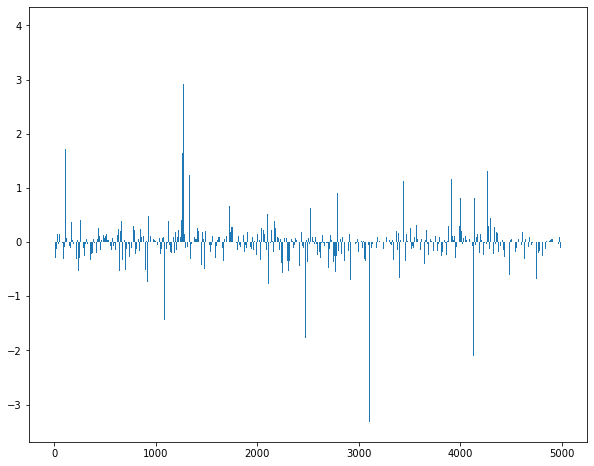

In [123]:
# print logistic regression's coef

plt.figure(figsize=(10, 8))
plt.bar(range(len(lr2.coef_[0])), lr2.coef_[0])

#### 학습된 로지스틱 회귀분석의 계수 그래프이다. 따라서, 계수가 양인 경우는 단어가 긍정적인 영향을 미쳤다고 볼 수 있고, 반면에, 음인 경우는 부정적인 영향을 미쳤다고 볼 수 있다. 이 계수들을 크기순으로 정렬하면, 긍정 / 부정 키워드를 출력하는 지표가 된다.

In [124]:
print(sorted(((value, index) for index, value in enumerate(lr2.coef_[0])), reverse = True)[:10])
print(sorted(((value, index) for index, value in enumerate(lr2.coef_[0])), reverse = True)[-10:])
# enumerate: 인덱스 번호와 컬렉션의 원소를 tuple형태로 반환함

[(3.976212435351955, 1600), (3.461406288161554, 315), (2.9956352955954033, 114), (2.9845986513151703, 359), (2.911126547050498, 1273), (2.4883359943008467, 343), (2.418840935265906, 1210), (2.3645450601097613, 657), (2.1650050503207003, 4906), (2.1563644025466084, 2529)]
[(-2.0619216574978494, 4255), (-2.0782444920090146, 2669), (-2.1068085419117555, 4131), (-2.1483307962194194, 2404), (-2.288115670111947, 1048), (-2.471717465375964, 2463), (-2.630392673718305, 2622), (-2.7408362800923096, 1045), (-2.8170878530476013, 2255), (-3.32303970706096, 3106)]


coefficient와 index번호로 출력된다!

In [125]:
#전체 단어가 포함한 "긍정 키워드 리스트"와 "부정 키워드 리스트"를 정의하고 출력
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr2.coef_[0])), reverse = True)
coef_neg_index = sorted(((value, index) for index, value in enumerate(lr2.coef_[0])), reverse = False)

In [126]:
coef_pos_index

[(3.976212435351955, 1600),
 (3.461406288161554, 315),
 (2.9956352955954033, 114),
 (2.9845986513151703, 359),
 (2.911126547050498, 1273),
 (2.4883359943008467, 343),
 (2.418840935265906, 1210),
 (2.3645450601097613, 657),
 (2.1650050503207003, 4906),
 (2.1563644025466084, 2529),
 (1.9196834000533898, 705),
 (1.9140091591737518, 4625),
 (1.868602221299333, 1690),
 (1.8468149978952122, 3834),
 (1.7949337958341018, 1498),
 (1.7238011356793494, 4375),
 (1.7168370598114167, 2073),
 (1.714626648302506, 110),
 (1.713620624236817, 937),
 (1.7068837302266182, 1358),
 (1.6537053869732325, 260),
 (1.6401727205381234, 1263),
 (1.6032374852592475, 3001),
 (1.5025891859732363, 2072),
 (1.3681807705709288, 1152),
 (1.3280842482996782, 3868),
 (1.306882597557433, 4269),
 (1.295648276928931, 1453),
 (1.2947364809364803, 4818),
 (1.2887951443343657, 1967),
 (1.23827420957467, 2321),
 (1.2347215229653192, 1332),
 (1.2211196436968865, 2577),
 (1.2105056422420122, 3696),
 (1.1938931118828273, 267),
 (1.18

In [127]:
invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}
invert_index_vectorizer

{1045: 'dirty',
 3106: 'room',
 3836: 'stayed',
 343: 'bellagio',
 1418: 'first',
 4219: 'time',
 1258: 'ever',
 4919: 'work',
 4375: 'trip',
 2952: 'requested',
 1142: 'early',
 609: 'check',
 4656: 'via',
 1501: 'front',
 1001: 'desk',
 1752: 'hotels',
 698: 'com',
 4255: 'told',
 1398: 'fill',
 153: 'anything',
 57: 'advance',
 162: 'app',
 3295: 'secure',
 1473: 'found',
 15: 'accessible',
 1583: 'good',
 1218: 'entered',
 4574: 'used',
 303: 'bathroom',
 827: 'counter',
 4296: 'towels',
 3794: 'stains',
 1629: 'hair',
 4189: 'throughout',
 322: 'bed',
 3402: 'sheets',
 1600: 'great',
 4590: 'vacation',
 315: 'beautiful',
 4818: 'well',
 1915: 'kept',
 4668: 'view',
 4906: 'wonderful',
 1453: 'food',
 3787: 'staff',
 1751: 'hotel',
 1263: 'everything',
 2304: 'need',
 1525: 'gambling',
 1033: 'dining',
 1358: 'fantastic',
 1307: 'experience',
 3724: 'spectacular',
 2619: 'pool',
 547: 'casino',
 3427: 'shopping',
 4269: 'top',
 2354: 'notch',
 2037: 'little',
 4167: 'thing',
 2475:

### 긍정 키워드 Top 20

In [128]:
pos_keyword=[]
pos_score=[]

for coef in coef_pos_index[:100]:
    #print(invert_index_vectorizer[coef[1]], coef[0])
    pos_keyword.append(invert_index_vectorizer[coef[1]])
    pos_score.append(coef[0])

df_pos_keyword = pd.DataFrame({"keyword":pos_keyword, "score":pos_score})
subset = df_pos_keyword[['keyword', 'score']]
tuples = [tuple(x) for x in subset.to_numpy()]

df_pos_keyword[:20]

keyword     score
0         great  3.976212
1     beautiful  3.461406
2       amazing  2.995635
3          best  2.984599
4     excellent  2.911127
5      bellagio  2.488336
6       enjoyed  2.418841
7         clean  2.364545
8     wonderful  2.165005
9       perfect  2.156364
10  comfortable  1.919683
11        vegas  1.914009
12      helpful  1.868602
13         stay  1.846815
14     friendly  1.794934
15         trip  1.723801
16        loved  1.716837
17       always  1.714627
18   definitely  1.713621
19    fantastic  1.706884

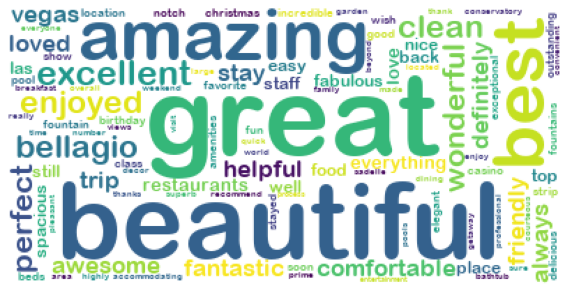

In [131]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(font_path="C:/Windows/Fonts/ARLRDBD.TTF",background_color="white", max_font_size=80)
cloud = wc.generate_from_frequencies(dict(tuples))

plt.figure(figsize=(10, 8))
plt.axis('off')
plt.imshow(cloud)
plt.show()

### 부정 키워드 Top 20

In [132]:
neg_keyword=[]
neg_score=[]

for coef in coef_neg_index[:100]:
    #print(invert_index_vectorizer[coef[1]], coef[0])
    neg_keyword.append(invert_index_vectorizer[coef[1]])
    neg_score.append(coef[0])

df_neg_keyword = pd.DataFrame({"keyword":neg_keyword, "score":neg_score})
list_1=(df_neg_keyword['score'])*(-1)
subset = pd.DataFrame({"keyword":neg_keyword, "score":list_1})
#subset = df_neg_keyword[['keyword', 'score']]
tuples = [tuple(x) for x in subset.to_numpy()]

df_neg_keyword[:20]

keyword     score
0            room -3.323040
1           money -2.817088
2           dirty -2.740836
3            poor -2.630393
4      overpriced -2.471717
5    disappointed -2.288116
6             old -2.148331
7        terrible -2.106809
8           price -2.078244
9            told -2.061922
10        average -1.994496
11         shower -1.795235
12           paid -1.764006
13         better -1.728361
14           rude -1.718192
15  disappointing -1.583921
16          water -1.459931
17        outside -1.456629
18         expect -1.455958
19            bad -1.439094

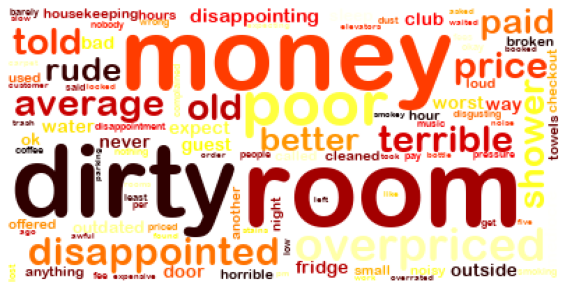

In [133]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(font_path="C:/Windows/Fonts/ARLRDBD.TTF",background_color="white", max_font_size=80, colormap='hot')
cloud = wc.generate_from_frequencies(dict(tuples))

plt.figure(figsize=(10, 8))
plt.axis('off')
plt.imshow(cloud)
plt.show()

# 7. 리뷰 예측해보기

코드 수정 참고 자료 : https://medium.com/@vasista/sentiment-analysis-using-svm-338d418e3ff1

In [61]:
#임의의 리뷰에 대해서 예측하는 함수
def sentiment_predict(new_sentence):
  #new_sentence = text_cleaning(new_sentence)
  bow_vect=vect.transform([new_sentence])
  tf_idf_vect = tfidf_vectorizer.transform(bow_vect)
  #tf_idf_vect = tf_idf_vect.toarray()
  #vector = np.vectorize(np.float)
  #tf_idf_vect = vector(tf_idf_vect)
  score = float(lr4.predict(tf_idf_vect)) # 예측
  if(score > 0.5):
    print("긍정 리뷰입니다.\n")
  else:
    print("부정 리뷰입니다.\n")

In [62]:
#5점리뷰
sentiment_predict('Awesome! Love our rooms, great food choices and a clean casino to gamble in! Looking forward to returning in the near future The cleaning staff were top notch and so polite!!!!! The Lagos Restaurent we ate in had delicious food, especially loved the breakfast sandwich! Delicious!!')

긍정 리뷰입니다.



In [63]:
#3점리뷰
sentiment_predict("Not bad but not great The casino dealers/cashiers are all very nice. The cleaning staff are super friendly as well. Always going out of their way to say hello. They have to stop allowing people to smoke in the casinos. Air ventilation and air exchangers is all creative marketing to get you to think the air quality is good. it's not, and it's archaic in todays' climate to allow someone to sit at a table or a slot machine and blow their smoke in your face. Felt sorry for the dealers as they have no choice but to sit there while obnoxious people literally blow smoke in their face. At least I can move seats.Went to speak to the casino hostess about getting my meals paid for because of my casino play. She told me that my room was already free what more did I want? Nice attitude..... and , considering I spent over $6,000 I would have thought taking care of my food bill would have been a nice gesture")

부정 리뷰입니다.



In [64]:
#2점리뷰
sentiment_predict("Not the impression I was expecting to get Quality of overall experience did not worth the price paid, did not like the service nor room came back more tired, stressed and sick. The online self check in was detailed but the staff ignored the requests put in. The rooms were tiny, bathroom sinks not functional My 1st and last time there")

부정 리뷰입니다.



In [65]:
#3점리뷰
sentiment_predict("Show was fabulous but hotel and buffet disappointing! Show was fabulous but hotel and buffet disappointing! Couldn't get soap or extra pillows. Room warm and took 2 hours to cool down, Robe not clean - had long black hairs on collar. Long wait times to check in and out and the buffet while offering many foods; some seemed very much like frozen foods trucked in and none had that chef prepared taste! For $100, such a disappointment!")

부정 리뷰입니다.



In [67]:
#3점리뷰
sentiment_predict("Must Get Back to Great Again! In room dining needs some work. Order was messed up several times. MGM rewards needs some TLC. You cannot downgrade good customers and expect them to embrace the program. Concierge was fantastic with dining reservations. Maids did a great job and were tipped accordingly. Understandably, your prices are much higher, but you have slipped a notch or two in quality. I request to be elevated to a Gold Rewards member based on just this valuable input alone, not to mention my disappointed and embarrassment.")

부정 리뷰입니다.



In [51]:
sentiment_predict('it was nice')

긍정 리뷰입니다.



In [422]:
sentiment_predict('it is not bad')

부정 리뷰입니다.



In [423]:
sentiment_predict('it is not bad price')

부정 리뷰입니다.



In [424]:
sentiment_predict('very good and chill')

긍정 리뷰입니다.



In [425]:
sentiment_predict('This was the second time we stayed at Bellagio in 6 months. We love the location. Easy access on foot to go shopping, dining, or shows. Room is very clean and great space. Many restaurants and high end shopping to enjoy. Several nice restaurants in the hotel. Yellowtail Restaurant... yummy!!!!')

긍정 리뷰입니다.



In [426]:
#3점 리뷰
sentiment_predict('I stayed in the Bellagio suite and still the house keeping service as well as the service desk fulfillment of requests was very bad. If you miss the regular room cleaning schedule…your room will not be cleaned even if you request multiple times')

긍정 리뷰입니다.



In [433]:
#3점 리뷰
sentiment_predict('Hotel over all is very nice. Aracelis went above and beyond to assist us...... Im a Amex Platinum card holder, an MGM rewards member, had reservations at Prime and Lago were we spend well over 1000 dollars. At the time of arrival, the person who helped us (Rosemary from Philippines) was not to helpful. She offered an upgarde to another room for an additional 450$ per night, even though as an Amex Platinum member we are supposed to receive this at no additional cost when available. On the second day of our stay, Aracelis was able to provide the service that was rightfully expected. In the original room that we were assigned (22 604) there was mold in the shower, dust on the furniture, drawers were dirty, shower head sprayed everywhere, there was glue and stains in the wall paper behind the bed specially. The quality of the toiletries was terrible')

부정 리뷰입니다.



In [53]:
#임의의 리뷰에 대해서 예측하는 함수
def sentiment_predict_LSTM(new_sentence):
  #new_sentence = text_cleaning(new_sentence)
  bow_vect=vect.transform([new_sentence])
  tf_idf_vect = tfidf_vectorizer.transform(bow_vect)
  tf_idf_vect = tf_idf_vect.toarray()
  #vector = np.vectorize(np.float)
  #tf_idf_vect = vector(tf_idf_vect)
  score = float(loaded_model.predict(tf_idf_vect)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [141]:
#임의의 리뷰에 대해서 예측하는 함수
def sentiment_predict_LSTM(new_sentence):
  #new_sentence = text_cleaning(new_sentence)
  bow_vect=vect.transform([new_sentence])
  tf_idf_vect = tfidf_vectorizer.transform(bow_vect)
  tf_idf_vect = tf_idf_vect.toarray()
  #vector = np.vectorize(np.float)
  #tf_idf_vect = vector(tf_idf_vect)
  score = float(loaded_model.predict(tf_idf_vect)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [142]:
sentiment_predict_LSTM('Hotel over all is very nice. Aracelis went above and beyond to assist us...... Im a Amex Platinum card holder, an MGM rewards member, had reservations at Prime and Lago were we spend well over 1000 dollars. At the time of arrival, the person who helped us (Rosemary from Philippines) was not to helpful. She offered an upgarde to another room for an additional 450$ per night, even though as an Amex Platinum member we are supposed to receive this at no additional cost when available. On the second day of our stay, Aracelis was able to provide the service that was rightfully expected. In the original room that we were assigned (22 604) there was mold in the shower, dust on the furniture, drawers were dirty, shower head sprayed everywhere, there was glue and stains in the wall paper behind the bed specially. The quality of the toiletries was terrible')

64.94% 확률로 긍정 리뷰입니다.



In [54]:
sentiment_predict_LSTM('Hotel over all is very nice. Aracelis went above and beyond to assist us...... Im a Amex Platinum card holder, an MGM rewards member, had reservations at Prime and Lago were we spend well over 1000 dollars. At the time of arrival, the person who helped us (Rosemary from Philippines) was not to helpful. She offered an upgarde to another room for an additional 450$ per night, even though as an Amex Platinum member we are supposed to receive this at no additional cost when available. On the second day of our stay, Aracelis was able to provide the service that was rightfully expected. In the original room that we were assigned (22 604) there was mold in the shower, dust on the furniture, drawers were dirty, shower head sprayed everywhere, there was glue and stains in the wall paper behind the bed specially. The quality of the toiletries was terrible')

64.94% 확률로 긍정 리뷰입니다.



In [55]:
sentiment_predict_LSTM('This was the second time we stayed at Bellagio in 6 months. We love the location. Easy access on foot to go shopping, dining, or shows. Room is very clean and great space. Many restaurants and high end shopping to enjoy. Several nice restaurants in the hotel. Yellowtail Restaurant... yummy!!!!')

64.94% 확률로 긍정 리뷰입니다.



In [56]:
sentiment_predict_LSTM('it was comfortable')

64.94% 확률로 긍정 리뷰입니다.



In [59]:
sentiment_predict_LSTM('greattsdsfasfasfasfsafsdafsadfsadf')

64.94% 확률로 긍정 리뷰입니다.



### NOTE : 일반 classifier 분석은 0또는 1로만 분류를 하기 때문에 LSTM처럼 확률을 구할수가 없다. → 그렇다면 LSTM은 뭐가 다른걸까? → 뉴럴기반이기 때문에 확률이 구해지는건가?
로지스틱 회귀분석은 각 클래스에 속할 확률을 구하게 되는건데 궁극적인 확률 자체만을 구할수 .. 있지 않나? 형태소 5000개가 feature가 되니까 각 회귀계수를 알것이고 새로운 문장에 단어가 있으면 1 없으면 0으로 계산->이게 확률이잖아
- logistic VS. LSTM : https://www.kaggle.com/code/moayyadyaghi/sentiment-prediction-lstm-vs-logistic-regression/notebook //
https://ai.plainenglish.io/comparison-between-logistic-regression-and-neural-networks-in-classifying-digits-dc5e85cd93c3

- lstm 추가 고려
- 모델 성능 비교로 최적화 하나 고르기
- 그리드서치로 튜닝
- 긍정 부정별로 워드 클라우드